In [1]:
!python -m pip install --user --upgrade pip
!python -m pip install --user keras
!python -m pip install --user tensorflow
!python -m pip install --user -U numpy

  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7546 sha256=c9248ebcd4e749e33e1aa3f62ba103d01a375a4a09bf5c4b45f96ff703154d7b
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for absl-py: filename=absl_py-0.8.1-cp37-none-any.whl size=121172 sha256=5e56fcd883776347f1b50d8b08ab66acc6eaf2eafb823b1ff3ee4f56f6e81b6d
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61701 sha256=216dd04f0060303440f7fbc40980e937e67f5b29929eccefacc57ce46e0420a3
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4836 sha256=5539cda6c099603c1da0985b9f2f82a667368b6ee0bdb511dc77ec

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


ERROR: tables 3.5.1 requires mock>=2.0, which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import ELU
#from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, Normalizer
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

# Model Building

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
df = pd.read_csv('Options_MCdropout_TT.csv')
df = df.dropna()
df.dtypes

ticker               object
date                 object
exdate               object
maturity              int64
strike_price        float64
best_offer          float64
impl_volatility     float64
underlying_price    float64
interest_rate       float64
cp_flag_C             int64
cp_flag_P             int64
moneyness           float64
dtype: object

In [5]:
df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
# Calculate the intrinsic value of all the options
df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
sample_df = df[['maturity', 'strike_price', 'underlying_price', 'impl_volatility', 'cp_flag_C', 'cp_flag_P', 'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
sample_df = sample_df.reset_index(drop=True)

In [39]:
ITM_df = sample_df[sample_df['moneyness'] <= 0.97]
ATM_df = sample_df[sample_df['moneyness'].between(0.97, 1.03, inclusive = False)]
OTM_df = sample_df[sample_df['moneyness'] >= 1.03]

In [40]:
print('option data shape:', sample_df.shape)
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

option data shape: (1964315, 10)
In-The_Money option data shape: (1010896, 10)
An-The_Money option data shape: (322125, 10)
Out-The_Money option data shape: (631294, 10)


In [33]:
def get_corr(df):
    corr_matrix = df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['price'].sort_values(ascending=False)
    print(corr)
    
    return corr

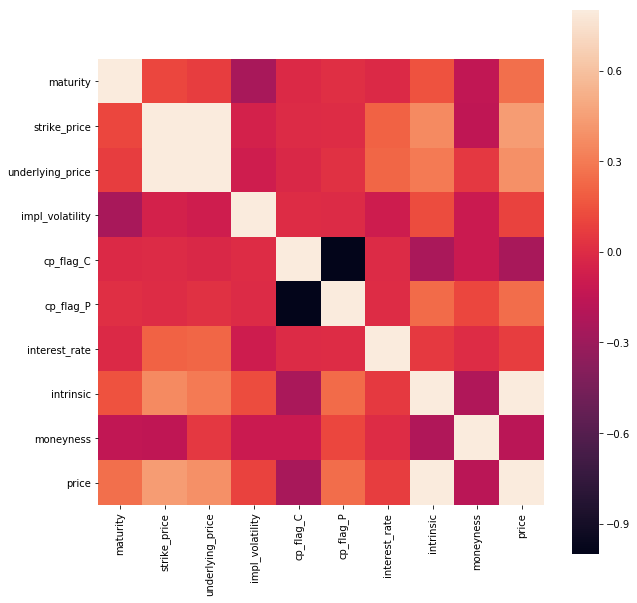

price               1.000000
intrinsic           0.976874
strike_price        0.436915
underlying_price    0.385230
maturity            0.254864
cp_flag_P           0.248238
impl_volatility     0.096158
interest_rate       0.073820
moneyness          -0.177144
cp_flag_C          -0.248238
Name: price, dtype: float64


In [34]:
corr = get_corr(train_df)

In [6]:
def data_minmaxscaler(s_df):
    y = s_df['best_offer'].values
    X = s_df[['maturity', 'strike_price', 'underlying_price', 'impl_volatility', 'cp_flag_P', 'interest_rate', 'intrinsic']]
    
    sc_X = MinMaxScaler(feature_range=(0, 1))
    sc_X.fit(X)
    X_scale = sc_X.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [7]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Hyper-parameter Optimization

In [17]:
def model_hyper_optimization(dropout_rate=0.05, init_mode='uniform'):
    model = Sequential()
    model.add(Dense(100, input_dim=7, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(300, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# create model
model = KerasRegressor(build_fn=model_hyper_optimization, verbose=2)
# define the grid search parameters
batch_size = [256, 512, 1024]
epochs = [100,200]
init_mode = ['uniform', 'glorot_uniform']
dropout_rate = [0.05, 0.1, 0.2]
param_grid = dict(batch_size=batch_size, epochs=epochs, init_mode=init_mode, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [9]:
X_train, X_test, y_train, y_test = data_minmaxscaler(sample_df.sample(n=50000))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/100
 - 10s - loss: 1932.0684 - mean_absolute_error: 27.5206
Epoch 2/100
 - 2s - loss: 121.5400 - mean_absolute_error: 7.8655
Epoch 3/100
 - 2s - loss: 65.1209 - mean_absolute_error: 5.5751
Epoch 4/100
 - 2s - loss: 58.2674 - mean_absolute_error: 5.1131
Epoch 5/100
 - 2s - loss: 54.8246 - mean_absolute_error: 4.9143
Epoch 6/100
 - 2s - loss: 53.8121 - mean_absolute_error: 4.8707
Epoch 7/100
 - 2s - loss: 48.5578 - mean_absolute_error: 4.5668
Epoch 8/100
 - 2s - loss: 46.8738 - mean_absolute_error: 4.4558
Epoch 9/100
 - 2s - loss: 42.2653 - mean_absolute_error: 4.1596
Epoch 10/100
 - 2s - loss: 40.2875 - mean_absolute_error: 4.0515
Epoch 11/100
 - 2s - loss: 36.7788 - mean_absolute_error: 3.8313
Epoch 12/100
 - 2s - loss: 32.1558 - mean_absolute_error: 3.5416
Epoch 13/100
 - 2s - loss: 30.9940 - mean_absolute_error: 3.4124
Epoch 14/100
 - 2s - loss: 28.3000 - mean_absolute_error: 3.3167
Epoch 15/100
 - 2s - loss: 26.2196 - mean_absolute_error: 3.1313
Epoch 16/100
 - 2s - loss: 25

 - 2s - loss: 23.6561 - mean_absolute_error: 2.9215
Epoch 28/100
 - 2s - loss: 21.3239 - mean_absolute_error: 2.7695
Epoch 29/100
 - 2s - loss: 21.4609 - mean_absolute_error: 2.8003
Epoch 30/100
 - 2s - loss: 21.2201 - mean_absolute_error: 2.7166
Epoch 31/100
 - 2s - loss: 22.3189 - mean_absolute_error: 2.8340
Epoch 32/100
 - 2s - loss: 20.2009 - mean_absolute_error: 2.6602
Epoch 33/100
 - 2s - loss: 20.7935 - mean_absolute_error: 2.6977
Epoch 34/100
 - 2s - loss: 22.0542 - mean_absolute_error: 2.8035
Epoch 35/100
 - 2s - loss: 19.7985 - mean_absolute_error: 2.6000
Epoch 36/100
 - 2s - loss: 19.8866 - mean_absolute_error: 2.6175
Epoch 37/100
 - 2s - loss: 18.6337 - mean_absolute_error: 2.4913
Epoch 38/100
 - 2s - loss: 19.8894 - mean_absolute_error: 2.6146
Epoch 39/100
 - 2s - loss: 22.7518 - mean_absolute_error: 2.8715
Epoch 40/100
 - 2s - loss: 19.6174 - mean_absolute_error: 2.5828
Epoch 41/100
 - 2s - loss: 21.2473 - mean_absolute_error: 2.7046
Epoch 42/100
 - 2s - loss: 18.9038 - m

Epoch 54/100
 - 2s - loss: 20.9820 - mean_absolute_error: 2.7082
Epoch 55/100
 - 2s - loss: 19.0007 - mean_absolute_error: 2.5179
Epoch 56/100
 - 2s - loss: 18.5297 - mean_absolute_error: 2.5308
Epoch 57/100
 - 2s - loss: 18.2194 - mean_absolute_error: 2.4882
Epoch 58/100
 - 2s - loss: 18.3200 - mean_absolute_error: 2.4867
Epoch 59/100
 - 2s - loss: 18.2751 - mean_absolute_error: 2.4949
Epoch 60/100
 - 2s - loss: 20.8624 - mean_absolute_error: 2.6735
Epoch 61/100
 - 2s - loss: 18.5441 - mean_absolute_error: 2.4709
Epoch 62/100
 - 2s - loss: 18.7203 - mean_absolute_error: 2.4976
Epoch 63/100
 - 2s - loss: 18.5463 - mean_absolute_error: 2.5245
Epoch 64/100
 - 2s - loss: 20.4164 - mean_absolute_error: 2.6997
Epoch 65/100
 - 2s - loss: 19.6664 - mean_absolute_error: 2.6205
Epoch 66/100
 - 2s - loss: 18.5375 - mean_absolute_error: 2.5142
Epoch 67/100
 - 2s - loss: 17.5509 - mean_absolute_error: 2.3851
Epoch 68/100
 - 2s - loss: 17.6781 - mean_absolute_error: 2.4859
Epoch 69/100
 - 2s - loss

 - 2s - loss: 11.4241 - mean_absolute_error: 1.8811
Epoch 81/100
 - 2s - loss: 13.1375 - mean_absolute_error: 2.0683
Epoch 82/100
 - 2s - loss: 12.1641 - mean_absolute_error: 1.9006
Epoch 83/100
 - 2s - loss: 11.7864 - mean_absolute_error: 1.9179
Epoch 84/100
 - 2s - loss: 11.2396 - mean_absolute_error: 1.8772
Epoch 85/100
 - 3s - loss: 12.9714 - mean_absolute_error: 1.9791
Epoch 86/100
 - 2s - loss: 11.9335 - mean_absolute_error: 1.8864
Epoch 87/100
 - 3s - loss: 12.8159 - mean_absolute_error: 1.9828
Epoch 88/100
 - 2s - loss: 13.9438 - mean_absolute_error: 2.1151
Epoch 89/100
 - 3s - loss: 11.3022 - mean_absolute_error: 1.8382
Epoch 90/100
 - 2s - loss: 14.1195 - mean_absolute_error: 2.0752
Epoch 91/100
 - 3s - loss: 12.8335 - mean_absolute_error: 1.9923
Epoch 92/100
 - 2s - loss: 11.5560 - mean_absolute_error: 1.8596
Epoch 93/100
 - 2s - loss: 12.2716 - mean_absolute_error: 1.9380
Epoch 94/100
 - 2s - loss: 10.6300 - mean_absolute_error: 1.7840
Epoch 95/100
 - 2s - loss: 10.7049 - m

Epoch 7/100
 - 2s - loss: 41.2931 - mean_absolute_error: 4.1010
Epoch 8/100
 - 2s - loss: 36.6886 - mean_absolute_error: 3.8023
Epoch 9/100
 - 2s - loss: 33.1067 - mean_absolute_error: 3.6224
Epoch 10/100
 - 2s - loss: 32.0010 - mean_absolute_error: 3.4977
Epoch 11/100
 - 2s - loss: 30.2345 - mean_absolute_error: 3.4075
Epoch 12/100
 - 2s - loss: 27.9247 - mean_absolute_error: 3.2456
Epoch 13/100
 - 2s - loss: 27.2098 - mean_absolute_error: 3.1885
Epoch 14/100
 - 2s - loss: 26.3143 - mean_absolute_error: 3.1366
Epoch 15/100
 - 2s - loss: 23.9325 - mean_absolute_error: 2.9543
Epoch 16/100
 - 2s - loss: 21.5511 - mean_absolute_error: 2.8045
Epoch 17/100
 - 2s - loss: 21.5832 - mean_absolute_error: 2.7760
Epoch 18/100
 - 2s - loss: 22.7756 - mean_absolute_error: 2.8541
Epoch 19/100
 - 2s - loss: 21.2721 - mean_absolute_error: 2.7614
Epoch 20/100
 - 2s - loss: 19.8650 - mean_absolute_error: 2.6579
Epoch 21/100
 - 2s - loss: 19.8895 - mean_absolute_error: 2.6381
Epoch 22/100
 - 2s - loss: 1

 - 2s - loss: 21.5416 - mean_absolute_error: 2.7619
Epoch 34/200
 - 2s - loss: 22.5347 - mean_absolute_error: 2.8898
Epoch 35/200
 - 2s - loss: 21.5051 - mean_absolute_error: 2.7496
Epoch 36/200
 - 2s - loss: 21.8254 - mean_absolute_error: 2.7496
Epoch 37/200
 - 2s - loss: 21.0713 - mean_absolute_error: 2.7784
Epoch 38/200
 - 2s - loss: 21.7505 - mean_absolute_error: 2.8015
Epoch 39/200
 - 2s - loss: 21.7864 - mean_absolute_error: 2.8039
Epoch 40/200
 - 2s - loss: 21.0703 - mean_absolute_error: 2.7398
Epoch 41/200
 - 2s - loss: 22.4421 - mean_absolute_error: 2.8694
Epoch 42/200
 - 2s - loss: 22.5153 - mean_absolute_error: 2.8530
Epoch 43/200
 - 2s - loss: 21.0937 - mean_absolute_error: 2.7254
Epoch 44/200
 - 2s - loss: 20.8262 - mean_absolute_error: 2.7118
Epoch 45/200
 - 2s - loss: 21.9327 - mean_absolute_error: 2.8139
Epoch 46/200
 - 2s - loss: 21.7633 - mean_absolute_error: 2.7722
Epoch 47/200
 - 2s - loss: 22.9251 - mean_absolute_error: 2.8522
Epoch 48/200
 - 3s - loss: 21.2692 - m

Epoch 159/200
 - 2s - loss: 16.5496 - mean_absolute_error: 2.3296
Epoch 160/200
 - 2s - loss: 14.4122 - mean_absolute_error: 2.1420
Epoch 161/200
 - 2s - loss: 14.7141 - mean_absolute_error: 2.2057
Epoch 162/200
 - 2s - loss: 16.3230 - mean_absolute_error: 2.3533
Epoch 163/200
 - 2s - loss: 16.3961 - mean_absolute_error: 2.3314
Epoch 164/200
 - 2s - loss: 15.2564 - mean_absolute_error: 2.2136
Epoch 165/200
 - 2s - loss: 15.9120 - mean_absolute_error: 2.2962
Epoch 166/200
 - 2s - loss: 15.0185 - mean_absolute_error: 2.2045
Epoch 167/200
 - 2s - loss: 14.8470 - mean_absolute_error: 2.1704
Epoch 168/200
 - 2s - loss: 14.8462 - mean_absolute_error: 2.2618
Epoch 169/200
 - 2s - loss: 13.7746 - mean_absolute_error: 2.1008
Epoch 170/200
 - 2s - loss: 16.4699 - mean_absolute_error: 2.2872
Epoch 171/200
 - 2s - loss: 15.1501 - mean_absolute_error: 2.2590
Epoch 172/200
 - 2s - loss: 13.8883 - mean_absolute_error: 2.1068
Epoch 173/200
 - 2s - loss: 14.1389 - mean_absolute_error: 2.1728
Epoch 174/

Epoch 85/200
 - 2s - loss: 14.7463 - mean_absolute_error: 2.1993
Epoch 86/200
 - 2s - loss: 15.6877 - mean_absolute_error: 2.2891
Epoch 87/200
 - 2s - loss: 16.0475 - mean_absolute_error: 2.3527
Epoch 88/200
 - 2s - loss: 15.5461 - mean_absolute_error: 2.2648
Epoch 89/200
 - 2s - loss: 16.5123 - mean_absolute_error: 2.3369
Epoch 90/200
 - 2s - loss: 16.1466 - mean_absolute_error: 2.2917
Epoch 91/200
 - 2s - loss: 15.2360 - mean_absolute_error: 2.2522
Epoch 92/200
 - 2s - loss: 15.2529 - mean_absolute_error: 2.2152
Epoch 93/200
 - 2s - loss: 15.1118 - mean_absolute_error: 2.2460
Epoch 94/200
 - 2s - loss: 15.5069 - mean_absolute_error: 2.2397
Epoch 95/200
 - 2s - loss: 16.3728 - mean_absolute_error: 2.3496
Epoch 96/200
 - 2s - loss: 15.6514 - mean_absolute_error: 2.2958
Epoch 97/200
 - 2s - loss: 15.9638 - mean_absolute_error: 2.3422
Epoch 98/200
 - 2s - loss: 17.2260 - mean_absolute_error: 2.3977
Epoch 99/200
 - 2s - loss: 16.6061 - mean_absolute_error: 2.3430
Epoch 100/200
 - 2s - los

Epoch 10/200
 - 3s - loss: 47.7711 - mean_absolute_error: 4.5680
Epoch 11/200
 - 2s - loss: 43.7965 - mean_absolute_error: 4.3779
Epoch 12/200
 - 2s - loss: 42.2354 - mean_absolute_error: 4.2233
Epoch 13/200
 - 2s - loss: 41.8075 - mean_absolute_error: 4.2147
Epoch 14/200
 - 2s - loss: 40.1751 - mean_absolute_error: 4.1288
Epoch 15/200
 - 2s - loss: 37.3552 - mean_absolute_error: 3.9210
Epoch 16/200
 - 2s - loss: 33.2974 - mean_absolute_error: 3.6794
Epoch 17/200
 - 2s - loss: 33.1597 - mean_absolute_error: 3.6380
Epoch 18/200
 - 2s - loss: 30.7519 - mean_absolute_error: 3.4732
Epoch 19/200
 - 2s - loss: 31.8929 - mean_absolute_error: 3.5602
Epoch 20/200
 - 2s - loss: 28.7371 - mean_absolute_error: 3.3420
Epoch 21/200
 - 2s - loss: 30.3769 - mean_absolute_error: 3.4345
Epoch 22/200
 - 2s - loss: 25.4674 - mean_absolute_error: 3.1002
Epoch 23/200
 - 2s - loss: 26.5886 - mean_absolute_error: 3.1676
Epoch 24/200
 - 2s - loss: 24.3487 - mean_absolute_error: 3.0012
Epoch 25/200
 - 2s - loss

Epoch 136/200
 - 2s - loss: 15.3489 - mean_absolute_error: 2.2704
Epoch 137/200
 - 2s - loss: 15.3079 - mean_absolute_error: 2.2554
Epoch 138/200
 - 2s - loss: 15.4772 - mean_absolute_error: 2.2479
Epoch 139/200
 - 2s - loss: 18.0964 - mean_absolute_error: 2.5066
Epoch 140/200
 - 2s - loss: 15.4486 - mean_absolute_error: 2.2517
Epoch 141/200
 - 2s - loss: 16.5421 - mean_absolute_error: 2.3933
Epoch 142/200
 - 2s - loss: 16.1697 - mean_absolute_error: 2.3332
Epoch 143/200
 - 2s - loss: 16.6005 - mean_absolute_error: 2.3728
Epoch 144/200
 - 2s - loss: 16.4079 - mean_absolute_error: 2.3205
Epoch 145/200
 - 2s - loss: 15.7063 - mean_absolute_error: 2.2997
Epoch 146/200
 - 2s - loss: 17.6343 - mean_absolute_error: 2.4379
Epoch 147/200
 - 2s - loss: 15.9566 - mean_absolute_error: 2.2880
Epoch 148/200
 - 2s - loss: 15.4788 - mean_absolute_error: 2.2787
Epoch 149/200
 - 3s - loss: 15.7923 - mean_absolute_error: 2.2999
Epoch 150/200
 - 3s - loss: 16.3956 - mean_absolute_error: 2.3516
Epoch 151/

 - 2s - loss: 12.1813 - mean_absolute_error: 1.9710
Epoch 62/200
 - 2s - loss: 13.9101 - mean_absolute_error: 2.0985
Epoch 63/200
 - 2s - loss: 12.3024 - mean_absolute_error: 1.9735
Epoch 64/200
 - 2s - loss: 12.7076 - mean_absolute_error: 2.0632
Epoch 65/200
 - 2s - loss: 12.2288 - mean_absolute_error: 1.9956
Epoch 66/200
 - 2s - loss: 13.0099 - mean_absolute_error: 2.0568
Epoch 67/200
 - 2s - loss: 13.3071 - mean_absolute_error: 2.0143
Epoch 68/200
 - 2s - loss: 11.8023 - mean_absolute_error: 1.9443
Epoch 69/200
 - 2s - loss: 11.6849 - mean_absolute_error: 1.9076
Epoch 70/200
 - 2s - loss: 11.2962 - mean_absolute_error: 1.8946
Epoch 71/200
 - 2s - loss: 11.0870 - mean_absolute_error: 1.8508
Epoch 72/200
 - 2s - loss: 11.9216 - mean_absolute_error: 1.9387
Epoch 73/200
 - 2s - loss: 11.8562 - mean_absolute_error: 1.9271
Epoch 74/200
 - 2s - loss: 11.4799 - mean_absolute_error: 1.8737
Epoch 75/200
 - 2s - loss: 10.5900 - mean_absolute_error: 1.8298
Epoch 76/200
 - 2s - loss: 12.6224 - m

Epoch 187/200
 - 2s - loss: 11.4556 - mean_absolute_error: 1.8087
Epoch 188/200
 - 2s - loss: 9.5908 - mean_absolute_error: 1.6692
Epoch 189/200
 - 2s - loss: 12.1861 - mean_absolute_error: 1.9233
Epoch 190/200
 - 2s - loss: 8.5851 - mean_absolute_error: 1.5865
Epoch 191/200
 - 2s - loss: 9.9688 - mean_absolute_error: 1.7049
Epoch 192/200
 - 2s - loss: 10.4145 - mean_absolute_error: 1.7383
Epoch 193/200
 - 2s - loss: 10.0683 - mean_absolute_error: 1.6875
Epoch 194/200
 - 2s - loss: 8.9696 - mean_absolute_error: 1.6460
Epoch 195/200
 - 2s - loss: 9.9996 - mean_absolute_error: 1.7377
Epoch 196/200
 - 2s - loss: 10.8741 - mean_absolute_error: 1.7719
Epoch 197/200
 - 2s - loss: 9.8310 - mean_absolute_error: 1.6748
Epoch 198/200
 - 2s - loss: 9.7249 - mean_absolute_error: 1.6836
Epoch 199/200
 - 2s - loss: 10.2120 - mean_absolute_error: 1.7493
Epoch 200/200
 - 2s - loss: 10.1220 - mean_absolute_error: 1.6532
Epoch 1/200
 - 9s - loss: 1382.9470 - mean_absolute_error: 23.0294
Epoch 2/200
 - 2

Epoch 113/200
 - 2s - loss: 11.2714 - mean_absolute_error: 1.8407
Epoch 114/200
 - 2s - loss: 9.8398 - mean_absolute_error: 1.7240
Epoch 115/200
 - 2s - loss: 10.0754 - mean_absolute_error: 1.7775
Epoch 116/200
 - 2s - loss: 9.8381 - mean_absolute_error: 1.7616
Epoch 117/200
 - 2s - loss: 10.3121 - mean_absolute_error: 1.7590
Epoch 118/200
 - 2s - loss: 10.6313 - mean_absolute_error: 1.7829
Epoch 119/200
 - 2s - loss: 9.4891 - mean_absolute_error: 1.6991
Epoch 120/200
 - 2s - loss: 9.9555 - mean_absolute_error: 1.7671
Epoch 121/200
 - 2s - loss: 10.5970 - mean_absolute_error: 1.8032
Epoch 122/200
 - 2s - loss: 9.6333 - mean_absolute_error: 1.7118
Epoch 123/200
 - 2s - loss: 9.6098 - mean_absolute_error: 1.7439
Epoch 124/200
 - 2s - loss: 9.7103 - mean_absolute_error: 1.6930
Epoch 125/200
 - 2s - loss: 10.2012 - mean_absolute_error: 1.7346
Epoch 126/200
 - 2s - loss: 13.7978 - mean_absolute_error: 1.9319
Epoch 127/200
 - 2s - loss: 12.2965 - mean_absolute_error: 1.9576
Epoch 128/200
 - 

Epoch 39/200
 - 2s - loss: 15.4497 - mean_absolute_error: 2.2412
Epoch 40/200
 - 2s - loss: 15.6480 - mean_absolute_error: 2.2671
Epoch 41/200
 - 2s - loss: 13.8869 - mean_absolute_error: 2.1682
Epoch 42/200
 - 2s - loss: 16.2269 - mean_absolute_error: 2.2831
Epoch 43/200
 - 2s - loss: 15.2449 - mean_absolute_error: 2.1983
Epoch 44/200
 - 2s - loss: 14.9312 - mean_absolute_error: 2.2138
Epoch 45/200
 - 2s - loss: 15.4222 - mean_absolute_error: 2.2253
Epoch 46/200
 - 2s - loss: 14.7449 - mean_absolute_error: 2.2048
Epoch 47/200
 - 2s - loss: 14.5640 - mean_absolute_error: 2.2277
Epoch 48/200
 - 2s - loss: 13.9477 - mean_absolute_error: 2.1470
Epoch 49/200
 - 2s - loss: 15.4795 - mean_absolute_error: 2.2302
Epoch 50/200
 - 2s - loss: 17.2763 - mean_absolute_error: 2.3820
Epoch 51/200
 - 2s - loss: 12.6718 - mean_absolute_error: 2.0131
Epoch 52/200
 - 2s - loss: 15.3180 - mean_absolute_error: 2.2028
Epoch 53/200
 - 2s - loss: 13.8079 - mean_absolute_error: 2.0905
Epoch 54/200
 - 2s - loss

 - 2s - loss: 11.0016 - mean_absolute_error: 1.8073
Epoch 165/200
 - 2s - loss: 11.1278 - mean_absolute_error: 1.7979
Epoch 166/200
 - 2s - loss: 11.7306 - mean_absolute_error: 1.8344
Epoch 167/200
 - 2s - loss: 10.1417 - mean_absolute_error: 1.7242
Epoch 168/200
 - 2s - loss: 11.6289 - mean_absolute_error: 1.7962
Epoch 169/200
 - 2s - loss: 12.7775 - mean_absolute_error: 1.9356
Epoch 170/200
 - 2s - loss: 11.0022 - mean_absolute_error: 1.7897
Epoch 171/200
 - 2s - loss: 12.8008 - mean_absolute_error: 1.9623
Epoch 172/200
 - 2s - loss: 10.8758 - mean_absolute_error: 1.8080
Epoch 173/200
 - 2s - loss: 10.2824 - mean_absolute_error: 1.7452
Epoch 174/200
 - 2s - loss: 9.9596 - mean_absolute_error: 1.6867
Epoch 175/200
 - 2s - loss: 10.1695 - mean_absolute_error: 1.6960
Epoch 176/200
 - 2s - loss: 10.4801 - mean_absolute_error: 1.7767
Epoch 177/200
 - 2s - loss: 9.5135 - mean_absolute_error: 1.6799
Epoch 178/200
 - 2s - loss: 10.3842 - mean_absolute_error: 1.7562
Epoch 179/200
 - 2s - loss

Epoch 90/100
 - 2s - loss: 31.6051 - mean_absolute_error: 3.3096
Epoch 91/100
 - 2s - loss: 30.6936 - mean_absolute_error: 3.2154
Epoch 92/100
 - 2s - loss: 35.4778 - mean_absolute_error: 3.4941
Epoch 93/100
 - 2s - loss: 32.9047 - mean_absolute_error: 3.3227
Epoch 94/100
 - 2s - loss: 31.9227 - mean_absolute_error: 3.2723
Epoch 95/100
 - 2s - loss: 31.9291 - mean_absolute_error: 3.2852
Epoch 96/100
 - 2s - loss: 29.3613 - mean_absolute_error: 3.1703
Epoch 97/100
 - 2s - loss: 31.1654 - mean_absolute_error: 3.2157
Epoch 98/100
 - 2s - loss: 31.3191 - mean_absolute_error: 3.2564
Epoch 99/100
 - 2s - loss: 31.3364 - mean_absolute_error: 3.2883
Epoch 100/100
 - 2s - loss: 33.5851 - mean_absolute_error: 3.4538
Epoch 1/100
 - 10s - loss: 1861.0374 - mean_absolute_error: 26.9672
Epoch 2/100
 - 2s - loss: 132.1350 - mean_absolute_error: 8.2357
Epoch 3/100
 - 2s - loss: 81.3344 - mean_absolute_error: 6.1860
Epoch 4/100
 - 2s - loss: 76.6217 - mean_absolute_error: 5.8743
Epoch 5/100
 - 2s - los

 - 2s - loss: 50.1099 - mean_absolute_error: 4.4949
Epoch 17/100
 - 2s - loss: 53.6967 - mean_absolute_error: 4.6276
Epoch 18/100
 - 2s - loss: 48.3705 - mean_absolute_error: 4.3951
Epoch 19/100
 - 2s - loss: 46.1876 - mean_absolute_error: 4.2386
Epoch 20/100
 - 2s - loss: 44.9349 - mean_absolute_error: 4.1844
Epoch 21/100
 - 2s - loss: 46.7042 - mean_absolute_error: 4.2864
Epoch 22/100
 - 2s - loss: 46.3536 - mean_absolute_error: 4.2386
Epoch 23/100
 - 2s - loss: 43.8791 - mean_absolute_error: 4.1367
Epoch 24/100
 - 2s - loss: 45.4631 - mean_absolute_error: 4.2425
Epoch 25/100
 - 2s - loss: 43.3589 - mean_absolute_error: 4.1083
Epoch 26/100
 - 2s - loss: 41.5029 - mean_absolute_error: 3.9780
Epoch 27/100
 - 2s - loss: 43.4703 - mean_absolute_error: 4.0600
Epoch 28/100
 - 2s - loss: 40.2764 - mean_absolute_error: 3.8393
Epoch 29/100
 - 2s - loss: 41.5425 - mean_absolute_error: 3.9002
Epoch 30/100
 - 2s - loss: 42.1991 - mean_absolute_error: 4.0017
Epoch 31/100
 - 2s - loss: 42.6310 - m

Epoch 43/100
 - 2s - loss: 24.3002 - mean_absolute_error: 2.7532
Epoch 44/100
 - 2s - loss: 24.2759 - mean_absolute_error: 2.7721
Epoch 45/100
 - 2s - loss: 26.2794 - mean_absolute_error: 2.9128
Epoch 46/100
 - 2s - loss: 23.9681 - mean_absolute_error: 2.7574
Epoch 47/100
 - 2s - loss: 24.0662 - mean_absolute_error: 2.6907
Epoch 48/100
 - 2s - loss: 24.3784 - mean_absolute_error: 2.7461
Epoch 49/100
 - 2s - loss: 26.4469 - mean_absolute_error: 2.8209
Epoch 50/100
 - 2s - loss: 24.8515 - mean_absolute_error: 2.7354
Epoch 51/100
 - 2s - loss: 25.4649 - mean_absolute_error: 2.8234
Epoch 52/100
 - 2s - loss: 25.1789 - mean_absolute_error: 2.8000
Epoch 53/100
 - 2s - loss: 24.4284 - mean_absolute_error: 2.8295
Epoch 54/100
 - 2s - loss: 24.6880 - mean_absolute_error: 2.8087
Epoch 55/100
 - 2s - loss: 23.7649 - mean_absolute_error: 2.6700
Epoch 56/100
 - 2s - loss: 22.3474 - mean_absolute_error: 2.6314
Epoch 57/100
 - 2s - loss: 23.3190 - mean_absolute_error: 2.6571
Epoch 58/100
 - 2s - loss

 - 2s - loss: 25.9528 - mean_absolute_error: 2.7664
Epoch 70/100
 - 2s - loss: 23.0606 - mean_absolute_error: 2.6656
Epoch 71/100
 - 2s - loss: 22.9672 - mean_absolute_error: 2.5887
Epoch 72/100
 - 2s - loss: 20.2486 - mean_absolute_error: 2.4883
Epoch 73/100
 - 2s - loss: 22.4455 - mean_absolute_error: 2.5751
Epoch 74/100
 - 2s - loss: 20.9347 - mean_absolute_error: 2.4820
Epoch 75/100
 - 2s - loss: 21.1355 - mean_absolute_error: 2.4734
Epoch 76/100
 - 2s - loss: 19.6940 - mean_absolute_error: 2.4257
Epoch 77/100
 - 2s - loss: 23.4177 - mean_absolute_error: 2.6457
Epoch 78/100
 - 2s - loss: 21.1213 - mean_absolute_error: 2.5087
Epoch 79/100
 - 2s - loss: 20.9562 - mean_absolute_error: 2.5047
Epoch 80/100
 - 2s - loss: 21.6787 - mean_absolute_error: 2.5370
Epoch 81/100
 - 2s - loss: 20.1601 - mean_absolute_error: 2.4606
Epoch 82/100
 - 2s - loss: 22.5481 - mean_absolute_error: 2.5986
Epoch 83/100
 - 2s - loss: 19.7060 - mean_absolute_error: 2.4361
Epoch 84/100
 - 2s - loss: 21.1412 - m

Epoch 96/100
 - 2s - loss: 19.7039 - mean_absolute_error: 2.4483
Epoch 97/100
 - 2s - loss: 19.7753 - mean_absolute_error: 2.4136
Epoch 98/100
 - 2s - loss: 17.5740 - mean_absolute_error: 2.3529
Epoch 99/100
 - 2s - loss: 18.5880 - mean_absolute_error: 2.3656
Epoch 100/100
 - 2s - loss: 19.7289 - mean_absolute_error: 2.4047
Epoch 1/200
 - 10s - loss: 1873.9353 - mean_absolute_error: 27.0821
Epoch 2/200
 - 2s - loss: 123.5802 - mean_absolute_error: 7.9540
Epoch 3/200
 - 2s - loss: 78.9197 - mean_absolute_error: 6.0865
Epoch 4/200
 - 2s - loss: 74.5481 - mean_absolute_error: 5.7947
Epoch 5/200
 - 2s - loss: 73.7240 - mean_absolute_error: 5.7145
Epoch 6/200
 - 2s - loss: 69.3035 - mean_absolute_error: 5.4626
Epoch 7/200
 - 2s - loss: 64.5671 - mean_absolute_error: 5.2667
Epoch 8/200
 - 2s - loss: 64.1674 - mean_absolute_error: 5.2005
Epoch 9/200
 - 2s - loss: 59.3813 - mean_absolute_error: 4.9498
Epoch 10/200
 - 2s - loss: 56.7140 - mean_absolute_error: 4.8214
Epoch 11/200
 - 2s - loss: 5

Epoch 122/200
 - 2s - loss: 32.2693 - mean_absolute_error: 3.3368
Epoch 123/200
 - 2s - loss: 32.1253 - mean_absolute_error: 3.3603
Epoch 124/200
 - 2s - loss: 30.4297 - mean_absolute_error: 3.2637
Epoch 125/200
 - 2s - loss: 29.9772 - mean_absolute_error: 3.2432
Epoch 126/200
 - 2s - loss: 29.1738 - mean_absolute_error: 3.1459
Epoch 127/200
 - 2s - loss: 31.3455 - mean_absolute_error: 3.2407
Epoch 128/200
 - 2s - loss: 30.0180 - mean_absolute_error: 3.2257
Epoch 129/200
 - 2s - loss: 29.9387 - mean_absolute_error: 3.1887
Epoch 130/200
 - 2s - loss: 35.0506 - mean_absolute_error: 3.5939
Epoch 131/200
 - 2s - loss: 29.4139 - mean_absolute_error: 3.1696
Epoch 132/200
 - 2s - loss: 28.3322 - mean_absolute_error: 3.0807
Epoch 133/200
 - 2s - loss: 29.7948 - mean_absolute_error: 3.1599
Epoch 134/200
 - 2s - loss: 31.2370 - mean_absolute_error: 3.3192
Epoch 135/200
 - 2s - loss: 30.4145 - mean_absolute_error: 3.2057
Epoch 136/200
 - 2s - loss: 27.9710 - mean_absolute_error: 3.0907
Epoch 137/

Epoch 47/200
 - 2s - loss: 27.1107 - mean_absolute_error: 2.9850
Epoch 48/200
 - 2s - loss: 29.3294 - mean_absolute_error: 3.0896
Epoch 49/200
 - 2s - loss: 28.2627 - mean_absolute_error: 3.0720
Epoch 50/200
 - 2s - loss: 30.4385 - mean_absolute_error: 3.2435
Epoch 51/200
 - 2s - loss: 28.4547 - mean_absolute_error: 3.1255
Epoch 52/200
 - 2s - loss: 31.9701 - mean_absolute_error: 3.2973
Epoch 53/200
 - 2s - loss: 28.4701 - mean_absolute_error: 3.1156
Epoch 54/200
 - 2s - loss: 27.9638 - mean_absolute_error: 3.0359
Epoch 55/200
 - 2s - loss: 30.7682 - mean_absolute_error: 3.2674
Epoch 56/200
 - 2s - loss: 31.6110 - mean_absolute_error: 3.2332
Epoch 57/200
 - 2s - loss: 28.6831 - mean_absolute_error: 3.0690
Epoch 58/200
 - 2s - loss: 29.0436 - mean_absolute_error: 3.1050
Epoch 59/200
 - 2s - loss: 28.2380 - mean_absolute_error: 3.0182
Epoch 60/200
 - 2s - loss: 27.2728 - mean_absolute_error: 2.9837
Epoch 61/200
 - 2s - loss: 28.2015 - mean_absolute_error: 3.0932
Epoch 62/200
 - 2s - loss

Epoch 172/200
 - 2s - loss: 25.4380 - mean_absolute_error: 2.9351
Epoch 173/200
 - 2s - loss: 23.3947 - mean_absolute_error: 2.7050
Epoch 174/200
 - 2s - loss: 22.9692 - mean_absolute_error: 2.6950
Epoch 175/200
 - 2s - loss: 23.3680 - mean_absolute_error: 2.7324
Epoch 176/200
 - 2s - loss: 22.7336 - mean_absolute_error: 2.6919
Epoch 177/200
 - 2s - loss: 22.4903 - mean_absolute_error: 2.6698
Epoch 178/200
 - 2s - loss: 22.4323 - mean_absolute_error: 2.6750
Epoch 179/200
 - 2s - loss: 22.0024 - mean_absolute_error: 2.6233
Epoch 180/200
 - 2s - loss: 22.5474 - mean_absolute_error: 2.6967
Epoch 181/200
 - 2s - loss: 24.4405 - mean_absolute_error: 2.7861
Epoch 182/200
 - 2s - loss: 23.0817 - mean_absolute_error: 2.6668
Epoch 183/200
 - 2s - loss: 23.1654 - mean_absolute_error: 2.7093
Epoch 184/200
 - 2s - loss: 24.2551 - mean_absolute_error: 2.7029
Epoch 185/200
 - 2s - loss: 22.1799 - mean_absolute_error: 2.6766
Epoch 186/200
 - 2s - loss: 23.2881 - mean_absolute_error: 2.7432
Epoch 187/

Epoch 98/200
 - 2s - loss: 32.1534 - mean_absolute_error: 3.3379
Epoch 99/200
 - 2s - loss: 31.4649 - mean_absolute_error: 3.3161
Epoch 100/200
 - 2s - loss: 34.2577 - mean_absolute_error: 3.4725
Epoch 101/200
 - 2s - loss: 30.6926 - mean_absolute_error: 3.3264
Epoch 102/200
 - 2s - loss: 32.3420 - mean_absolute_error: 3.3678
Epoch 103/200
 - 2s - loss: 31.9474 - mean_absolute_error: 3.3343
Epoch 104/200
 - 2s - loss: 31.7007 - mean_absolute_error: 3.3581
Epoch 105/200
 - 2s - loss: 32.9057 - mean_absolute_error: 3.4438
Epoch 106/200
 - 2s - loss: 31.3219 - mean_absolute_error: 3.3456
Epoch 107/200
 - 2s - loss: 32.6947 - mean_absolute_error: 3.4070
Epoch 108/200
 - 2s - loss: 32.0775 - mean_absolute_error: 3.3205
Epoch 109/200
 - 2s - loss: 32.8673 - mean_absolute_error: 3.3586
Epoch 110/200
 - 2s - loss: 30.0851 - mean_absolute_error: 3.2630
Epoch 111/200
 - 2s - loss: 32.1212 - mean_absolute_error: 3.3833
Epoch 112/200
 - 2s - loss: 32.4920 - mean_absolute_error: 3.3189
Epoch 113/20

Epoch 23/200
 - 2s - loss: 27.3852 - mean_absolute_error: 2.9800
Epoch 24/200
 - 2s - loss: 27.9383 - mean_absolute_error: 3.0228
Epoch 25/200
 - 2s - loss: 27.9382 - mean_absolute_error: 2.9947
Epoch 26/200
 - 2s - loss: 27.6088 - mean_absolute_error: 2.9901
Epoch 27/200
 - 2s - loss: 27.4700 - mean_absolute_error: 2.9493
Epoch 28/200
 - 2s - loss: 27.5986 - mean_absolute_error: 2.9554
Epoch 29/200
 - 2s - loss: 26.1853 - mean_absolute_error: 2.9013
Epoch 30/200
 - 2s - loss: 28.5440 - mean_absolute_error: 2.9782
Epoch 31/200
 - 2s - loss: 26.1833 - mean_absolute_error: 2.8654
Epoch 32/200
 - 2s - loss: 26.6460 - mean_absolute_error: 2.8927
Epoch 33/200
 - 2s - loss: 24.8397 - mean_absolute_error: 2.7853
Epoch 34/200
 - 2s - loss: 26.5578 - mean_absolute_error: 2.9022
Epoch 35/200
 - 2s - loss: 25.4682 - mean_absolute_error: 2.8477
Epoch 36/200
 - 2s - loss: 25.8347 - mean_absolute_error: 2.8431
Epoch 37/200
 - 2s - loss: 24.9911 - mean_absolute_error: 2.7675
Epoch 38/200
 - 2s - loss

Epoch 149/200
 - 2s - loss: 19.7479 - mean_absolute_error: 2.4134
Epoch 150/200
 - 2s - loss: 19.1262 - mean_absolute_error: 2.3749
Epoch 151/200
 - 2s - loss: 19.7648 - mean_absolute_error: 2.3843
Epoch 152/200
 - 2s - loss: 19.3048 - mean_absolute_error: 2.4361
Epoch 153/200
 - 2s - loss: 20.6228 - mean_absolute_error: 2.4190
Epoch 154/200
 - 2s - loss: 17.8381 - mean_absolute_error: 2.2936
Epoch 155/200
 - 2s - loss: 18.6834 - mean_absolute_error: 2.2892
Epoch 156/200
 - 2s - loss: 18.4059 - mean_absolute_error: 2.3111
Epoch 157/200
 - 2s - loss: 17.7341 - mean_absolute_error: 2.2662
Epoch 158/200
 - 2s - loss: 18.6309 - mean_absolute_error: 2.2946
Epoch 159/200
 - 2s - loss: 20.4970 - mean_absolute_error: 2.4734
Epoch 160/200
 - 2s - loss: 18.4187 - mean_absolute_error: 2.3363
Epoch 161/200
 - 2s - loss: 18.5180 - mean_absolute_error: 2.2754
Epoch 162/200
 - 2s - loss: 18.9840 - mean_absolute_error: 2.2976
Epoch 163/200
 - 2s - loss: 19.1516 - mean_absolute_error: 2.3294
Epoch 164/

Epoch 75/200
 - 2s - loss: 20.8964 - mean_absolute_error: 2.5414
Epoch 76/200
 - 2s - loss: 20.8473 - mean_absolute_error: 2.5321
Epoch 77/200
 - 2s - loss: 22.4362 - mean_absolute_error: 2.5853
Epoch 78/200
 - 2s - loss: 21.4325 - mean_absolute_error: 2.5212
Epoch 79/200
 - 2s - loss: 21.6641 - mean_absolute_error: 2.5359
Epoch 80/200
 - 2s - loss: 22.2075 - mean_absolute_error: 2.5565
Epoch 81/200
 - 2s - loss: 21.3825 - mean_absolute_error: 2.5008
Epoch 82/200
 - 2s - loss: 21.1252 - mean_absolute_error: 2.5000
Epoch 83/200
 - 2s - loss: 23.6906 - mean_absolute_error: 2.6670
Epoch 84/200
 - 2s - loss: 21.7698 - mean_absolute_error: 2.5325
Epoch 85/200
 - 2s - loss: 20.9349 - mean_absolute_error: 2.5007
Epoch 86/200
 - 2s - loss: 19.4588 - mean_absolute_error: 2.4175
Epoch 87/200
 - 2s - loss: 21.6019 - mean_absolute_error: 2.5750
Epoch 88/200
 - 2s - loss: 20.7119 - mean_absolute_error: 2.4726
Epoch 89/200
 - 2s - loss: 21.4104 - mean_absolute_error: 2.5211
Epoch 90/200
 - 2s - loss

Epoch 200/200
 - 2s - loss: 19.6667 - mean_absolute_error: 2.3809
Epoch 1/200
 - 11s - loss: 1361.8232 - mean_absolute_error: 22.5774
Epoch 2/200
 - 2s - loss: 132.0189 - mean_absolute_error: 8.0259
Epoch 3/200
 - 2s - loss: 95.2855 - mean_absolute_error: 6.5487
Epoch 4/200
 - 2s - loss: 79.3551 - mean_absolute_error: 5.7861
Epoch 5/200
 - 2s - loss: 66.7159 - mean_absolute_error: 5.2065
Epoch 6/200
 - 2s - loss: 57.8861 - mean_absolute_error: 4.7956
Epoch 7/200
 - 2s - loss: 51.4356 - mean_absolute_error: 4.4685
Epoch 8/200
 - 2s - loss: 49.2770 - mean_absolute_error: 4.2991
Epoch 9/200
 - 2s - loss: 46.3433 - mean_absolute_error: 4.1417
Epoch 10/200
 - 2s - loss: 43.1831 - mean_absolute_error: 3.9571
Epoch 11/200
 - 2s - loss: 41.3118 - mean_absolute_error: 3.7989
Epoch 12/200
 - 2s - loss: 38.5026 - mean_absolute_error: 3.7011
Epoch 13/200
 - 2s - loss: 40.8322 - mean_absolute_error: 3.7682
Epoch 14/200
 - 2s - loss: 36.2721 - mean_absolute_error: 3.4933
Epoch 15/200
 - 2s - loss: 3

Epoch 126/200
 - 2s - loss: 20.8454 - mean_absolute_error: 2.4627
Epoch 127/200
 - 2s - loss: 19.1590 - mean_absolute_error: 2.3672
Epoch 128/200
 - 2s - loss: 19.5706 - mean_absolute_error: 2.4108
Epoch 129/200
 - 2s - loss: 18.4239 - mean_absolute_error: 2.3464
Epoch 130/200
 - 2s - loss: 19.0228 - mean_absolute_error: 2.3097
Epoch 131/200
 - 2s - loss: 17.5909 - mean_absolute_error: 2.3200
Epoch 132/200
 - 2s - loss: 19.5840 - mean_absolute_error: 2.3881
Epoch 133/200
 - 2s - loss: 19.2213 - mean_absolute_error: 2.3890
Epoch 134/200
 - 2s - loss: 18.9857 - mean_absolute_error: 2.3494
Epoch 135/200
 - 2s - loss: 24.1964 - mean_absolute_error: 2.6467
Epoch 136/200
 - 2s - loss: 18.5026 - mean_absolute_error: 2.2992
Epoch 137/200
 - 2s - loss: 17.7972 - mean_absolute_error: 2.3207
Epoch 138/200
 - 2s - loss: 17.2874 - mean_absolute_error: 2.2759
Epoch 139/200
 - 2s - loss: 18.9625 - mean_absolute_error: 2.3385
Epoch 140/200
 - 2s - loss: 20.0358 - mean_absolute_error: 2.3735
Epoch 141/

Epoch 51/100
 - 2s - loss: 66.6876 - mean_absolute_error: 4.7045
Epoch 52/100
 - 2s - loss: 61.8409 - mean_absolute_error: 4.5913
Epoch 53/100
 - 2s - loss: 64.0063 - mean_absolute_error: 4.6279
Epoch 54/100
 - 2s - loss: 60.0154 - mean_absolute_error: 4.5114
Epoch 55/100
 - 2s - loss: 63.2516 - mean_absolute_error: 4.6151
Epoch 56/100
 - 2s - loss: 64.9975 - mean_absolute_error: 4.7424
Epoch 57/100
 - 2s - loss: 64.7034 - mean_absolute_error: 4.6136
Epoch 58/100
 - 2s - loss: 61.7230 - mean_absolute_error: 4.5234
Epoch 59/100
 - 2s - loss: 61.9281 - mean_absolute_error: 4.5702
Epoch 60/100
 - 2s - loss: 60.7564 - mean_absolute_error: 4.4732
Epoch 61/100
 - 2s - loss: 60.2069 - mean_absolute_error: 4.5612
Epoch 62/100
 - 2s - loss: 61.7181 - mean_absolute_error: 4.5405
Epoch 63/100
 - 2s - loss: 61.1976 - mean_absolute_error: 4.5200
Epoch 64/100
 - 2s - loss: 62.2346 - mean_absolute_error: 4.5208
Epoch 65/100
 - 2s - loss: 60.1226 - mean_absolute_error: 4.4470
Epoch 66/100
 - 2s - loss

 - 2s - loss: 53.0687 - mean_absolute_error: 4.0649
Epoch 78/100
 - 2s - loss: 54.2423 - mean_absolute_error: 4.1660
Epoch 79/100
 - 2s - loss: 56.8662 - mean_absolute_error: 4.2667
Epoch 80/100
 - 2s - loss: 51.4382 - mean_absolute_error: 4.0174
Epoch 81/100
 - 2s - loss: 51.6082 - mean_absolute_error: 4.0754
Epoch 82/100
 - 2s - loss: 57.2416 - mean_absolute_error: 4.2834
Epoch 83/100
 - 2s - loss: 54.3262 - mean_absolute_error: 4.2181
Epoch 84/100
 - 2s - loss: 54.8734 - mean_absolute_error: 4.2468
Epoch 85/100
 - 2s - loss: 50.9053 - mean_absolute_error: 4.0488
Epoch 86/100
 - 2s - loss: 54.4466 - mean_absolute_error: 4.2066
Epoch 87/100
 - 2s - loss: 50.9683 - mean_absolute_error: 3.9833
Epoch 88/100
 - 2s - loss: 53.9889 - mean_absolute_error: 4.1971
Epoch 89/100
 - 2s - loss: 53.6389 - mean_absolute_error: 4.1727
Epoch 90/100
 - 2s - loss: 54.1825 - mean_absolute_error: 4.2103
Epoch 91/100
 - 2s - loss: 53.0479 - mean_absolute_error: 4.0883
Epoch 92/100
 - 2s - loss: 50.1238 - m

 - 2s - loss: 157.4690 - mean_absolute_error: 8.4628
Epoch 4/100
 - 2s - loss: 127.9510 - mean_absolute_error: 7.4192
Epoch 5/100
 - 2s - loss: 112.2039 - mean_absolute_error: 6.7426
Epoch 6/100
 - 2s - loss: 104.0981 - mean_absolute_error: 6.4225
Epoch 7/100
 - 2s - loss: 97.5277 - mean_absolute_error: 5.9899
Epoch 8/100
 - 2s - loss: 87.1520 - mean_absolute_error: 5.6551
Epoch 9/100
 - 2s - loss: 81.3967 - mean_absolute_error: 5.3833
Epoch 10/100
 - 2s - loss: 76.6876 - mean_absolute_error: 5.1408
Epoch 11/100
 - 2s - loss: 70.1227 - mean_absolute_error: 4.9851
Epoch 12/100
 - 2s - loss: 68.5179 - mean_absolute_error: 4.8589
Epoch 13/100
 - 2s - loss: 69.3770 - mean_absolute_error: 4.8083
Epoch 14/100
 - 2s - loss: 65.5543 - mean_absolute_error: 4.6772
Epoch 15/100
 - 2s - loss: 64.6905 - mean_absolute_error: 4.6085
Epoch 16/100
 - 2s - loss: 60.1622 - mean_absolute_error: 4.4165
Epoch 17/100
 - 2s - loss: 61.8403 - mean_absolute_error: 4.5913
Epoch 18/100
 - 2s - loss: 58.3174 - mea

Epoch 30/100
 - 2s - loss: 51.0682 - mean_absolute_error: 3.9962
Epoch 31/100
 - 2s - loss: 48.1005 - mean_absolute_error: 3.9318
Epoch 32/100
 - 2s - loss: 56.5620 - mean_absolute_error: 4.2579
Epoch 33/100
 - 2s - loss: 48.2991 - mean_absolute_error: 3.8523
Epoch 34/100
 - 2s - loss: 52.7952 - mean_absolute_error: 4.0370
Epoch 35/100
 - 2s - loss: 44.0723 - mean_absolute_error: 3.7124
Epoch 36/100
 - 2s - loss: 53.0281 - mean_absolute_error: 4.0977
Epoch 37/100
 - 2s - loss: 46.9569 - mean_absolute_error: 3.7889
Epoch 38/100
 - 2s - loss: 46.9190 - mean_absolute_error: 3.8272
Epoch 39/100
 - 2s - loss: 43.2303 - mean_absolute_error: 3.6479
Epoch 40/100
 - 2s - loss: 47.3637 - mean_absolute_error: 3.7921
Epoch 41/100
 - 2s - loss: 42.9350 - mean_absolute_error: 3.6836
Epoch 42/100
 - 2s - loss: 44.7980 - mean_absolute_error: 3.6654
Epoch 43/100
 - 2s - loss: 42.8988 - mean_absolute_error: 3.7113
Epoch 44/100
 - 2s - loss: 47.7336 - mean_absolute_error: 3.8831
Epoch 45/100
 - 2s - loss

 - 2s - loss: 43.0305 - mean_absolute_error: 3.6109
Epoch 57/100
 - 2s - loss: 44.0334 - mean_absolute_error: 3.7094
Epoch 58/100
 - 2s - loss: 42.8394 - mean_absolute_error: 3.6013
Epoch 59/100
 - 2s - loss: 49.8593 - mean_absolute_error: 3.7407
Epoch 60/100
 - 2s - loss: 45.0625 - mean_absolute_error: 3.6504
Epoch 61/100
 - 2s - loss: 40.9245 - mean_absolute_error: 3.5194
Epoch 62/100
 - 2s - loss: 41.3918 - mean_absolute_error: 3.5759
Epoch 63/100
 - 2s - loss: 46.9312 - mean_absolute_error: 3.6810
Epoch 64/100
 - 2s - loss: 44.2926 - mean_absolute_error: 3.6319
Epoch 65/100
 - 2s - loss: 41.5425 - mean_absolute_error: 3.5280
Epoch 66/100
 - 2s - loss: 45.5082 - mean_absolute_error: 3.7010
Epoch 67/100
 - 2s - loss: 42.1115 - mean_absolute_error: 3.5393
Epoch 68/100
 - 2s - loss: 41.2350 - mean_absolute_error: 3.4792
Epoch 69/100
 - 2s - loss: 43.6545 - mean_absolute_error: 3.6398
Epoch 70/100
 - 2s - loss: 44.9352 - mean_absolute_error: 3.6037
Epoch 71/100
 - 2s - loss: 46.3441 - m

Epoch 83/200
 - 2s - loss: 64.5422 - mean_absolute_error: 4.6062
Epoch 84/200
 - 2s - loss: 62.0696 - mean_absolute_error: 4.5136
Epoch 85/200
 - 2s - loss: 57.2874 - mean_absolute_error: 4.3746
Epoch 86/200
 - 2s - loss: 59.9813 - mean_absolute_error: 4.4002
Epoch 87/200
 - 2s - loss: 56.3189 - mean_absolute_error: 4.2398
Epoch 88/200
 - 2s - loss: 55.5945 - mean_absolute_error: 4.2696
Epoch 89/200
 - 2s - loss: 57.2291 - mean_absolute_error: 4.3268
Epoch 90/200
 - 2s - loss: 62.5198 - mean_absolute_error: 4.5047
Epoch 91/200
 - 2s - loss: 57.5375 - mean_absolute_error: 4.2424
Epoch 92/200
 - 2s - loss: 63.3371 - mean_absolute_error: 4.5500
Epoch 93/200
 - 2s - loss: 57.5794 - mean_absolute_error: 4.2630
Epoch 94/200
 - 2s - loss: 57.5885 - mean_absolute_error: 4.3094
Epoch 95/200
 - 2s - loss: 59.0522 - mean_absolute_error: 4.4110
Epoch 96/200
 - 2s - loss: 56.7546 - mean_absolute_error: 4.2851
Epoch 97/200
 - 2s - loss: 56.5241 - mean_absolute_error: 4.2894
Epoch 98/200
 - 2s - loss

Epoch 8/200
 - 2s - loss: 85.4702 - mean_absolute_error: 5.9005
Epoch 9/200
 - 2s - loss: 88.9093 - mean_absolute_error: 6.0094
Epoch 10/200
 - 2s - loss: 84.9770 - mean_absolute_error: 5.8130
Epoch 11/200
 - 2s - loss: 79.3356 - mean_absolute_error: 5.5735
Epoch 12/200
 - 2s - loss: 80.0308 - mean_absolute_error: 5.5591
Epoch 13/200
 - 2s - loss: 80.3200 - mean_absolute_error: 5.5497
Epoch 14/200
 - 2s - loss: 75.6119 - mean_absolute_error: 5.3165
Epoch 15/200
 - 2s - loss: 76.9773 - mean_absolute_error: 5.2923
Epoch 16/200
 - 2s - loss: 74.4784 - mean_absolute_error: 5.2081
Epoch 17/200
 - 2s - loss: 72.6447 - mean_absolute_error: 5.1385
Epoch 18/200
 - 2s - loss: 73.2870 - mean_absolute_error: 5.1738
Epoch 19/200
 - 2s - loss: 73.8543 - mean_absolute_error: 5.2174
Epoch 20/200
 - 2s - loss: 70.4021 - mean_absolute_error: 5.0342
Epoch 21/200
 - 2s - loss: 70.6864 - mean_absolute_error: 5.0470
Epoch 22/200
 - 2s - loss: 72.3324 - mean_absolute_error: 5.0682
Epoch 23/200
 - 2s - loss: 

Epoch 134/200
 - 2s - loss: 50.4158 - mean_absolute_error: 4.1367
Epoch 135/200
 - 2s - loss: 46.4335 - mean_absolute_error: 3.9352
Epoch 136/200
 - 2s - loss: 49.2259 - mean_absolute_error: 4.0432
Epoch 137/200
 - 2s - loss: 50.5719 - mean_absolute_error: 4.0763
Epoch 138/200
 - 2s - loss: 50.6425 - mean_absolute_error: 4.1122
Epoch 139/200
 - 2s - loss: 54.0679 - mean_absolute_error: 4.2359
Epoch 140/200
 - 2s - loss: 49.6468 - mean_absolute_error: 4.1491
Epoch 141/200
 - 2s - loss: 48.7556 - mean_absolute_error: 4.0615
Epoch 142/200
 - 2s - loss: 50.7253 - mean_absolute_error: 4.1283
Epoch 143/200
 - 2s - loss: 50.5405 - mean_absolute_error: 4.1260
Epoch 144/200
 - 2s - loss: 51.4850 - mean_absolute_error: 4.0674
Epoch 145/200
 - 2s - loss: 48.9358 - mean_absolute_error: 4.0528
Epoch 146/200
 - 2s - loss: 50.7931 - mean_absolute_error: 4.0769
Epoch 147/200
 - 2s - loss: 49.5757 - mean_absolute_error: 4.0571
Epoch 148/200
 - 2s - loss: 47.5584 - mean_absolute_error: 3.9451
Epoch 149/

 - 2s - loss: 65.1173 - mean_absolute_error: 4.6475
Epoch 60/200
 - 2s - loss: 60.8313 - mean_absolute_error: 4.4681
Epoch 61/200
 - 2s - loss: 62.3358 - mean_absolute_error: 4.5502
Epoch 62/200
 - 2s - loss: 65.4263 - mean_absolute_error: 4.5982
Epoch 63/200
 - 2s - loss: 58.3647 - mean_absolute_error: 4.3521
Epoch 64/200
 - 2s - loss: 59.4051 - mean_absolute_error: 4.4652
Epoch 65/200
 - 2s - loss: 66.9099 - mean_absolute_error: 4.7088
Epoch 66/200
 - 2s - loss: 59.8152 - mean_absolute_error: 4.4666
Epoch 67/200
 - 2s - loss: 56.6437 - mean_absolute_error: 4.2961
Epoch 68/200
 - 2s - loss: 62.7627 - mean_absolute_error: 4.5080
Epoch 69/200
 - 2s - loss: 59.2360 - mean_absolute_error: 4.4089
Epoch 70/200
 - 2s - loss: 60.8159 - mean_absolute_error: 4.4647
Epoch 71/200
 - 2s - loss: 65.2218 - mean_absolute_error: 4.7460
Epoch 72/200
 - 2s - loss: 58.6671 - mean_absolute_error: 4.3222
Epoch 73/200
 - 2s - loss: 60.4637 - mean_absolute_error: 4.4864
Epoch 74/200
 - 2s - loss: 61.2192 - m

Epoch 184/200
 - 2s - loss: 48.4472 - mean_absolute_error: 3.9595
Epoch 185/200
 - 2s - loss: 50.7414 - mean_absolute_error: 4.0223
Epoch 186/200
 - 2s - loss: 51.3466 - mean_absolute_error: 4.0423
Epoch 187/200
 - 2s - loss: 47.9334 - mean_absolute_error: 3.9342
Epoch 188/200
 - 2s - loss: 48.4333 - mean_absolute_error: 3.9851
Epoch 189/200
 - 2s - loss: 51.3029 - mean_absolute_error: 4.0480
Epoch 190/200
 - 2s - loss: 49.0851 - mean_absolute_error: 3.9459
Epoch 191/200
 - 2s - loss: 47.9899 - mean_absolute_error: 3.9661
Epoch 192/200
 - 2s - loss: 48.5049 - mean_absolute_error: 3.9612
Epoch 193/200
 - 2s - loss: 54.0748 - mean_absolute_error: 4.2047
Epoch 194/200
 - 2s - loss: 53.6054 - mean_absolute_error: 4.1821
Epoch 195/200
 - 2s - loss: 51.9463 - mean_absolute_error: 4.1700
Epoch 196/200
 - 2s - loss: 52.6921 - mean_absolute_error: 4.1192
Epoch 197/200
 - 2s - loss: 52.0993 - mean_absolute_error: 4.1263
Epoch 198/200
 - 2s - loss: 49.6434 - mean_absolute_error: 4.0666
Epoch 199/

Epoch 110/200
 - 2s - loss: 36.3854 - mean_absolute_error: 3.2974
Epoch 111/200
 - 2s - loss: 37.0145 - mean_absolute_error: 3.3460
Epoch 112/200
 - 2s - loss: 35.1580 - mean_absolute_error: 3.2755
Epoch 113/200
 - 2s - loss: 36.9230 - mean_absolute_error: 3.3285
Epoch 114/200
 - 2s - loss: 38.5135 - mean_absolute_error: 3.3618
Epoch 115/200
 - 2s - loss: 39.5983 - mean_absolute_error: 3.4262
Epoch 116/200
 - 2s - loss: 35.3950 - mean_absolute_error: 3.2380
Epoch 117/200
 - 2s - loss: 38.2607 - mean_absolute_error: 3.3509
Epoch 118/200
 - 2s - loss: 36.5685 - mean_absolute_error: 3.3232
Epoch 119/200
 - 2s - loss: 37.4281 - mean_absolute_error: 3.2846
Epoch 120/200
 - 2s - loss: 36.4072 - mean_absolute_error: 3.3257
Epoch 121/200
 - 2s - loss: 38.8330 - mean_absolute_error: 3.4019
Epoch 122/200
 - 2s - loss: 35.4424 - mean_absolute_error: 3.2652
Epoch 123/200
 - 2s - loss: 39.0770 - mean_absolute_error: 3.3802
Epoch 124/200
 - 2s - loss: 36.9260 - mean_absolute_error: 3.3322
Epoch 125/

Epoch 35/200
 - 2s - loss: 52.5761 - mean_absolute_error: 3.9721
Epoch 36/200
 - 2s - loss: 46.5054 - mean_absolute_error: 3.8365
Epoch 37/200
 - 2s - loss: 47.2076 - mean_absolute_error: 3.8256
Epoch 38/200
 - 2s - loss: 45.6012 - mean_absolute_error: 3.7060
Epoch 39/200
 - 2s - loss: 45.1319 - mean_absolute_error: 3.7200
Epoch 40/200
 - 2s - loss: 45.3798 - mean_absolute_error: 3.7073
Epoch 41/200
 - 2s - loss: 43.4288 - mean_absolute_error: 3.6706
Epoch 42/200
 - 2s - loss: 46.5167 - mean_absolute_error: 3.7962
Epoch 43/200
 - 2s - loss: 46.8383 - mean_absolute_error: 3.7044
Epoch 44/200
 - 2s - loss: 48.2372 - mean_absolute_error: 3.8332
Epoch 45/200
 - 2s - loss: 46.9843 - mean_absolute_error: 3.7734
Epoch 46/200
 - 2s - loss: 44.9502 - mean_absolute_error: 3.6564
Epoch 47/200
 - 2s - loss: 43.8992 - mean_absolute_error: 3.6319
Epoch 48/200
 - 2s - loss: 44.6418 - mean_absolute_error: 3.6158
Epoch 49/200
 - 2s - loss: 43.6576 - mean_absolute_error: 3.6241
Epoch 50/200
 - 2s - loss

 - 2s - loss: 35.5014 - mean_absolute_error: 3.2675
Epoch 161/200
 - 2s - loss: 36.6408 - mean_absolute_error: 3.3429
Epoch 162/200
 - 2s - loss: 42.2836 - mean_absolute_error: 3.5044
Epoch 163/200
 - 2s - loss: 35.3327 - mean_absolute_error: 3.2586
Epoch 164/200
 - 2s - loss: 36.7423 - mean_absolute_error: 3.3216
Epoch 165/200
 - 2s - loss: 36.5898 - mean_absolute_error: 3.3381
Epoch 166/200
 - 2s - loss: 33.8043 - mean_absolute_error: 3.2053
Epoch 167/200
 - 2s - loss: 35.0701 - mean_absolute_error: 3.2189
Epoch 168/200
 - 2s - loss: 34.8072 - mean_absolute_error: 3.2576
Epoch 169/200
 - 2s - loss: 37.1111 - mean_absolute_error: 3.3506
Epoch 170/200
 - 2s - loss: 36.9133 - mean_absolute_error: 3.2952
Epoch 171/200
 - 2s - loss: 36.3012 - mean_absolute_error: 3.3534
Epoch 172/200
 - 2s - loss: 33.6781 - mean_absolute_error: 3.2656
Epoch 173/200
 - 2s - loss: 37.4502 - mean_absolute_error: 3.3420
Epoch 174/200
 - 2s - loss: 33.5986 - mean_absolute_error: 3.2610
Epoch 175/200
 - 2s - lo

Epoch 86/200
 - 2s - loss: 40.5410 - mean_absolute_error: 3.5057
Epoch 87/200
 - 2s - loss: 39.4967 - mean_absolute_error: 3.4647
Epoch 88/200
 - 2s - loss: 38.7238 - mean_absolute_error: 3.4516
Epoch 89/200
 - 2s - loss: 38.3883 - mean_absolute_error: 3.4613
Epoch 90/200
 - 2s - loss: 36.4645 - mean_absolute_error: 3.3679
Epoch 91/200
 - 2s - loss: 40.4280 - mean_absolute_error: 3.4655
Epoch 92/200
 - 2s - loss: 38.8105 - mean_absolute_error: 3.4583
Epoch 93/200
 - 2s - loss: 41.8062 - mean_absolute_error: 3.5423
Epoch 94/200
 - 2s - loss: 41.0646 - mean_absolute_error: 3.5164
Epoch 95/200
 - 2s - loss: 36.7148 - mean_absolute_error: 3.2901
Epoch 96/200
 - 2s - loss: 37.5521 - mean_absolute_error: 3.3528
Epoch 97/200
 - 2s - loss: 40.9924 - mean_absolute_error: 3.4640
Epoch 98/200
 - 2s - loss: 39.4597 - mean_absolute_error: 3.5452
Epoch 99/200
 - 2s - loss: 36.0772 - mean_absolute_error: 3.3083
Epoch 100/200
 - 2s - loss: 39.6177 - mean_absolute_error: 3.4306
Epoch 101/200
 - 2s - lo

Epoch 11/100
 - 1s - loss: 56.4242 - mean_absolute_error: 4.9936
Epoch 12/100
 - 1s - loss: 54.8882 - mean_absolute_error: 4.8799
Epoch 13/100
 - 1s - loss: 54.0435 - mean_absolute_error: 4.8698
Epoch 14/100
 - 1s - loss: 52.2266 - mean_absolute_error: 4.7220
Epoch 15/100
 - 1s - loss: 49.5936 - mean_absolute_error: 4.5777
Epoch 16/100
 - 1s - loss: 47.5591 - mean_absolute_error: 4.4671
Epoch 17/100
 - 1s - loss: 45.6278 - mean_absolute_error: 4.3758
Epoch 18/100
 - 1s - loss: 43.6074 - mean_absolute_error: 4.2404
Epoch 19/100
 - 1s - loss: 42.7697 - mean_absolute_error: 4.2151
Epoch 20/100
 - 1s - loss: 39.9357 - mean_absolute_error: 4.0274
Epoch 21/100
 - 1s - loss: 39.1593 - mean_absolute_error: 3.9757
Epoch 22/100
 - 1s - loss: 36.1607 - mean_absolute_error: 3.7816
Epoch 23/100
 - 1s - loss: 33.1485 - mean_absolute_error: 3.6329
Epoch 24/100
 - 1s - loss: 30.7611 - mean_absolute_error: 3.4156
Epoch 25/100
 - 1s - loss: 29.1306 - mean_absolute_error: 3.3148
Epoch 26/100
 - 1s - loss

 - 1s - loss: 19.4364 - mean_absolute_error: 2.6300
Epoch 38/100
 - 1s - loss: 21.7206 - mean_absolute_error: 2.7814
Epoch 39/100
 - 1s - loss: 19.9161 - mean_absolute_error: 2.6605
Epoch 40/100
 - 1s - loss: 19.2656 - mean_absolute_error: 2.6020
Epoch 41/100
 - 1s - loss: 19.7860 - mean_absolute_error: 2.6742
Epoch 42/100
 - 1s - loss: 18.5800 - mean_absolute_error: 2.5545
Epoch 43/100
 - 1s - loss: 19.6714 - mean_absolute_error: 2.6365
Epoch 44/100
 - 1s - loss: 18.2380 - mean_absolute_error: 2.5549
Epoch 45/100
 - 1s - loss: 19.2673 - mean_absolute_error: 2.5828
Epoch 46/100
 - 1s - loss: 21.0168 - mean_absolute_error: 2.7573
Epoch 47/100
 - 1s - loss: 19.1597 - mean_absolute_error: 2.5649
Epoch 48/100
 - 1s - loss: 18.2335 - mean_absolute_error: 2.5406
Epoch 49/100
 - 1s - loss: 19.0050 - mean_absolute_error: 2.5778
Epoch 50/100
 - 1s - loss: 17.8692 - mean_absolute_error: 2.4776
Epoch 51/100
 - 1s - loss: 17.3740 - mean_absolute_error: 2.4531
Epoch 52/100
 - 1s - loss: 19.9345 - m

Epoch 64/100
 - 1s - loss: 17.3265 - mean_absolute_error: 2.4620
Epoch 65/100
 - 1s - loss: 18.0338 - mean_absolute_error: 2.5001
Epoch 66/100
 - 1s - loss: 16.2645 - mean_absolute_error: 2.3865
Epoch 67/100
 - 1s - loss: 17.7944 - mean_absolute_error: 2.4991
Epoch 68/100
 - 1s - loss: 18.3622 - mean_absolute_error: 2.5209
Epoch 69/100
 - 1s - loss: 17.2417 - mean_absolute_error: 2.4218
Epoch 70/100
 - 1s - loss: 18.0916 - mean_absolute_error: 2.5227
Epoch 71/100
 - 1s - loss: 17.1873 - mean_absolute_error: 2.3923
Epoch 72/100
 - 1s - loss: 17.4840 - mean_absolute_error: 2.4666
Epoch 73/100
 - 1s - loss: 16.3450 - mean_absolute_error: 2.4165
Epoch 74/100
 - 1s - loss: 16.0631 - mean_absolute_error: 2.3717
Epoch 75/100
 - 1s - loss: 17.4130 - mean_absolute_error: 2.4821
Epoch 76/100
 - 1s - loss: 19.8494 - mean_absolute_error: 2.6647
Epoch 77/100
 - 1s - loss: 17.2492 - mean_absolute_error: 2.4452
Epoch 78/100
 - 1s - loss: 19.0303 - mean_absolute_error: 2.5948
Epoch 79/100
 - 1s - loss

 - 1s - loss: 11.9351 - mean_absolute_error: 1.9471
Epoch 91/100
 - 1s - loss: 10.1836 - mean_absolute_error: 1.8196
Epoch 92/100
 - 1s - loss: 11.3136 - mean_absolute_error: 1.8815
Epoch 93/100
 - 1s - loss: 12.3075 - mean_absolute_error: 1.9279
Epoch 94/100
 - 1s - loss: 11.1082 - mean_absolute_error: 1.8568
Epoch 95/100
 - 1s - loss: 12.0130 - mean_absolute_error: 1.9136
Epoch 96/100
 - 1s - loss: 14.7376 - mean_absolute_error: 2.1560
Epoch 97/100
 - 1s - loss: 10.0293 - mean_absolute_error: 1.7712
Epoch 98/100
 - 1s - loss: 10.9472 - mean_absolute_error: 1.8001
Epoch 99/100
 - 1s - loss: 9.8614 - mean_absolute_error: 1.7575
Epoch 100/100
 - 1s - loss: 10.4073 - mean_absolute_error: 1.8141
Epoch 1/100
 - 12s - loss: 2168.9172 - mean_absolute_error: 29.8122
Epoch 2/100
 - 1s - loss: 352.4465 - mean_absolute_error: 12.4719
Epoch 3/100
 - 1s - loss: 93.9203 - mean_absolute_error: 6.9081
Epoch 4/100
 - 1s - loss: 78.1303 - mean_absolute_error: 6.1453
Epoch 5/100
 - 1s - loss: 66.6456 - 

Epoch 17/100
 - 1s - loss: 30.3899 - mean_absolute_error: 3.3207
Epoch 18/100
 - 1s - loss: 28.6367 - mean_absolute_error: 3.2265
Epoch 19/100
 - 1s - loss: 27.2051 - mean_absolute_error: 3.1634
Epoch 20/100
 - 1s - loss: 25.6939 - mean_absolute_error: 3.0643
Epoch 21/100
 - 1s - loss: 24.5672 - mean_absolute_error: 2.9597
Epoch 22/100
 - 1s - loss: 23.0929 - mean_absolute_error: 2.8979
Epoch 23/100
 - 1s - loss: 23.7048 - mean_absolute_error: 2.9313
Epoch 24/100
 - 1s - loss: 23.2359 - mean_absolute_error: 2.8799
Epoch 25/100
 - 1s - loss: 24.7074 - mean_absolute_error: 2.9476
Epoch 26/100
 - 1s - loss: 23.3319 - mean_absolute_error: 2.8722
Epoch 27/100
 - 1s - loss: 21.2342 - mean_absolute_error: 2.6985
Epoch 28/100
 - 1s - loss: 19.8714 - mean_absolute_error: 2.6293
Epoch 29/100
 - 1s - loss: 21.4984 - mean_absolute_error: 2.7439
Epoch 30/100
 - 1s - loss: 19.4896 - mean_absolute_error: 2.5954
Epoch 31/100
 - 1s - loss: 20.4763 - mean_absolute_error: 2.6419
Epoch 32/100
 - 1s - loss

 - 1s - loss: 20.2208 - mean_absolute_error: 2.6246
Epoch 44/200
 - 1s - loss: 23.1534 - mean_absolute_error: 2.8893
Epoch 45/200
 - 1s - loss: 19.7089 - mean_absolute_error: 2.6305
Epoch 46/200
 - 1s - loss: 19.1503 - mean_absolute_error: 2.5899
Epoch 47/200
 - 1s - loss: 20.5022 - mean_absolute_error: 2.6466
Epoch 48/200
 - 1s - loss: 21.4281 - mean_absolute_error: 2.7499
Epoch 49/200
 - 1s - loss: 19.0415 - mean_absolute_error: 2.5436
Epoch 50/200
 - 1s - loss: 17.8834 - mean_absolute_error: 2.4458
Epoch 51/200
 - 1s - loss: 18.1344 - mean_absolute_error: 2.4167
Epoch 52/200
 - 1s - loss: 21.0055 - mean_absolute_error: 2.7279
Epoch 53/200
 - 1s - loss: 18.8187 - mean_absolute_error: 2.5357
Epoch 54/200
 - 1s - loss: 18.4645 - mean_absolute_error: 2.5058
Epoch 55/200
 - 1s - loss: 18.9016 - mean_absolute_error: 2.5052
Epoch 56/200
 - 1s - loss: 18.8261 - mean_absolute_error: 2.5302
Epoch 57/200
 - 1s - loss: 19.1653 - mean_absolute_error: 2.5793
Epoch 58/200
 - 1s - loss: 19.5582 - m

 - 1s - loss: 17.2335 - mean_absolute_error: 2.4385
Epoch 169/200
 - 1s - loss: 16.0183 - mean_absolute_error: 2.2097
Epoch 170/200
 - 1s - loss: 15.5665 - mean_absolute_error: 2.2222
Epoch 171/200
 - 1s - loss: 15.7406 - mean_absolute_error: 2.2391
Epoch 172/200
 - 1s - loss: 16.4156 - mean_absolute_error: 2.3177
Epoch 173/200
 - 1s - loss: 15.4734 - mean_absolute_error: 2.1668
Epoch 174/200
 - 1s - loss: 14.6864 - mean_absolute_error: 2.1841
Epoch 175/200
 - 1s - loss: 15.7019 - mean_absolute_error: 2.2090
Epoch 176/200
 - 1s - loss: 15.2096 - mean_absolute_error: 2.2273
Epoch 177/200
 - 1s - loss: 16.5318 - mean_absolute_error: 2.2971
Epoch 178/200
 - 1s - loss: 15.7971 - mean_absolute_error: 2.2488
Epoch 179/200
 - 1s - loss: 15.4650 - mean_absolute_error: 2.2461
Epoch 180/200
 - 1s - loss: 14.5955 - mean_absolute_error: 2.1361
Epoch 181/200
 - 1s - loss: 16.1396 - mean_absolute_error: 2.2740
Epoch 182/200
 - 1s - loss: 16.4856 - mean_absolute_error: 2.4023
Epoch 183/200
 - 1s - lo

Epoch 94/200
 - 1s - loss: 18.3354 - mean_absolute_error: 2.4475
Epoch 95/200
 - 1s - loss: 19.0176 - mean_absolute_error: 2.5002
Epoch 96/200
 - 1s - loss: 17.0845 - mean_absolute_error: 2.3547
Epoch 97/200
 - 1s - loss: 18.2066 - mean_absolute_error: 2.4528
Epoch 98/200
 - 1s - loss: 17.3886 - mean_absolute_error: 2.3679
Epoch 99/200
 - 1s - loss: 18.0092 - mean_absolute_error: 2.4090
Epoch 100/200
 - 1s - loss: 18.1763 - mean_absolute_error: 2.4542
Epoch 101/200
 - 1s - loss: 18.5943 - mean_absolute_error: 2.4738
Epoch 102/200
 - 1s - loss: 18.7645 - mean_absolute_error: 2.5107
Epoch 103/200
 - 1s - loss: 18.0944 - mean_absolute_error: 2.4659
Epoch 104/200
 - 1s - loss: 16.4335 - mean_absolute_error: 2.3436
Epoch 105/200
 - 1s - loss: 18.2925 - mean_absolute_error: 2.4578
Epoch 106/200
 - 1s - loss: 19.6448 - mean_absolute_error: 2.6246
Epoch 107/200
 - 1s - loss: 18.0807 - mean_absolute_error: 2.4456
Epoch 108/200
 - 1s - loss: 17.4235 - mean_absolute_error: 2.4041
Epoch 109/200
 -

Epoch 19/200
 - 1s - loss: 29.7499 - mean_absolute_error: 3.3730
Epoch 20/200
 - 1s - loss: 29.3693 - mean_absolute_error: 3.3398
Epoch 21/200
 - 1s - loss: 30.2317 - mean_absolute_error: 3.4263
Epoch 22/200
 - 1s - loss: 27.2705 - mean_absolute_error: 3.2279
Epoch 23/200
 - 1s - loss: 25.7625 - mean_absolute_error: 3.1144
Epoch 24/200
 - 1s - loss: 23.9205 - mean_absolute_error: 2.9952
Epoch 25/200
 - 1s - loss: 24.9848 - mean_absolute_error: 3.0527
Epoch 26/200
 - 1s - loss: 23.0114 - mean_absolute_error: 2.9616
Epoch 27/200
 - 1s - loss: 22.1793 - mean_absolute_error: 2.8508
Epoch 28/200
 - 1s - loss: 22.0970 - mean_absolute_error: 2.8603
Epoch 29/200
 - 1s - loss: 23.5253 - mean_absolute_error: 2.9272
Epoch 30/200
 - 1s - loss: 21.5701 - mean_absolute_error: 2.7842
Epoch 31/200
 - 1s - loss: 21.0764 - mean_absolute_error: 2.7741
Epoch 32/200
 - 1s - loss: 21.3928 - mean_absolute_error: 2.7963
Epoch 33/200
 - 1s - loss: 22.3940 - mean_absolute_error: 2.8987
Epoch 34/200
 - 1s - loss

Epoch 145/200
 - 1s - loss: 14.1091 - mean_absolute_error: 2.2079
Epoch 146/200
 - 1s - loss: 14.4672 - mean_absolute_error: 2.2081
Epoch 147/200
 - 1s - loss: 14.9150 - mean_absolute_error: 2.2483
Epoch 148/200
 - 1s - loss: 14.9080 - mean_absolute_error: 2.2557
Epoch 149/200
 - 1s - loss: 14.5513 - mean_absolute_error: 2.2102
Epoch 150/200
 - 1s - loss: 15.7678 - mean_absolute_error: 2.3445
Epoch 151/200
 - 1s - loss: 17.6138 - mean_absolute_error: 2.4912
Epoch 152/200
 - 1s - loss: 14.1194 - mean_absolute_error: 2.2146
Epoch 153/200
 - 1s - loss: 14.4714 - mean_absolute_error: 2.2197
Epoch 154/200
 - 1s - loss: 14.9744 - mean_absolute_error: 2.2165
Epoch 155/200
 - 1s - loss: 14.5695 - mean_absolute_error: 2.2589
Epoch 156/200
 - 1s - loss: 14.9176 - mean_absolute_error: 2.2087
Epoch 157/200
 - 1s - loss: 18.0415 - mean_absolute_error: 2.5217
Epoch 158/200
 - 1s - loss: 14.2982 - mean_absolute_error: 2.1963
Epoch 159/200
 - 1s - loss: 15.1406 - mean_absolute_error: 2.2552
Epoch 160/

Epoch 71/200
 - 1s - loss: 13.1696 - mean_absolute_error: 2.0508
Epoch 72/200
 - 1s - loss: 12.8197 - mean_absolute_error: 2.0358
Epoch 73/200
 - 1s - loss: 13.4888 - mean_absolute_error: 2.1064
Epoch 74/200
 - 1s - loss: 12.5091 - mean_absolute_error: 2.0022
Epoch 75/200
 - 1s - loss: 12.3072 - mean_absolute_error: 2.0214
Epoch 76/200
 - 1s - loss: 11.5111 - mean_absolute_error: 1.9514
Epoch 77/200
 - 1s - loss: 12.4724 - mean_absolute_error: 2.0005
Epoch 78/200
 - 1s - loss: 15.3209 - mean_absolute_error: 2.2625
Epoch 79/200
 - 1s - loss: 12.2204 - mean_absolute_error: 2.0066
Epoch 80/200
 - 1s - loss: 12.0773 - mean_absolute_error: 1.9597
Epoch 81/200
 - 1s - loss: 11.9071 - mean_absolute_error: 1.9218
Epoch 82/200
 - 1s - loss: 11.9768 - mean_absolute_error: 1.9403
Epoch 83/200
 - 1s - loss: 13.9955 - mean_absolute_error: 2.1728
Epoch 84/200
 - 1s - loss: 12.3161 - mean_absolute_error: 1.9918
Epoch 85/200
 - 1s - loss: 11.9001 - mean_absolute_error: 1.9257
Epoch 86/200
 - 1s - loss

Epoch 196/200
 - 1s - loss: 9.6684 - mean_absolute_error: 1.6902
Epoch 197/200
 - 1s - loss: 9.5649 - mean_absolute_error: 1.6780
Epoch 198/200
 - 1s - loss: 10.1166 - mean_absolute_error: 1.7200
Epoch 199/200
 - 1s - loss: 10.4526 - mean_absolute_error: 1.7212
Epoch 200/200
 - 1s - loss: 14.2160 - mean_absolute_error: 2.1027
Epoch 1/200
 - 13s - loss: 2293.7954 - mean_absolute_error: 30.3010
Epoch 2/200
 - 1s - loss: 481.9549 - mean_absolute_error: 14.6785
Epoch 3/200
 - 1s - loss: 102.2139 - mean_absolute_error: 7.1613
Epoch 4/200
 - 1s - loss: 79.8832 - mean_absolute_error: 6.1925
Epoch 5/200
 - 1s - loss: 68.0100 - mean_absolute_error: 5.5738
Epoch 6/200
 - 1s - loss: 59.7601 - mean_absolute_error: 5.1433
Epoch 7/200
 - 1s - loss: 51.8815 - mean_absolute_error: 4.7239
Epoch 8/200
 - 1s - loss: 47.8028 - mean_absolute_error: 4.4758
Epoch 9/200
 - 1s - loss: 42.7260 - mean_absolute_error: 4.1377
Epoch 10/200
 - 1s - loss: 41.9587 - mean_absolute_error: 4.0719
Epoch 11/200
 - 1s - los

Epoch 122/200
 - 1s - loss: 11.6624 - mean_absolute_error: 1.8341
Epoch 123/200
 - 1s - loss: 12.3420 - mean_absolute_error: 1.9124
Epoch 124/200
 - 1s - loss: 11.3585 - mean_absolute_error: 1.8629
Epoch 125/200
 - 1s - loss: 12.9346 - mean_absolute_error: 2.0093
Epoch 126/200
 - 1s - loss: 11.6018 - mean_absolute_error: 1.8734
Epoch 127/200
 - 1s - loss: 13.4738 - mean_absolute_error: 2.0472
Epoch 128/200
 - 1s - loss: 12.1894 - mean_absolute_error: 1.9421
Epoch 129/200
 - 1s - loss: 11.4223 - mean_absolute_error: 1.9060
Epoch 130/200
 - 2s - loss: 11.7103 - mean_absolute_error: 1.8918
Epoch 131/200
 - 1s - loss: 12.2630 - mean_absolute_error: 1.8979
Epoch 132/200
 - 1s - loss: 12.2849 - mean_absolute_error: 1.9230
Epoch 133/200
 - 1s - loss: 10.8404 - mean_absolute_error: 1.7975
Epoch 134/200
 - 1s - loss: 11.3967 - mean_absolute_error: 1.8635
Epoch 135/200
 - 1s - loss: 12.7494 - mean_absolute_error: 1.9459
Epoch 136/200
 - 1s - loss: 12.8587 - mean_absolute_error: 1.9307
Epoch 137/

Epoch 47/200
 - 1s - loss: 14.4115 - mean_absolute_error: 2.2453
Epoch 48/200
 - 1s - loss: 14.8925 - mean_absolute_error: 2.2616
Epoch 49/200
 - 1s - loss: 16.5129 - mean_absolute_error: 2.4027
Epoch 50/200
 - 1s - loss: 14.8195 - mean_absolute_error: 2.2456
Epoch 51/200
 - 1s - loss: 14.7299 - mean_absolute_error: 2.2322
Epoch 52/200
 - 1s - loss: 13.3916 - mean_absolute_error: 2.1385
Epoch 53/200
 - 1s - loss: 13.7977 - mean_absolute_error: 2.1727
Epoch 54/200
 - 1s - loss: 13.8848 - mean_absolute_error: 2.1870
Epoch 55/200
 - 1s - loss: 13.6073 - mean_absolute_error: 2.1618
Epoch 56/200
 - 1s - loss: 12.9021 - mean_absolute_error: 2.0518
Epoch 57/200
 - 1s - loss: 12.4578 - mean_absolute_error: 2.0620
Epoch 58/200
 - 1s - loss: 12.8239 - mean_absolute_error: 2.0694
Epoch 59/200
 - 1s - loss: 15.9868 - mean_absolute_error: 2.3098
Epoch 60/200
 - 1s - loss: 13.7276 - mean_absolute_error: 2.1563
Epoch 61/200
 - 1s - loss: 12.2064 - mean_absolute_error: 2.0205
Epoch 62/200
 - 1s - loss

Epoch 173/200
 - 1s - loss: 11.5797 - mean_absolute_error: 1.8945
Epoch 174/200
 - 1s - loss: 10.1133 - mean_absolute_error: 1.7565
Epoch 175/200
 - 1s - loss: 10.0174 - mean_absolute_error: 1.8025
Epoch 176/200
 - 1s - loss: 8.9730 - mean_absolute_error: 1.5982
Epoch 177/200
 - 1s - loss: 10.0626 - mean_absolute_error: 1.7407
Epoch 178/200
 - 1s - loss: 9.1379 - mean_absolute_error: 1.6285
Epoch 179/200
 - 1s - loss: 9.0310 - mean_absolute_error: 1.6465
Epoch 180/200
 - 1s - loss: 9.4011 - mean_absolute_error: 1.6642
Epoch 181/200
 - 1s - loss: 10.3207 - mean_absolute_error: 1.7427
Epoch 182/200
 - 1s - loss: 8.9426 - mean_absolute_error: 1.6431
Epoch 183/200
 - 1s - loss: 9.4580 - mean_absolute_error: 1.6565
Epoch 184/200
 - 1s - loss: 12.2849 - mean_absolute_error: 1.8790
Epoch 185/200
 - 1s - loss: 11.8729 - mean_absolute_error: 1.8593
Epoch 186/200
 - 1s - loss: 8.7994 - mean_absolute_error: 1.6251
Epoch 187/200
 - 1s - loss: 9.3506 - mean_absolute_error: 1.6660
Epoch 188/200
 - 1

Epoch 99/100
 - 1s - loss: 35.1613 - mean_absolute_error: 3.5605
Epoch 100/100
 - 1s - loss: 33.6177 - mean_absolute_error: 3.4140
Epoch 1/100
 - 13s - loss: 2614.2646 - mean_absolute_error: 30.7961
Epoch 2/100
 - 1s - loss: 1219.4938 - mean_absolute_error: 24.3378
Epoch 3/100
 - 1s - loss: 158.4427 - mean_absolute_error: 9.0780
Epoch 4/100
 - 1s - loss: 84.9859 - mean_absolute_error: 6.4981
Epoch 5/100
 - 1s - loss: 75.8218 - mean_absolute_error: 5.8736
Epoch 6/100
 - 1s - loss: 71.6812 - mean_absolute_error: 5.6773
Epoch 7/100
 - 1s - loss: 69.3162 - mean_absolute_error: 5.4572
Epoch 8/100
 - 1s - loss: 67.0297 - mean_absolute_error: 5.3696
Epoch 9/100
 - 1s - loss: 64.4796 - mean_absolute_error: 5.2584
Epoch 10/100
 - 1s - loss: 62.6575 - mean_absolute_error: 5.1132
Epoch 11/100
 - 1s - loss: 62.4812 - mean_absolute_error: 5.0247
Epoch 12/100
 - 1s - loss: 58.7638 - mean_absolute_error: 4.9563
Epoch 13/100
 - 1s - loss: 58.2636 - mean_absolute_error: 4.8745
Epoch 14/100
 - 1s - loss

 - 1s - loss: 47.6064 - mean_absolute_error: 4.2709
Epoch 26/100
 - 1s - loss: 45.5513 - mean_absolute_error: 4.1324
Epoch 27/100
 - 1s - loss: 48.9266 - mean_absolute_error: 4.3567
Epoch 28/100
 - 1s - loss: 47.8650 - mean_absolute_error: 4.2325
Epoch 29/100
 - 1s - loss: 43.2192 - mean_absolute_error: 3.9953
Epoch 30/100
 - 1s - loss: 42.2086 - mean_absolute_error: 3.8936
Epoch 31/100
 - 1s - loss: 40.9128 - mean_absolute_error: 3.8841
Epoch 32/100
 - 1s - loss: 41.3724 - mean_absolute_error: 3.8685
Epoch 33/100
 - 1s - loss: 39.3793 - mean_absolute_error: 3.7810
Epoch 34/100
 - 1s - loss: 41.0904 - mean_absolute_error: 3.8312
Epoch 35/100
 - 1s - loss: 40.5164 - mean_absolute_error: 3.8254
Epoch 36/100
 - 1s - loss: 43.0698 - mean_absolute_error: 3.9045
Epoch 37/100
 - 1s - loss: 40.2525 - mean_absolute_error: 3.7871
Epoch 38/100
 - 1s - loss: 38.7112 - mean_absolute_error: 3.6903
Epoch 39/100
 - 1s - loss: 40.6979 - mean_absolute_error: 3.8008
Epoch 40/100
 - 1s - loss: 35.6903 - m

Epoch 52/100
 - 1s - loss: 26.3682 - mean_absolute_error: 2.9127
Epoch 53/100
 - 1s - loss: 24.7366 - mean_absolute_error: 2.8063
Epoch 54/100
 - 1s - loss: 26.1704 - mean_absolute_error: 2.8732
Epoch 55/100
 - 1s - loss: 25.3149 - mean_absolute_error: 2.8496
Epoch 56/100
 - 1s - loss: 24.0996 - mean_absolute_error: 2.7523
Epoch 57/100
 - 1s - loss: 25.8258 - mean_absolute_error: 2.7983
Epoch 58/100
 - 1s - loss: 23.1806 - mean_absolute_error: 2.6978
Epoch 59/100
 - 1s - loss: 23.8122 - mean_absolute_error: 2.7780
Epoch 60/100
 - 1s - loss: 23.0196 - mean_absolute_error: 2.6989
Epoch 61/100
 - 1s - loss: 39.4060 - mean_absolute_error: 3.5167
Epoch 62/100
 - 1s - loss: 24.3555 - mean_absolute_error: 2.7325
Epoch 63/100
 - 1s - loss: 24.3078 - mean_absolute_error: 2.7440
Epoch 64/100
 - 1s - loss: 22.2236 - mean_absolute_error: 2.6593
Epoch 65/100
 - 1s - loss: 23.9019 - mean_absolute_error: 2.6989
Epoch 66/100
 - 1s - loss: 23.1465 - mean_absolute_error: 2.6407
Epoch 67/100
 - 1s - loss

 - 1s - loss: 20.6320 - mean_absolute_error: 2.5027
Epoch 79/100
 - 1s - loss: 19.8923 - mean_absolute_error: 2.4639
Epoch 80/100
 - 1s - loss: 20.9701 - mean_absolute_error: 2.5586
Epoch 81/100
 - 1s - loss: 22.0002 - mean_absolute_error: 2.5894
Epoch 82/100
 - 1s - loss: 21.6610 - mean_absolute_error: 2.6055
Epoch 83/100
 - 1s - loss: 22.5040 - mean_absolute_error: 2.6670
Epoch 84/100
 - 1s - loss: 20.2081 - mean_absolute_error: 2.4739
Epoch 85/100
 - 1s - loss: 21.3541 - mean_absolute_error: 2.5631
Epoch 86/100
 - 1s - loss: 19.6970 - mean_absolute_error: 2.4926
Epoch 87/100
 - 1s - loss: 21.5554 - mean_absolute_error: 2.5518
Epoch 88/100
 - 1s - loss: 19.8400 - mean_absolute_error: 2.4353
Epoch 89/100
 - 1s - loss: 18.8716 - mean_absolute_error: 2.4040
Epoch 90/100
 - 1s - loss: 20.0464 - mean_absolute_error: 2.4873
Epoch 91/100
 - 1s - loss: 20.6306 - mean_absolute_error: 2.4955
Epoch 92/100
 - 1s - loss: 20.3063 - mean_absolute_error: 2.4768
Epoch 93/100
 - 1s - loss: 19.6481 - m

 - 1s - loss: 89.6260 - mean_absolute_error: 6.6546
Epoch 5/200
 - 1s - loss: 81.8147 - mean_absolute_error: 6.1834
Epoch 6/200
 - 1s - loss: 75.2505 - mean_absolute_error: 5.8587
Epoch 7/200
 - 1s - loss: 77.9545 - mean_absolute_error: 5.8904
Epoch 8/200
 - 1s - loss: 75.0058 - mean_absolute_error: 5.7919
Epoch 9/200
 - 1s - loss: 70.9177 - mean_absolute_error: 5.6130
Epoch 10/200
 - 1s - loss: 68.7853 - mean_absolute_error: 5.4908
Epoch 11/200
 - 1s - loss: 64.5279 - mean_absolute_error: 5.3291
Epoch 12/200
 - 1s - loss: 63.6811 - mean_absolute_error: 5.2511
Epoch 13/200
 - 1s - loss: 62.3125 - mean_absolute_error: 5.2183
Epoch 14/200
 - 1s - loss: 62.6591 - mean_absolute_error: 5.1352
Epoch 15/200
 - 1s - loss: 59.2606 - mean_absolute_error: 5.0352
Epoch 16/200
 - 1s - loss: 59.3928 - mean_absolute_error: 5.0470
Epoch 17/200
 - 1s - loss: 55.0758 - mean_absolute_error: 4.8270
Epoch 18/200
 - 1s - loss: 54.7834 - mean_absolute_error: 4.7999
Epoch 19/200
 - 1s - loss: 52.5655 - mean_a

Epoch 130/200
 - 1s - loss: 30.0466 - mean_absolute_error: 3.0626
Epoch 131/200
 - 1s - loss: 30.7978 - mean_absolute_error: 3.1344
Epoch 132/200
 - 1s - loss: 29.5774 - mean_absolute_error: 3.1224
Epoch 133/200
 - 1s - loss: 28.5193 - mean_absolute_error: 3.0030
Epoch 134/200
 - 1s - loss: 30.3158 - mean_absolute_error: 3.1704
Epoch 135/200
 - 1s - loss: 29.1407 - mean_absolute_error: 3.0811
Epoch 136/200
 - 1s - loss: 30.3042 - mean_absolute_error: 3.2051
Epoch 137/200
 - 1s - loss: 33.3196 - mean_absolute_error: 3.2864
Epoch 138/200
 - 1s - loss: 30.1128 - mean_absolute_error: 3.1793
Epoch 139/200
 - 1s - loss: 30.2113 - mean_absolute_error: 3.1539
Epoch 140/200
 - 1s - loss: 30.5231 - mean_absolute_error: 3.1477
Epoch 141/200
 - 1s - loss: 29.2905 - mean_absolute_error: 3.1099
Epoch 142/200
 - 1s - loss: 30.3871 - mean_absolute_error: 3.1811
Epoch 143/200
 - 1s - loss: 41.5095 - mean_absolute_error: 3.7957
Epoch 144/200
 - 1s - loss: 36.2235 - mean_absolute_error: 3.4831
Epoch 145/

Epoch 55/200
 - 1s - loss: 37.0260 - mean_absolute_error: 3.5171
Epoch 56/200
 - 1s - loss: 36.7167 - mean_absolute_error: 3.5097
Epoch 57/200
 - 1s - loss: 34.0998 - mean_absolute_error: 3.3523
Epoch 58/200
 - 1s - loss: 37.9826 - mean_absolute_error: 3.6467
Epoch 59/200
 - 1s - loss: 36.2238 - mean_absolute_error: 3.5714
Epoch 60/200
 - 1s - loss: 34.3747 - mean_absolute_error: 3.4258
Epoch 61/200
 - 1s - loss: 35.9728 - mean_absolute_error: 3.5106
Epoch 62/200
 - 1s - loss: 35.4649 - mean_absolute_error: 3.4538
Epoch 63/200
 - 1s - loss: 34.7204 - mean_absolute_error: 3.4092
Epoch 64/200
 - 1s - loss: 32.6931 - mean_absolute_error: 3.2474
Epoch 65/200
 - 1s - loss: 35.2488 - mean_absolute_error: 3.4822
Epoch 66/200
 - 1s - loss: 36.9465 - mean_absolute_error: 3.5531
Epoch 67/200
 - 1s - loss: 33.4201 - mean_absolute_error: 3.3685
Epoch 68/200
 - 1s - loss: 33.6123 - mean_absolute_error: 3.3308
Epoch 69/200
 - 1s - loss: 35.2273 - mean_absolute_error: 3.5129
Epoch 70/200
 - 1s - loss

Epoch 180/200
 - 1s - loss: 29.8057 - mean_absolute_error: 3.1057
Epoch 181/200
 - 1s - loss: 30.3035 - mean_absolute_error: 3.1777
Epoch 182/200
 - 1s - loss: 31.2462 - mean_absolute_error: 3.2490
Epoch 183/200
 - 1s - loss: 34.7474 - mean_absolute_error: 3.4401
Epoch 184/200
 - 1s - loss: 32.4808 - mean_absolute_error: 3.2682
Epoch 185/200
 - 1s - loss: 30.7886 - mean_absolute_error: 3.1670
Epoch 186/200
 - 1s - loss: 30.1858 - mean_absolute_error: 3.0760
Epoch 187/200
 - 1s - loss: 28.5697 - mean_absolute_error: 3.0434
Epoch 188/200
 - 1s - loss: 30.9693 - mean_absolute_error: 3.1359
Epoch 189/200
 - 1s - loss: 29.0431 - mean_absolute_error: 3.0372
Epoch 190/200
 - 1s - loss: 31.2423 - mean_absolute_error: 3.2007
Epoch 191/200
 - 1s - loss: 31.0355 - mean_absolute_error: 3.1946
Epoch 192/200
 - 1s - loss: 30.7648 - mean_absolute_error: 3.1075
Epoch 193/200
 - 1s - loss: 30.9038 - mean_absolute_error: 3.1572
Epoch 194/200
 - 1s - loss: 28.4740 - mean_absolute_error: 3.0428
Epoch 195/

Epoch 106/200
 - 1s - loss: 28.7866 - mean_absolute_error: 3.0843
Epoch 107/200
 - 1s - loss: 27.6316 - mean_absolute_error: 3.0532
Epoch 108/200
 - 1s - loss: 26.9943 - mean_absolute_error: 3.0310
Epoch 109/200
 - 1s - loss: 30.0499 - mean_absolute_error: 3.2191
Epoch 110/200
 - 1s - loss: 28.9472 - mean_absolute_error: 3.1179
Epoch 111/200
 - 1s - loss: 30.4946 - mean_absolute_error: 3.2454
Epoch 112/200
 - 1s - loss: 27.9284 - mean_absolute_error: 3.0731
Epoch 113/200
 - 1s - loss: 29.5200 - mean_absolute_error: 3.1459
Epoch 114/200
 - 1s - loss: 26.9982 - mean_absolute_error: 2.9832
Epoch 115/200
 - 1s - loss: 30.0439 - mean_absolute_error: 3.1195
Epoch 116/200
 - 1s - loss: 26.1740 - mean_absolute_error: 2.9246
Epoch 117/200
 - 1s - loss: 27.9892 - mean_absolute_error: 3.0241
Epoch 118/200
 - 1s - loss: 26.7207 - mean_absolute_error: 2.9372
Epoch 119/200
 - 1s - loss: 26.2801 - mean_absolute_error: 2.9021
Epoch 120/200
 - 1s - loss: 30.3559 - mean_absolute_error: 3.0920
Epoch 121/

Epoch 31/200
 - 1s - loss: 31.6910 - mean_absolute_error: 3.3310
Epoch 32/200
 - 1s - loss: 33.0939 - mean_absolute_error: 3.3430
Epoch 33/200
 - 1s - loss: 32.7464 - mean_absolute_error: 3.3418
Epoch 34/200
 - 1s - loss: 30.4982 - mean_absolute_error: 3.1863
Epoch 35/200
 - 1s - loss: 30.1692 - mean_absolute_error: 3.2016
Epoch 36/200
 - 1s - loss: 35.3971 - mean_absolute_error: 3.4961
Epoch 37/200
 - 1s - loss: 29.8970 - mean_absolute_error: 3.2086
Epoch 38/200
 - 1s - loss: 29.0605 - mean_absolute_error: 3.0765
Epoch 39/200
 - 1s - loss: 28.3951 - mean_absolute_error: 3.0634
Epoch 40/200
 - 1s - loss: 28.0637 - mean_absolute_error: 3.0693
Epoch 41/200
 - 1s - loss: 27.6988 - mean_absolute_error: 3.0351
Epoch 42/200
 - 1s - loss: 27.1753 - mean_absolute_error: 2.9447
Epoch 43/200
 - 1s - loss: 28.6057 - mean_absolute_error: 3.0380
Epoch 44/200
 - 1s - loss: 28.1975 - mean_absolute_error: 3.0128
Epoch 45/200
 - 1s - loss: 27.1741 - mean_absolute_error: 2.9834
Epoch 46/200
 - 1s - loss

 - 1s - loss: 23.1553 - mean_absolute_error: 2.6299
Epoch 157/200
 - 1s - loss: 19.3379 - mean_absolute_error: 2.3735
Epoch 158/200
 - 1s - loss: 18.4632 - mean_absolute_error: 2.3061
Epoch 159/200
 - 1s - loss: 20.1640 - mean_absolute_error: 2.4281
Epoch 160/200
 - 1s - loss: 19.2603 - mean_absolute_error: 2.3861
Epoch 161/200
 - 1s - loss: 18.9876 - mean_absolute_error: 2.3403
Epoch 162/200
 - 1s - loss: 18.1262 - mean_absolute_error: 2.3099
Epoch 163/200
 - 1s - loss: 19.3368 - mean_absolute_error: 2.3508
Epoch 164/200
 - 1s - loss: 19.2687 - mean_absolute_error: 2.3045
Epoch 165/200
 - 1s - loss: 18.1119 - mean_absolute_error: 2.3007
Epoch 166/200
 - 1s - loss: 17.3727 - mean_absolute_error: 2.2293
Epoch 167/200
 - 1s - loss: 19.4953 - mean_absolute_error: 2.4265
Epoch 168/200
 - 1s - loss: 17.8959 - mean_absolute_error: 2.2482
Epoch 169/200
 - 1s - loss: 18.6200 - mean_absolute_error: 2.3154
Epoch 170/200
 - 1s - loss: 19.3410 - mean_absolute_error: 2.3452
Epoch 171/200
 - 1s - lo

Epoch 82/200
 - 1s - loss: 23.1775 - mean_absolute_error: 2.6891
Epoch 83/200
 - 1s - loss: 23.2531 - mean_absolute_error: 2.5966
Epoch 84/200
 - 1s - loss: 22.2781 - mean_absolute_error: 2.5497
Epoch 85/200
 - 1s - loss: 24.4349 - mean_absolute_error: 2.7050
Epoch 86/200
 - 1s - loss: 22.7773 - mean_absolute_error: 2.6100
Epoch 87/200
 - 2s - loss: 21.7157 - mean_absolute_error: 2.5935
Epoch 88/200
 - 1s - loss: 23.9433 - mean_absolute_error: 2.7090
Epoch 89/200
 - 1s - loss: 24.1267 - mean_absolute_error: 2.6859
Epoch 90/200
 - 1s - loss: 21.9996 - mean_absolute_error: 2.5606
Epoch 91/200
 - 1s - loss: 22.0377 - mean_absolute_error: 2.5092
Epoch 92/200
 - 1s - loss: 23.5411 - mean_absolute_error: 2.6205
Epoch 93/200
 - 1s - loss: 22.7343 - mean_absolute_error: 2.5939
Epoch 94/200
 - 1s - loss: 25.6200 - mean_absolute_error: 2.7683
Epoch 95/200
 - 1s - loss: 22.1380 - mean_absolute_error: 2.5705
Epoch 96/200
 - 1s - loss: 20.7570 - mean_absolute_error: 2.5141
Epoch 97/200
 - 1s - loss

Epoch 7/200
 - 1s - loss: 78.1332 - mean_absolute_error: 5.7684
Epoch 8/200
 - 1s - loss: 70.8785 - mean_absolute_error: 5.4635
Epoch 9/200
 - 1s - loss: 67.8343 - mean_absolute_error: 5.2580
Epoch 10/200
 - 1s - loss: 62.1857 - mean_absolute_error: 4.9833
Epoch 11/200
 - 1s - loss: 58.6745 - mean_absolute_error: 4.8254
Epoch 12/200
 - 1s - loss: 56.5053 - mean_absolute_error: 4.7150
Epoch 13/200
 - 1s - loss: 52.8773 - mean_absolute_error: 4.5273
Epoch 14/200
 - 1s - loss: 52.6040 - mean_absolute_error: 4.4267
Epoch 15/200
 - 1s - loss: 51.2882 - mean_absolute_error: 4.3861
Epoch 16/200
 - 1s - loss: 48.4839 - mean_absolute_error: 4.2383
Epoch 17/200
 - 1s - loss: 45.9643 - mean_absolute_error: 4.1155
Epoch 18/200
 - 1s - loss: 44.3796 - mean_absolute_error: 4.0016
Epoch 19/200
 - 1s - loss: 42.2834 - mean_absolute_error: 3.8718
Epoch 20/200
 - 1s - loss: 41.1675 - mean_absolute_error: 3.8108
Epoch 21/200
 - 1s - loss: 39.8925 - mean_absolute_error: 3.8107
Epoch 22/200
 - 1s - loss: 3

Epoch 133/200
 - 1s - loss: 19.9480 - mean_absolute_error: 2.4137
Epoch 134/200
 - 1s - loss: 19.8681 - mean_absolute_error: 2.3498
Epoch 135/200
 - 1s - loss: 21.1881 - mean_absolute_error: 2.4618
Epoch 136/200
 - 1s - loss: 20.9325 - mean_absolute_error: 2.3793
Epoch 137/200
 - 1s - loss: 29.7197 - mean_absolute_error: 3.0465
Epoch 138/200
 - 1s - loss: 20.4426 - mean_absolute_error: 2.4214
Epoch 139/200
 - 1s - loss: 19.8366 - mean_absolute_error: 2.3901
Epoch 140/200
 - 1s - loss: 19.8805 - mean_absolute_error: 2.3964
Epoch 141/200
 - 1s - loss: 20.5401 - mean_absolute_error: 2.4069
Epoch 142/200
 - 1s - loss: 20.8215 - mean_absolute_error: 2.4203
Epoch 143/200
 - 1s - loss: 21.9532 - mean_absolute_error: 2.5515
Epoch 144/200
 - 1s - loss: 21.7525 - mean_absolute_error: 2.5468
Epoch 145/200
 - 1s - loss: 20.2178 - mean_absolute_error: 2.4216
Epoch 146/200
 - 1s - loss: 21.9024 - mean_absolute_error: 2.5141
Epoch 147/200
 - 1s - loss: 19.6180 - mean_absolute_error: 2.3689
Epoch 148/

Epoch 58/100
 - 1s - loss: 72.2794 - mean_absolute_error: 4.9876
Epoch 59/100
 - 1s - loss: 64.9784 - mean_absolute_error: 4.6183
Epoch 60/100
 - 2s - loss: 61.9112 - mean_absolute_error: 4.4536
Epoch 61/100
 - 1s - loss: 62.4078 - mean_absolute_error: 4.4708
Epoch 62/100
 - 1s - loss: 59.9417 - mean_absolute_error: 4.4442
Epoch 63/100
 - 1s - loss: 58.3927 - mean_absolute_error: 4.3598
Epoch 64/100
 - 1s - loss: 62.9677 - mean_absolute_error: 4.4188
Epoch 65/100
 - 2s - loss: 62.8915 - mean_absolute_error: 4.4616
Epoch 66/100
 - 2s - loss: 59.8496 - mean_absolute_error: 4.3815
Epoch 67/100
 - 1s - loss: 61.9722 - mean_absolute_error: 4.4794
Epoch 68/100
 - 1s - loss: 62.1367 - mean_absolute_error: 4.3898
Epoch 69/100
 - 1s - loss: 63.2675 - mean_absolute_error: 4.4947
Epoch 70/100
 - 1s - loss: 60.2410 - mean_absolute_error: 4.3628
Epoch 71/100
 - 1s - loss: 60.0017 - mean_absolute_error: 4.3442
Epoch 72/100
 - 2s - loss: 62.3999 - mean_absolute_error: 4.4760
Epoch 73/100
 - 1s - loss

 - 1s - loss: 57.6020 - mean_absolute_error: 4.3215
Epoch 85/100
 - 1s - loss: 55.3700 - mean_absolute_error: 4.2467
Epoch 86/100
 - 1s - loss: 56.5183 - mean_absolute_error: 4.3006
Epoch 87/100
 - 1s - loss: 56.0023 - mean_absolute_error: 4.3725
Epoch 88/100
 - 1s - loss: 58.0034 - mean_absolute_error: 4.4269
Epoch 89/100
 - 1s - loss: 56.1436 - mean_absolute_error: 4.3638
Epoch 90/100
 - 1s - loss: 55.5472 - mean_absolute_error: 4.3745
Epoch 91/100
 - 1s - loss: 60.9983 - mean_absolute_error: 4.4916
Epoch 92/100
 - 1s - loss: 60.1660 - mean_absolute_error: 4.5342
Epoch 93/100
 - 1s - loss: 63.1330 - mean_absolute_error: 4.5668
Epoch 94/100
 - 1s - loss: 57.0715 - mean_absolute_error: 4.3962
Epoch 95/100
 - 1s - loss: 58.1405 - mean_absolute_error: 4.3893
Epoch 96/100
 - 1s - loss: 60.9884 - mean_absolute_error: 4.5438
Epoch 97/100
 - 1s - loss: 56.8309 - mean_absolute_error: 4.3666
Epoch 98/100
 - 1s - loss: 57.8592 - mean_absolute_error: 4.3361
Epoch 99/100
 - 1s - loss: 53.6195 - m

 - 2s - loss: 101.8334 - mean_absolute_error: 6.1768
Epoch 11/100
 - 1s - loss: 96.9414 - mean_absolute_error: 5.9553
Epoch 12/100
 - 1s - loss: 93.4728 - mean_absolute_error: 5.8297
Epoch 13/100
 - 1s - loss: 87.2258 - mean_absolute_error: 5.6098
Epoch 14/100
 - 1s - loss: 81.8689 - mean_absolute_error: 5.4838
Epoch 15/100
 - 1s - loss: 85.6796 - mean_absolute_error: 5.5076
Epoch 16/100
 - 1s - loss: 86.6027 - mean_absolute_error: 5.4704
Epoch 17/100
 - 1s - loss: 78.0677 - mean_absolute_error: 5.1977
Epoch 18/100
 - 1s - loss: 76.3966 - mean_absolute_error: 5.0452
Epoch 19/100
 - 2s - loss: 100.3043 - mean_absolute_error: 5.8618
Epoch 20/100
 - 2s - loss: 74.2235 - mean_absolute_error: 4.9760
Epoch 21/100
 - 1s - loss: 72.1047 - mean_absolute_error: 4.8655
Epoch 22/100
 - 1s - loss: 66.4470 - mean_absolute_error: 4.6944
Epoch 23/100
 - 1s - loss: 68.5936 - mean_absolute_error: 4.6917
Epoch 24/100
 - 1s - loss: 63.8269 - mean_absolute_error: 4.5324
Epoch 25/100
 - 1s - loss: 59.8200 -

 - 1s - loss: 63.0330 - mean_absolute_error: 4.2734
Epoch 37/100
 - 1s - loss: 53.5888 - mean_absolute_error: 4.0735
Epoch 38/100
 - 1s - loss: 55.7344 - mean_absolute_error: 4.0471
Epoch 39/100
 - 2s - loss: 55.9120 - mean_absolute_error: 4.0954
Epoch 40/100
 - 1s - loss: 57.3205 - mean_absolute_error: 4.1216
Epoch 41/100
 - 2s - loss: 57.4303 - mean_absolute_error: 4.1932
Epoch 42/100
 - 1s - loss: 54.0945 - mean_absolute_error: 3.9855
Epoch 43/100
 - 1s - loss: 55.6358 - mean_absolute_error: 4.0656
Epoch 44/100
 - 1s - loss: 56.6574 - mean_absolute_error: 4.0573
Epoch 45/100
 - 1s - loss: 53.8141 - mean_absolute_error: 4.0318
Epoch 46/100
 - 1s - loss: 52.7617 - mean_absolute_error: 3.9773
Epoch 47/100
 - 2s - loss: 51.6291 - mean_absolute_error: 3.9575
Epoch 48/100
 - 1s - loss: 49.8744 - mean_absolute_error: 3.8519
Epoch 49/100
 - 1s - loss: 51.7958 - mean_absolute_error: 3.8674
Epoch 50/100
 - 1s - loss: 49.3100 - mean_absolute_error: 3.8385
Epoch 51/100
 - 1s - loss: 56.6130 - m

 - 1s - loss: 42.8606 - mean_absolute_error: 3.5681
Epoch 63/100
 - 1s - loss: 66.9207 - mean_absolute_error: 4.5829
Epoch 64/100
 - 1s - loss: 45.9299 - mean_absolute_error: 3.6437
Epoch 65/100
 - 1s - loss: 45.3518 - mean_absolute_error: 3.6079
Epoch 66/100
 - 1s - loss: 46.1488 - mean_absolute_error: 3.7302
Epoch 67/100
 - 1s - loss: 47.3856 - mean_absolute_error: 3.7114
Epoch 68/100
 - 1s - loss: 45.1712 - mean_absolute_error: 3.6557
Epoch 69/100
 - 1s - loss: 44.0739 - mean_absolute_error: 3.6478
Epoch 70/100
 - 1s - loss: 44.9075 - mean_absolute_error: 3.6305
Epoch 71/100
 - 1s - loss: 41.7602 - mean_absolute_error: 3.5587
Epoch 72/100
 - 1s - loss: 40.3776 - mean_absolute_error: 3.4865
Epoch 73/100
 - 1s - loss: 42.1243 - mean_absolute_error: 3.6116
Epoch 74/100
 - 1s - loss: 42.0014 - mean_absolute_error: 3.5522
Epoch 75/100
 - 1s - loss: 44.1852 - mean_absolute_error: 3.6298
Epoch 76/100
 - 2s - loss: 43.8857 - mean_absolute_error: 3.6076
Epoch 77/100
 - 1s - loss: 49.3308 - m

Epoch 89/200
 - 2s - loss: 62.9769 - mean_absolute_error: 4.6862
Epoch 90/200
 - 1s - loss: 58.9488 - mean_absolute_error: 4.4316
Epoch 91/200
 - 2s - loss: 58.8180 - mean_absolute_error: 4.4992
Epoch 92/200
 - 2s - loss: 58.3056 - mean_absolute_error: 4.4488
Epoch 93/200
 - 2s - loss: 55.5217 - mean_absolute_error: 4.4133
Epoch 94/200
 - 2s - loss: 54.5640 - mean_absolute_error: 4.3421
Epoch 95/200
 - 1s - loss: 54.8393 - mean_absolute_error: 4.3173
Epoch 96/200
 - 2s - loss: 61.0304 - mean_absolute_error: 4.7038
Epoch 97/200
 - 2s - loss: 60.7480 - mean_absolute_error: 4.5714
Epoch 98/200
 - 2s - loss: 55.6487 - mean_absolute_error: 4.3801
Epoch 99/200
 - 2s - loss: 57.1834 - mean_absolute_error: 4.4336
Epoch 100/200
 - 2s - loss: 57.0433 - mean_absolute_error: 4.3795
Epoch 101/200
 - 2s - loss: 54.2064 - mean_absolute_error: 4.2989
Epoch 102/200
 - 2s - loss: 55.5543 - mean_absolute_error: 4.3418
Epoch 103/200
 - 2s - loss: 57.0406 - mean_absolute_error: 4.4322
Epoch 104/200
 - 2s -

Epoch 14/200
 - 1s - loss: 89.8178 - mean_absolute_error: 6.0451
Epoch 15/200
 - 1s - loss: 87.5252 - mean_absolute_error: 5.9388
Epoch 16/200
 - 1s - loss: 86.3875 - mean_absolute_error: 5.8439
Epoch 17/200
 - 1s - loss: 88.6990 - mean_absolute_error: 5.9518
Epoch 18/200
 - 2s - loss: 83.8181 - mean_absolute_error: 5.6970
Epoch 19/200
 - 1s - loss: 82.5432 - mean_absolute_error: 5.6318
Epoch 20/200
 - 2s - loss: 79.1730 - mean_absolute_error: 5.5103
Epoch 21/200
 - 2s - loss: 81.9261 - mean_absolute_error: 5.5313
Epoch 22/200
 - 2s - loss: 77.8703 - mean_absolute_error: 5.4470
Epoch 23/200
 - 2s - loss: 80.4662 - mean_absolute_error: 5.5141
Epoch 24/200
 - 1s - loss: 77.9186 - mean_absolute_error: 5.4270
Epoch 25/200
 - 2s - loss: 76.5486 - mean_absolute_error: 5.2489
Epoch 26/200
 - 2s - loss: 73.2210 - mean_absolute_error: 5.1246
Epoch 27/200
 - 1s - loss: 74.4648 - mean_absolute_error: 5.1403
Epoch 28/200
 - 1s - loss: 71.8668 - mean_absolute_error: 5.1388
Epoch 29/200
 - 2s - loss

Epoch 140/200
 - 2s - loss: 50.0855 - mean_absolute_error: 4.0014
Epoch 141/200
 - 2s - loss: 51.2253 - mean_absolute_error: 4.0200
Epoch 142/200
 - 2s - loss: 50.2414 - mean_absolute_error: 3.9464
Epoch 143/200
 - 2s - loss: 55.8166 - mean_absolute_error: 4.3506
Epoch 144/200
 - 2s - loss: 52.8517 - mean_absolute_error: 4.1571
Epoch 145/200
 - 2s - loss: 52.3543 - mean_absolute_error: 4.0874
Epoch 146/200
 - 2s - loss: 51.8184 - mean_absolute_error: 4.0532
Epoch 147/200
 - 2s - loss: 49.6721 - mean_absolute_error: 3.9197
Epoch 148/200
 - 2s - loss: 52.1768 - mean_absolute_error: 4.0143
Epoch 149/200
 - 3s - loss: 51.1188 - mean_absolute_error: 4.0934
Epoch 150/200
 - 2s - loss: 50.4674 - mean_absolute_error: 4.0107
Epoch 151/200
 - 2s - loss: 53.4719 - mean_absolute_error: 4.0973
Epoch 152/200
 - 2s - loss: 51.8790 - mean_absolute_error: 4.1261
Epoch 153/200
 - 2s - loss: 48.5767 - mean_absolute_error: 3.9518
Epoch 154/200
 - 2s - loss: 49.5402 - mean_absolute_error: 4.0649
Epoch 155/

 - 2s - loss: 60.2546 - mean_absolute_error: 4.4835
Epoch 66/200
 - 2s - loss: 57.6088 - mean_absolute_error: 4.3742
Epoch 67/200
 - 2s - loss: 61.3831 - mean_absolute_error: 4.5947
Epoch 68/200
 - 2s - loss: 59.1404 - mean_absolute_error: 4.4026
Epoch 69/200
 - 2s - loss: 57.6880 - mean_absolute_error: 4.3296
Epoch 70/200
 - 2s - loss: 61.0722 - mean_absolute_error: 4.4465
Epoch 71/200
 - 2s - loss: 62.5405 - mean_absolute_error: 4.5653
Epoch 72/200
 - 2s - loss: 60.5993 - mean_absolute_error: 4.4662
Epoch 73/200
 - 2s - loss: 60.7315 - mean_absolute_error: 4.5037
Epoch 74/200
 - 2s - loss: 55.9775 - mean_absolute_error: 4.3334
Epoch 75/200
 - 2s - loss: 57.1252 - mean_absolute_error: 4.3602
Epoch 76/200
 - 2s - loss: 58.3058 - mean_absolute_error: 4.3928
Epoch 77/200
 - 2s - loss: 61.4268 - mean_absolute_error: 4.4710
Epoch 78/200
 - 2s - loss: 57.4341 - mean_absolute_error: 4.3808
Epoch 79/200
 - 2s - loss: 58.0021 - mean_absolute_error: 4.4134
Epoch 80/200
 - 2s - loss: 58.9093 - m

Epoch 190/200
 - 2s - loss: 54.6812 - mean_absolute_error: 4.2534
Epoch 191/200
 - 2s - loss: 56.7661 - mean_absolute_error: 4.2827
Epoch 192/200
 - 2s - loss: 56.2258 - mean_absolute_error: 4.2316
Epoch 193/200
 - 2s - loss: 55.6110 - mean_absolute_error: 4.3080
Epoch 194/200
 - 2s - loss: 55.5813 - mean_absolute_error: 4.2355
Epoch 195/200
 - 2s - loss: 54.3034 - mean_absolute_error: 4.1026
Epoch 196/200
 - 2s - loss: 56.4952 - mean_absolute_error: 4.2387
Epoch 197/200
 - 2s - loss: 54.3274 - mean_absolute_error: 4.1863
Epoch 198/200
 - 2s - loss: 55.6334 - mean_absolute_error: 4.2625
Epoch 199/200
 - 2s - loss: 54.2440 - mean_absolute_error: 4.0868
Epoch 200/200
 - 2s - loss: 58.5340 - mean_absolute_error: 4.2454
Epoch 1/200
 - 17s - loss: 2279.7091 - mean_absolute_error: 30.3858
Epoch 2/200
 - 1s - loss: 683.9918 - mean_absolute_error: 17.8088
Epoch 3/200
 - 1s - loss: 240.1123 - mean_absolute_error: 10.6967
Epoch 4/200
 - 1s - loss: 175.5347 - mean_absolute_error: 9.0472
Epoch 5/2

Epoch 116/200
 - 1s - loss: 42.9750 - mean_absolute_error: 3.5053
Epoch 117/200
 - 1s - loss: 43.0647 - mean_absolute_error: 3.4352
Epoch 118/200
 - 1s - loss: 43.0630 - mean_absolute_error: 3.4604
Epoch 119/200
 - 1s - loss: 46.6881 - mean_absolute_error: 3.6555
Epoch 120/200
 - 1s - loss: 44.1956 - mean_absolute_error: 3.6341
Epoch 121/200
 - 1s - loss: 44.6300 - mean_absolute_error: 3.5449
Epoch 122/200
 - 1s - loss: 40.9264 - mean_absolute_error: 3.4394
Epoch 123/200
 - 1s - loss: 43.0739 - mean_absolute_error: 3.5524
Epoch 124/200
 - 1s - loss: 42.4627 - mean_absolute_error: 3.4425
Epoch 125/200
 - 1s - loss: 44.7754 - mean_absolute_error: 3.5652
Epoch 126/200
 - 1s - loss: 44.0934 - mean_absolute_error: 3.5522
Epoch 127/200
 - 2s - loss: 41.5625 - mean_absolute_error: 3.4198
Epoch 128/200
 - 2s - loss: 45.5193 - mean_absolute_error: 3.5368
Epoch 129/200
 - 2s - loss: 41.8425 - mean_absolute_error: 3.4500
Epoch 130/200
 - 2s - loss: 46.3356 - mean_absolute_error: 3.7049
Epoch 131/

Epoch 41/200
 - 1s - loss: 50.5820 - mean_absolute_error: 3.9480
Epoch 42/200
 - 1s - loss: 51.0533 - mean_absolute_error: 3.9766
Epoch 43/200
 - 1s - loss: 50.0605 - mean_absolute_error: 3.9144
Epoch 44/200
 - 1s - loss: 48.9478 - mean_absolute_error: 3.9370
Epoch 45/200
 - 1s - loss: 54.9088 - mean_absolute_error: 4.1288
Epoch 46/200
 - 1s - loss: 49.7911 - mean_absolute_error: 3.8396
Epoch 47/200
 - 1s - loss: 51.0217 - mean_absolute_error: 4.0130
Epoch 48/200
 - 1s - loss: 47.3761 - mean_absolute_error: 3.8091
Epoch 49/200
 - 1s - loss: 51.7602 - mean_absolute_error: 4.0718
Epoch 50/200
 - 1s - loss: 54.7055 - mean_absolute_error: 4.1341
Epoch 51/200
 - 1s - loss: 52.6463 - mean_absolute_error: 4.0473
Epoch 52/200
 - 1s - loss: 45.0232 - mean_absolute_error: 3.7655
Epoch 53/200
 - 1s - loss: 49.1099 - mean_absolute_error: 3.8540
Epoch 54/200
 - 1s - loss: 46.5597 - mean_absolute_error: 3.8378
Epoch 55/200
 - 1s - loss: 47.2156 - mean_absolute_error: 3.7704
Epoch 56/200
 - 1s - loss

 - 1s - loss: 36.8052 - mean_absolute_error: 3.2211
Epoch 167/200
 - 1s - loss: 36.9973 - mean_absolute_error: 3.2574
Epoch 168/200
 - 1s - loss: 39.6373 - mean_absolute_error: 3.4098
Epoch 169/200
 - 1s - loss: 37.1078 - mean_absolute_error: 3.2743
Epoch 170/200
 - 1s - loss: 35.0057 - mean_absolute_error: 3.2405
Epoch 171/200
 - 1s - loss: 38.1997 - mean_absolute_error: 3.4445
Epoch 172/200
 - 1s - loss: 38.0914 - mean_absolute_error: 3.3511
Epoch 173/200
 - 1s - loss: 35.1251 - mean_absolute_error: 3.2254
Epoch 174/200
 - 1s - loss: 37.9724 - mean_absolute_error: 3.2628
Epoch 175/200
 - 1s - loss: 35.7174 - mean_absolute_error: 3.1628
Epoch 176/200
 - 2s - loss: 37.3797 - mean_absolute_error: 3.3313
Epoch 177/200
 - 1s - loss: 37.0728 - mean_absolute_error: 3.2541
Epoch 178/200
 - 1s - loss: 38.0245 - mean_absolute_error: 3.2917
Epoch 179/200
 - 1s - loss: 38.0249 - mean_absolute_error: 3.3025
Epoch 180/200
 - 1s - loss: 35.3845 - mean_absolute_error: 3.1929
Epoch 181/200
 - 1s - lo

Epoch 92/200
 - 1s - loss: 40.4001 - mean_absolute_error: 3.4006
Epoch 93/200
 - 1s - loss: 39.2907 - mean_absolute_error: 3.4189
Epoch 94/200
 - 1s - loss: 39.0458 - mean_absolute_error: 3.3701
Epoch 95/200
 - 1s - loss: 38.2426 - mean_absolute_error: 3.3424
Epoch 96/200
 - 1s - loss: 39.9774 - mean_absolute_error: 3.4160
Epoch 97/200
 - 1s - loss: 39.5678 - mean_absolute_error: 3.4508
Epoch 98/200
 - 1s - loss: 40.8268 - mean_absolute_error: 3.4925
Epoch 99/200
 - 1s - loss: 42.3048 - mean_absolute_error: 3.5385
Epoch 100/200
 - 1s - loss: 39.2743 - mean_absolute_error: 3.3808
Epoch 101/200
 - 1s - loss: 37.6658 - mean_absolute_error: 3.3477
Epoch 102/200
 - 1s - loss: 39.9054 - mean_absolute_error: 3.4247
Epoch 103/200
 - 1s - loss: 41.5462 - mean_absolute_error: 3.4978
Epoch 104/200
 - 1s - loss: 39.1164 - mean_absolute_error: 3.3369
Epoch 105/200
 - 1s - loss: 42.8077 - mean_absolute_error: 3.5117
Epoch 106/200
 - 1s - loss: 41.8481 - mean_absolute_error: 3.5569
Epoch 107/200
 - 1

Epoch 17/100
 - 1s - loss: 46.4353 - mean_absolute_error: 4.4049
Epoch 18/100
 - 1s - loss: 44.1756 - mean_absolute_error: 4.2893
Epoch 19/100
 - 1s - loss: 42.5310 - mean_absolute_error: 4.2244
Epoch 20/100
 - 1s - loss: 42.3656 - mean_absolute_error: 4.1937
Epoch 21/100
 - 1s - loss: 41.9691 - mean_absolute_error: 4.1402
Epoch 22/100
 - 1s - loss: 42.7943 - mean_absolute_error: 4.2684
Epoch 23/100
 - 1s - loss: 38.1011 - mean_absolute_error: 3.9191
Epoch 24/100
 - 1s - loss: 37.2308 - mean_absolute_error: 3.8522
Epoch 25/100
 - 1s - loss: 35.9184 - mean_absolute_error: 3.7670
Epoch 26/100
 - 1s - loss: 37.0228 - mean_absolute_error: 3.8222
Epoch 27/100
 - 1s - loss: 35.5318 - mean_absolute_error: 3.7554
Epoch 28/100
 - 1s - loss: 34.1328 - mean_absolute_error: 3.6403
Epoch 29/100
 - 1s - loss: 32.3490 - mean_absolute_error: 3.5557
Epoch 30/100
 - 1s - loss: 31.4770 - mean_absolute_error: 3.4612
Epoch 31/100
 - 1s - loss: 31.0396 - mean_absolute_error: 3.4217
Epoch 32/100
 - 1s - loss

Epoch 43/100
 - 1s - loss: 29.8650 - mean_absolute_error: 3.3439
Epoch 44/100
 - 1s - loss: 30.6295 - mean_absolute_error: 3.3777
Epoch 45/100
 - 1s - loss: 30.9982 - mean_absolute_error: 3.4006
Epoch 46/100
 - 1s - loss: 30.2597 - mean_absolute_error: 3.4269
Epoch 47/100
 - 1s - loss: 31.0356 - mean_absolute_error: 3.3913
Epoch 48/100
 - 1s - loss: 28.8072 - mean_absolute_error: 3.2825
Epoch 49/100
 - 1s - loss: 28.6366 - mean_absolute_error: 3.2427
Epoch 50/100
 - 1s - loss: 27.9876 - mean_absolute_error: 3.2161
Epoch 51/100
 - 1s - loss: 26.6327 - mean_absolute_error: 3.1407
Epoch 52/100
 - 1s - loss: 29.2736 - mean_absolute_error: 3.3416
Epoch 53/100
 - 1s - loss: 28.5191 - mean_absolute_error: 3.2667
Epoch 54/100
 - 1s - loss: 27.3793 - mean_absolute_error: 3.2054
Epoch 55/100
 - 1s - loss: 28.5746 - mean_absolute_error: 3.2555
Epoch 56/100
 - 1s - loss: 27.2228 - mean_absolute_error: 3.1549
Epoch 57/100
 - 1s - loss: 27.6039 - mean_absolute_error: 3.2454
Epoch 58/100
 - 1s - loss

Epoch 69/100
 - 1s - loss: 22.9414 - mean_absolute_error: 2.9787
Epoch 70/100
 - 1s - loss: 19.6074 - mean_absolute_error: 2.6153
Epoch 71/100
 - 1s - loss: 19.2410 - mean_absolute_error: 2.5286
Epoch 72/100
 - 1s - loss: 19.1031 - mean_absolute_error: 2.6054
Epoch 73/100
 - 1s - loss: 18.6013 - mean_absolute_error: 2.5485
Epoch 74/100
 - 1s - loss: 18.2100 - mean_absolute_error: 2.5065
Epoch 75/100
 - 1s - loss: 19.1024 - mean_absolute_error: 2.5778
Epoch 76/100
 - 1s - loss: 21.8219 - mean_absolute_error: 2.8321
Epoch 77/100
 - 1s - loss: 18.2661 - mean_absolute_error: 2.4950
Epoch 78/100
 - 1s - loss: 17.4713 - mean_absolute_error: 2.4545
Epoch 79/100
 - 1s - loss: 20.0536 - mean_absolute_error: 2.6287
Epoch 80/100
 - 1s - loss: 17.2938 - mean_absolute_error: 2.4376
Epoch 81/100
 - 1s - loss: 16.4645 - mean_absolute_error: 2.3850
Epoch 82/100
 - 1s - loss: 17.9712 - mean_absolute_error: 2.4812
Epoch 83/100
 - 1s - loss: 17.9253 - mean_absolute_error: 2.4721
Epoch 84/100
 - 1s - loss

 - 1s - loss: 14.2363 - mean_absolute_error: 2.1984
Epoch 96/100
 - 1s - loss: 14.0330 - mean_absolute_error: 2.1934
Epoch 97/100
 - 1s - loss: 14.1305 - mean_absolute_error: 2.1733
Epoch 98/100
 - 1s - loss: 14.0933 - mean_absolute_error: 2.1818
Epoch 99/100
 - 1s - loss: 13.9706 - mean_absolute_error: 2.1146
Epoch 100/100
 - 1s - loss: 13.3049 - mean_absolute_error: 2.1014
Epoch 1/100
 - 16s - loss: 2886.3371 - mean_absolute_error: 30.7069
Epoch 2/100
 - 1s - loss: 1735.4462 - mean_absolute_error: 29.4506
Epoch 3/100
 - 1s - loss: 792.4740 - mean_absolute_error: 19.5194
Epoch 4/100
 - 1s - loss: 162.0992 - mean_absolute_error: 9.3926
Epoch 5/100
 - 1s - loss: 92.5967 - mean_absolute_error: 6.9525
Epoch 6/100
 - 1s - loss: 80.9491 - mean_absolute_error: 6.3178
Epoch 7/100
 - 1s - loss: 73.6477 - mean_absolute_error: 5.9449
Epoch 8/100
 - 1s - loss: 67.5472 - mean_absolute_error: 5.5843
Epoch 9/100
 - 1s - loss: 64.2491 - mean_absolute_error: 5.3575
Epoch 10/100
 - 1s - loss: 58.2392 -

 - 1s - loss: 38.4940 - mean_absolute_error: 3.8937
Epoch 22/100
 - 1s - loss: 33.5744 - mean_absolute_error: 3.6357
Epoch 23/100
 - 2s - loss: 33.4767 - mean_absolute_error: 3.5825
Epoch 24/100
 - 2s - loss: 31.4422 - mean_absolute_error: 3.4483
Epoch 25/100
 - 2s - loss: 32.5470 - mean_absolute_error: 3.5709
Epoch 26/100
 - 2s - loss: 30.9417 - mean_absolute_error: 3.4216
Epoch 27/100
 - 2s - loss: 30.1714 - mean_absolute_error: 3.3599
Epoch 28/100
 - 2s - loss: 29.3476 - mean_absolute_error: 3.3460
Epoch 29/100
 - 1s - loss: 27.4395 - mean_absolute_error: 3.2000
Epoch 30/100
 - 1s - loss: 28.7479 - mean_absolute_error: 3.2176
Epoch 31/100
 - 1s - loss: 30.6460 - mean_absolute_error: 3.4107
Epoch 32/100
 - 1s - loss: 31.9392 - mean_absolute_error: 3.4684
Epoch 33/100
 - 2s - loss: 26.4994 - mean_absolute_error: 3.1122
Epoch 34/100
 - 2s - loss: 26.4240 - mean_absolute_error: 3.0583
Epoch 35/100
 - 2s - loss: 26.1174 - mean_absolute_error: 3.1166
Epoch 36/100
 - 1s - loss: 32.1011 - m

 - 1s - loss: 21.5851 - mean_absolute_error: 2.8088
Epoch 48/200
 - 1s - loss: 24.4225 - mean_absolute_error: 3.0351
Epoch 49/200
 - 1s - loss: 21.8959 - mean_absolute_error: 2.7956
Epoch 50/200
 - 1s - loss: 22.5542 - mean_absolute_error: 2.8500
Epoch 51/200
 - 1s - loss: 19.5249 - mean_absolute_error: 2.6318
Epoch 52/200
 - 1s - loss: 32.8500 - mean_absolute_error: 3.6166
Epoch 53/200
 - 1s - loss: 21.5306 - mean_absolute_error: 2.7721
Epoch 54/200
 - 1s - loss: 20.4509 - mean_absolute_error: 2.7204
Epoch 55/200
 - 1s - loss: 19.7980 - mean_absolute_error: 2.6751
Epoch 56/200
 - 1s - loss: 19.8118 - mean_absolute_error: 2.6217
Epoch 57/200
 - 1s - loss: 19.6530 - mean_absolute_error: 2.6322
Epoch 58/200
 - 1s - loss: 20.8452 - mean_absolute_error: 2.7369
Epoch 59/200
 - 1s - loss: 18.4943 - mean_absolute_error: 2.5335
Epoch 60/200
 - 1s - loss: 19.0669 - mean_absolute_error: 2.5864
Epoch 61/200
 - 1s - loss: 20.3382 - mean_absolute_error: 2.7213
Epoch 62/200
 - 1s - loss: 19.4832 - m

 - 1s - loss: 15.7301 - mean_absolute_error: 2.3104
Epoch 173/200
 - 1s - loss: 15.4016 - mean_absolute_error: 2.2233
Epoch 174/200
 - 1s - loss: 14.7717 - mean_absolute_error: 2.2053
Epoch 175/200
 - 1s - loss: 13.9392 - mean_absolute_error: 2.1200
Epoch 176/200
 - 1s - loss: 14.7481 - mean_absolute_error: 2.1994
Epoch 177/200
 - 1s - loss: 16.2422 - mean_absolute_error: 2.3775
Epoch 178/200
 - 1s - loss: 15.0650 - mean_absolute_error: 2.2076
Epoch 179/200
 - 1s - loss: 15.1822 - mean_absolute_error: 2.2503
Epoch 180/200
 - 1s - loss: 14.0305 - mean_absolute_error: 2.1480
Epoch 181/200
 - 1s - loss: 14.2549 - mean_absolute_error: 2.1179
Epoch 182/200
 - 1s - loss: 14.0491 - mean_absolute_error: 2.1423
Epoch 183/200
 - 1s - loss: 15.8946 - mean_absolute_error: 2.2964
Epoch 184/200
 - 1s - loss: 14.3435 - mean_absolute_error: 2.1821
Epoch 185/200
 - 1s - loss: 15.9115 - mean_absolute_error: 2.3454
Epoch 186/200
 - 1s - loss: 14.3013 - mean_absolute_error: 2.1554
Epoch 187/200
 - 1s - lo

Epoch 98/200
 - 1s - loss: 17.8560 - mean_absolute_error: 2.4709
Epoch 99/200
 - 1s - loss: 19.9579 - mean_absolute_error: 2.7129
Epoch 100/200
 - 2s - loss: 17.2324 - mean_absolute_error: 2.4687
Epoch 101/200
 - 2s - loss: 17.4060 - mean_absolute_error: 2.5100
Epoch 102/200
 - 2s - loss: 17.5269 - mean_absolute_error: 2.4872
Epoch 103/200
 - 1s - loss: 16.9136 - mean_absolute_error: 2.3859
Epoch 104/200
 - 1s - loss: 16.1346 - mean_absolute_error: 2.3108
Epoch 105/200
 - 1s - loss: 17.1286 - mean_absolute_error: 2.4481
Epoch 106/200
 - 1s - loss: 17.1247 - mean_absolute_error: 2.3828
Epoch 107/200
 - 1s - loss: 16.5541 - mean_absolute_error: 2.3571
Epoch 108/200
 - 1s - loss: 16.3086 - mean_absolute_error: 2.3736
Epoch 109/200
 - 1s - loss: 18.4727 - mean_absolute_error: 2.5705
Epoch 110/200
 - 1s - loss: 18.3308 - mean_absolute_error: 2.6104
Epoch 111/200
 - 1s - loss: 19.2531 - mean_absolute_error: 2.6342
Epoch 112/200
 - 1s - loss: 16.8300 - mean_absolute_error: 2.3743
Epoch 113/20

Epoch 23/200
 - 1s - loss: 47.2366 - mean_absolute_error: 4.5445
Epoch 24/200
 - 1s - loss: 45.0406 - mean_absolute_error: 4.4157
Epoch 25/200
 - 1s - loss: 43.2236 - mean_absolute_error: 4.2994
Epoch 26/200
 - 1s - loss: 43.5467 - mean_absolute_error: 4.3147
Epoch 27/200
 - 1s - loss: 41.2092 - mean_absolute_error: 4.1563
Epoch 28/200
 - 1s - loss: 41.6674 - mean_absolute_error: 4.1806
Epoch 29/200
 - 1s - loss: 40.5035 - mean_absolute_error: 4.0965
Epoch 30/200
 - 1s - loss: 38.5368 - mean_absolute_error: 4.0261
Epoch 31/200
 - 1s - loss: 38.3366 - mean_absolute_error: 3.9656
Epoch 32/200
 - 1s - loss: 38.4591 - mean_absolute_error: 3.9654
Epoch 33/200
 - 1s - loss: 36.1816 - mean_absolute_error: 3.7973
Epoch 34/200
 - 1s - loss: 37.3810 - mean_absolute_error: 3.9184
Epoch 35/200
 - 1s - loss: 36.9966 - mean_absolute_error: 3.8841
Epoch 36/200
 - 1s - loss: 34.6609 - mean_absolute_error: 3.7159
Epoch 37/200
 - 1s - loss: 34.7066 - mean_absolute_error: 3.7023
Epoch 38/200
 - 1s - loss

Epoch 149/200
 - 1s - loss: 19.3372 - mean_absolute_error: 2.5767
Epoch 150/200
 - 1s - loss: 18.3576 - mean_absolute_error: 2.4872
Epoch 151/200
 - 1s - loss: 17.0241 - mean_absolute_error: 2.2660
Epoch 152/200
 - 1s - loss: 17.0529 - mean_absolute_error: 2.3594
Epoch 153/200
 - 1s - loss: 19.9946 - mean_absolute_error: 2.6477
Epoch 154/200
 - 1s - loss: 18.6386 - mean_absolute_error: 2.4836
Epoch 155/200
 - 1s - loss: 16.8196 - mean_absolute_error: 2.3838
Epoch 156/200
 - 1s - loss: 19.2331 - mean_absolute_error: 2.5723
Epoch 157/200
 - 1s - loss: 18.1523 - mean_absolute_error: 2.4170
Epoch 158/200
 - 1s - loss: 17.0524 - mean_absolute_error: 2.3075
Epoch 159/200
 - 1s - loss: 19.7777 - mean_absolute_error: 2.5683
Epoch 160/200
 - 1s - loss: 16.7189 - mean_absolute_error: 2.3322
Epoch 161/200
 - 1s - loss: 17.0592 - mean_absolute_error: 2.3213
Epoch 162/200
 - 1s - loss: 18.2137 - mean_absolute_error: 2.4299
Epoch 163/200
 - 1s - loss: 18.8733 - mean_absolute_error: 2.4947
Epoch 164/

Epoch 75/200
 - 1s - loss: 15.9515 - mean_absolute_error: 2.3087
Epoch 76/200
 - 1s - loss: 15.8021 - mean_absolute_error: 2.2901
Epoch 77/200
 - 1s - loss: 16.6934 - mean_absolute_error: 2.3718
Epoch 78/200
 - 1s - loss: 14.6898 - mean_absolute_error: 2.2352
Epoch 79/200
 - 1s - loss: 15.1008 - mean_absolute_error: 2.2733
Epoch 80/200
 - 1s - loss: 15.8084 - mean_absolute_error: 2.3083
Epoch 81/200
 - 1s - loss: 14.1991 - mean_absolute_error: 2.1722
Epoch 82/200
 - 1s - loss: 14.4121 - mean_absolute_error: 2.2084
Epoch 83/200
 - 1s - loss: 14.7560 - mean_absolute_error: 2.2459
Epoch 84/200
 - 1s - loss: 14.5433 - mean_absolute_error: 2.1980
Epoch 85/200
 - 1s - loss: 14.5186 - mean_absolute_error: 2.2010
Epoch 86/200
 - 1s - loss: 15.2136 - mean_absolute_error: 2.2719
Epoch 87/200
 - 1s - loss: 19.0251 - mean_absolute_error: 2.6222
Epoch 88/200
 - 1s - loss: 17.8804 - mean_absolute_error: 2.5035
Epoch 89/200
 - 1s - loss: 15.6735 - mean_absolute_error: 2.2845
Epoch 90/200
 - 1s - loss

Epoch 200/200
 - 1s - loss: 11.2005 - mean_absolute_error: 1.8410
Epoch 1/200
 - 19s - loss: 2715.0945 - mean_absolute_error: 31.2358
Epoch 2/200
 - 1s - loss: 1732.2714 - mean_absolute_error: 29.0113
Epoch 3/200
 - 1s - loss: 758.2636 - mean_absolute_error: 19.1992
Epoch 4/200
 - 1s - loss: 172.7840 - mean_absolute_error: 9.5994
Epoch 5/200
 - 1s - loss: 115.5269 - mean_absolute_error: 7.6158
Epoch 6/200
 - 1s - loss: 96.2504 - mean_absolute_error: 6.9101
Epoch 7/200
 - 1s - loss: 95.2944 - mean_absolute_error: 6.8345
Epoch 8/200
 - 1s - loss: 80.2744 - mean_absolute_error: 6.2244
Epoch 9/200
 - 1s - loss: 75.3063 - mean_absolute_error: 5.9532
Epoch 10/200
 - 1s - loss: 71.9854 - mean_absolute_error: 5.7140
Epoch 11/200
 - 1s - loss: 65.7090 - mean_absolute_error: 5.4643
Epoch 12/200
 - 1s - loss: 60.2826 - mean_absolute_error: 5.1523
Epoch 13/200
 - 1s - loss: 55.7471 - mean_absolute_error: 4.9543
Epoch 14/200
 - 1s - loss: 51.6897 - mean_absolute_error: 4.7060
Epoch 15/200
 - 1s - l

Epoch 126/200
 - 1s - loss: 12.7097 - mean_absolute_error: 2.0551
Epoch 127/200
 - 1s - loss: 12.7197 - mean_absolute_error: 2.0184
Epoch 128/200
 - 1s - loss: 13.7674 - mean_absolute_error: 2.1176
Epoch 129/200
 - 1s - loss: 14.4331 - mean_absolute_error: 2.1760
Epoch 130/200
 - 1s - loss: 11.4038 - mean_absolute_error: 1.9207
Epoch 131/200
 - 1s - loss: 11.7016 - mean_absolute_error: 1.9339
Epoch 132/200
 - 1s - loss: 11.3685 - mean_absolute_error: 1.9080
Epoch 133/200
 - 1s - loss: 10.9213 - mean_absolute_error: 1.9143
Epoch 134/200
 - 1s - loss: 10.9809 - mean_absolute_error: 1.8864
Epoch 135/200
 - 1s - loss: 11.1931 - mean_absolute_error: 1.8809
Epoch 136/200
 - 1s - loss: 11.1047 - mean_absolute_error: 1.8750
Epoch 137/200
 - 1s - loss: 11.0150 - mean_absolute_error: 1.8804
Epoch 138/200
 - 1s - loss: 11.4812 - mean_absolute_error: 1.9323
Epoch 139/200
 - 1s - loss: 11.8968 - mean_absolute_error: 2.0014
Epoch 140/200
 - 1s - loss: 11.2929 - mean_absolute_error: 1.8800
Epoch 141/

Epoch 51/200
 - 1s - loss: 19.5608 - mean_absolute_error: 2.6208
Epoch 52/200
 - 1s - loss: 19.7481 - mean_absolute_error: 2.6098
Epoch 53/200
 - 1s - loss: 18.8909 - mean_absolute_error: 2.5882
Epoch 54/200
 - 1s - loss: 19.1307 - mean_absolute_error: 2.5891
Epoch 55/200
 - 1s - loss: 18.8954 - mean_absolute_error: 2.5784
Epoch 56/200
 - 1s - loss: 17.6112 - mean_absolute_error: 2.4942
Epoch 57/200
 - 1s - loss: 21.2146 - mean_absolute_error: 2.7086
Epoch 58/200
 - 1s - loss: 18.9806 - mean_absolute_error: 2.5918
Epoch 59/200
 - 1s - loss: 18.0012 - mean_absolute_error: 2.5224
Epoch 60/200
 - 1s - loss: 17.9955 - mean_absolute_error: 2.5074
Epoch 61/200
 - 1s - loss: 18.6467 - mean_absolute_error: 2.5311
Epoch 62/200
 - 1s - loss: 21.0479 - mean_absolute_error: 2.6967
Epoch 63/200
 - 1s - loss: 18.6861 - mean_absolute_error: 2.5516
Epoch 64/200
 - 1s - loss: 17.2466 - mean_absolute_error: 2.4483
Epoch 65/200
 - 1s - loss: 17.6651 - mean_absolute_error: 2.4704
Epoch 66/200
 - 1s - loss

Epoch 176/200
 - 1s - loss: 13.2843 - mean_absolute_error: 2.0660
Epoch 177/200
 - 1s - loss: 12.4158 - mean_absolute_error: 1.9808
Epoch 178/200
 - 1s - loss: 11.7947 - mean_absolute_error: 1.8863
Epoch 179/200
 - 1s - loss: 12.1043 - mean_absolute_error: 1.9679
Epoch 180/200
 - 1s - loss: 12.7898 - mean_absolute_error: 1.9647
Epoch 181/200
 - 1s - loss: 11.6594 - mean_absolute_error: 1.9134
Epoch 182/200
 - 1s - loss: 13.6094 - mean_absolute_error: 2.0510
Epoch 183/200
 - 1s - loss: 11.8993 - mean_absolute_error: 1.9108
Epoch 184/200
 - 1s - loss: 10.9558 - mean_absolute_error: 1.8395
Epoch 185/200
 - 1s - loss: 11.7633 - mean_absolute_error: 1.8896
Epoch 186/200
 - 1s - loss: 11.9337 - mean_absolute_error: 1.9280
Epoch 187/200
 - 1s - loss: 12.9848 - mean_absolute_error: 1.9943
Epoch 188/200
 - 1s - loss: 11.6482 - mean_absolute_error: 1.9194
Epoch 189/200
 - 1s - loss: 11.4120 - mean_absolute_error: 1.8610
Epoch 190/200
 - 1s - loss: 11.3166 - mean_absolute_error: 1.8503
Epoch 191/

Epoch 2/100
 - 1s - loss: 1920.5306 - mean_absolute_error: 31.8051
Epoch 3/100
 - 1s - loss: 1389.0195 - mean_absolute_error: 26.0522
Epoch 4/100
 - 1s - loss: 437.8810 - mean_absolute_error: 14.2229
Epoch 5/100
 - 1s - loss: 130.8817 - mean_absolute_error: 8.4907
Epoch 6/100
 - 1s - loss: 93.4982 - mean_absolute_error: 6.9369
Epoch 7/100
 - 1s - loss: 81.3201 - mean_absolute_error: 6.2846
Epoch 8/100
 - 1s - loss: 77.1374 - mean_absolute_error: 5.9786
Epoch 9/100
 - 1s - loss: 74.4399 - mean_absolute_error: 5.8751
Epoch 10/100
 - 1s - loss: 72.7429 - mean_absolute_error: 5.7039
Epoch 11/100
 - 1s - loss: 69.2584 - mean_absolute_error: 5.5548
Epoch 12/100
 - 1s - loss: 66.4489 - mean_absolute_error: 5.4216
Epoch 13/100
 - 1s - loss: 63.8824 - mean_absolute_error: 5.2856
Epoch 14/100
 - 1s - loss: 63.3383 - mean_absolute_error: 5.1866
Epoch 15/100
 - 1s - loss: 62.4946 - mean_absolute_error: 5.1429
Epoch 16/100
 - 1s - loss: 62.8900 - mean_absolute_error: 5.1000
Epoch 17/100
 - 1s - los

Epoch 28/100
 - 1s - loss: 54.9539 - mean_absolute_error: 4.6830
Epoch 29/100
 - 1s - loss: 54.2466 - mean_absolute_error: 4.6951
Epoch 30/100
 - 1s - loss: 53.1077 - mean_absolute_error: 4.6219
Epoch 31/100
 - 1s - loss: 51.4912 - mean_absolute_error: 4.5231
Epoch 32/100
 - 1s - loss: 49.5412 - mean_absolute_error: 4.4041
Epoch 33/100
 - 1s - loss: 49.4719 - mean_absolute_error: 4.3840
Epoch 34/100
 - 1s - loss: 49.0326 - mean_absolute_error: 4.3226
Epoch 35/100
 - 1s - loss: 47.5136 - mean_absolute_error: 4.2956
Epoch 36/100
 - 1s - loss: 48.6972 - mean_absolute_error: 4.2732
Epoch 37/100
 - 1s - loss: 53.8404 - mean_absolute_error: 4.7387
Epoch 38/100
 - 1s - loss: 46.8611 - mean_absolute_error: 4.2952
Epoch 39/100
 - 1s - loss: 46.3519 - mean_absolute_error: 4.2143
Epoch 40/100
 - 1s - loss: 43.4930 - mean_absolute_error: 4.0471
Epoch 41/100
 - 1s - loss: 43.7207 - mean_absolute_error: 4.0093
Epoch 42/100
 - 1s - loss: 44.0008 - mean_absolute_error: 3.9916
Epoch 43/100
 - 1s - loss

Epoch 54/100
 - 1s - loss: 30.5645 - mean_absolute_error: 3.2708
Epoch 55/100
 - 1s - loss: 31.0619 - mean_absolute_error: 3.2415
Epoch 56/100
 - 2s - loss: 29.2056 - mean_absolute_error: 3.1518
Epoch 57/100
 - 1s - loss: 29.6485 - mean_absolute_error: 3.1962
Epoch 58/100
 - 1s - loss: 30.7429 - mean_absolute_error: 3.2585
Epoch 59/100
 - 1s - loss: 37.7327 - mean_absolute_error: 3.5714
Epoch 60/100
 - 1s - loss: 30.3382 - mean_absolute_error: 3.2243
Epoch 61/100
 - 2s - loss: 28.1408 - mean_absolute_error: 3.0489
Epoch 62/100
 - 2s - loss: 27.6418 - mean_absolute_error: 3.0311
Epoch 63/100
 - 1s - loss: 26.8971 - mean_absolute_error: 3.0079
Epoch 64/100
 - 1s - loss: 26.7014 - mean_absolute_error: 2.9854
Epoch 65/100
 - 1s - loss: 26.4260 - mean_absolute_error: 2.9417
Epoch 66/100
 - 1s - loss: 25.7460 - mean_absolute_error: 2.9432
Epoch 67/100
 - 1s - loss: 26.4239 - mean_absolute_error: 3.0092
Epoch 68/100
 - 1s - loss: 27.1084 - mean_absolute_error: 2.9709
Epoch 69/100
 - 1s - loss

Epoch 80/100
 - 1s - loss: 27.5169 - mean_absolute_error: 3.0110
Epoch 81/100
 - 1s - loss: 23.2126 - mean_absolute_error: 2.7196
Epoch 82/100
 - 1s - loss: 23.7660 - mean_absolute_error: 2.7456
Epoch 83/100
 - 1s - loss: 23.8869 - mean_absolute_error: 2.7984
Epoch 84/100
 - 1s - loss: 23.8153 - mean_absolute_error: 2.7363
Epoch 85/100
 - 1s - loss: 24.2600 - mean_absolute_error: 2.7907
Epoch 86/100
 - 1s - loss: 22.9731 - mean_absolute_error: 2.6968
Epoch 87/100
 - 1s - loss: 23.4920 - mean_absolute_error: 2.7235
Epoch 88/100
 - 1s - loss: 23.8094 - mean_absolute_error: 2.7141
Epoch 89/100
 - 1s - loss: 23.0748 - mean_absolute_error: 2.6572
Epoch 90/100
 - 1s - loss: 22.6029 - mean_absolute_error: 2.6820
Epoch 91/100
 - 1s - loss: 23.0730 - mean_absolute_error: 2.6681
Epoch 92/100
 - 1s - loss: 24.9195 - mean_absolute_error: 2.8313
Epoch 93/100
 - 1s - loss: 23.0265 - mean_absolute_error: 2.7111
Epoch 94/100
 - 1s - loss: 22.2801 - mean_absolute_error: 2.7121
Epoch 95/100
 - 1s - loss

Epoch 6/200
 - 2s - loss: 115.0467 - mean_absolute_error: 7.6928
Epoch 7/200
 - 2s - loss: 89.1976 - mean_absolute_error: 6.7455
Epoch 8/200
 - 2s - loss: 82.2588 - mean_absolute_error: 6.2648
Epoch 9/200
 - 1s - loss: 78.1174 - mean_absolute_error: 5.9493
Epoch 10/200
 - 2s - loss: 75.4999 - mean_absolute_error: 5.8049
Epoch 11/200
 - 1s - loss: 71.0998 - mean_absolute_error: 5.6240
Epoch 12/200
 - 1s - loss: 71.2160 - mean_absolute_error: 5.5543
Epoch 13/200
 - 1s - loss: 69.9000 - mean_absolute_error: 5.5083
Epoch 14/200
 - 1s - loss: 68.5027 - mean_absolute_error: 5.4423
Epoch 15/200
 - 2s - loss: 65.9994 - mean_absolute_error: 5.3447
Epoch 16/200
 - 2s - loss: 66.9115 - mean_absolute_error: 5.2686
Epoch 17/200
 - 2s - loss: 65.2097 - mean_absolute_error: 5.2470
Epoch 18/200
 - 2s - loss: 63.5672 - mean_absolute_error: 5.1970
Epoch 19/200
 - 2s - loss: 63.4483 - mean_absolute_error: 5.1238
Epoch 20/200
 - 1s - loss: 60.8693 - mean_absolute_error: 5.0605
Epoch 21/200
 - 1s - loss: 5

Epoch 132/200
 - 1s - loss: 29.8344 - mean_absolute_error: 3.1399
Epoch 133/200
 - 1s - loss: 32.5996 - mean_absolute_error: 3.3204
Epoch 134/200
 - 1s - loss: 33.3417 - mean_absolute_error: 3.4245
Epoch 135/200
 - 1s - loss: 29.9510 - mean_absolute_error: 3.1614
Epoch 136/200
 - 1s - loss: 52.0103 - mean_absolute_error: 4.5196
Epoch 137/200
 - 1s - loss: 33.3526 - mean_absolute_error: 3.3076
Epoch 138/200
 - 1s - loss: 33.0401 - mean_absolute_error: 3.3422
Epoch 139/200
 - 1s - loss: 31.5536 - mean_absolute_error: 3.2335
Epoch 140/200
 - 1s - loss: 33.7186 - mean_absolute_error: 3.3930
Epoch 141/200
 - 2s - loss: 31.6174 - mean_absolute_error: 3.2660
Epoch 142/200
 - 2s - loss: 33.7398 - mean_absolute_error: 3.4288
Epoch 143/200
 - 2s - loss: 32.4649 - mean_absolute_error: 3.3699
Epoch 144/200
 - 2s - loss: 30.3526 - mean_absolute_error: 3.1481
Epoch 145/200
 - 1s - loss: 30.4121 - mean_absolute_error: 3.1975
Epoch 146/200
 - 1s - loss: 30.6908 - mean_absolute_error: 3.1703
Epoch 147/

Epoch 57/200
 - 1s - loss: 32.3551 - mean_absolute_error: 3.3110
Epoch 58/200
 - 1s - loss: 31.2441 - mean_absolute_error: 3.2403
Epoch 59/200
 - 1s - loss: 32.4628 - mean_absolute_error: 3.4084
Epoch 60/200
 - 1s - loss: 31.4263 - mean_absolute_error: 3.2852
Epoch 61/200
 - 1s - loss: 31.7377 - mean_absolute_error: 3.2247
Epoch 62/200
 - 1s - loss: 30.7316 - mean_absolute_error: 3.2643
Epoch 63/200
 - 1s - loss: 29.4856 - mean_absolute_error: 3.1875
Epoch 64/200
 - 1s - loss: 30.3427 - mean_absolute_error: 3.1417
Epoch 65/200
 - 1s - loss: 32.0571 - mean_absolute_error: 3.3447
Epoch 66/200
 - 1s - loss: 30.0633 - mean_absolute_error: 3.1795
Epoch 67/200
 - 1s - loss: 30.3538 - mean_absolute_error: 3.2789
Epoch 68/200
 - 1s - loss: 29.1847 - mean_absolute_error: 3.1163
Epoch 69/200
 - 1s - loss: 33.0184 - mean_absolute_error: 3.4501
Epoch 70/200
 - 1s - loss: 32.0167 - mean_absolute_error: 3.3549
Epoch 71/200
 - 1s - loss: 30.1962 - mean_absolute_error: 3.1396
Epoch 72/200
 - 1s - loss

Epoch 182/200
 - 2s - loss: 28.2861 - mean_absolute_error: 3.1134
Epoch 183/200
 - 1s - loss: 27.1022 - mean_absolute_error: 3.0128
Epoch 184/200
 - 1s - loss: 29.3967 - mean_absolute_error: 3.1176
Epoch 185/200
 - 1s - loss: 25.1653 - mean_absolute_error: 2.8788
Epoch 186/200
 - 1s - loss: 27.3899 - mean_absolute_error: 3.0056
Epoch 187/200
 - 2s - loss: 32.1789 - mean_absolute_error: 3.3206
Epoch 188/200
 - 1s - loss: 29.4247 - mean_absolute_error: 3.1734
Epoch 189/200
 - 2s - loss: 25.2658 - mean_absolute_error: 2.9470
Epoch 190/200
 - 2s - loss: 25.5455 - mean_absolute_error: 2.8864
Epoch 191/200
 - 1s - loss: 25.6883 - mean_absolute_error: 2.9089
Epoch 192/200
 - 1s - loss: 25.5296 - mean_absolute_error: 2.8539
Epoch 193/200
 - 1s - loss: 27.0476 - mean_absolute_error: 2.9438
Epoch 194/200
 - 2s - loss: 28.2111 - mean_absolute_error: 3.0574
Epoch 195/200
 - 1s - loss: 25.8680 - mean_absolute_error: 2.8817
Epoch 196/200
 - 1s - loss: 25.4275 - mean_absolute_error: 2.8375
Epoch 197/

Epoch 108/200
 - 1s - loss: 35.1674 - mean_absolute_error: 3.4860
Epoch 109/200
 - 1s - loss: 36.8284 - mean_absolute_error: 3.6495
Epoch 110/200
 - 1s - loss: 29.6786 - mean_absolute_error: 3.1289
Epoch 111/200
 - 1s - loss: 31.3086 - mean_absolute_error: 3.2114
Epoch 112/200
 - 1s - loss: 32.9920 - mean_absolute_error: 3.3383
Epoch 113/200
 - 1s - loss: 33.7659 - mean_absolute_error: 3.3912
Epoch 114/200
 - 1s - loss: 36.2287 - mean_absolute_error: 3.6647
Epoch 115/200
 - 1s - loss: 31.4159 - mean_absolute_error: 3.2286
Epoch 116/200
 - 1s - loss: 32.1335 - mean_absolute_error: 3.2217
Epoch 117/200
 - 1s - loss: 29.2506 - mean_absolute_error: 3.1171
Epoch 118/200
 - 1s - loss: 30.0452 - mean_absolute_error: 3.1419
Epoch 119/200
 - 1s - loss: 31.1030 - mean_absolute_error: 3.1298
Epoch 120/200
 - 1s - loss: 33.1920 - mean_absolute_error: 3.3339
Epoch 121/200
 - 1s - loss: 29.9261 - mean_absolute_error: 3.1405
Epoch 122/200
 - 1s - loss: 32.6955 - mean_absolute_error: 3.3021
Epoch 123/

Epoch 33/200
 - 1s - loss: 47.1840 - mean_absolute_error: 4.1820
Epoch 34/200
 - 1s - loss: 40.3075 - mean_absolute_error: 3.8067
Epoch 35/200
 - 1s - loss: 39.6244 - mean_absolute_error: 3.7502
Epoch 36/200
 - 1s - loss: 39.0955 - mean_absolute_error: 3.7401
Epoch 37/200
 - 1s - loss: 38.1248 - mean_absolute_error: 3.6740
Epoch 38/200
 - 1s - loss: 37.4694 - mean_absolute_error: 3.6343
Epoch 39/200
 - 1s - loss: 33.6327 - mean_absolute_error: 3.4472
Epoch 40/200
 - 1s - loss: 34.1495 - mean_absolute_error: 3.4604
Epoch 41/200
 - 1s - loss: 65.6561 - mean_absolute_error: 4.9625
Epoch 42/200
 - 1s - loss: 37.9146 - mean_absolute_error: 3.6640
Epoch 43/200
 - 1s - loss: 36.0997 - mean_absolute_error: 3.5093
Epoch 44/200
 - 1s - loss: 31.9056 - mean_absolute_error: 3.3402
Epoch 45/200
 - 1s - loss: 32.9814 - mean_absolute_error: 3.3731
Epoch 46/200
 - 1s - loss: 32.4595 - mean_absolute_error: 3.2961
Epoch 47/200
 - 1s - loss: 29.9789 - mean_absolute_error: 3.2043
Epoch 48/200
 - 1s - loss

 - 1s - loss: 21.1532 - mean_absolute_error: 2.4466
Epoch 159/200
 - 1s - loss: 19.4918 - mean_absolute_error: 2.3943
Epoch 160/200
 - 1s - loss: 20.2863 - mean_absolute_error: 2.4236
Epoch 161/200
 - 1s - loss: 22.9258 - mean_absolute_error: 2.6280
Epoch 162/200
 - 1s - loss: 18.8708 - mean_absolute_error: 2.4044
Epoch 163/200
 - 1s - loss: 23.0008 - mean_absolute_error: 2.6682
Epoch 164/200
 - 1s - loss: 21.8346 - mean_absolute_error: 2.5880
Epoch 165/200
 - 1s - loss: 20.2754 - mean_absolute_error: 2.4765
Epoch 166/200
 - 1s - loss: 18.3498 - mean_absolute_error: 2.3404
Epoch 167/200
 - 1s - loss: 19.4856 - mean_absolute_error: 2.4406
Epoch 168/200
 - 1s - loss: 18.4809 - mean_absolute_error: 2.3382
Epoch 169/200
 - 1s - loss: 19.4049 - mean_absolute_error: 2.3948
Epoch 170/200
 - 1s - loss: 19.3410 - mean_absolute_error: 2.4203
Epoch 171/200
 - 1s - loss: 19.5781 - mean_absolute_error: 2.4109
Epoch 172/200
 - 1s - loss: 18.6556 - mean_absolute_error: 2.3382
Epoch 173/200
 - 1s - lo

Epoch 84/200
 - 1s - loss: 26.3122 - mean_absolute_error: 2.9281
Epoch 85/200
 - 2s - loss: 24.2108 - mean_absolute_error: 2.7619
Epoch 86/200
 - 1s - loss: 24.8980 - mean_absolute_error: 2.7941
Epoch 87/200
 - 1s - loss: 22.7258 - mean_absolute_error: 2.6770
Epoch 88/200
 - 1s - loss: 24.5864 - mean_absolute_error: 2.8015
Epoch 89/200
 - 1s - loss: 27.8626 - mean_absolute_error: 2.9876
Epoch 90/200
 - 1s - loss: 23.5210 - mean_absolute_error: 2.7273
Epoch 91/200
 - 1s - loss: 27.1859 - mean_absolute_error: 2.9045
Epoch 92/200
 - 2s - loss: 23.9725 - mean_absolute_error: 2.7199
Epoch 93/200
 - 2s - loss: 25.4045 - mean_absolute_error: 2.8925
Epoch 94/200
 - 1s - loss: 23.6025 - mean_absolute_error: 2.6706
Epoch 95/200
 - 1s - loss: 24.2617 - mean_absolute_error: 2.7096
Epoch 96/200
 - 2s - loss: 23.6795 - mean_absolute_error: 2.6757
Epoch 97/200
 - 2s - loss: 25.2840 - mean_absolute_error: 2.8040
Epoch 98/200
 - 1s - loss: 25.0740 - mean_absolute_error: 2.7953
Epoch 99/200
 - 1s - loss

Epoch 9/200
 - 1s - loss: 99.3243 - mean_absolute_error: 6.7234
Epoch 10/200
 - 1s - loss: 92.2452 - mean_absolute_error: 6.4808
Epoch 11/200
 - 2s - loss: 81.6059 - mean_absolute_error: 6.0112
Epoch 12/200
 - 2s - loss: 80.2381 - mean_absolute_error: 5.9351
Epoch 13/200
 - 2s - loss: 77.6844 - mean_absolute_error: 5.7113
Epoch 14/200
 - 1s - loss: 73.5952 - mean_absolute_error: 5.5173
Epoch 15/200
 - 2s - loss: 66.4440 - mean_absolute_error: 5.3146
Epoch 16/200
 - 2s - loss: 68.9081 - mean_absolute_error: 5.2552
Epoch 17/200
 - 2s - loss: 64.1172 - mean_absolute_error: 5.1048
Epoch 18/200
 - 2s - loss: 65.0091 - mean_absolute_error: 5.0986
Epoch 19/200
 - 1s - loss: 68.2240 - mean_absolute_error: 5.2860
Epoch 20/200
 - 1s - loss: 60.2614 - mean_absolute_error: 4.8298
Epoch 21/200
 - 1s - loss: 58.5938 - mean_absolute_error: 4.7136
Epoch 22/200
 - 1s - loss: 53.1422 - mean_absolute_error: 4.5314
Epoch 23/200
 - 1s - loss: 50.8502 - mean_absolute_error: 4.4517
Epoch 24/200
 - 1s - loss:

Epoch 135/200
 - 1s - loss: 20.8585 - mean_absolute_error: 2.4762
Epoch 136/200
 - 2s - loss: 22.4464 - mean_absolute_error: 2.5830
Epoch 137/200
 - 1s - loss: 21.9676 - mean_absolute_error: 2.5325
Epoch 138/200
 - 1s - loss: 21.2594 - mean_absolute_error: 2.5350
Epoch 139/200
 - 1s - loss: 22.5144 - mean_absolute_error: 2.5980
Epoch 140/200
 - 1s - loss: 21.2062 - mean_absolute_error: 2.4990
Epoch 141/200
 - 1s - loss: 20.4417 - mean_absolute_error: 2.4668
Epoch 142/200
 - 1s - loss: 20.9213 - mean_absolute_error: 2.5142
Epoch 143/200
 - 1s - loss: 22.2945 - mean_absolute_error: 2.5755
Epoch 144/200
 - 1s - loss: 21.8792 - mean_absolute_error: 2.5809
Epoch 145/200
 - 1s - loss: 21.4493 - mean_absolute_error: 2.4784
Epoch 146/200
 - 1s - loss: 21.1441 - mean_absolute_error: 2.5005
Epoch 147/200
 - 1s - loss: 24.3757 - mean_absolute_error: 2.7257
Epoch 148/200
 - 1s - loss: 22.8075 - mean_absolute_error: 2.5817
Epoch 149/200
 - 1s - loss: 22.8440 - mean_absolute_error: 2.6181
Epoch 150/

Epoch 60/100
 - 1s - loss: 75.5589 - mean_absolute_error: 5.2761
Epoch 61/100
 - 1s - loss: 74.4841 - mean_absolute_error: 5.3152
Epoch 62/100
 - 1s - loss: 75.1761 - mean_absolute_error: 5.2086
Epoch 63/100
 - 1s - loss: 75.6924 - mean_absolute_error: 5.2569
Epoch 64/100
 - 1s - loss: 74.7853 - mean_absolute_error: 5.2469
Epoch 65/100
 - 2s - loss: 74.7903 - mean_absolute_error: 5.2340
Epoch 66/100
 - 1s - loss: 73.7395 - mean_absolute_error: 5.1426
Epoch 67/100
 - 1s - loss: 72.8299 - mean_absolute_error: 5.1192
Epoch 68/100
 - 1s - loss: 73.8712 - mean_absolute_error: 5.1708
Epoch 69/100
 - 1s - loss: 73.7287 - mean_absolute_error: 5.1927
Epoch 70/100
 - 1s - loss: 70.7612 - mean_absolute_error: 5.0495
Epoch 71/100
 - 1s - loss: 72.0848 - mean_absolute_error: 5.1730
Epoch 72/100
 - 1s - loss: 72.6053 - mean_absolute_error: 5.1368
Epoch 73/100
 - 2s - loss: 73.4248 - mean_absolute_error: 5.1187
Epoch 74/100
 - 1s - loss: 68.6228 - mean_absolute_error: 5.0023
Epoch 75/100
 - 2s - loss

Epoch 86/100
 - 1s - loss: 71.5317 - mean_absolute_error: 5.0506
Epoch 87/100
 - 1s - loss: 63.6848 - mean_absolute_error: 4.7839
Epoch 88/100
 - 1s - loss: 66.4512 - mean_absolute_error: 4.8655
Epoch 89/100
 - 1s - loss: 67.5470 - mean_absolute_error: 4.8202
Epoch 90/100
 - 1s - loss: 64.6931 - mean_absolute_error: 4.7512
Epoch 91/100
 - 1s - loss: 64.8076 - mean_absolute_error: 4.7399
Epoch 92/100
 - 1s - loss: 66.1693 - mean_absolute_error: 4.7670
Epoch 93/100
 - 1s - loss: 68.0117 - mean_absolute_error: 4.9690
Epoch 94/100
 - 1s - loss: 67.6576 - mean_absolute_error: 4.8026
Epoch 95/100
 - 1s - loss: 64.3124 - mean_absolute_error: 4.7313
Epoch 96/100
 - 1s - loss: 65.8933 - mean_absolute_error: 4.8059
Epoch 97/100
 - 1s - loss: 68.2363 - mean_absolute_error: 4.8594
Epoch 98/100
 - 1s - loss: 68.9979 - mean_absolute_error: 4.9335
Epoch 99/100
 - 1s - loss: 65.8541 - mean_absolute_error: 4.8149
Epoch 100/100
 - 1s - loss: 63.0028 - mean_absolute_error: 4.6612
Epoch 1/100
 - 20s - los

Epoch 12/100
 - 2s - loss: 115.7844 - mean_absolute_error: 6.8526
Epoch 13/100
 - 1s - loss: 107.3600 - mean_absolute_error: 6.6084
Epoch 14/100
 - 2s - loss: 105.8063 - mean_absolute_error: 6.4196
Epoch 15/100
 - 2s - loss: 104.3860 - mean_absolute_error: 6.2565
Epoch 16/100
 - 2s - loss: 99.0304 - mean_absolute_error: 6.0725
Epoch 17/100
 - 1s - loss: 95.5085 - mean_absolute_error: 5.9539
Epoch 18/100
 - 1s - loss: 90.9855 - mean_absolute_error: 5.8156
Epoch 19/100
 - 1s - loss: 86.6799 - mean_absolute_error: 5.6930
Epoch 20/100
 - 1s - loss: 88.2253 - mean_absolute_error: 5.5917
Epoch 21/100
 - 1s - loss: 84.1661 - mean_absolute_error: 5.5008
Epoch 22/100
 - 1s - loss: 81.4186 - mean_absolute_error: 5.4097
Epoch 23/100
 - 1s - loss: 80.8806 - mean_absolute_error: 5.3524
Epoch 24/100
 - 1s - loss: 82.5700 - mean_absolute_error: 5.3255
Epoch 25/100
 - 1s - loss: 73.4509 - mean_absolute_error: 5.0892
Epoch 26/100
 - 1s - loss: 74.1376 - mean_absolute_error: 5.0689
Epoch 27/100
 - 1s - 

Epoch 38/100
 - 1s - loss: 65.4617 - mean_absolute_error: 4.5089
Epoch 39/100
 - 1s - loss: 63.1882 - mean_absolute_error: 4.4574
Epoch 40/100
 - 1s - loss: 63.3297 - mean_absolute_error: 4.4783
Epoch 41/100
 - 1s - loss: 62.9270 - mean_absolute_error: 4.5309
Epoch 42/100
 - 1s - loss: 61.0807 - mean_absolute_error: 4.4441
Epoch 43/100
 - 2s - loss: 60.9521 - mean_absolute_error: 4.3606
Epoch 44/100
 - 3s - loss: 57.4698 - mean_absolute_error: 4.2896
Epoch 45/100
 - 2s - loss: 58.0546 - mean_absolute_error: 4.2703
Epoch 46/100
 - 2s - loss: 59.8479 - mean_absolute_error: 4.3189
Epoch 47/100
 - 2s - loss: 63.8889 - mean_absolute_error: 4.4962
Epoch 48/100
 - 2s - loss: 60.3083 - mean_absolute_error: 4.3060
Epoch 49/100
 - 1s - loss: 56.1489 - mean_absolute_error: 4.1527
Epoch 50/100
 - 1s - loss: 56.4787 - mean_absolute_error: 4.1627
Epoch 51/100
 - 1s - loss: 59.1023 - mean_absolute_error: 4.2051
Epoch 52/100
 - 2s - loss: 57.3381 - mean_absolute_error: 4.0920
Epoch 53/100
 - 1s - loss

Epoch 64/100
 - 1s - loss: 50.6790 - mean_absolute_error: 3.9589
Epoch 65/100
 - 1s - loss: 50.9608 - mean_absolute_error: 4.0643
Epoch 66/100
 - 1s - loss: 50.6996 - mean_absolute_error: 3.9629
Epoch 67/100
 - 1s - loss: 50.1913 - mean_absolute_error: 4.0037
Epoch 68/100
 - 1s - loss: 47.4100 - mean_absolute_error: 3.8495
Epoch 69/100
 - 1s - loss: 48.3939 - mean_absolute_error: 3.8802
Epoch 70/100
 - 1s - loss: 47.3868 - mean_absolute_error: 3.8629
Epoch 71/100
 - 1s - loss: 51.0954 - mean_absolute_error: 4.1456
Epoch 72/100
 - 1s - loss: 50.3572 - mean_absolute_error: 3.8935
Epoch 73/100
 - 2s - loss: 46.6273 - mean_absolute_error: 3.8680
Epoch 74/100
 - 1s - loss: 47.9112 - mean_absolute_error: 3.8590
Epoch 75/100
 - 1s - loss: 48.5219 - mean_absolute_error: 3.9504
Epoch 76/100
 - 1s - loss: 53.9184 - mean_absolute_error: 4.0301
Epoch 77/100
 - 1s - loss: 44.8544 - mean_absolute_error: 3.7439
Epoch 78/100
 - 2s - loss: 46.1182 - mean_absolute_error: 3.7125
Epoch 79/100
 - 1s - loss

Epoch 90/200
 - 1s - loss: 64.3444 - mean_absolute_error: 4.7243
Epoch 91/200
 - 1s - loss: 66.7699 - mean_absolute_error: 4.7337
Epoch 92/200
 - 1s - loss: 65.1402 - mean_absolute_error: 4.7917
Epoch 93/200
 - 1s - loss: 68.2975 - mean_absolute_error: 4.9194
Epoch 94/200
 - 1s - loss: 63.6552 - mean_absolute_error: 4.6871
Epoch 95/200
 - 1s - loss: 64.9064 - mean_absolute_error: 4.7250
Epoch 96/200
 - 1s - loss: 65.6181 - mean_absolute_error: 4.7515
Epoch 97/200
 - 1s - loss: 66.8547 - mean_absolute_error: 4.8439
Epoch 98/200
 - 1s - loss: 66.6592 - mean_absolute_error: 4.8741
Epoch 99/200
 - 1s - loss: 66.5056 - mean_absolute_error: 4.7809
Epoch 100/200
 - 1s - loss: 64.7787 - mean_absolute_error: 4.6802
Epoch 101/200
 - 1s - loss: 64.7914 - mean_absolute_error: 4.8117
Epoch 102/200
 - 1s - loss: 64.2932 - mean_absolute_error: 4.7130
Epoch 103/200
 - 1s - loss: 66.2225 - mean_absolute_error: 4.7942
Epoch 104/200
 - 1s - loss: 61.2022 - mean_absolute_error: 4.5863
Epoch 105/200
 - 1s 

Epoch 15/200
 - 1s - loss: 95.1737 - mean_absolute_error: 6.3243
Epoch 16/200
 - 1s - loss: 95.7786 - mean_absolute_error: 6.3539
Epoch 17/200
 - 1s - loss: 92.2761 - mean_absolute_error: 6.1466
Epoch 18/200
 - 1s - loss: 94.4258 - mean_absolute_error: 6.1808
Epoch 19/200
 - 1s - loss: 95.1973 - mean_absolute_error: 6.2026
Epoch 20/200
 - 1s - loss: 91.5544 - mean_absolute_error: 6.1237
Epoch 21/200
 - 1s - loss: 91.6763 - mean_absolute_error: 6.1111
Epoch 22/200
 - 1s - loss: 95.7381 - mean_absolute_error: 6.3530
Epoch 23/200
 - 1s - loss: 89.2577 - mean_absolute_error: 6.0122
Epoch 24/200
 - 1s - loss: 86.2152 - mean_absolute_error: 5.9397
Epoch 25/200
 - 1s - loss: 88.1398 - mean_absolute_error: 5.9550
Epoch 26/200
 - 1s - loss: 89.9812 - mean_absolute_error: 6.0273
Epoch 27/200
 - 1s - loss: 87.9566 - mean_absolute_error: 5.9742
Epoch 28/200
 - 1s - loss: 89.3889 - mean_absolute_error: 5.9740
Epoch 29/200
 - 1s - loss: 88.9258 - mean_absolute_error: 6.0062
Epoch 30/200
 - 1s - loss

Epoch 141/200
 - 1s - loss: 61.0255 - mean_absolute_error: 4.3912
Epoch 142/200
 - 1s - loss: 59.9110 - mean_absolute_error: 4.3594
Epoch 143/200
 - 1s - loss: 61.1465 - mean_absolute_error: 4.4010
Epoch 144/200
 - 1s - loss: 60.6093 - mean_absolute_error: 4.4128
Epoch 145/200
 - 1s - loss: 61.4169 - mean_absolute_error: 4.4949
Epoch 146/200
 - 1s - loss: 60.7066 - mean_absolute_error: 4.4704
Epoch 147/200
 - 1s - loss: 59.9584 - mean_absolute_error: 4.4657
Epoch 148/200
 - 1s - loss: 62.8217 - mean_absolute_error: 4.4358
Epoch 149/200
 - 1s - loss: 60.3159 - mean_absolute_error: 4.3525
Epoch 150/200
 - 1s - loss: 59.9405 - mean_absolute_error: 4.3055
Epoch 151/200
 - 1s - loss: 64.5995 - mean_absolute_error: 4.5954
Epoch 152/200
 - 1s - loss: 65.4964 - mean_absolute_error: 4.5871
Epoch 153/200
 - 1s - loss: 61.0027 - mean_absolute_error: 4.4580
Epoch 154/200
 - 1s - loss: 61.3199 - mean_absolute_error: 4.4246
Epoch 155/200
 - 1s - loss: 61.1481 - mean_absolute_error: 4.3941
Epoch 156/

Epoch 66/200
 - 1s - loss: 71.0445 - mean_absolute_error: 5.1333
Epoch 67/200
 - 1s - loss: 68.1124 - mean_absolute_error: 5.0064
Epoch 68/200
 - 1s - loss: 68.3719 - mean_absolute_error: 5.0150
Epoch 69/200
 - 1s - loss: 66.6469 - mean_absolute_error: 4.9638
Epoch 70/200
 - 1s - loss: 68.4753 - mean_absolute_error: 5.0059
Epoch 71/200
 - 1s - loss: 67.8798 - mean_absolute_error: 4.9848
Epoch 72/200
 - 1s - loss: 69.6240 - mean_absolute_error: 5.0168
Epoch 73/200
 - 1s - loss: 71.3591 - mean_absolute_error: 5.2588
Epoch 74/200
 - 1s - loss: 69.6113 - mean_absolute_error: 5.0076
Epoch 75/200
 - 1s - loss: 78.0041 - mean_absolute_error: 5.4845
Epoch 76/200
 - 1s - loss: 65.9894 - mean_absolute_error: 4.9025
Epoch 77/200
 - 1s - loss: 69.2698 - mean_absolute_error: 5.0505
Epoch 78/200
 - 1s - loss: 79.6947 - mean_absolute_error: 5.5914
Epoch 79/200
 - 1s - loss: 65.1347 - mean_absolute_error: 4.9050
Epoch 80/200
 - 1s - loss: 68.5447 - mean_absolute_error: 5.0368
Epoch 81/200
 - 1s - loss

Epoch 191/200
 - 1s - loss: 58.6080 - mean_absolute_error: 4.2812
Epoch 192/200
 - 1s - loss: 59.8181 - mean_absolute_error: 4.2830
Epoch 193/200
 - 1s - loss: 54.8162 - mean_absolute_error: 4.2441
Epoch 194/200
 - 1s - loss: 59.0728 - mean_absolute_error: 4.3947
Epoch 195/200
 - 1s - loss: 57.3198 - mean_absolute_error: 4.2590
Epoch 196/200
 - 1s - loss: 56.9630 - mean_absolute_error: 4.2580
Epoch 197/200
 - 1s - loss: 59.8553 - mean_absolute_error: 4.4696
Epoch 198/200
 - 1s - loss: 59.8087 - mean_absolute_error: 4.3521
Epoch 199/200
 - 1s - loss: 57.9101 - mean_absolute_error: 4.2131
Epoch 200/200
 - 1s - loss: 64.6993 - mean_absolute_error: 4.6882
Epoch 1/200
 - 20s - loss: 2804.6383 - mean_absolute_error: 31.5292
Epoch 2/200
 - 1s - loss: 1798.3000 - mean_absolute_error: 28.8869
Epoch 3/200
 - 1s - loss: 937.3567 - mean_absolute_error: 20.9444
Epoch 4/200
 - 1s - loss: 368.1353 - mean_absolute_error: 13.3546
Epoch 5/200
 - 1s - loss: 260.8675 - mean_absolute_error: 11.2419
Epoch 6

Epoch 117/200
 - 1s - loss: 46.3772 - mean_absolute_error: 3.7036
Epoch 118/200
 - 1s - loss: 43.8380 - mean_absolute_error: 3.6312
Epoch 119/200
 - 1s - loss: 44.5570 - mean_absolute_error: 3.5822
Epoch 120/200
 - 1s - loss: 48.0136 - mean_absolute_error: 3.7309
Epoch 121/200
 - 1s - loss: 51.2211 - mean_absolute_error: 3.9875
Epoch 122/200
 - 1s - loss: 43.2321 - mean_absolute_error: 3.6415
Epoch 123/200
 - 1s - loss: 45.5248 - mean_absolute_error: 3.5761
Epoch 124/200
 - 1s - loss: 42.6473 - mean_absolute_error: 3.5668
Epoch 125/200
 - 1s - loss: 42.9837 - mean_absolute_error: 3.5896
Epoch 126/200
 - 1s - loss: 47.0306 - mean_absolute_error: 3.7405
Epoch 127/200
 - 1s - loss: 40.3880 - mean_absolute_error: 3.5455
Epoch 128/200
 - 1s - loss: 45.8175 - mean_absolute_error: 3.8926
Epoch 129/200
 - 1s - loss: 43.6214 - mean_absolute_error: 3.5715
Epoch 130/200
 - 1s - loss: 42.2933 - mean_absolute_error: 3.5439
Epoch 131/200
 - 1s - loss: 43.6057 - mean_absolute_error: 3.6502
Epoch 132/

Epoch 42/200
 - 1s - loss: 62.7172 - mean_absolute_error: 4.5389
Epoch 43/200
 - 1s - loss: 61.0147 - mean_absolute_error: 4.4781
Epoch 44/200
 - 1s - loss: 60.8819 - mean_absolute_error: 4.5066
Epoch 45/200
 - 1s - loss: 65.9631 - mean_absolute_error: 4.6727
Epoch 46/200
 - 1s - loss: 57.8359 - mean_absolute_error: 4.4214
Epoch 47/200
 - 1s - loss: 56.4783 - mean_absolute_error: 4.2829
Epoch 48/200
 - 1s - loss: 61.7457 - mean_absolute_error: 4.5360
Epoch 49/200
 - 1s - loss: 55.6303 - mean_absolute_error: 4.2806
Epoch 50/200
 - 1s - loss: 56.3527 - mean_absolute_error: 4.2727
Epoch 51/200
 - 1s - loss: 56.9676 - mean_absolute_error: 4.2839
Epoch 52/200
 - 1s - loss: 55.1751 - mean_absolute_error: 4.2049
Epoch 53/200
 - 1s - loss: 53.3048 - mean_absolute_error: 4.1531
Epoch 54/200
 - 1s - loss: 55.9294 - mean_absolute_error: 4.2916
Epoch 55/200
 - 1s - loss: 54.0520 - mean_absolute_error: 4.1681
Epoch 56/200
 - 1s - loss: 54.2761 - mean_absolute_error: 4.1771
Epoch 57/200
 - 1s - loss

 - 1s - loss: 39.0035 - mean_absolute_error: 3.3646
Epoch 168/200
 - 1s - loss: 40.5077 - mean_absolute_error: 3.3450
Epoch 169/200
 - 1s - loss: 40.8215 - mean_absolute_error: 3.4401
Epoch 170/200
 - 1s - loss: 41.2897 - mean_absolute_error: 3.3997
Epoch 171/200
 - 1s - loss: 43.7384 - mean_absolute_error: 3.5893
Epoch 172/200
 - 1s - loss: 41.8177 - mean_absolute_error: 3.4347
Epoch 173/200
 - 1s - loss: 41.9644 - mean_absolute_error: 3.5208
Epoch 174/200
 - 1s - loss: 40.7313 - mean_absolute_error: 3.3908
Epoch 175/200
 - 1s - loss: 40.6323 - mean_absolute_error: 3.4433
Epoch 176/200
 - 1s - loss: 42.3213 - mean_absolute_error: 3.4566
Epoch 177/200
 - 1s - loss: 39.7448 - mean_absolute_error: 3.4168
Epoch 178/200
 - 1s - loss: 50.9956 - mean_absolute_error: 3.9207
Epoch 179/200
 - 1s - loss: 41.2896 - mean_absolute_error: 3.5375
Epoch 180/200
 - 1s - loss: 40.6214 - mean_absolute_error: 3.4337
Epoch 181/200
 - 1s - loss: 41.0390 - mean_absolute_error: 3.4064
Epoch 182/200
 - 1s - lo

Epoch 93/200
 - 1s - loss: 45.4942 - mean_absolute_error: 3.7119
Epoch 94/200
 - 1s - loss: 48.2601 - mean_absolute_error: 3.7914
Epoch 95/200
 - 1s - loss: 46.7332 - mean_absolute_error: 3.7521
Epoch 96/200
 - 1s - loss: 45.2794 - mean_absolute_error: 3.7175
Epoch 97/200
 - 1s - loss: 45.8997 - mean_absolute_error: 3.6746
Epoch 98/200
 - 1s - loss: 47.3660 - mean_absolute_error: 3.7631
Epoch 99/200
 - 1s - loss: 45.0448 - mean_absolute_error: 3.6647
Epoch 100/200
 - 1s - loss: 47.3520 - mean_absolute_error: 3.7876
Epoch 101/200
 - 1s - loss: 45.5934 - mean_absolute_error: 3.6757
Epoch 102/200
 - 1s - loss: 45.3746 - mean_absolute_error: 3.6502
Epoch 103/200
 - 1s - loss: 45.5937 - mean_absolute_error: 3.6902
Epoch 104/200
 - 1s - loss: 45.3293 - mean_absolute_error: 3.6947
Epoch 105/200
 - 1s - loss: 44.0866 - mean_absolute_error: 3.6770
Epoch 106/200
 - 1s - loss: 44.6521 - mean_absolute_error: 3.6795
Epoch 107/200
 - 1s - loss: 45.6432 - mean_absolute_error: 3.7079
Epoch 108/200
 - 

Epoch 18/100
 - 2s - loss: 31.0893 - mean_absolute_error: 3.4453
Epoch 19/100
 - 2s - loss: 29.9001 - mean_absolute_error: 3.3513
Epoch 20/100
 - 2s - loss: 28.4474 - mean_absolute_error: 3.2845
Epoch 21/100
 - 2s - loss: 26.7573 - mean_absolute_error: 3.1708
Epoch 22/100
 - 2s - loss: 25.4083 - mean_absolute_error: 3.1132
Epoch 23/100
 - 2s - loss: 26.3318 - mean_absolute_error: 3.0955
Epoch 24/100
 - 2s - loss: 24.8166 - mean_absolute_error: 3.0169
Epoch 25/100
 - 2s - loss: 25.4429 - mean_absolute_error: 3.0870
Epoch 26/100
 - 2s - loss: 22.2054 - mean_absolute_error: 2.8462
Epoch 27/100
 - 2s - loss: 21.7929 - mean_absolute_error: 2.8117
Epoch 28/100
 - 2s - loss: 21.8222 - mean_absolute_error: 2.7952
Epoch 29/100
 - 2s - loss: 21.1719 - mean_absolute_error: 2.7624
Epoch 30/100
 - 2s - loss: 20.9675 - mean_absolute_error: 2.7029
Epoch 31/100
 - 2s - loss: 20.8496 - mean_absolute_error: 2.7080
Epoch 32/100
 - 2s - loss: 19.7942 - mean_absolute_error: 2.6110
Epoch 33/100
 - 2s - loss

In [22]:
# summarize results
print("Best params: %s" % (grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best params: {'batch_size': 1024, 'dropout_rate': 0.05, 'epochs': 100, 'init_mode': 'glorot_uniform'}


In [31]:
def create_model(X, y):
    
    inputs = tf.keras.layers.Input(shape=(7,))
    x = tf.keras.layers.Dense(units=100, kernel_initializer='glorot_uniform', activation='relu')(inputs)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)  
    x = tf.keras.layers.Dense(units=200, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=300, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=200, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    x = tf.keras.layers.Dense(units=100, kernel_initializer='glorot_uniform', activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.05)(x, training=True)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 100, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (10, 6))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

## MC Dropout for whole dataset

In [24]:
X_train, X_test, y_train, y_test = data_minmaxscaler(sample_df.sample(frac=0.5))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 707153 samples, validate on 78573 samples
Epoch 1/100
707153/707153 [==============================] - 31s 44us/sample - loss: 260.0831 - mean_absolute_error: 7.4045 - val_loss: 26.3232 - val_mean_absolute_error: 3.1648
Epoch 2/100
707153/707153 [==============================] - 26s 37us/sample - loss: 20.2419 - mean_absolute_error: 2.7060 - val_loss: 15.2720 - val_mean_absolute_error: 2.3159
Epoch 3/100
707153/707153 [==============================] - 29s 41us/sample - loss: 14.0330 - mean_absolute_error: 2.1934 - val_loss: 13.3060 - val_mean_absolute_error: 2.0933
Epoch 4/100
707153/707153 [==============================] - 25s 36us/sample - loss: 12.2436 - mean_absolute_error: 2.0013 - val_loss: 14.8585 - val_mean_absolute_error: 2.1699
Epoch 5/100
707153/707153 [==============================] - 25s 36us/sample - loss: 11.3874 - mean_absolute_error: 1.9011 - val_loss: 11.1749 - val_mean_absolute_error: 1.8557
Epoch 6/100
707153/707153 [==============================] - 25

707153/707153 [==============================] - 24s 33us/sample - loss: 5.2986 - mean_absolute_error: 1.1994 - val_loss: 5.2916 - val_mean_absolute_error: 1.1598
Epoch 94/100
707153/707153 [==============================] - 23s 33us/sample - loss: 5.3941 - mean_absolute_error: 1.2069 - val_loss: 5.1165 - val_mean_absolute_error: 1.1395
Epoch 95/100
707153/707153 [==============================] - 24s 33us/sample - loss: 5.3078 - mean_absolute_error: 1.1992 - val_loss: 5.3001 - val_mean_absolute_error: 1.2349
Epoch 96/100
707153/707153 [==============================] - 24s 33us/sample - loss: 5.3162 - mean_absolute_error: 1.2031 - val_loss: 5.5687 - val_mean_absolute_error: 1.2441
Epoch 97/100
707153/707153 [==============================] - 24s 33us/sample - loss: 5.2999 - mean_absolute_error: 1.1999 - val_loss: 5.0962 - val_mean_absolute_error: 1.1317
Epoch 98/100
707153/707153 [==============================] - 23s 33us/sample - loss: 5.2328 - mean_absolute_error: 1.1919 - val_loss

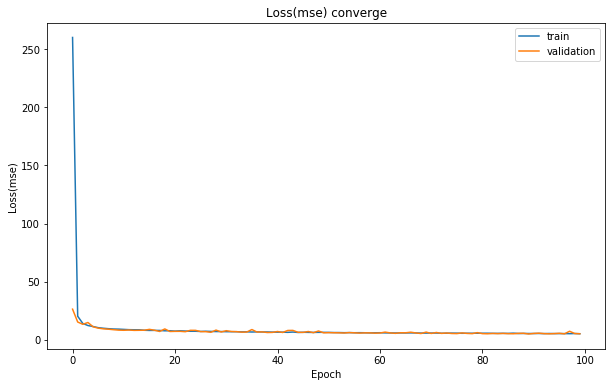

In [32]:
model_MC, result_MC = create_model(X_train, y_train)

In [45]:
import tqdm

def pred_MCdropout(model, X, y, i):
    results_MC=[]
    for _ in tqdm.tqdm(range(i)):
        results_MC.append(model.predict(X))
    results_MC = np.array(results_MC)
        
    prediction = np.mean(results_MC, axis=0)
    uncertainty = np.std(results_MC, axis=0)
    
    column_name = ['true_value', 'prediction', 'uncertainty']
    results = pd.DataFrame(columns = column_name)
    results['true_value'] = y.flatten()
    results['prediction'] = prediction
    results['error'] = results['true_value']-results['prediction']
    results['uncertainty'] = uncertainty
    sample_results = results.sample(n=150)
    fig = plt.figure(figsize = (8,8))
    results[['error']].plot(kind='hist', bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

    fig = plt.figure(figsize = (8,8))
    plt.errorbar(x=sample_results['true_value'], y=sample_results['prediction'], yerr=sample_results['uncertainty'], fmt='o')
    plt.xlabel('True value')
    plt.ylabel('Prediction')
    plt.show()
    
    results['upper_pred'] = np.percentile(results_MC, axis=0, q = 97.5)
    results['lower_pred'] = np.percentile(results_MC, axis=0, q = 2.5)
    
    results['in_95_CI'] = results.apply(lambda row: inrange(row['lower_pred'], row['upper_pred'], row['true_value']), axis = 1)
    acc = (results['in_95_CI']==True).sum()/len(results)
    print('{:.2%} actual values are in 95CI'.format(acc))
    
    r_2 = sklearn.metrics.r2_score(results['true_value'], prediction)
    adj_r_2 = 1 - (1-r_2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print("Adjusted R squared (R^2): {:.6}".format(adj_r_2))
    print("Mean squared error (MSE): {:.6}".format(sklearn.metrics.mean_squared_error(results['true_value'],prediction)))
    print("Mean absolute error (MAE): {:.6}".format(sklearn.metrics.mean_absolute_error(results['true_value'],prediction)))
    
    return results, results_MC

In [34]:
def inrange(lower, upper, true):
    if true >= lower and true <= upper:
        return True
    else:
        return False

In [11]:
model_MC = tf.keras.models.load_model('model_MC_1.h5')

100%|██████████| 100/100 [11:45<00:00,  7.20s/it]


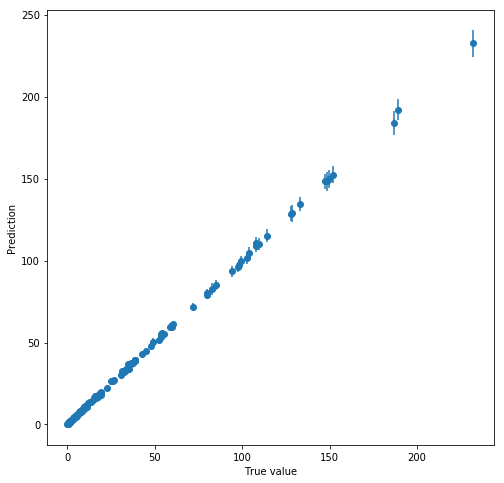

97.96% actual values are in 95CI
Adjusted R squared (R^2): 0.999776
Mean squared error (MSE): 0.537995
Mean absolute error (MAE): 0.520213


,true_value,prediction,uncertainty,error,upper_pred,lower_pred,in_95_CI
0,0.04,0.227533,0.383032,-0.187533,0.957381,-0.332263,True
1,0.03,0.257172,0.328158,-0.227172,0.972152,-0.216405,True
2,1.25,1.418970,0.378868,-0.168970,2.100500,0.764017,True
3,77.30,78.351143,2.884918,-1.051143,82.516058,71.884028,True
4,44.50,42.471939,1.218002,2.028061,45.073863,40.330808,True
5,10.60,11.134945,0.614980,-0.534945,12.287201,9.849727,True
6,142.60,144.178207,4.870444,-1.578207,151.667303,134.393127,True
7,0.15,0.405652,0.407924,-0.255652,1.233879,-0.342721,True
8,33.50,33.587639,1.125819,-0.087639,35.874500,31.380876,True
9,17.10,17.461077,0.988643,-0.361077,19.928131,15.412344,True


In [35]:
results_df, results_array = pred_MCdropout(model_MC, X_test, y_test, 100)
results_df.head(10)

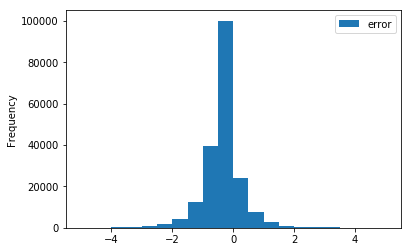

In [37]:
results_df[['error']].plot(kind='hist', bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])

In [59]:
model_MC.save('model_MC_1.h5')

## MC Dropout for in the money dataset

In [41]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM = data_minmaxscaler(ITM_df.sample(frac=0.8))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 582275 samples, validate on 64698 samples
Epoch 1/100
425216/582275 [====================>.........] - ETA: 22:37 - loss: 3621.4624 - mae: 32.54 - ETA: 3:29 - loss: 4592.8967 - mae: 35.5978 - ETA: 1:34 - loss: 4790.0748 - mae: 36.098 - ETA: 1:11 - loss: 4818.8248 - mae: 36.238 - ETA: 56s - loss: 4349.0938 - mae: 35.453 - ETA: 48s - loss: 4008.0263 - mae: 36.59 - ETA: 42s - loss: 3687.4051 - mae: 36.30 - ETA: 38s - loss: 3431.4446 - mae: 35.29 - ETA: 35s - loss: 3233.5815 - mae: 34.41 - ETA: 32s - loss: 3058.9164 - mae: 33.43 - ETA: 30s - loss: 2893.3849 - mae: 32.21 - ETA: 29s - loss: 2736.8562 - mae: 31.01 - ETA: 27s - loss: 2586.5098 - mae: 29.91 - ETA: 26s - loss: 2440.3347 - mae: 28.73 - ETA: 25s - loss: 2316.5690 - mae: 27.75 - ETA: 24s - loss: 2200.9203 - mae: 26.83 - ETA: 23s - loss: 2096.3048 - mae: 25.97 - ETA: 23s - loss: 1987.0877 - mae: 25.07 - ETA: 22s - loss: 1880.5148 - mae: 24.18 - ETA: 21s - loss: 1813.7820 - mae: 23.59 - ETA: 21s - loss: 1733.4593 - mae: 22.9

464640/582275 [======================>.......] - ETA: 15s - loss: 62.6265 - mae: 4.832 - ETA: 12s - loss: 87.3720 - mae: 5.068 - ETA: 13s - loss: 81.8636 - mae: 4.940 - ETA: 13s - loss: 76.4632 - mae: 4.820 - ETA: 13s - loss: 75.7266 - mae: 4.760 - ETA: 13s - loss: 78.0967 - mae: 4.800 - ETA: 13s - loss: 77.8537 - mae: 4.811 - ETA: 13s - loss: 77.7325 - mae: 4.806 - ETA: 13s - loss: 77.8463 - mae: 4.806 - ETA: 13s - loss: 77.1820 - mae: 4.796 - ETA: 13s - loss: 76.5020 - mae: 4.773 - ETA: 13s - loss: 76.5647 - mae: 4.766 - ETA: 13s - loss: 75.9626 - mae: 4.756 - ETA: 12s - loss: 75.8517 - mae: 4.750 - ETA: 12s - loss: 75.4714 - mae: 4.739 - ETA: 12s - loss: 76.0191 - mae: 4.735 - ETA: 12s - loss: 75.9482 - mae: 4.732 - ETA: 12s - loss: 75.9288 - mae: 4.731 - ETA: 12s - loss: 76.6582 - mae: 4.752 - ETA: 12s - loss: 76.5272 - mae: 4.748 - ETA: 12s - loss: 76.2870 - mae: 4.738 - ETA: 12s - loss: 76.5620 - mae: 4.739 - ETA: 12s - loss: 76.4729 - mae: 4.743 - ETA: 12s - loss: 76.4790 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 67.7404 - mae: 4.45 - ETA: 2s - loss: 67.7308 - mae: 4.45 - ETA: 2s - loss: 67.7230 - mae: 4.44 - ETA: 2s - loss: 67.7042 - mae: 4.44 - ETA: 2s - loss: 67.6492 - mae: 4.44 - ETA: 2s - loss: 67.6133 - mae: 4.44 - ETA: 2s - loss: 67.6784 - mae: 4.44 - ETA: 2s - loss: 67.6163 - mae: 4.44 - ETA: 2s - loss: 67.6236 - mae: 4.44 - ETA: 2s - loss: 67.6391 - mae: 4.44 - ETA: 2s - loss: 67.5967 - mae: 4.44 - ETA: 2s - loss: 67.5213 - mae: 4.44 - ETA: 2s - loss: 67.4719 - mae: 4.44 - ETA: 2s - loss: 67.4037 - mae: 4.43 - ETA: 1s - loss: 67.4206 - mae: 4.43 - ETA: 1s - loss: 67.4007 - mae: 4.43 - ETA: 1s - loss: 67.3804 - mae: 4.43 - ETA: 1s - loss: 67.3220 - mae: 4.43 - ETA: 1s - loss: 67.2873 - mae: 4.43 - ETA: 1s - loss: 67.2382 - mae: 4.43 - ETA: 1s - loss: 67.2117 - mae: 4.43 - ETA: 1s - loss: 67.1839 - mae: 4.43 - ETA: 1s - loss: 67.1622 - mae: 4.43 - ETA: 1s - loss: 67.1225 - mae: 4.42 - ETA: 1s - loss: 67.0781 - mae: 4.42 - E

456704/582275 [======================>.......] - ETA: 18s - loss: 80.2665 - mae: 4.557 - ETA: 14s - loss: 51.6792 - mae: 3.821 - ETA: 13s - loss: 51.0064 - mae: 3.724 - ETA: 13s - loss: 54.3756 - mae: 3.881 - ETA: 13s - loss: 54.2981 - mae: 3.886 - ETA: 13s - loss: 56.6629 - mae: 3.861 - ETA: 14s - loss: 58.4534 - mae: 3.889 - ETA: 14s - loss: 59.0123 - mae: 3.931 - ETA: 14s - loss: 58.7498 - mae: 3.963 - ETA: 14s - loss: 58.6153 - mae: 3.959 - ETA: 14s - loss: 57.8156 - mae: 3.940 - ETA: 14s - loss: 57.4844 - mae: 3.934 - ETA: 13s - loss: 56.5784 - mae: 3.925 - ETA: 13s - loss: 57.1613 - mae: 3.946 - ETA: 13s - loss: 57.1630 - mae: 3.945 - ETA: 13s - loss: 57.3763 - mae: 3.957 - ETA: 13s - loss: 57.5321 - mae: 3.969 - ETA: 12s - loss: 57.0303 - mae: 3.964 - ETA: 12s - loss: 56.6828 - mae: 3.954 - ETA: 12s - loss: 57.7158 - mae: 3.973 - ETA: 12s - loss: 57.5981 - mae: 3.977 - ETA: 12s - loss: 57.3902 - mae: 3.984 - ETA: 12s - loss: 57.0856 - mae: 3.980 - ETA: 12s - loss: 57.0878 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 51.9714 - mae: 3.88 - ETA: 2s - loss: 51.9245 - mae: 3.88 - ETA: 2s - loss: 51.9659 - mae: 3.88 - ETA: 2s - loss: 51.9418 - mae: 3.88 - ETA: 2s - loss: 51.9138 - mae: 3.88 - ETA: 2s - loss: 51.8834 - mae: 3.87 - ETA: 2s - loss: 51.8617 - mae: 3.87 - ETA: 2s - loss: 51.8701 - mae: 3.87 - ETA: 2s - loss: 51.8963 - mae: 3.87 - ETA: 2s - loss: 51.9265 - mae: 3.87 - ETA: 2s - loss: 52.0018 - mae: 3.88 - ETA: 2s - loss: 51.9907 - mae: 3.88 - ETA: 2s - loss: 51.9779 - mae: 3.87 - ETA: 2s - loss: 51.9780 - mae: 3.88 - ETA: 2s - loss: 51.9618 - mae: 3.87 - ETA: 2s - loss: 51.9521 - mae: 3.87 - ETA: 2s - loss: 51.9574 - mae: 3.87 - ETA: 2s - loss: 51.9230 - mae: 3.87 - ETA: 1s - loss: 51.8911 - mae: 3.87 - ETA: 1s - loss: 51.9031 - mae: 3.87 - ETA: 1s - loss: 51.9090 - mae: 3.87 - ETA: 1s - loss: 51.8612 - mae: 3.87 - ETA: 1s - loss: 51.8406 - mae: 3.87 - ETA: 1s - loss: 51.8521 - mae: 3.87 - ETA: 1s - loss: 51.8518 - mae: 3.87 - E

529920/582275 [==========================>...] - ETA: 15s - loss: 50.2418 - mae: 3.929 - ETA: 13s - loss: 56.1184 - mae: 3.837 - ETA: 12s - loss: 56.1715 - mae: 3.857 - ETA: 12s - loss: 50.9568 - mae: 3.740 - ETA: 12s - loss: 49.4185 - mae: 3.722 - ETA: 12s - loss: 47.5054 - mae: 3.677 - ETA: 12s - loss: 48.4130 - mae: 3.685 - ETA: 12s - loss: 48.9433 - mae: 3.703 - ETA: 12s - loss: 48.8644 - mae: 3.704 - ETA: 12s - loss: 48.9417 - mae: 3.719 - ETA: 12s - loss: 48.9238 - mae: 3.724 - ETA: 11s - loss: 49.1730 - mae: 3.731 - ETA: 11s - loss: 48.7433 - mae: 3.711 - ETA: 11s - loss: 49.2481 - mae: 3.725 - ETA: 11s - loss: 49.0816 - mae: 3.727 - ETA: 11s - loss: 49.4376 - mae: 3.736 - ETA: 11s - loss: 49.3785 - mae: 3.735 - ETA: 11s - loss: 49.3307 - mae: 3.732 - ETA: 11s - loss: 49.2186 - mae: 3.734 - ETA: 11s - loss: 48.9978 - mae: 3.729 - ETA: 11s - loss: 49.0459 - mae: 3.730 - ETA: 11s - loss: 48.5335 - mae: 3.717 - ETA: 11s - loss: 48.3430 - mae: 3.707 - ETA: 11s - loss: 48.1101 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 47.4070 - mae: 3.68 - ETA: 1s - loss: 47.4151 - mae: 3.68 - ETA: 0s - loss: 47.4133 - mae: 3.68 - ETA: 0s - loss: 47.4069 - mae: 3.68 - ETA: 0s - loss: 47.3713 - mae: 3.68 - ETA: 0s - loss: 47.3510 - mae: 3.68 - ETA: 0s - loss: 47.3366 - mae: 3.68 - ETA: 0s - loss: 47.3505 - mae: 3.68 - ETA: 0s - loss: 47.3347 - mae: 3.68 - ETA: 0s - loss: 47.3124 - mae: 3.68 - ETA: 0s - loss: 47.3265 - mae: 3.68 - ETA: 0s - loss: 47.3283 - mae: 3.68 - ETA: 0s - loss: 47.3026 - mae: 3.67 - ETA: 0s - loss: 47.2850 - mae: 3.67 - ETA: 0s - loss: 47.2521 - mae: 3.67 - ETA: 0s - loss: 47.2350 - mae: 3.67 - ETA: 0s - loss: 47.2168 - mae: 3.67 - ETA: 0s - loss: 47.2309 - mae: 3.67 - ETA: 0s - loss: 47.2005 - mae: 3.67 - ETA: 0s - loss: 47.1716 - mae: 3.67 - ETA: 0s - loss: 47.1639 - mae: 3.67 - 13s 23us/sample - loss: 47.1570 - mae: 3.6748 - val_loss: 47.0568 - val_mae: 3.6420
Epoch 7/100
534272/582275 [==========================>...] - ETA: 13s

524544/582275 [==========================>...] - ETA: 15s - loss: 39.9175 - mae: 3.241 - ETA: 12s - loss: 38.6042 - mae: 3.411 - ETA: 13s - loss: 45.2277 - mae: 3.569 - ETA: 12s - loss: 46.4644 - mae: 3.600 - ETA: 12s - loss: 46.2153 - mae: 3.620 - ETA: 12s - loss: 46.9955 - mae: 3.649 - ETA: 12s - loss: 46.7766 - mae: 3.632 - ETA: 12s - loss: 46.1449 - mae: 3.621 - ETA: 12s - loss: 45.4281 - mae: 3.601 - ETA: 12s - loss: 45.9206 - mae: 3.603 - ETA: 12s - loss: 46.1665 - mae: 3.614 - ETA: 12s - loss: 45.5651 - mae: 3.599 - ETA: 12s - loss: 45.5953 - mae: 3.596 - ETA: 11s - loss: 45.8435 - mae: 3.602 - ETA: 11s - loss: 45.6978 - mae: 3.597 - ETA: 11s - loss: 45.5064 - mae: 3.590 - ETA: 11s - loss: 45.3819 - mae: 3.585 - ETA: 11s - loss: 45.6612 - mae: 3.593 - ETA: 11s - loss: 45.8474 - mae: 3.597 - ETA: 11s - loss: 46.1316 - mae: 3.601 - ETA: 11s - loss: 46.4239 - mae: 3.608 - ETA: 11s - loss: 46.6429 - mae: 3.626 - ETA: 11s - loss: 46.7872 - mae: 3.631 - ETA: 11s - loss: 46.5895 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 45.4288 - mae: 3.60 - ETA: 1s - loss: 45.4381 - mae: 3.60 - ETA: 1s - loss: 45.4283 - mae: 3.60 - ETA: 1s - loss: 45.4090 - mae: 3.60 - ETA: 0s - loss: 45.4014 - mae: 3.59 - ETA: 0s - loss: 45.4040 - mae: 3.60 - ETA: 0s - loss: 45.3907 - mae: 3.59 - ETA: 0s - loss: 45.3939 - mae: 3.59 - ETA: 0s - loss: 45.4014 - mae: 3.59 - ETA: 0s - loss: 45.3934 - mae: 3.59 - ETA: 0s - loss: 45.4350 - mae: 3.59 - ETA: 0s - loss: 45.4541 - mae: 3.59 - ETA: 0s - loss: 45.4493 - mae: 3.59 - ETA: 0s - loss: 45.4336 - mae: 3.59 - ETA: 0s - loss: 45.4312 - mae: 3.59 - ETA: 0s - loss: 45.4160 - mae: 3.59 - ETA: 0s - loss: 45.4218 - mae: 3.59 - ETA: 0s - loss: 45.4242 - mae: 3.59 - ETA: 0s - loss: 45.4139 - mae: 3.59 - ETA: 0s - loss: 45.4140 - mae: 3.59 - ETA: 0s - loss: 45.4328 - mae: 3.59 - ETA: 0s - loss: 45.4290 - mae: 3.59 - ETA: 0s - loss: 45.4475 - mae: 3.59 - 13s 23us/sample - loss: 45.4483 - mae: 3.6000 - val_loss: 50.5440 - val_mae: 

489216/582275 [========================>.....] - ETA: 15s - loss: 49.6576 - mae: 3.686 - ETA: 12s - loss: 41.4761 - mae: 3.439 - ETA: 13s - loss: 42.7229 - mae: 3.479 - ETA: 13s - loss: 42.6759 - mae: 3.515 - ETA: 12s - loss: 43.0744 - mae: 3.558 - ETA: 12s - loss: 43.4433 - mae: 3.568 - ETA: 12s - loss: 43.7673 - mae: 3.575 - ETA: 13s - loss: 43.0811 - mae: 3.559 - ETA: 12s - loss: 42.6552 - mae: 3.559 - ETA: 12s - loss: 42.8212 - mae: 3.565 - ETA: 12s - loss: 43.5704 - mae: 3.576 - ETA: 12s - loss: 43.5374 - mae: 3.572 - ETA: 12s - loss: 43.8924 - mae: 3.575 - ETA: 12s - loss: 43.6241 - mae: 3.571 - ETA: 12s - loss: 43.5087 - mae: 3.563 - ETA: 12s - loss: 43.6717 - mae: 3.562 - ETA: 12s - loss: 43.7775 - mae: 3.560 - ETA: 12s - loss: 44.1049 - mae: 3.561 - ETA: 12s - loss: 44.1997 - mae: 3.562 - ETA: 12s - loss: 43.9687 - mae: 3.564 - ETA: 11s - loss: 43.8072 - mae: 3.566 - ETA: 11s - loss: 44.2214 - mae: 3.570 - ETA: 11s - loss: 43.9809 - mae: 3.567 - ETA: 11s - loss: 44.2282 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 43.7565 - mae: 3.55 - ETA: 2s - loss: 43.7385 - mae: 3.55 - ETA: 1s - loss: 43.7577 - mae: 3.55 - ETA: 1s - loss: 43.7660 - mae: 3.55 - ETA: 1s - loss: 43.7728 - mae: 3.55 - ETA: 1s - loss: 43.7692 - mae: 3.55 - ETA: 1s - loss: 43.7448 - mae: 3.55 - ETA: 1s - loss: 43.7749 - mae: 3.55 - ETA: 1s - loss: 43.7690 - mae: 3.55 - ETA: 1s - loss: 43.7541 - mae: 3.55 - ETA: 1s - loss: 43.7261 - mae: 3.55 - ETA: 1s - loss: 43.6959 - mae: 3.55 - ETA: 1s - loss: 43.6787 - mae: 3.54 - ETA: 1s - loss: 43.6569 - mae: 3.54 - ETA: 1s - loss: 43.6406 - mae: 3.54 - ETA: 1s - loss: 43.6244 - mae: 3.54 - ETA: 1s - loss: 43.6215 - mae: 3.54 - ETA: 1s - loss: 43.6111 - mae: 3.54 - ETA: 1s - loss: 43.6002 - mae: 3.54 - ETA: 1s - loss: 43.6128 - mae: 3.54 - ETA: 1s - loss: 43.5899 - mae: 3.54 - ETA: 1s - loss: 43.5925 - mae: 3.54 - ETA: 0s - loss: 43.5784 - mae: 3.54 - ETA: 0s - loss: 43.5808 - mae: 3.54 - ETA: 0s - loss: 43.6026 - mae: 3.54 - E

499456/582275 [========================>.....] - ETA: 15s - loss: 37.2121 - mae: 3.476 - ETA: 13s - loss: 38.0587 - mae: 3.358 - ETA: 12s - loss: 39.7495 - mae: 3.388 - ETA: 12s - loss: 42.9691 - mae: 3.443 - ETA: 13s - loss: 42.6771 - mae: 3.434 - ETA: 13s - loss: 42.9274 - mae: 3.457 - ETA: 13s - loss: 43.6749 - mae: 3.485 - ETA: 13s - loss: 43.3129 - mae: 3.486 - ETA: 13s - loss: 42.4521 - mae: 3.472 - ETA: 13s - loss: 42.5104 - mae: 3.484 - ETA: 13s - loss: 42.5321 - mae: 3.494 - ETA: 12s - loss: 42.9322 - mae: 3.497 - ETA: 12s - loss: 42.8006 - mae: 3.486 - ETA: 12s - loss: 43.0269 - mae: 3.492 - ETA: 12s - loss: 42.7947 - mae: 3.488 - ETA: 12s - loss: 42.6128 - mae: 3.485 - ETA: 12s - loss: 42.6244 - mae: 3.488 - ETA: 12s - loss: 42.6665 - mae: 3.495 - ETA: 12s - loss: 42.9745 - mae: 3.493 - ETA: 12s - loss: 43.2791 - mae: 3.496 - ETA: 11s - loss: 43.2971 - mae: 3.493 - ETA: 11s - loss: 43.2273 - mae: 3.492 - ETA: 11s - loss: 43.3832 - mae: 3.489 - ETA: 11s - loss: 43.0948 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 42.5538 - mae: 3.48 - ETA: 1s - loss: 42.5872 - mae: 3.48 - ETA: 1s - loss: 42.5905 - mae: 3.48 - ETA: 1s - loss: 42.5905 - mae: 3.48 - ETA: 1s - loss: 42.5779 - mae: 3.48 - ETA: 1s - loss: 42.6058 - mae: 3.48 - ETA: 1s - loss: 42.5817 - mae: 3.48 - ETA: 1s - loss: 42.5768 - mae: 3.48 - ETA: 1s - loss: 42.5720 - mae: 3.48 - ETA: 1s - loss: 42.5623 - mae: 3.48 - ETA: 1s - loss: 42.5548 - mae: 3.48 - ETA: 1s - loss: 42.5512 - mae: 3.48 - ETA: 1s - loss: 42.5218 - mae: 3.48 - ETA: 1s - loss: 42.5103 - mae: 3.48 - ETA: 1s - loss: 42.5117 - mae: 3.48 - ETA: 0s - loss: 42.5158 - mae: 3.48 - ETA: 0s - loss: 42.5021 - mae: 3.48 - ETA: 0s - loss: 42.5322 - mae: 3.48 - ETA: 0s - loss: 42.6145 - mae: 3.48 - ETA: 0s - loss: 42.6491 - mae: 3.48 - ETA: 0s - loss: 42.6233 - mae: 3.48 - ETA: 0s - loss: 42.5976 - mae: 3.48 - ETA: 0s - loss: 42.5946 - mae: 3.48 - ETA: 0s - loss: 42.5617 - mae: 3.48 - ETA: 0s - loss: 42.5547 - mae: 3.48 - E

523520/582275 [=========================>....] - ETA: 13s - loss: 50.3220 - mae: 3.695 - ETA: 11s - loss: 38.1833 - mae: 3.349 - ETA: 11s - loss: 40.6126 - mae: 3.360 - ETA: 11s - loss: 42.7690 - mae: 3.448 - ETA: 11s - loss: 41.9294 - mae: 3.478 - ETA: 11s - loss: 42.6231 - mae: 3.500 - ETA: 11s - loss: 43.0461 - mae: 3.500 - ETA: 11s - loss: 42.3250 - mae: 3.489 - ETA: 11s - loss: 42.1704 - mae: 3.485 - ETA: 11s - loss: 41.9002 - mae: 3.473 - ETA: 11s - loss: 41.5407 - mae: 3.466 - ETA: 11s - loss: 41.7201 - mae: 3.474 - ETA: 11s - loss: 41.5302 - mae: 3.466 - ETA: 11s - loss: 41.5496 - mae: 3.467 - ETA: 11s - loss: 41.4654 - mae: 3.465 - ETA: 11s - loss: 41.4092 - mae: 3.464 - ETA: 11s - loss: 41.2580 - mae: 3.462 - ETA: 11s - loss: 40.9917 - mae: 3.449 - ETA: 11s - loss: 40.6299 - mae: 3.439 - ETA: 11s - loss: 40.5039 - mae: 3.441 - ETA: 11s - loss: 40.2586 - mae: 3.433 - ETA: 11s - loss: 40.2806 - mae: 3.433 - ETA: 11s - loss: 40.7723 - mae: 3.443 - ETA: 11s - loss: 41.1252 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 41.2450 - mae: 3.44 - ETA: 1s - loss: 41.2456 - mae: 3.44 - ETA: 1s - loss: 41.2401 - mae: 3.44 - ETA: 1s - loss: 41.2364 - mae: 3.44 - ETA: 0s - loss: 41.2212 - mae: 3.44 - ETA: 0s - loss: 41.2344 - mae: 3.44 - ETA: 0s - loss: 41.2196 - mae: 3.44 - ETA: 0s - loss: 41.2356 - mae: 3.44 - ETA: 0s - loss: 41.2257 - mae: 3.44 - ETA: 0s - loss: 41.2162 - mae: 3.44 - ETA: 0s - loss: 41.2008 - mae: 3.44 - ETA: 0s - loss: 41.1974 - mae: 3.44 - ETA: 0s - loss: 41.1777 - mae: 3.44 - ETA: 0s - loss: 41.1347 - mae: 3.44 - ETA: 0s - loss: 41.1426 - mae: 3.44 - ETA: 0s - loss: 41.1070 - mae: 3.44 - ETA: 0s - loss: 41.1049 - mae: 3.44 - ETA: 0s - loss: 41.1042 - mae: 3.44 - ETA: 0s - loss: 41.1013 - mae: 3.44 - ETA: 0s - loss: 41.1157 - mae: 3.44 - ETA: 0s - loss: 41.1134 - mae: 3.44 - ETA: 0s - loss: 41.0966 - mae: 3.44 - ETA: 0s - loss: 41.0964 - mae: 3.44 - 13s 23us/sample - loss: 41.0977 - mae: 3.4413 - val_loss: 40.2044 - val_mae: 

527104/582275 [==========================>...] - ETA: 15s - loss: 29.1122 - mae: 2.944 - ETA: 12s - loss: 49.5611 - mae: 3.541 - ETA: 12s - loss: 44.7448 - mae: 3.512 - ETA: 11s - loss: 43.1551 - mae: 3.466 - ETA: 11s - loss: 41.9006 - mae: 3.446 - ETA: 11s - loss: 41.8756 - mae: 3.443 - ETA: 11s - loss: 41.4222 - mae: 3.457 - ETA: 11s - loss: 41.5985 - mae: 3.479 - ETA: 11s - loss: 41.7900 - mae: 3.466 - ETA: 11s - loss: 41.6660 - mae: 3.469 - ETA: 11s - loss: 41.4963 - mae: 3.455 - ETA: 11s - loss: 42.3705 - mae: 3.461 - ETA: 11s - loss: 42.2581 - mae: 3.456 - ETA: 11s - loss: 42.2101 - mae: 3.457 - ETA: 11s - loss: 42.2221 - mae: 3.465 - ETA: 11s - loss: 42.2502 - mae: 3.470 - ETA: 11s - loss: 42.1827 - mae: 3.468 - ETA: 11s - loss: 42.2944 - mae: 3.477 - ETA: 11s - loss: 42.0402 - mae: 3.472 - ETA: 11s - loss: 41.9673 - mae: 3.472 - ETA: 11s - loss: 42.3022 - mae: 3.482 - ETA: 11s - loss: 42.2826 - mae: 3.482 - ETA: 11s - loss: 42.0819 - mae: 3.479 - ETA: 10s - loss: 42.1255 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 40.4321 - mae: 3.43 - ETA: 1s - loss: 40.4044 - mae: 3.43 - ETA: 1s - loss: 40.3955 - mae: 3.42 - ETA: 0s - loss: 40.4168 - mae: 3.43 - ETA: 0s - loss: 40.4077 - mae: 3.42 - ETA: 0s - loss: 40.4050 - mae: 3.42 - ETA: 0s - loss: 40.4327 - mae: 3.43 - ETA: 0s - loss: 40.4479 - mae: 3.43 - ETA: 0s - loss: 40.4821 - mae: 3.43 - ETA: 0s - loss: 40.5267 - mae: 3.43 - ETA: 0s - loss: 40.5432 - mae: 3.43 - ETA: 0s - loss: 40.5603 - mae: 3.43 - ETA: 0s - loss: 40.5406 - mae: 3.43 - ETA: 0s - loss: 40.5316 - mae: 3.43 - ETA: 0s - loss: 40.5169 - mae: 3.43 - ETA: 0s - loss: 40.5125 - mae: 3.43 - ETA: 0s - loss: 40.5101 - mae: 3.43 - ETA: 0s - loss: 40.5050 - mae: 3.43 - ETA: 0s - loss: 40.4741 - mae: 3.43 - ETA: 0s - loss: 40.4492 - mae: 3.43 - ETA: 0s - loss: 40.4380 - mae: 3.43 - 13s 23us/sample - loss: 40.4265 - mae: 3.4307 - val_loss: 39.5212 - val_mae: 3.3689
Epoch 17/100
521216/582275 [=========================>....] - ETA: 13

521472/582275 [=========================>....] - ETA: 13s - loss: 36.4200 - mae: 3.466 - ETA: 12s - loss: 38.5854 - mae: 3.403 - ETA: 12s - loss: 40.9111 - mae: 3.498 - ETA: 12s - loss: 39.5865 - mae: 3.475 - ETA: 12s - loss: 39.1023 - mae: 3.452 - ETA: 11s - loss: 39.8112 - mae: 3.459 - ETA: 11s - loss: 39.5746 - mae: 3.456 - ETA: 11s - loss: 39.4096 - mae: 3.454 - ETA: 11s - loss: 39.6181 - mae: 3.460 - ETA: 11s - loss: 39.3358 - mae: 3.452 - ETA: 11s - loss: 39.1292 - mae: 3.438 - ETA: 11s - loss: 39.6667 - mae: 3.451 - ETA: 11s - loss: 39.9297 - mae: 3.452 - ETA: 11s - loss: 39.5512 - mae: 3.445 - ETA: 11s - loss: 39.2450 - mae: 3.432 - ETA: 11s - loss: 39.3071 - mae: 3.431 - ETA: 11s - loss: 39.2882 - mae: 3.431 - ETA: 11s - loss: 39.1969 - mae: 3.421 - ETA: 10s - loss: 39.1972 - mae: 3.425 - ETA: 10s - loss: 39.2801 - mae: 3.429 - ETA: 10s - loss: 39.6727 - mae: 3.434 - ETA: 10s - loss: 39.5125 - mae: 3.431 - ETA: 10s - loss: 39.5554 - mae: 3.434 - ETA: 10s - loss: 39.5895 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 39.5141 - mae: 3.42 - ETA: 1s - loss: 39.5032 - mae: 3.42 - ETA: 1s - loss: 39.5028 - mae: 3.42 - ETA: 1s - loss: 39.4842 - mae: 3.42 - ETA: 1s - loss: 39.4644 - mae: 3.42 - ETA: 0s - loss: 39.4817 - mae: 3.42 - ETA: 0s - loss: 39.4769 - mae: 3.42 - ETA: 0s - loss: 39.4757 - mae: 3.42 - ETA: 0s - loss: 39.4822 - mae: 3.42 - ETA: 0s - loss: 39.4907 - mae: 3.42 - ETA: 0s - loss: 39.4665 - mae: 3.42 - ETA: 0s - loss: 39.4588 - mae: 3.42 - ETA: 0s - loss: 39.4556 - mae: 3.42 - ETA: 0s - loss: 39.4377 - mae: 3.42 - ETA: 0s - loss: 39.4483 - mae: 3.42 - ETA: 0s - loss: 39.4436 - mae: 3.42 - ETA: 0s - loss: 39.4224 - mae: 3.42 - ETA: 0s - loss: 39.4278 - mae: 3.42 - ETA: 0s - loss: 39.4358 - mae: 3.42 - ETA: 0s - loss: 39.4204 - mae: 3.42 - ETA: 0s - loss: 39.4153 - mae: 3.42 - ETA: 0s - loss: 39.4325 - mae: 3.42 - ETA: 0s - loss: 39.4514 - mae: 3.42 - ETA: 0s - loss: 39.4574 - mae: 3.42 - 13s 23us/sample - loss: 39.4553 - mae: 

532480/582275 [==========================>...] - ETA: 15s - loss: 35.7984 - mae: 3.368 - ETA: 12s - loss: 41.0358 - mae: 3.546 - ETA: 12s - loss: 39.3918 - mae: 3.487 - ETA: 12s - loss: 40.0974 - mae: 3.475 - ETA: 12s - loss: 41.8589 - mae: 3.514 - ETA: 11s - loss: 41.3141 - mae: 3.508 - ETA: 11s - loss: 41.0588 - mae: 3.499 - ETA: 11s - loss: 39.9843 - mae: 3.476 - ETA: 11s - loss: 39.4577 - mae: 3.463 - ETA: 11s - loss: 39.3626 - mae: 3.448 - ETA: 11s - loss: 38.8923 - mae: 3.435 - ETA: 11s - loss: 38.7674 - mae: 3.430 - ETA: 11s - loss: 38.6180 - mae: 3.426 - ETA: 11s - loss: 38.5396 - mae: 3.422 - ETA: 11s - loss: 38.5761 - mae: 3.413 - ETA: 11s - loss: 38.0351 - mae: 3.396 - ETA: 11s - loss: 38.2274 - mae: 3.402 - ETA: 11s - loss: 37.9279 - mae: 3.388 - ETA: 11s - loss: 37.9225 - mae: 3.386 - ETA: 11s - loss: 37.5668 - mae: 3.373 - ETA: 11s - loss: 37.7877 - mae: 3.379 - ETA: 11s - loss: 37.6645 - mae: 3.374 - ETA: 11s - loss: 37.8597 - mae: 3.380 - ETA: 10s - loss: 38.0799 - mae:

582275/582275 [==============================] - ETA: 0s - loss: 38.9235 - mae: 3.41 - ETA: 0s - loss: 38.9386 - mae: 3.41 - ETA: 0s - loss: 38.9221 - mae: 3.41 - ETA: 0s - loss: 38.9041 - mae: 3.41 - ETA: 0s - loss: 38.8995 - mae: 3.41 - ETA: 0s - loss: 38.8788 - mae: 3.41 - ETA: 0s - loss: 38.9079 - mae: 3.41 - ETA: 0s - loss: 38.8994 - mae: 3.41 - ETA: 0s - loss: 38.8710 - mae: 3.41 - ETA: 0s - loss: 38.8800 - mae: 3.41 - ETA: 0s - loss: 38.8795 - mae: 3.41 - ETA: 0s - loss: 38.8912 - mae: 3.41 - ETA: 0s - loss: 38.8910 - mae: 3.41 - ETA: 0s - loss: 38.8856 - mae: 3.41 - ETA: 0s - loss: 38.9133 - mae: 3.41 - ETA: 0s - loss: 38.9467 - mae: 3.41 - ETA: 0s - loss: 38.9423 - mae: 3.41 - ETA: 0s - loss: 38.9317 - mae: 3.41 - ETA: 0s - loss: 38.9199 - mae: 3.41 - ETA: 0s - loss: 38.9483 - mae: 3.41 - 13s 22us/sample - loss: 38.9488 - mae: 3.4193 - val_loss: 38.1723 - val_mae: 3.4029
Epoch 21/100
517120/582275 [=========================>....] - ETA: 15s - loss: 45.4319 - mae: 3.815 - ETA: 

535808/582275 [==========================>...] - ETA: 13s - loss: 33.8634 - mae: 3.468 - ETA: 11s - loss: 39.0906 - mae: 3.493 - ETA: 11s - loss: 39.8322 - mae: 3.517 - ETA: 11s - loss: 39.6892 - mae: 3.475 - ETA: 11s - loss: 38.4466 - mae: 3.410 - ETA: 11s - loss: 38.3683 - mae: 3.410 - ETA: 11s - loss: 37.7321 - mae: 3.386 - ETA: 11s - loss: 38.0563 - mae: 3.407 - ETA: 11s - loss: 37.4946 - mae: 3.393 - ETA: 11s - loss: 37.5762 - mae: 3.406 - ETA: 11s - loss: 36.8874 - mae: 3.384 - ETA: 11s - loss: 37.0637 - mae: 3.378 - ETA: 11s - loss: 36.7175 - mae: 3.371 - ETA: 11s - loss: 36.7830 - mae: 3.370 - ETA: 11s - loss: 36.6487 - mae: 3.360 - ETA: 11s - loss: 36.9399 - mae: 3.373 - ETA: 11s - loss: 37.2554 - mae: 3.378 - ETA: 11s - loss: 37.3661 - mae: 3.382 - ETA: 10s - loss: 37.3163 - mae: 3.380 - ETA: 10s - loss: 37.2292 - mae: 3.380 - ETA: 10s - loss: 37.4720 - mae: 3.386 - ETA: 10s - loss: 37.6495 - mae: 3.393 - ETA: 10s - loss: 37.4906 - mae: 3.385 - ETA: 10s - loss: 37.4100 - mae:

582275/582275 [==============================] - ETA: 0s - loss: 38.0064 - mae: 3.39 - ETA: 0s - loss: 38.0018 - mae: 3.39 - ETA: 0s - loss: 38.0041 - mae: 3.39 - ETA: 0s - loss: 37.9723 - mae: 3.39 - ETA: 0s - loss: 37.9789 - mae: 3.39 - ETA: 0s - loss: 37.9710 - mae: 3.39 - ETA: 0s - loss: 37.9650 - mae: 3.39 - ETA: 0s - loss: 37.9730 - mae: 3.39 - ETA: 0s - loss: 37.9769 - mae: 3.39 - ETA: 0s - loss: 37.9872 - mae: 3.39 - ETA: 0s - loss: 37.9816 - mae: 3.39 - ETA: 0s - loss: 38.0178 - mae: 3.39 - ETA: 0s - loss: 38.0193 - mae: 3.39 - ETA: 0s - loss: 38.0091 - mae: 3.39 - ETA: 0s - loss: 38.0086 - mae: 3.39 - ETA: 0s - loss: 38.0166 - mae: 3.39 - ETA: 0s - loss: 38.0152 - mae: 3.39 - ETA: 0s - loss: 37.9988 - mae: 3.39 - 13s 22us/sample - loss: 37.9967 - mae: 3.3944 - val_loss: 38.1771 - val_mae: 3.3930
Epoch 23/100
524288/582275 [==========================>...] - ETA: 20s - loss: 32.3824 - mae: 3.277 - ETA: 14s - loss: 34.0159 - mae: 3.359 - ETA: 13s - loss: 36.4796 - mae: 3.345 - E

502016/582275 [========================>.....] - ETA: 20s - loss: 48.8257 - mae: 3.527 - ETA: 13s - loss: 38.9340 - mae: 3.487 - ETA: 13s - loss: 37.1759 - mae: 3.460 - ETA: 13s - loss: 36.8938 - mae: 3.438 - ETA: 12s - loss: 37.3016 - mae: 3.407 - ETA: 12s - loss: 38.2358 - mae: 3.417 - ETA: 12s - loss: 37.1439 - mae: 3.396 - ETA: 12s - loss: 37.3717 - mae: 3.402 - ETA: 12s - loss: 37.7574 - mae: 3.410 - ETA: 12s - loss: 37.9630 - mae: 3.413 - ETA: 12s - loss: 37.4231 - mae: 3.405 - ETA: 12s - loss: 37.7042 - mae: 3.416 - ETA: 12s - loss: 37.4098 - mae: 3.404 - ETA: 12s - loss: 37.6740 - mae: 3.410 - ETA: 12s - loss: 37.4799 - mae: 3.410 - ETA: 12s - loss: 37.5290 - mae: 3.407 - ETA: 12s - loss: 37.2285 - mae: 3.400 - ETA: 11s - loss: 37.0760 - mae: 3.396 - ETA: 11s - loss: 37.1648 - mae: 3.393 - ETA: 11s - loss: 37.0648 - mae: 3.394 - ETA: 11s - loss: 37.0137 - mae: 3.399 - ETA: 11s - loss: 36.9769 - mae: 3.400 - ETA: 11s - loss: 37.2396 - mae: 3.403 - ETA: 11s - loss: 37.2662 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 37.8152 - mae: 3.41 - ETA: 1s - loss: 37.8146 - mae: 3.41 - ETA: 1s - loss: 37.8153 - mae: 3.41 - ETA: 1s - loss: 37.8095 - mae: 3.41 - ETA: 1s - loss: 37.7997 - mae: 3.41 - ETA: 1s - loss: 37.7833 - mae: 3.41 - ETA: 1s - loss: 37.7791 - mae: 3.41 - ETA: 1s - loss: 37.7537 - mae: 3.41 - ETA: 1s - loss: 37.7420 - mae: 3.41 - ETA: 1s - loss: 37.7380 - mae: 3.41 - ETA: 1s - loss: 37.7523 - mae: 3.41 - ETA: 1s - loss: 37.7733 - mae: 3.41 - ETA: 1s - loss: 37.7655 - mae: 3.41 - ETA: 0s - loss: 37.7653 - mae: 3.41 - ETA: 0s - loss: 37.7549 - mae: 3.41 - ETA: 0s - loss: 37.7596 - mae: 3.41 - ETA: 0s - loss: 37.7704 - mae: 3.41 - ETA: 0s - loss: 37.7644 - mae: 3.41 - ETA: 0s - loss: 37.7391 - mae: 3.41 - ETA: 0s - loss: 37.7193 - mae: 3.41 - ETA: 0s - loss: 37.7201 - mae: 3.41 - ETA: 0s - loss: 37.7571 - mae: 3.41 - ETA: 0s - loss: 37.7948 - mae: 3.41 - ETA: 0s - loss: 37.8120 - mae: 3.41 - ETA: 0s - loss: 37.8229 - mae: 3.41 - E

506368/582275 [=========================>....] - ETA: 13s - loss: 33.3343 - mae: 3.320 - ETA: 12s - loss: 37.3702 - mae: 3.352 - ETA: 12s - loss: 38.3356 - mae: 3.391 - ETA: 12s - loss: 38.7339 - mae: 3.392 - ETA: 12s - loss: 41.2451 - mae: 3.428 - ETA: 11s - loss: 40.0638 - mae: 3.407 - ETA: 11s - loss: 39.7115 - mae: 3.384 - ETA: 11s - loss: 39.5192 - mae: 3.388 - ETA: 11s - loss: 39.0791 - mae: 3.382 - ETA: 11s - loss: 38.7663 - mae: 3.376 - ETA: 11s - loss: 38.9887 - mae: 3.389 - ETA: 11s - loss: 38.6500 - mae: 3.392 - ETA: 11s - loss: 38.1074 - mae: 3.386 - ETA: 11s - loss: 38.1946 - mae: 3.387 - ETA: 11s - loss: 38.1193 - mae: 3.388 - ETA: 11s - loss: 37.9033 - mae: 3.386 - ETA: 11s - loss: 37.9552 - mae: 3.390 - ETA: 11s - loss: 37.4921 - mae: 3.377 - ETA: 11s - loss: 37.2631 - mae: 3.372 - ETA: 11s - loss: 37.4730 - mae: 3.383 - ETA: 11s - loss: 37.5239 - mae: 3.387 - ETA: 11s - loss: 37.4587 - mae: 3.383 - ETA: 11s - loss: 37.2159 - mae: 3.376 - ETA: 11s - loss: 37.1294 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 37.1923 - mae: 3.38 - ETA: 1s - loss: 37.2272 - mae: 3.39 - ETA: 1s - loss: 37.2166 - mae: 3.39 - ETA: 1s - loss: 37.1954 - mae: 3.38 - ETA: 1s - loss: 37.2099 - mae: 3.39 - ETA: 1s - loss: 37.2093 - mae: 3.39 - ETA: 1s - loss: 37.2125 - mae: 3.39 - ETA: 1s - loss: 37.2146 - mae: 3.39 - ETA: 1s - loss: 37.2469 - mae: 3.39 - ETA: 1s - loss: 37.2473 - mae: 3.39 - ETA: 1s - loss: 37.2372 - mae: 3.39 - ETA: 1s - loss: 37.2274 - mae: 3.39 - ETA: 1s - loss: 37.2016 - mae: 3.39 - ETA: 0s - loss: 37.1961 - mae: 3.39 - ETA: 0s - loss: 37.2027 - mae: 3.39 - ETA: 0s - loss: 37.2013 - mae: 3.39 - ETA: 0s - loss: 37.2264 - mae: 3.39 - ETA: 0s - loss: 37.2116 - mae: 3.39 - ETA: 0s - loss: 37.2629 - mae: 3.39 - ETA: 0s - loss: 37.2870 - mae: 3.39 - ETA: 0s - loss: 37.3175 - mae: 3.39 - ETA: 0s - loss: 37.3299 - mae: 3.39 - ETA: 0s - loss: 37.3089 - mae: 3.39 - ETA: 0s - loss: 37.3111 - mae: 3.39 - ETA: 0s - loss: 37.3183 - mae: 3.39 - E

493056/582275 [========================>.....] - ETA: 13s - loss: 32.5006 - mae: 3.651 - ETA: 11s - loss: 35.3671 - mae: 3.403 - ETA: 11s - loss: 35.5552 - mae: 3.400 - ETA: 11s - loss: 34.5299 - mae: 3.380 - ETA: 11s - loss: 34.9707 - mae: 3.383 - ETA: 12s - loss: 36.0370 - mae: 3.390 - ETA: 12s - loss: 37.5622 - mae: 3.416 - ETA: 12s - loss: 37.5192 - mae: 3.415 - ETA: 12s - loss: 37.1145 - mae: 3.412 - ETA: 12s - loss: 36.2457 - mae: 3.382 - ETA: 12s - loss: 36.8402 - mae: 3.394 - ETA: 12s - loss: 36.7170 - mae: 3.387 - ETA: 12s - loss: 36.8289 - mae: 3.394 - ETA: 12s - loss: 36.8739 - mae: 3.398 - ETA: 12s - loss: 36.5853 - mae: 3.393 - ETA: 12s - loss: 36.6620 - mae: 3.392 - ETA: 12s - loss: 36.4247 - mae: 3.389 - ETA: 11s - loss: 36.6916 - mae: 3.393 - ETA: 11s - loss: 37.1723 - mae: 3.406 - ETA: 11s - loss: 37.5459 - mae: 3.408 - ETA: 11s - loss: 37.3613 - mae: 3.406 - ETA: 11s - loss: 37.3357 - mae: 3.407 - ETA: 11s - loss: 37.2074 - mae: 3.400 - ETA: 11s - loss: 37.0182 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 36.6102 - mae: 3.38 - ETA: 1s - loss: 36.6056 - mae: 3.38 - ETA: 1s - loss: 36.6045 - mae: 3.38 - ETA: 1s - loss: 36.6005 - mae: 3.38 - ETA: 1s - loss: 36.5774 - mae: 3.38 - ETA: 1s - loss: 36.5778 - mae: 3.38 - ETA: 1s - loss: 36.6199 - mae: 3.38 - ETA: 1s - loss: 36.6175 - mae: 3.38 - ETA: 1s - loss: 36.6256 - mae: 3.38 - ETA: 1s - loss: 36.5966 - mae: 3.38 - ETA: 1s - loss: 36.5942 - mae: 3.38 - ETA: 1s - loss: 36.6129 - mae: 3.38 - ETA: 1s - loss: 36.6314 - mae: 3.38 - ETA: 1s - loss: 36.6414 - mae: 3.38 - ETA: 1s - loss: 36.6466 - mae: 3.38 - ETA: 1s - loss: 36.6620 - mae: 3.38 - ETA: 1s - loss: 36.6803 - mae: 3.39 - ETA: 1s - loss: 36.6945 - mae: 3.38 - ETA: 1s - loss: 36.7004 - mae: 3.39 - ETA: 0s - loss: 36.6944 - mae: 3.39 - ETA: 0s - loss: 36.7080 - mae: 3.39 - ETA: 0s - loss: 36.7192 - mae: 3.39 - ETA: 0s - loss: 36.7123 - mae: 3.39 - ETA: 0s - loss: 36.7097 - mae: 3.39 - ETA: 0s - loss: 36.7091 - mae: 3.39 - E

515840/582275 [=========================>....] - ETA: 15s - loss: 27.6428 - mae: 3.249 - ETA: 11s - loss: 37.6589 - mae: 3.412 - ETA: 12s - loss: 36.4839 - mae: 3.412 - ETA: 12s - loss: 36.8675 - mae: 3.397 - ETA: 12s - loss: 36.4669 - mae: 3.368 - ETA: 11s - loss: 36.6058 - mae: 3.393 - ETA: 11s - loss: 35.9737 - mae: 3.375 - ETA: 11s - loss: 36.0969 - mae: 3.369 - ETA: 11s - loss: 35.8874 - mae: 3.370 - ETA: 11s - loss: 36.5670 - mae: 3.379 - ETA: 11s - loss: 36.9832 - mae: 3.383 - ETA: 11s - loss: 36.7534 - mae: 3.379 - ETA: 11s - loss: 36.7960 - mae: 3.384 - ETA: 11s - loss: 37.4753 - mae: 3.401 - ETA: 11s - loss: 37.6345 - mae: 3.407 - ETA: 11s - loss: 37.5702 - mae: 3.409 - ETA: 11s - loss: 37.4591 - mae: 3.408 - ETA: 11s - loss: 37.3053 - mae: 3.410 - ETA: 11s - loss: 37.2957 - mae: 3.413 - ETA: 11s - loss: 37.5441 - mae: 3.413 - ETA: 11s - loss: 37.7250 - mae: 3.421 - ETA: 11s - loss: 37.5846 - mae: 3.418 - ETA: 10s - loss: 37.5655 - mae: 3.412 - ETA: 10s - loss: 37.6276 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 36.7068 - mae: 3.38 - ETA: 1s - loss: 36.7466 - mae: 3.38 - ETA: 1s - loss: 36.7652 - mae: 3.38 - ETA: 1s - loss: 36.7534 - mae: 3.38 - ETA: 1s - loss: 36.7408 - mae: 3.38 - ETA: 1s - loss: 36.7368 - mae: 3.38 - ETA: 1s - loss: 36.7367 - mae: 3.38 - ETA: 1s - loss: 36.7515 - mae: 3.38 - ETA: 0s - loss: 36.7394 - mae: 3.38 - ETA: 0s - loss: 36.7326 - mae: 3.38 - ETA: 0s - loss: 36.7207 - mae: 3.38 - ETA: 0s - loss: 36.7326 - mae: 3.38 - ETA: 0s - loss: 36.7274 - mae: 3.38 - ETA: 0s - loss: 36.7020 - mae: 3.38 - ETA: 0s - loss: 36.6929 - mae: 3.38 - ETA: 0s - loss: 36.6877 - mae: 3.38 - ETA: 0s - loss: 36.6783 - mae: 3.37 - ETA: 0s - loss: 36.6852 - mae: 3.38 - ETA: 0s - loss: 36.7218 - mae: 3.38 - ETA: 0s - loss: 36.7438 - mae: 3.38 - ETA: 0s - loss: 36.7446 - mae: 3.38 - ETA: 0s - loss: 36.7537 - mae: 3.38 - ETA: 0s - loss: 36.7472 - mae: 3.38 - ETA: 0s - loss: 36.7370 - mae: 3.38 - ETA: 0s - loss: 36.7635 - mae: 3.38 - E

527616/582275 [==========================>...] - ETA: 18s - loss: 38.9557 - mae: 3.452 - ETA: 12s - loss: 43.7795 - mae: 3.481 - ETA: 12s - loss: 41.3927 - mae: 3.443 - ETA: 12s - loss: 38.7447 - mae: 3.398 - ETA: 11s - loss: 38.4580 - mae: 3.403 - ETA: 11s - loss: 38.2300 - mae: 3.396 - ETA: 11s - loss: 37.8295 - mae: 3.398 - ETA: 11s - loss: 37.8566 - mae: 3.421 - ETA: 11s - loss: 37.5619 - mae: 3.413 - ETA: 11s - loss: 37.2789 - mae: 3.407 - ETA: 11s - loss: 37.2372 - mae: 3.398 - ETA: 11s - loss: 37.0985 - mae: 3.387 - ETA: 11s - loss: 37.3129 - mae: 3.397 - ETA: 11s - loss: 37.2642 - mae: 3.396 - ETA: 11s - loss: 37.5466 - mae: 3.403 - ETA: 11s - loss: 37.3732 - mae: 3.396 - ETA: 11s - loss: 37.1762 - mae: 3.395 - ETA: 11s - loss: 37.3404 - mae: 3.398 - ETA: 11s - loss: 37.1130 - mae: 3.393 - ETA: 11s - loss: 37.0985 - mae: 3.395 - ETA: 11s - loss: 37.1444 - mae: 3.395 - ETA: 10s - loss: 36.8932 - mae: 3.394 - ETA: 10s - loss: 37.0953 - mae: 3.397 - ETA: 10s - loss: 36.8840 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 36.2596 - mae: 3.40 - ETA: 1s - loss: 36.2502 - mae: 3.40 - ETA: 0s - loss: 36.2412 - mae: 3.39 - ETA: 0s - loss: 36.2209 - mae: 3.39 - ETA: 0s - loss: 36.2299 - mae: 3.39 - ETA: 0s - loss: 36.2211 - mae: 3.39 - ETA: 0s - loss: 36.2020 - mae: 3.39 - ETA: 0s - loss: 36.1967 - mae: 3.39 - ETA: 0s - loss: 36.2037 - mae: 3.39 - ETA: 0s - loss: 36.2091 - mae: 3.39 - ETA: 0s - loss: 36.2130 - mae: 3.39 - ETA: 0s - loss: 36.1994 - mae: 3.39 - ETA: 0s - loss: 36.2290 - mae: 3.39 - ETA: 0s - loss: 36.2086 - mae: 3.39 - ETA: 0s - loss: 36.2155 - mae: 3.39 - ETA: 0s - loss: 36.2115 - mae: 3.39 - ETA: 0s - loss: 36.2210 - mae: 3.39 - ETA: 0s - loss: 36.2243 - mae: 3.39 - ETA: 0s - loss: 36.2275 - mae: 3.39 - ETA: 0s - loss: 36.2046 - mae: 3.39 - ETA: 0s - loss: 36.2015 - mae: 3.39 - ETA: 0s - loss: 36.2019 - mae: 3.39 - ETA: 0s - loss: 36.2242 - mae: 3.39 - 13s 23us/sample - loss: 36.2443 - mae: 3.4001 - val_loss: 36.9270 - val_mae: 

506624/582275 [=========================>....] - ETA: 15s - loss: 30.6592 - mae: 3.188 - ETA: 12s - loss: 37.3417 - mae: 3.369 - ETA: 11s - loss: 37.3999 - mae: 3.398 - ETA: 11s - loss: 36.6013 - mae: 3.366 - ETA: 11s - loss: 36.4394 - mae: 3.394 - ETA: 11s - loss: 37.6170 - mae: 3.436 - ETA: 11s - loss: 37.6659 - mae: 3.442 - ETA: 11s - loss: 37.1809 - mae: 3.421 - ETA: 11s - loss: 36.8270 - mae: 3.419 - ETA: 11s - loss: 37.2021 - mae: 3.430 - ETA: 11s - loss: 36.5984 - mae: 3.413 - ETA: 11s - loss: 36.4673 - mae: 3.411 - ETA: 11s - loss: 36.5403 - mae: 3.409 - ETA: 11s - loss: 36.7945 - mae: 3.421 - ETA: 11s - loss: 36.6505 - mae: 3.419 - ETA: 11s - loss: 36.7105 - mae: 3.421 - ETA: 11s - loss: 36.4851 - mae: 3.422 - ETA: 11s - loss: 36.3591 - mae: 3.421 - ETA: 11s - loss: 36.2026 - mae: 3.417 - ETA: 11s - loss: 36.1077 - mae: 3.421 - ETA: 11s - loss: 36.0718 - mae: 3.414 - ETA: 11s - loss: 35.8089 - mae: 3.409 - ETA: 11s - loss: 35.7651 - mae: 3.405 - ETA: 11s - loss: 35.8852 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 36.2405 - mae: 3.38 - ETA: 1s - loss: 36.2297 - mae: 3.38 - ETA: 1s - loss: 36.2233 - mae: 3.38 - ETA: 1s - loss: 36.2532 - mae: 3.38 - ETA: 1s - loss: 36.2348 - mae: 3.38 - ETA: 1s - loss: 36.2325 - mae: 3.38 - ETA: 1s - loss: 36.2382 - mae: 3.38 - ETA: 1s - loss: 36.2622 - mae: 3.38 - ETA: 1s - loss: 36.2785 - mae: 3.38 - ETA: 1s - loss: 36.2744 - mae: 3.38 - ETA: 1s - loss: 36.2923 - mae: 3.38 - ETA: 1s - loss: 36.2814 - mae: 3.38 - ETA: 0s - loss: 36.2691 - mae: 3.38 - ETA: 0s - loss: 36.2711 - mae: 3.38 - ETA: 0s - loss: 36.2577 - mae: 3.38 - ETA: 0s - loss: 36.2444 - mae: 3.38 - ETA: 0s - loss: 36.2256 - mae: 3.38 - ETA: 0s - loss: 36.2076 - mae: 3.38 - ETA: 0s - loss: 36.1880 - mae: 3.38 - ETA: 0s - loss: 36.1660 - mae: 3.38 - ETA: 0s - loss: 36.1486 - mae: 3.38 - ETA: 0s - loss: 36.1281 - mae: 3.38 - ETA: 0s - loss: 36.1465 - mae: 3.38 - ETA: 0s - loss: 36.1442 - mae: 3.38 - ETA: 0s - loss: 36.1332 - mae: 3.38 - E

525056/582275 [==========================>...] - ETA: 13s - loss: 48.3082 - mae: 3.584 - ETA: 11s - loss: 36.0967 - mae: 3.317 - ETA: 11s - loss: 34.3581 - mae: 3.328 - ETA: 11s - loss: 32.9279 - mae: 3.296 - ETA: 11s - loss: 33.6448 - mae: 3.328 - ETA: 11s - loss: 34.7651 - mae: 3.343 - ETA: 11s - loss: 35.7461 - mae: 3.342 - ETA: 11s - loss: 36.2871 - mae: 3.363 - ETA: 11s - loss: 37.1530 - mae: 3.402 - ETA: 11s - loss: 37.7345 - mae: 3.437 - ETA: 11s - loss: 37.5949 - mae: 3.435 - ETA: 11s - loss: 37.9571 - mae: 3.450 - ETA: 11s - loss: 37.8478 - mae: 3.449 - ETA: 11s - loss: 37.6699 - mae: 3.444 - ETA: 11s - loss: 37.9739 - mae: 3.458 - ETA: 11s - loss: 38.2283 - mae: 3.465 - ETA: 11s - loss: 38.0736 - mae: 3.459 - ETA: 11s - loss: 38.1483 - mae: 3.461 - ETA: 11s - loss: 38.3303 - mae: 3.459 - ETA: 11s - loss: 38.5328 - mae: 3.463 - ETA: 11s - loss: 38.2287 - mae: 3.456 - ETA: 10s - loss: 38.0376 - mae: 3.449 - ETA: 10s - loss: 37.6995 - mae: 3.438 - ETA: 10s - loss: 37.5675 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 35.9371 - mae: 3.39 - ETA: 1s - loss: 35.9057 - mae: 3.38 - ETA: 1s - loss: 35.8939 - mae: 3.38 - ETA: 0s - loss: 35.8887 - mae: 3.38 - ETA: 0s - loss: 35.8994 - mae: 3.39 - ETA: 0s - loss: 35.8850 - mae: 3.39 - ETA: 0s - loss: 35.8890 - mae: 3.39 - ETA: 0s - loss: 35.8879 - mae: 3.39 - ETA: 0s - loss: 35.8756 - mae: 3.39 - ETA: 0s - loss: 35.8605 - mae: 3.39 - ETA: 0s - loss: 35.8394 - mae: 3.38 - ETA: 0s - loss: 35.8040 - mae: 3.38 - ETA: 0s - loss: 35.7696 - mae: 3.38 - ETA: 0s - loss: 35.7477 - mae: 3.38 - ETA: 0s - loss: 35.7995 - mae: 3.38 - ETA: 0s - loss: 35.8131 - mae: 3.38 - ETA: 0s - loss: 35.8042 - mae: 3.38 - ETA: 0s - loss: 35.8102 - mae: 3.38 - ETA: 0s - loss: 35.8389 - mae: 3.38 - ETA: 0s - loss: 35.8399 - mae: 3.38 - ETA: 0s - loss: 35.8299 - mae: 3.38 - ETA: 0s - loss: 35.8236 - mae: 3.38 - 13s 23us/sample - loss: 35.8110 - mae: 3.3886 - val_loss: 35.7614 - val_mae: 3.3825
Epoch 37/100
509696/582275 [===

467456/582275 [=======================>......] - ETA: 15s - loss: 52.6086 - mae: 3.767 - ETA: 14s - loss: 37.8491 - mae: 3.412 - ETA: 13s - loss: 34.0238 - mae: 3.350 - ETA: 13s - loss: 34.1999 - mae: 3.313 - ETA: 13s - loss: 33.7146 - mae: 3.330 - ETA: 13s - loss: 32.9333 - mae: 3.317 - ETA: 13s - loss: 32.2425 - mae: 3.295 - ETA: 13s - loss: 33.6681 - mae: 3.336 - ETA: 13s - loss: 33.6559 - mae: 3.344 - ETA: 13s - loss: 33.3264 - mae: 3.340 - ETA: 13s - loss: 33.0620 - mae: 3.327 - ETA: 13s - loss: 33.2260 - mae: 3.326 - ETA: 13s - loss: 33.6739 - mae: 3.337 - ETA: 13s - loss: 33.6079 - mae: 3.343 - ETA: 13s - loss: 33.8394 - mae: 3.344 - ETA: 13s - loss: 33.9798 - mae: 3.350 - ETA: 13s - loss: 33.8877 - mae: 3.340 - ETA: 13s - loss: 33.7736 - mae: 3.334 - ETA: 13s - loss: 33.7851 - mae: 3.329 - ETA: 12s - loss: 33.8055 - mae: 3.327 - ETA: 12s - loss: 34.0395 - mae: 3.328 - ETA: 12s - loss: 34.7145 - mae: 3.347 - ETA: 12s - loss: 34.6627 - mae: 3.352 - ETA: 12s - loss: 34.8285 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 35.0625 - mae: 3.36 - ETA: 2s - loss: 35.0506 - mae: 3.36 - ETA: 2s - loss: 35.0349 - mae: 3.36 - ETA: 2s - loss: 35.0369 - mae: 3.36 - ETA: 2s - loss: 35.0109 - mae: 3.36 - ETA: 2s - loss: 35.0315 - mae: 3.36 - ETA: 2s - loss: 35.0230 - mae: 3.36 - ETA: 2s - loss: 35.0316 - mae: 3.36 - ETA: 2s - loss: 35.0308 - mae: 3.36 - ETA: 2s - loss: 35.0488 - mae: 3.36 - ETA: 2s - loss: 35.0688 - mae: 3.36 - ETA: 2s - loss: 35.0611 - mae: 3.36 - ETA: 2s - loss: 35.0471 - mae: 3.36 - ETA: 1s - loss: 35.0369 - mae: 3.36 - ETA: 1s - loss: 35.0280 - mae: 3.36 - ETA: 1s - loss: 35.0268 - mae: 3.36 - ETA: 1s - loss: 35.0373 - mae: 3.36 - ETA: 1s - loss: 35.0139 - mae: 3.36 - ETA: 1s - loss: 34.9929 - mae: 3.36 - ETA: 1s - loss: 35.0207 - mae: 3.36 - ETA: 1s - loss: 35.0176 - mae: 3.36 - ETA: 1s - loss: 34.9954 - mae: 3.36 - ETA: 1s - loss: 34.9966 - mae: 3.36 - ETA: 1s - loss: 34.9690 - mae: 3.36 - ETA: 1s - loss: 34.9825 - mae: 3.36 - E

486656/582275 [========================>.....] - ETA: 13s - loss: 22.0590 - mae: 3.065 - ETA: 13s - loss: 35.7453 - mae: 3.359 - ETA: 12s - loss: 35.0369 - mae: 3.345 - ETA: 12s - loss: 34.4741 - mae: 3.349 - ETA: 12s - loss: 35.3594 - mae: 3.373 - ETA: 12s - loss: 35.8872 - mae: 3.383 - ETA: 12s - loss: 35.6240 - mae: 3.379 - ETA: 12s - loss: 35.3766 - mae: 3.381 - ETA: 12s - loss: 34.9212 - mae: 3.374 - ETA: 12s - loss: 34.7855 - mae: 3.381 - ETA: 12s - loss: 34.7814 - mae: 3.387 - ETA: 12s - loss: 35.0110 - mae: 3.388 - ETA: 12s - loss: 34.9428 - mae: 3.374 - ETA: 12s - loss: 35.1221 - mae: 3.373 - ETA: 12s - loss: 35.1097 - mae: 3.368 - ETA: 12s - loss: 34.9482 - mae: 3.370 - ETA: 12s - loss: 35.1883 - mae: 3.375 - ETA: 12s - loss: 34.8232 - mae: 3.366 - ETA: 12s - loss: 34.5537 - mae: 3.362 - ETA: 12s - loss: 34.5999 - mae: 3.363 - ETA: 12s - loss: 34.8132 - mae: 3.370 - ETA: 12s - loss: 34.9027 - mae: 3.373 - ETA: 12s - loss: 34.9389 - mae: 3.378 - ETA: 12s - loss: 34.8045 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 34.6476 - mae: 3.36 - ETA: 2s - loss: 34.6179 - mae: 3.36 - ETA: 2s - loss: 34.6197 - mae: 3.36 - ETA: 1s - loss: 34.6441 - mae: 3.36 - ETA: 1s - loss: 34.6394 - mae: 3.36 - ETA: 1s - loss: 34.6507 - mae: 3.36 - ETA: 1s - loss: 34.6559 - mae: 3.36 - ETA: 1s - loss: 34.6476 - mae: 3.36 - ETA: 1s - loss: 34.6664 - mae: 3.36 - ETA: 1s - loss: 34.6758 - mae: 3.36 - ETA: 1s - loss: 34.6736 - mae: 3.36 - ETA: 1s - loss: 34.6535 - mae: 3.36 - ETA: 1s - loss: 34.6533 - mae: 3.36 - ETA: 1s - loss: 34.6469 - mae: 3.36 - ETA: 1s - loss: 34.6603 - mae: 3.36 - ETA: 1s - loss: 34.6731 - mae: 3.36 - ETA: 1s - loss: 34.6777 - mae: 3.36 - ETA: 1s - loss: 34.6935 - mae: 3.36 - ETA: 1s - loss: 34.6911 - mae: 3.36 - ETA: 1s - loss: 34.6910 - mae: 3.36 - ETA: 1s - loss: 34.6908 - mae: 3.36 - ETA: 1s - loss: 34.6802 - mae: 3.36 - ETA: 0s - loss: 34.6987 - mae: 3.36 - ETA: 0s - loss: 34.6896 - mae: 3.36 - ETA: 0s - loss: 34.7101 - mae: 3.36 - E

512000/582275 [=========================>....] - ETA: 15s - loss: 18.1180 - mae: 2.783 - ETA: 12s - loss: 33.7447 - mae: 3.399 - ETA: 11s - loss: 34.7653 - mae: 3.385 - ETA: 12s - loss: 35.6047 - mae: 3.433 - ETA: 12s - loss: 35.0397 - mae: 3.408 - ETA: 12s - loss: 35.0514 - mae: 3.404 - ETA: 12s - loss: 35.4104 - mae: 3.420 - ETA: 12s - loss: 35.4836 - mae: 3.410 - ETA: 11s - loss: 34.9463 - mae: 3.396 - ETA: 11s - loss: 34.7891 - mae: 3.389 - ETA: 11s - loss: 34.9837 - mae: 3.389 - ETA: 11s - loss: 34.7799 - mae: 3.385 - ETA: 11s - loss: 34.7155 - mae: 3.379 - ETA: 11s - loss: 34.8948 - mae: 3.383 - ETA: 11s - loss: 34.9844 - mae: 3.387 - ETA: 11s - loss: 34.8403 - mae: 3.380 - ETA: 11s - loss: 34.7880 - mae: 3.374 - ETA: 11s - loss: 34.8344 - mae: 3.374 - ETA: 11s - loss: 34.6155 - mae: 3.370 - ETA: 11s - loss: 34.4289 - mae: 3.365 - ETA: 11s - loss: 34.5111 - mae: 3.368 - ETA: 11s - loss: 34.4179 - mae: 3.366 - ETA: 11s - loss: 34.5647 - mae: 3.371 - ETA: 11s - loss: 34.4620 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 34.4870 - mae: 3.37 - ETA: 1s - loss: 34.4673 - mae: 3.37 - ETA: 1s - loss: 34.4811 - mae: 3.37 - ETA: 1s - loss: 34.4833 - mae: 3.37 - ETA: 1s - loss: 34.4605 - mae: 3.37 - ETA: 1s - loss: 34.4871 - mae: 3.37 - ETA: 1s - loss: 34.4852 - mae: 3.37 - ETA: 1s - loss: 34.5038 - mae: 3.37 - ETA: 1s - loss: 34.4840 - mae: 3.37 - ETA: 0s - loss: 34.4769 - mae: 3.37 - ETA: 0s - loss: 34.5020 - mae: 3.37 - ETA: 0s - loss: 34.4899 - mae: 3.37 - ETA: 0s - loss: 34.5026 - mae: 3.37 - ETA: 0s - loss: 34.5095 - mae: 3.37 - ETA: 0s - loss: 34.5295 - mae: 3.37 - ETA: 0s - loss: 34.5276 - mae: 3.37 - ETA: 0s - loss: 34.5272 - mae: 3.37 - ETA: 0s - loss: 34.5221 - mae: 3.37 - ETA: 0s - loss: 34.5401 - mae: 3.37 - ETA: 0s - loss: 34.5409 - mae: 3.37 - ETA: 0s - loss: 34.5203 - mae: 3.37 - ETA: 0s - loss: 34.5148 - mae: 3.37 - ETA: 0s - loss: 34.5047 - mae: 3.37 - ETA: 0s - loss: 34.4899 - mae: 3.37 - ETA: 0s - loss: 34.4805 - mae: 3.37 - E

511488/582275 [=========================>....] - ETA: 15s - loss: 41.2250 - mae: 3.844 - ETA: 11s - loss: 32.5709 - mae: 3.339 - ETA: 11s - loss: 38.4517 - mae: 3.471 - ETA: 11s - loss: 37.2845 - mae: 3.478 - ETA: 11s - loss: 37.7162 - mae: 3.482 - ETA: 11s - loss: 35.7269 - mae: 3.419 - ETA: 11s - loss: 36.2269 - mae: 3.424 - ETA: 11s - loss: 36.2629 - mae: 3.424 - ETA: 11s - loss: 36.6428 - mae: 3.432 - ETA: 12s - loss: 36.4957 - mae: 3.434 - ETA: 12s - loss: 36.0125 - mae: 3.419 - ETA: 12s - loss: 35.4084 - mae: 3.396 - ETA: 12s - loss: 35.4013 - mae: 3.394 - ETA: 12s - loss: 35.2926 - mae: 3.389 - ETA: 12s - loss: 34.8531 - mae: 3.375 - ETA: 12s - loss: 34.9374 - mae: 3.375 - ETA: 12s - loss: 34.6728 - mae: 3.373 - ETA: 11s - loss: 34.5026 - mae: 3.373 - ETA: 11s - loss: 34.7924 - mae: 3.382 - ETA: 11s - loss: 34.7161 - mae: 3.384 - ETA: 11s - loss: 34.4271 - mae: 3.382 - ETA: 11s - loss: 34.6559 - mae: 3.377 - ETA: 11s - loss: 34.7017 - mae: 3.380 - ETA: 11s - loss: 34.7604 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 34.3636 - mae: 3.38 - ETA: 1s - loss: 34.3685 - mae: 3.38 - ETA: 1s - loss: 34.3629 - mae: 3.38 - ETA: 1s - loss: 34.3678 - mae: 3.38 - ETA: 1s - loss: 34.3564 - mae: 3.38 - ETA: 1s - loss: 34.3546 - mae: 3.38 - ETA: 1s - loss: 34.3652 - mae: 3.38 - ETA: 1s - loss: 34.3852 - mae: 3.38 - ETA: 1s - loss: 34.4076 - mae: 3.38 - ETA: 0s - loss: 34.3965 - mae: 3.38 - ETA: 0s - loss: 34.3989 - mae: 3.38 - ETA: 0s - loss: 34.3992 - mae: 3.38 - ETA: 0s - loss: 34.4275 - mae: 3.38 - ETA: 0s - loss: 34.4148 - mae: 3.38 - ETA: 0s - loss: 34.3955 - mae: 3.38 - ETA: 0s - loss: 34.3921 - mae: 3.38 - ETA: 0s - loss: 34.3902 - mae: 3.38 - ETA: 0s - loss: 34.4167 - mae: 3.38 - ETA: 0s - loss: 34.3882 - mae: 3.38 - ETA: 0s - loss: 34.4000 - mae: 3.38 - ETA: 0s - loss: 34.4036 - mae: 3.38 - ETA: 0s - loss: 34.3963 - mae: 3.38 - ETA: 0s - loss: 34.3972 - mae: 3.38 - ETA: 0s - loss: 34.4184 - mae: 3.38 - ETA: 0s - loss: 34.4246 - mae: 3.38 - E

508672/582275 [=========================>....] - ETA: 15s - loss: 47.5016 - mae: 3.766 - ETA: 12s - loss: 37.2717 - mae: 3.508 - ETA: 12s - loss: 35.8288 - mae: 3.441 - ETA: 12s - loss: 33.9865 - mae: 3.380 - ETA: 12s - loss: 34.0456 - mae: 3.385 - ETA: 12s - loss: 33.7320 - mae: 3.372 - ETA: 12s - loss: 33.6470 - mae: 3.357 - ETA: 12s - loss: 33.1643 - mae: 3.345 - ETA: 12s - loss: 32.8942 - mae: 3.335 - ETA: 11s - loss: 33.1639 - mae: 3.347 - ETA: 11s - loss: 33.1507 - mae: 3.352 - ETA: 11s - loss: 33.1801 - mae: 3.348 - ETA: 11s - loss: 33.0464 - mae: 3.345 - ETA: 11s - loss: 33.0747 - mae: 3.342 - ETA: 11s - loss: 33.0861 - mae: 3.340 - ETA: 11s - loss: 33.2461 - mae: 3.341 - ETA: 11s - loss: 32.9576 - mae: 3.335 - ETA: 11s - loss: 32.8862 - mae: 3.327 - ETA: 11s - loss: 32.5306 - mae: 3.318 - ETA: 11s - loss: 32.7990 - mae: 3.325 - ETA: 11s - loss: 32.7965 - mae: 3.327 - ETA: 11s - loss: 32.8923 - mae: 3.327 - ETA: 11s - loss: 33.1814 - mae: 3.330 - ETA: 11s - loss: 33.3524 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 34.0015 - mae: 3.36 - ETA: 1s - loss: 33.9873 - mae: 3.36 - ETA: 1s - loss: 33.9993 - mae: 3.36 - ETA: 1s - loss: 34.0012 - mae: 3.36 - ETA: 1s - loss: 34.0290 - mae: 3.36 - ETA: 1s - loss: 34.0138 - mae: 3.36 - ETA: 1s - loss: 34.0036 - mae: 3.36 - ETA: 1s - loss: 34.0046 - mae: 3.36 - ETA: 1s - loss: 34.0014 - mae: 3.36 - ETA: 1s - loss: 33.9944 - mae: 3.36 - ETA: 1s - loss: 33.9927 - mae: 3.36 - ETA: 0s - loss: 33.9807 - mae: 3.36 - ETA: 0s - loss: 33.9901 - mae: 3.36 - ETA: 0s - loss: 34.0177 - mae: 3.36 - ETA: 0s - loss: 34.0279 - mae: 3.36 - ETA: 0s - loss: 34.0131 - mae: 3.36 - ETA: 0s - loss: 34.0108 - mae: 3.36 - ETA: 0s - loss: 34.0119 - mae: 3.36 - ETA: 0s - loss: 33.9967 - mae: 3.36 - ETA: 0s - loss: 34.0212 - mae: 3.36 - ETA: 0s - loss: 34.0149 - mae: 3.36 - ETA: 0s - loss: 33.9915 - mae: 3.36 - ETA: 0s - loss: 33.9819 - mae: 3.36 - ETA: 0s - loss: 34.0030 - mae: 3.36 - ETA: 0s - loss: 33.9901 - mae: 3.36 - E

518144/582275 [=========================>....] - ETA: 13s - loss: 30.6228 - mae: 3.487 - ETA: 12s - loss: 31.5934 - mae: 3.375 - ETA: 12s - loss: 33.8992 - mae: 3.405 - ETA: 12s - loss: 33.6650 - mae: 3.418 - ETA: 12s - loss: 34.3548 - mae: 3.410 - ETA: 12s - loss: 34.9362 - mae: 3.441 - ETA: 12s - loss: 34.7144 - mae: 3.425 - ETA: 12s - loss: 34.7823 - mae: 3.430 - ETA: 12s - loss: 34.6526 - mae: 3.414 - ETA: 12s - loss: 34.4870 - mae: 3.402 - ETA: 12s - loss: 34.3094 - mae: 3.393 - ETA: 11s - loss: 34.7412 - mae: 3.406 - ETA: 11s - loss: 34.5371 - mae: 3.400 - ETA: 11s - loss: 34.5591 - mae: 3.396 - ETA: 11s - loss: 34.6153 - mae: 3.402 - ETA: 11s - loss: 34.8307 - mae: 3.402 - ETA: 11s - loss: 34.9677 - mae: 3.407 - ETA: 11s - loss: 34.9352 - mae: 3.407 - ETA: 11s - loss: 34.6841 - mae: 3.399 - ETA: 11s - loss: 34.6914 - mae: 3.395 - ETA: 11s - loss: 34.6508 - mae: 3.394 - ETA: 11s - loss: 34.6267 - mae: 3.390 - ETA: 11s - loss: 34.6740 - mae: 3.386 - ETA: 11s - loss: 34.7065 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 33.9864 - mae: 3.38 - ETA: 1s - loss: 33.9928 - mae: 3.38 - ETA: 1s - loss: 33.9927 - mae: 3.38 - ETA: 1s - loss: 33.9859 - mae: 3.38 - ETA: 1s - loss: 33.9719 - mae: 3.38 - ETA: 1s - loss: 33.9578 - mae: 3.38 - ETA: 1s - loss: 33.9446 - mae: 3.37 - ETA: 0s - loss: 33.9719 - mae: 3.38 - ETA: 0s - loss: 33.9612 - mae: 3.38 - ETA: 0s - loss: 33.9573 - mae: 3.38 - ETA: 0s - loss: 33.9684 - mae: 3.38 - ETA: 0s - loss: 33.9602 - mae: 3.38 - ETA: 0s - loss: 33.9407 - mae: 3.38 - ETA: 0s - loss: 33.9545 - mae: 3.38 - ETA: 0s - loss: 33.9639 - mae: 3.38 - ETA: 0s - loss: 33.9637 - mae: 3.38 - ETA: 0s - loss: 33.9602 - mae: 3.38 - ETA: 0s - loss: 33.9705 - mae: 3.38 - ETA: 0s - loss: 33.9988 - mae: 3.38 - ETA: 0s - loss: 34.0147 - mae: 3.38 - ETA: 0s - loss: 34.0181 - mae: 3.38 - ETA: 0s - loss: 33.9943 - mae: 3.38 - ETA: 0s - loss: 33.9985 - mae: 3.38 - ETA: 0s - loss: 33.9666 - mae: 3.38 - ETA: 0s - loss: 33.9491 - mae: 3.38 - E

488192/582275 [========================>.....] - ETA: 13s - loss: 41.0422 - mae: 3.484 - ETA: 12s - loss: 38.8542 - mae: 3.535 - ETA: 12s - loss: 36.5201 - mae: 3.464 - ETA: 12s - loss: 36.0598 - mae: 3.457 - ETA: 12s - loss: 36.2478 - mae: 3.454 - ETA: 12s - loss: 36.2744 - mae: 3.450 - ETA: 12s - loss: 36.3625 - mae: 3.434 - ETA: 12s - loss: 35.8403 - mae: 3.423 - ETA: 12s - loss: 34.9807 - mae: 3.403 - ETA: 12s - loss: 34.7353 - mae: 3.405 - ETA: 12s - loss: 33.9587 - mae: 3.378 - ETA: 11s - loss: 34.1906 - mae: 3.384 - ETA: 11s - loss: 34.0561 - mae: 3.377 - ETA: 11s - loss: 33.7751 - mae: 3.375 - ETA: 11s - loss: 33.3935 - mae: 3.368 - ETA: 11s - loss: 33.3771 - mae: 3.363 - ETA: 11s - loss: 33.0655 - mae: 3.356 - ETA: 11s - loss: 32.8086 - mae: 3.349 - ETA: 11s - loss: 32.6680 - mae: 3.341 - ETA: 11s - loss: 32.5333 - mae: 3.338 - ETA: 11s - loss: 32.6438 - mae: 3.339 - ETA: 11s - loss: 32.6443 - mae: 3.339 - ETA: 11s - loss: 32.7527 - mae: 3.347 - ETA: 11s - loss: 32.7068 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 33.6217 - mae: 3.37 - ETA: 2s - loss: 33.6100 - mae: 3.37 - ETA: 2s - loss: 33.5930 - mae: 3.37 - ETA: 1s - loss: 33.5806 - mae: 3.37 - ETA: 1s - loss: 33.5835 - mae: 3.37 - ETA: 1s - loss: 33.5927 - mae: 3.37 - ETA: 1s - loss: 33.6073 - mae: 3.37 - ETA: 1s - loss: 33.6320 - mae: 3.37 - ETA: 1s - loss: 33.6099 - mae: 3.37 - ETA: 1s - loss: 33.6189 - mae: 3.37 - ETA: 1s - loss: 33.5916 - mae: 3.36 - ETA: 1s - loss: 33.6541 - mae: 3.36 - ETA: 1s - loss: 33.6879 - mae: 3.37 - ETA: 1s - loss: 33.6789 - mae: 3.37 - ETA: 1s - loss: 33.6682 - mae: 3.37 - ETA: 1s - loss: 33.6553 - mae: 3.36 - ETA: 1s - loss: 33.6517 - mae: 3.37 - ETA: 1s - loss: 33.6504 - mae: 3.37 - ETA: 1s - loss: 33.6675 - mae: 3.37 - ETA: 1s - loss: 33.6706 - mae: 3.37 - ETA: 1s - loss: 33.6507 - mae: 3.37 - ETA: 1s - loss: 33.6290 - mae: 3.36 - ETA: 0s - loss: 33.6282 - mae: 3.37 - ETA: 0s - loss: 33.6340 - mae: 3.37 - ETA: 0s - loss: 33.6210 - mae: 3.36 - E

397824/582275 [===================>..........] - ETA: 13s - loss: 21.1625 - mae: 2.957 - ETA: 19s - loss: 28.9958 - mae: 3.218 - ETA: 19s - loss: 32.0624 - mae: 3.305 - ETA: 20s - loss: 30.8318 - mae: 3.265 - ETA: 19s - loss: 30.8274 - mae: 3.288 - ETA: 18s - loss: 32.1958 - mae: 3.322 - ETA: 18s - loss: 33.8129 - mae: 3.341 - ETA: 17s - loss: 34.1866 - mae: 3.368 - ETA: 17s - loss: 33.3833 - mae: 3.353 - ETA: 17s - loss: 33.4729 - mae: 3.357 - ETA: 17s - loss: 33.5903 - mae: 3.364 - ETA: 17s - loss: 33.6693 - mae: 3.368 - ETA: 16s - loss: 33.4115 - mae: 3.365 - ETA: 16s - loss: 33.4806 - mae: 3.368 - ETA: 16s - loss: 33.5662 - mae: 3.364 - ETA: 16s - loss: 33.7431 - mae: 3.366 - ETA: 15s - loss: 34.0267 - mae: 3.373 - ETA: 15s - loss: 34.2346 - mae: 3.384 - ETA: 15s - loss: 34.3186 - mae: 3.393 - ETA: 15s - loss: 34.1523 - mae: 3.393 - ETA: 15s - loss: 34.2777 - mae: 3.393 - ETA: 15s - loss: 34.1651 - mae: 3.393 - ETA: 15s - loss: 34.1032 - mae: 3.398 - ETA: 15s - loss: 34.1646 - mae:

582275/582275 [==============================] - ETA: 5s - loss: 33.8478 - mae: 3.39 - ETA: 5s - loss: 33.8343 - mae: 3.39 - ETA: 5s - loss: 33.8270 - mae: 3.39 - ETA: 4s - loss: 33.8122 - mae: 3.39 - ETA: 4s - loss: 33.8174 - mae: 3.39 - ETA: 4s - loss: 33.8077 - mae: 3.39 - ETA: 4s - loss: 33.8024 - mae: 3.39 - ETA: 4s - loss: 33.7664 - mae: 3.39 - ETA: 4s - loss: 33.7643 - mae: 3.39 - ETA: 4s - loss: 33.7491 - mae: 3.38 - ETA: 4s - loss: 33.7415 - mae: 3.38 - ETA: 4s - loss: 33.7345 - mae: 3.38 - ETA: 4s - loss: 33.7275 - mae: 3.38 - ETA: 4s - loss: 33.7215 - mae: 3.38 - ETA: 4s - loss: 33.7245 - mae: 3.38 - ETA: 4s - loss: 33.7137 - mae: 3.38 - ETA: 4s - loss: 33.7165 - mae: 3.38 - ETA: 4s - loss: 33.6943 - mae: 3.38 - ETA: 4s - loss: 33.6995 - mae: 3.38 - ETA: 4s - loss: 33.6983 - mae: 3.38 - ETA: 4s - loss: 33.6954 - mae: 3.38 - ETA: 4s - loss: 33.7056 - mae: 3.38 - ETA: 4s - loss: 33.6948 - mae: 3.38 - ETA: 3s - loss: 33.7240 - mae: 3.38 - ETA: 3s - loss: 33.7417 - mae: 3.38 - E

450304/582275 [======================>.......] - ETA: 0s - loss: 30.4325 - mae: 3.41 - ETA: 14s - loss: 38.4182 - mae: 3.507 - ETA: 14s - loss: 38.2068 - mae: 3.473 - ETA: 14s - loss: 35.8067 - mae: 3.424 - ETA: 14s - loss: 35.5304 - mae: 3.373 - ETA: 14s - loss: 34.4644 - mae: 3.347 - ETA: 15s - loss: 35.1642 - mae: 3.364 - ETA: 15s - loss: 34.2596 - mae: 3.326 - ETA: 14s - loss: 34.0151 - mae: 3.318 - ETA: 14s - loss: 34.2976 - mae: 3.328 - ETA: 14s - loss: 34.0242 - mae: 3.324 - ETA: 14s - loss: 33.6754 - mae: 3.324 - ETA: 14s - loss: 33.5598 - mae: 3.330 - ETA: 14s - loss: 33.6760 - mae: 3.346 - ETA: 14s - loss: 33.8184 - mae: 3.348 - ETA: 14s - loss: 34.0047 - mae: 3.354 - ETA: 14s - loss: 34.1438 - mae: 3.360 - ETA: 13s - loss: 34.1212 - mae: 3.360 - ETA: 14s - loss: 34.3172 - mae: 3.365 - ETA: 13s - loss: 33.8678 - mae: 3.355 - ETA: 13s - loss: 33.9368 - mae: 3.361 - ETA: 13s - loss: 34.1271 - mae: 3.368 - ETA: 13s - loss: 34.1740 - mae: 3.372 - ETA: 13s - loss: 33.7885 - mae: 3

582275/582275 [==============================] - ETA: 3s - loss: 32.9555 - mae: 3.36 - ETA: 3s - loss: 32.9528 - mae: 3.36 - ETA: 3s - loss: 32.9420 - mae: 3.36 - ETA: 3s - loss: 32.9479 - mae: 3.36 - ETA: 2s - loss: 32.9528 - mae: 3.36 - ETA: 2s - loss: 32.9394 - mae: 3.36 - ETA: 2s - loss: 32.9450 - mae: 3.36 - ETA: 2s - loss: 32.9358 - mae: 3.36 - ETA: 2s - loss: 32.9277 - mae: 3.36 - ETA: 2s - loss: 32.9113 - mae: 3.36 - ETA: 2s - loss: 32.9266 - mae: 3.36 - ETA: 2s - loss: 32.9856 - mae: 3.36 - ETA: 2s - loss: 33.0170 - mae: 3.36 - ETA: 2s - loss: 33.0492 - mae: 3.36 - ETA: 2s - loss: 33.0692 - mae: 3.36 - ETA: 2s - loss: 33.0709 - mae: 3.36 - ETA: 2s - loss: 33.0839 - mae: 3.36 - ETA: 2s - loss: 33.0717 - mae: 3.36 - ETA: 2s - loss: 33.0677 - mae: 3.36 - ETA: 2s - loss: 33.0450 - mae: 3.36 - ETA: 2s - loss: 33.0322 - mae: 3.36 - ETA: 2s - loss: 33.0470 - mae: 3.36 - ETA: 1s - loss: 33.0294 - mae: 3.36 - ETA: 1s - loss: 33.0087 - mae: 3.36 - ETA: 1s - loss: 32.9996 - mae: 3.36 - E

456704/582275 [======================>.......] - ETA: 13s - loss: 34.4227 - mae: 3.725 - ETA: 12s - loss: 31.0887 - mae: 3.396 - ETA: 13s - loss: 30.8600 - mae: 3.383 - ETA: 13s - loss: 29.5364 - mae: 3.303 - ETA: 13s - loss: 30.6653 - mae: 3.335 - ETA: 13s - loss: 30.7420 - mae: 3.312 - ETA: 13s - loss: 32.3319 - mae: 3.345 - ETA: 13s - loss: 32.7510 - mae: 3.364 - ETA: 13s - loss: 32.1032 - mae: 3.336 - ETA: 13s - loss: 32.4279 - mae: 3.341 - ETA: 13s - loss: 32.3434 - mae: 3.346 - ETA: 13s - loss: 33.0342 - mae: 3.374 - ETA: 13s - loss: 33.2749 - mae: 3.380 - ETA: 13s - loss: 33.0670 - mae: 3.374 - ETA: 13s - loss: 33.1223 - mae: 3.378 - ETA: 13s - loss: 33.3326 - mae: 3.388 - ETA: 13s - loss: 33.2970 - mae: 3.387 - ETA: 12s - loss: 33.3339 - mae: 3.387 - ETA: 12s - loss: 32.8977 - mae: 3.375 - ETA: 12s - loss: 32.7882 - mae: 3.379 - ETA: 12s - loss: 32.6520 - mae: 3.375 - ETA: 12s - loss: 32.9783 - mae: 3.376 - ETA: 12s - loss: 33.0799 - mae: 3.376 - ETA: 12s - loss: 33.1079 - mae:

582275/582275 [==============================] - ETA: 3s - loss: 33.1734 - mae: 3.38 - ETA: 2s - loss: 33.1744 - mae: 3.38 - ETA: 2s - loss: 33.1636 - mae: 3.38 - ETA: 2s - loss: 33.2095 - mae: 3.38 - ETA: 2s - loss: 33.2262 - mae: 3.38 - ETA: 2s - loss: 33.2445 - mae: 3.38 - ETA: 2s - loss: 33.2578 - mae: 3.38 - ETA: 2s - loss: 33.2830 - mae: 3.38 - ETA: 2s - loss: 33.2764 - mae: 3.38 - ETA: 2s - loss: 33.2670 - mae: 3.38 - ETA: 2s - loss: 33.2748 - mae: 3.38 - ETA: 2s - loss: 33.3361 - mae: 3.38 - ETA: 2s - loss: 33.3404 - mae: 3.38 - ETA: 2s - loss: 33.3384 - mae: 3.38 - ETA: 2s - loss: 33.3533 - mae: 3.38 - ETA: 2s - loss: 33.3838 - mae: 3.38 - ETA: 2s - loss: 33.3827 - mae: 3.38 - ETA: 2s - loss: 33.3757 - mae: 3.38 - ETA: 2s - loss: 33.3745 - mae: 3.38 - ETA: 1s - loss: 33.3732 - mae: 3.38 - ETA: 1s - loss: 33.3476 - mae: 3.38 - ETA: 1s - loss: 33.3377 - mae: 3.38 - ETA: 1s - loss: 33.3483 - mae: 3.38 - ETA: 1s - loss: 33.3215 - mae: 3.38 - ETA: 1s - loss: 33.3187 - mae: 3.38 - E

487168/582275 [========================>.....] - ETA: 16s - loss: 37.2858 - mae: 3.791 - ETA: 12s - loss: 33.5311 - mae: 3.497 - ETA: 12s - loss: 33.3131 - mae: 3.415 - ETA: 12s - loss: 33.0956 - mae: 3.385 - ETA: 12s - loss: 31.5691 - mae: 3.328 - ETA: 12s - loss: 31.4707 - mae: 3.327 - ETA: 12s - loss: 31.8852 - mae: 3.329 - ETA: 12s - loss: 32.7058 - mae: 3.358 - ETA: 12s - loss: 32.9109 - mae: 3.358 - ETA: 12s - loss: 33.1090 - mae: 3.364 - ETA: 12s - loss: 33.0645 - mae: 3.371 - ETA: 12s - loss: 33.0358 - mae: 3.371 - ETA: 12s - loss: 32.9909 - mae: 3.363 - ETA: 12s - loss: 33.0920 - mae: 3.363 - ETA: 12s - loss: 33.3308 - mae: 3.371 - ETA: 12s - loss: 33.7592 - mae: 3.384 - ETA: 11s - loss: 33.7406 - mae: 3.390 - ETA: 11s - loss: 33.8420 - mae: 3.387 - ETA: 11s - loss: 33.9881 - mae: 3.392 - ETA: 11s - loss: 34.0358 - mae: 3.396 - ETA: 11s - loss: 34.0737 - mae: 3.395 - ETA: 11s - loss: 33.8411 - mae: 3.389 - ETA: 11s - loss: 33.7495 - mae: 3.387 - ETA: 11s - loss: 33.7555 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 33.7041 - mae: 3.39 - ETA: 2s - loss: 33.6988 - mae: 3.39 - ETA: 2s - loss: 33.6835 - mae: 3.39 - ETA: 1s - loss: 33.6694 - mae: 3.39 - ETA: 1s - loss: 33.6687 - mae: 3.39 - ETA: 1s - loss: 33.6385 - mae: 3.39 - ETA: 1s - loss: 33.6430 - mae: 3.39 - ETA: 1s - loss: 33.6209 - mae: 3.39 - ETA: 1s - loss: 33.6206 - mae: 3.39 - ETA: 1s - loss: 33.6125 - mae: 3.39 - ETA: 1s - loss: 33.6160 - mae: 3.39 - ETA: 1s - loss: 33.5867 - mae: 3.39 - ETA: 1s - loss: 33.5595 - mae: 3.39 - ETA: 1s - loss: 33.5590 - mae: 3.39 - ETA: 1s - loss: 33.5706 - mae: 3.39 - ETA: 1s - loss: 33.5733 - mae: 3.39 - ETA: 1s - loss: 33.5826 - mae: 3.39 - ETA: 1s - loss: 33.5998 - mae: 3.39 - ETA: 1s - loss: 33.6075 - mae: 3.39 - ETA: 1s - loss: 33.6098 - mae: 3.39 - ETA: 1s - loss: 33.5961 - mae: 3.39 - ETA: 1s - loss: 33.5850 - mae: 3.39 - ETA: 1s - loss: 33.5983 - mae: 3.39 - ETA: 0s - loss: 33.5991 - mae: 3.39 - ETA: 0s - loss: 33.6011 - mae: 3.39 - E

415744/582275 [====================>.........] - ETA: 18s - loss: 24.5576 - mae: 3.203 - ETA: 14s - loss: 28.1035 - mae: 3.231 - ETA: 14s - loss: 28.8527 - mae: 3.280 - ETA: 14s - loss: 28.8121 - mae: 3.284 - ETA: 14s - loss: 30.8239 - mae: 3.340 - ETA: 14s - loss: 32.0726 - mae: 3.345 - ETA: 14s - loss: 32.1519 - mae: 3.337 - ETA: 14s - loss: 32.2870 - mae: 3.345 - ETA: 14s - loss: 32.2004 - mae: 3.351 - ETA: 14s - loss: 32.8946 - mae: 3.369 - ETA: 14s - loss: 32.5400 - mae: 3.370 - ETA: 14s - loss: 32.6124 - mae: 3.378 - ETA: 13s - loss: 33.0137 - mae: 3.390 - ETA: 13s - loss: 33.1660 - mae: 3.394 - ETA: 13s - loss: 33.1212 - mae: 3.400 - ETA: 13s - loss: 32.8998 - mae: 3.397 - ETA: 13s - loss: 32.7177 - mae: 3.389 - ETA: 13s - loss: 32.8322 - mae: 3.396 - ETA: 13s - loss: 32.6697 - mae: 3.392 - ETA: 13s - loss: 32.6949 - mae: 3.391 - ETA: 13s - loss: 32.7124 - mae: 3.386 - ETA: 13s - loss: 32.5506 - mae: 3.383 - ETA: 13s - loss: 32.7869 - mae: 3.387 - ETA: 13s - loss: 32.6611 - mae:

582275/582275 [==============================] - ETA: 4s - loss: 32.9199 - mae: 3.38 - ETA: 4s - loss: 32.9223 - mae: 3.38 - ETA: 4s - loss: 32.9360 - mae: 3.38 - ETA: 4s - loss: 32.9310 - mae: 3.38 - ETA: 4s - loss: 32.9258 - mae: 3.38 - ETA: 4s - loss: 32.9420 - mae: 3.38 - ETA: 4s - loss: 32.9472 - mae: 3.38 - ETA: 3s - loss: 32.9374 - mae: 3.38 - ETA: 3s - loss: 32.9325 - mae: 3.38 - ETA: 3s - loss: 32.8997 - mae: 3.38 - ETA: 3s - loss: 32.9070 - mae: 3.38 - ETA: 3s - loss: 32.8978 - mae: 3.38 - ETA: 3s - loss: 32.8986 - mae: 3.38 - ETA: 3s - loss: 32.9021 - mae: 3.38 - ETA: 3s - loss: 32.8973 - mae: 3.38 - ETA: 3s - loss: 32.9245 - mae: 3.38 - ETA: 3s - loss: 32.9230 - mae: 3.38 - ETA: 3s - loss: 32.9090 - mae: 3.38 - ETA: 3s - loss: 32.8850 - mae: 3.38 - ETA: 3s - loss: 32.8833 - mae: 3.38 - ETA: 3s - loss: 32.8709 - mae: 3.38 - ETA: 3s - loss: 32.8753 - mae: 3.38 - ETA: 3s - loss: 32.8459 - mae: 3.37 - ETA: 3s - loss: 32.8404 - mae: 3.37 - ETA: 2s - loss: 32.8795 - mae: 3.38 - E

460800/582275 [======================>.......] - ETA: 18s - loss: 27.4136 - mae: 2.956 - ETA: 13s - loss: 32.3854 - mae: 3.376 - ETA: 14s - loss: 31.1020 - mae: 3.326 - ETA: 14s - loss: 29.8979 - mae: 3.306 - ETA: 14s - loss: 30.3593 - mae: 3.327 - ETA: 14s - loss: 31.5253 - mae: 3.361 - ETA: 13s - loss: 31.0807 - mae: 3.341 - ETA: 13s - loss: 31.1007 - mae: 3.350 - ETA: 13s - loss: 31.3340 - mae: 3.367 - ETA: 13s - loss: 31.8367 - mae: 3.378 - ETA: 13s - loss: 31.8478 - mae: 3.383 - ETA: 13s - loss: 32.7057 - mae: 3.402 - ETA: 13s - loss: 32.7534 - mae: 3.394 - ETA: 13s - loss: 32.6516 - mae: 3.392 - ETA: 13s - loss: 32.7607 - mae: 3.399 - ETA: 13s - loss: 32.6822 - mae: 3.396 - ETA: 13s - loss: 32.5966 - mae: 3.390 - ETA: 13s - loss: 32.7903 - mae: 3.398 - ETA: 13s - loss: 32.7646 - mae: 3.403 - ETA: 13s - loss: 32.6550 - mae: 3.393 - ETA: 13s - loss: 32.6597 - mae: 3.400 - ETA: 13s - loss: 32.8738 - mae: 3.396 - ETA: 13s - loss: 32.7980 - mae: 3.395 - ETA: 12s - loss: 32.9726 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 33.2539 - mae: 3.39 - ETA: 2s - loss: 33.2655 - mae: 3.39 - ETA: 2s - loss: 33.2655 - mae: 3.39 - ETA: 2s - loss: 33.2398 - mae: 3.39 - ETA: 2s - loss: 33.2337 - mae: 3.39 - ETA: 2s - loss: 33.2259 - mae: 3.39 - ETA: 2s - loss: 33.2070 - mae: 3.39 - ETA: 2s - loss: 33.2256 - mae: 3.39 - ETA: 2s - loss: 33.2239 - mae: 3.39 - ETA: 2s - loss: 33.2484 - mae: 3.39 - ETA: 2s - loss: 33.2535 - mae: 3.39 - ETA: 2s - loss: 33.2379 - mae: 3.39 - ETA: 2s - loss: 33.2086 - mae: 3.39 - ETA: 2s - loss: 33.2160 - mae: 3.39 - ETA: 2s - loss: 33.2650 - mae: 3.39 - ETA: 2s - loss: 33.2687 - mae: 3.39 - ETA: 2s - loss: 33.2764 - mae: 3.39 - ETA: 1s - loss: 33.2754 - mae: 3.39 - ETA: 1s - loss: 33.2700 - mae: 3.39 - ETA: 1s - loss: 33.2717 - mae: 3.39 - ETA: 1s - loss: 33.2753 - mae: 3.39 - ETA: 1s - loss: 33.3006 - mae: 3.39 - ETA: 1s - loss: 33.3044 - mae: 3.39 - ETA: 1s - loss: 33.2958 - mae: 3.39 - ETA: 1s - loss: 33.2808 - mae: 3.39 - E

476160/582275 [=======================>......] - ETA: 13s - loss: 32.8225 - mae: 3.442 - ETA: 12s - loss: 28.7593 - mae: 3.287 - ETA: 12s - loss: 28.8616 - mae: 3.267 - ETA: 12s - loss: 28.4906 - mae: 3.284 - ETA: 12s - loss: 29.1162 - mae: 3.291 - ETA: 12s - loss: 29.4690 - mae: 3.303 - ETA: 12s - loss: 29.8469 - mae: 3.305 - ETA: 12s - loss: 30.2405 - mae: 3.323 - ETA: 12s - loss: 30.7470 - mae: 3.329 - ETA: 12s - loss: 30.8021 - mae: 3.329 - ETA: 12s - loss: 31.4272 - mae: 3.345 - ETA: 12s - loss: 31.8463 - mae: 3.363 - ETA: 12s - loss: 31.9792 - mae: 3.366 - ETA: 12s - loss: 32.1357 - mae: 3.371 - ETA: 12s - loss: 32.2011 - mae: 3.374 - ETA: 12s - loss: 31.8773 - mae: 3.366 - ETA: 12s - loss: 31.8685 - mae: 3.367 - ETA: 12s - loss: 32.1021 - mae: 3.380 - ETA: 12s - loss: 32.1248 - mae: 3.380 - ETA: 12s - loss: 32.9250 - mae: 3.391 - ETA: 12s - loss: 33.0485 - mae: 3.393 - ETA: 11s - loss: 32.7836 - mae: 3.386 - ETA: 11s - loss: 32.7915 - mae: 3.390 - ETA: 11s - loss: 33.0093 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.9565 - mae: 3.39 - ETA: 2s - loss: 32.9410 - mae: 3.39 - ETA: 2s - loss: 32.9254 - mae: 3.39 - ETA: 2s - loss: 32.9330 - mae: 3.39 - ETA: 2s - loss: 32.9197 - mae: 3.39 - ETA: 2s - loss: 32.9312 - mae: 3.39 - ETA: 2s - loss: 32.9274 - mae: 3.39 - ETA: 2s - loss: 32.9402 - mae: 3.39 - ETA: 2s - loss: 32.9434 - mae: 3.39 - ETA: 1s - loss: 32.9459 - mae: 3.39 - ETA: 1s - loss: 32.9604 - mae: 3.39 - ETA: 1s - loss: 32.9474 - mae: 3.39 - ETA: 1s - loss: 32.9465 - mae: 3.39 - ETA: 1s - loss: 33.0338 - mae: 3.39 - ETA: 1s - loss: 33.0650 - mae: 3.39 - ETA: 1s - loss: 33.0605 - mae: 3.39 - ETA: 1s - loss: 33.0540 - mae: 3.39 - ETA: 1s - loss: 33.0401 - mae: 3.39 - ETA: 1s - loss: 33.0243 - mae: 3.39 - ETA: 1s - loss: 33.0043 - mae: 3.39 - ETA: 1s - loss: 33.0150 - mae: 3.39 - ETA: 1s - loss: 33.0027 - mae: 3.39 - ETA: 1s - loss: 32.9799 - mae: 3.39 - ETA: 1s - loss: 33.0103 - mae: 3.39 - ETA: 1s - loss: 33.0040 - mae: 3.39 - E

483072/582275 [=======================>......] - ETA: 23s - loss: 27.0063 - mae: 3.314 - ETA: 15s - loss: 34.0331 - mae: 3.325 - ETA: 15s - loss: 35.6249 - mae: 3.416 - ETA: 14s - loss: 33.6937 - mae: 3.396 - ETA: 14s - loss: 32.6772 - mae: 3.378 - ETA: 13s - loss: 32.8625 - mae: 3.388 - ETA: 13s - loss: 33.4177 - mae: 3.404 - ETA: 13s - loss: 32.6964 - mae: 3.376 - ETA: 13s - loss: 32.5554 - mae: 3.391 - ETA: 13s - loss: 32.9610 - mae: 3.403 - ETA: 12s - loss: 32.5709 - mae: 3.389 - ETA: 12s - loss: 33.1179 - mae: 3.383 - ETA: 12s - loss: 33.3986 - mae: 3.391 - ETA: 12s - loss: 33.4353 - mae: 3.392 - ETA: 12s - loss: 34.2223 - mae: 3.405 - ETA: 12s - loss: 34.9432 - mae: 3.419 - ETA: 12s - loss: 35.2759 - mae: 3.429 - ETA: 12s - loss: 35.5028 - mae: 3.434 - ETA: 13s - loss: 35.5347 - mae: 3.439 - ETA: 12s - loss: 35.4728 - mae: 3.442 - ETA: 12s - loss: 35.4074 - mae: 3.441 - ETA: 12s - loss: 35.4895 - mae: 3.445 - ETA: 12s - loss: 35.2867 - mae: 3.441 - ETA: 12s - loss: 35.2628 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.8961 - mae: 3.39 - ETA: 2s - loss: 32.8664 - mae: 3.39 - ETA: 2s - loss: 32.8660 - mae: 3.39 - ETA: 2s - loss: 32.8831 - mae: 3.39 - ETA: 1s - loss: 32.8855 - mae: 3.39 - ETA: 1s - loss: 32.9107 - mae: 3.39 - ETA: 1s - loss: 32.9145 - mae: 3.39 - ETA: 1s - loss: 32.8901 - mae: 3.39 - ETA: 1s - loss: 32.8742 - mae: 3.39 - ETA: 1s - loss: 32.8628 - mae: 3.39 - ETA: 1s - loss: 32.8651 - mae: 3.39 - ETA: 1s - loss: 32.8869 - mae: 3.39 - ETA: 1s - loss: 32.8964 - mae: 3.39 - ETA: 1s - loss: 32.9024 - mae: 3.39 - ETA: 1s - loss: 32.8968 - mae: 3.39 - ETA: 1s - loss: 32.9232 - mae: 3.39 - ETA: 1s - loss: 32.9356 - mae: 3.39 - ETA: 1s - loss: 32.9406 - mae: 3.39 - ETA: 1s - loss: 32.9321 - mae: 3.39 - ETA: 1s - loss: 32.9258 - mae: 3.39 - ETA: 1s - loss: 32.9312 - mae: 3.39 - ETA: 1s - loss: 32.9351 - mae: 3.39 - ETA: 0s - loss: 32.9269 - mae: 3.39 - ETA: 0s - loss: 32.9272 - mae: 3.39 - ETA: 0s - loss: 32.9162 - mae: 3.39 - E

485376/582275 [========================>.....] - ETA: 13s - loss: 69.8180 - mae: 3.730 - ETA: 14s - loss: 37.0344 - mae: 3.547 - ETA: 14s - loss: 35.6024 - mae: 3.524 - ETA: 14s - loss: 35.2979 - mae: 3.526 - ETA: 13s - loss: 33.7066 - mae: 3.451 - ETA: 13s - loss: 33.3749 - mae: 3.437 - ETA: 13s - loss: 33.2426 - mae: 3.436 - ETA: 13s - loss: 33.6958 - mae: 3.446 - ETA: 13s - loss: 33.8699 - mae: 3.451 - ETA: 13s - loss: 34.3191 - mae: 3.472 - ETA: 13s - loss: 34.5737 - mae: 3.475 - ETA: 13s - loss: 34.1902 - mae: 3.465 - ETA: 12s - loss: 33.8570 - mae: 3.449 - ETA: 12s - loss: 33.7177 - mae: 3.440 - ETA: 12s - loss: 33.6768 - mae: 3.440 - ETA: 12s - loss: 33.5531 - mae: 3.438 - ETA: 12s - loss: 33.4555 - mae: 3.437 - ETA: 12s - loss: 33.5832 - mae: 3.435 - ETA: 12s - loss: 33.7394 - mae: 3.441 - ETA: 12s - loss: 33.7303 - mae: 3.434 - ETA: 12s - loss: 33.4877 - mae: 3.428 - ETA: 12s - loss: 33.5620 - mae: 3.429 - ETA: 12s - loss: 33.3967 - mae: 3.422 - ETA: 11s - loss: 33.3136 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.8130 - mae: 3.39 - ETA: 2s - loss: 32.8099 - mae: 3.39 - ETA: 2s - loss: 32.7977 - mae: 3.39 - ETA: 2s - loss: 32.8022 - mae: 3.39 - ETA: 1s - loss: 32.8008 - mae: 3.39 - ETA: 1s - loss: 32.8195 - mae: 3.39 - ETA: 1s - loss: 32.8478 - mae: 3.39 - ETA: 1s - loss: 32.8451 - mae: 3.39 - ETA: 1s - loss: 32.8412 - mae: 3.39 - ETA: 1s - loss: 32.8353 - mae: 3.39 - ETA: 1s - loss: 32.8313 - mae: 3.39 - ETA: 1s - loss: 32.8286 - mae: 3.39 - ETA: 1s - loss: 32.8201 - mae: 3.39 - ETA: 1s - loss: 32.7979 - mae: 3.39 - ETA: 1s - loss: 32.7982 - mae: 3.39 - ETA: 1s - loss: 32.7816 - mae: 3.39 - ETA: 1s - loss: 32.7790 - mae: 3.39 - ETA: 1s - loss: 32.7871 - mae: 3.39 - ETA: 1s - loss: 32.7693 - mae: 3.39 - ETA: 1s - loss: 32.7943 - mae: 3.39 - ETA: 1s - loss: 32.7867 - mae: 3.39 - ETA: 1s - loss: 32.7706 - mae: 3.39 - ETA: 1s - loss: 32.7739 - mae: 3.39 - ETA: 1s - loss: 32.7567 - mae: 3.39 - ETA: 0s - loss: 32.7509 - mae: 3.39 - E

465152/582275 [======================>.......] - ETA: 15s - loss: 41.3905 - mae: 3.636 - ETA: 14s - loss: 33.7630 - mae: 3.501 - ETA: 13s - loss: 29.8830 - mae: 3.357 - ETA: 13s - loss: 29.9901 - mae: 3.384 - ETA: 13s - loss: 29.7054 - mae: 3.370 - ETA: 13s - loss: 29.7892 - mae: 3.378 - ETA: 13s - loss: 29.5584 - mae: 3.366 - ETA: 12s - loss: 29.8522 - mae: 3.366 - ETA: 12s - loss: 29.9530 - mae: 3.364 - ETA: 12s - loss: 29.7263 - mae: 3.352 - ETA: 12s - loss: 29.5509 - mae: 3.345 - ETA: 12s - loss: 29.5103 - mae: 3.338 - ETA: 12s - loss: 29.7273 - mae: 3.343 - ETA: 12s - loss: 30.2351 - mae: 3.352 - ETA: 12s - loss: 30.3516 - mae: 3.355 - ETA: 12s - loss: 30.2906 - mae: 3.353 - ETA: 12s - loss: 30.2038 - mae: 3.353 - ETA: 12s - loss: 30.0764 - mae: 3.352 - ETA: 12s - loss: 30.3021 - mae: 3.359 - ETA: 12s - loss: 30.2023 - mae: 3.356 - ETA: 12s - loss: 30.4737 - mae: 3.362 - ETA: 12s - loss: 30.4451 - mae: 3.361 - ETA: 12s - loss: 30.6672 - mae: 3.362 - ETA: 12s - loss: 30.6976 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.2127 - mae: 3.38 - ETA: 2s - loss: 32.2005 - mae: 3.38 - ETA: 2s - loss: 32.1856 - mae: 3.38 - ETA: 2s - loss: 32.1758 - mae: 3.38 - ETA: 2s - loss: 32.1919 - mae: 3.38 - ETA: 2s - loss: 32.1821 - mae: 3.38 - ETA: 2s - loss: 32.1894 - mae: 3.38 - ETA: 2s - loss: 32.2004 - mae: 3.38 - ETA: 2s - loss: 32.1759 - mae: 3.38 - ETA: 2s - loss: 32.2009 - mae: 3.38 - ETA: 2s - loss: 32.1871 - mae: 3.38 - ETA: 2s - loss: 32.1989 - mae: 3.38 - ETA: 2s - loss: 32.2104 - mae: 3.38 - ETA: 2s - loss: 32.2258 - mae: 3.38 - ETA: 2s - loss: 32.2107 - mae: 3.38 - ETA: 1s - loss: 32.2039 - mae: 3.38 - ETA: 1s - loss: 32.1972 - mae: 3.38 - ETA: 1s - loss: 32.2251 - mae: 3.38 - ETA: 1s - loss: 32.2141 - mae: 3.38 - ETA: 1s - loss: 32.2164 - mae: 3.38 - ETA: 1s - loss: 32.2314 - mae: 3.38 - ETA: 1s - loss: 32.2301 - mae: 3.38 - ETA: 1s - loss: 32.2509 - mae: 3.38 - ETA: 1s - loss: 32.2640 - mae: 3.38 - ETA: 1s - loss: 32.2639 - mae: 3.38 - E

472576/582275 [=======================>......] - ETA: 15s - loss: 39.0454 - mae: 3.602 - ETA: 13s - loss: 32.5931 - mae: 3.418 - ETA: 13s - loss: 33.5293 - mae: 3.399 - ETA: 13s - loss: 32.3672 - mae: 3.411 - ETA: 13s - loss: 31.3700 - mae: 3.376 - ETA: 13s - loss: 31.5425 - mae: 3.385 - ETA: 13s - loss: 31.7235 - mae: 3.407 - ETA: 13s - loss: 31.4865 - mae: 3.389 - ETA: 13s - loss: 31.5309 - mae: 3.392 - ETA: 13s - loss: 31.4349 - mae: 3.389 - ETA: 13s - loss: 31.2395 - mae: 3.371 - ETA: 13s - loss: 31.4570 - mae: 3.377 - ETA: 13s - loss: 31.9732 - mae: 3.378 - ETA: 13s - loss: 32.4605 - mae: 3.386 - ETA: 13s - loss: 32.7144 - mae: 3.393 - ETA: 13s - loss: 32.5166 - mae: 3.387 - ETA: 13s - loss: 32.8773 - mae: 3.393 - ETA: 13s - loss: 33.1811 - mae: 3.405 - ETA: 13s - loss: 33.0969 - mae: 3.407 - ETA: 12s - loss: 33.1555 - mae: 3.410 - ETA: 12s - loss: 33.3342 - mae: 3.418 - ETA: 12s - loss: 33.4107 - mae: 3.423 - ETA: 12s - loss: 33.2780 - mae: 3.418 - ETA: 12s - loss: 33.1678 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.8762 - mae: 3.39 - ETA: 2s - loss: 32.8475 - mae: 3.39 - ETA: 2s - loss: 32.8488 - mae: 3.39 - ETA: 2s - loss: 32.8769 - mae: 3.39 - ETA: 2s - loss: 32.8639 - mae: 3.39 - ETA: 2s - loss: 32.8793 - mae: 3.39 - ETA: 2s - loss: 32.8730 - mae: 3.39 - ETA: 2s - loss: 32.8516 - mae: 3.39 - ETA: 2s - loss: 32.8699 - mae: 3.39 - ETA: 2s - loss: 32.8792 - mae: 3.39 - ETA: 2s - loss: 32.8797 - mae: 3.39 - ETA: 1s - loss: 32.8816 - mae: 3.39 - ETA: 1s - loss: 32.8871 - mae: 3.39 - ETA: 1s - loss: 32.8983 - mae: 3.39 - ETA: 1s - loss: 32.8742 - mae: 3.39 - ETA: 1s - loss: 32.9007 - mae: 3.39 - ETA: 1s - loss: 32.8919 - mae: 3.39 - ETA: 1s - loss: 32.8696 - mae: 3.39 - ETA: 1s - loss: 32.8894 - mae: 3.39 - ETA: 1s - loss: 32.8770 - mae: 3.39 - ETA: 1s - loss: 32.8772 - mae: 3.39 - ETA: 1s - loss: 32.8870 - mae: 3.39 - ETA: 1s - loss: 32.8730 - mae: 3.39 - ETA: 1s - loss: 32.8648 - mae: 3.39 - ETA: 1s - loss: 32.8552 - mae: 3.39 - E

473856/582275 [=======================>......] - ETA: 29s - loss: 33.6394 - mae: 3.553 - ETA: 14s - loss: 34.7491 - mae: 3.495 - ETA: 13s - loss: 36.9141 - mae: 3.479 - ETA: 13s - loss: 37.9554 - mae: 3.474 - ETA: 13s - loss: 37.9317 - mae: 3.497 - ETA: 13s - loss: 37.3785 - mae: 3.524 - ETA: 13s - loss: 37.6066 - mae: 3.545 - ETA: 13s - loss: 37.3371 - mae: 3.563 - ETA: 13s - loss: 37.4395 - mae: 3.564 - ETA: 13s - loss: 37.3314 - mae: 3.569 - ETA: 13s - loss: 37.1167 - mae: 3.566 - ETA: 13s - loss: 36.9963 - mae: 3.575 - ETA: 12s - loss: 36.3815 - mae: 3.565 - ETA: 12s - loss: 35.9708 - mae: 3.548 - ETA: 12s - loss: 35.6519 - mae: 3.542 - ETA: 12s - loss: 35.4095 - mae: 3.539 - ETA: 12s - loss: 35.3676 - mae: 3.534 - ETA: 12s - loss: 35.1111 - mae: 3.526 - ETA: 12s - loss: 35.0126 - mae: 3.523 - ETA: 12s - loss: 34.6874 - mae: 3.503 - ETA: 12s - loss: 34.5921 - mae: 3.500 - ETA: 12s - loss: 34.2721 - mae: 3.490 - ETA: 12s - loss: 34.1110 - mae: 3.485 - ETA: 12s - loss: 34.3324 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.7834 - mae: 3.41 - ETA: 2s - loss: 32.7592 - mae: 3.41 - ETA: 2s - loss: 32.7566 - mae: 3.41 - ETA: 2s - loss: 32.7740 - mae: 3.41 - ETA: 2s - loss: 32.7779 - mae: 3.41 - ETA: 2s - loss: 32.7900 - mae: 3.41 - ETA: 2s - loss: 32.7837 - mae: 3.41 - ETA: 2s - loss: 32.7797 - mae: 3.41 - ETA: 2s - loss: 32.7715 - mae: 3.41 - ETA: 2s - loss: 32.7608 - mae: 3.41 - ETA: 2s - loss: 32.7691 - mae: 3.41 - ETA: 1s - loss: 32.7714 - mae: 3.41 - ETA: 1s - loss: 32.7549 - mae: 3.41 - ETA: 1s - loss: 32.7596 - mae: 3.41 - ETA: 1s - loss: 32.7400 - mae: 3.41 - ETA: 1s - loss: 32.7162 - mae: 3.41 - ETA: 1s - loss: 32.7257 - mae: 3.41 - ETA: 1s - loss: 32.7152 - mae: 3.41 - ETA: 1s - loss: 32.7248 - mae: 3.41 - ETA: 1s - loss: 32.7199 - mae: 3.41 - ETA: 1s - loss: 32.7094 - mae: 3.41 - ETA: 1s - loss: 32.7095 - mae: 3.41 - ETA: 1s - loss: 32.6975 - mae: 3.41 - ETA: 1s - loss: 32.6868 - mae: 3.41 - ETA: 1s - loss: 32.6800 - mae: 3.41 - E

470016/582275 [=======================>......] - ETA: 27s - loss: 26.7540 - mae: 3.213 - ETA: 16s - loss: 31.9819 - mae: 3.341 - ETA: 15s - loss: 33.9598 - mae: 3.418 - ETA: 14s - loss: 33.9974 - mae: 3.412 - ETA: 14s - loss: 32.8609 - mae: 3.378 - ETA: 14s - loss: 32.0289 - mae: 3.355 - ETA: 14s - loss: 31.7176 - mae: 3.355 - ETA: 14s - loss: 31.6426 - mae: 3.359 - ETA: 14s - loss: 31.7681 - mae: 3.372 - ETA: 14s - loss: 31.5266 - mae: 3.360 - ETA: 14s - loss: 31.2806 - mae: 3.350 - ETA: 14s - loss: 32.1520 - mae: 3.359 - ETA: 14s - loss: 32.1615 - mae: 3.365 - ETA: 13s - loss: 31.9135 - mae: 3.365 - ETA: 13s - loss: 31.6388 - mae: 3.360 - ETA: 13s - loss: 32.4011 - mae: 3.370 - ETA: 13s - loss: 32.6812 - mae: 3.375 - ETA: 13s - loss: 32.6673 - mae: 3.376 - ETA: 13s - loss: 33.2115 - mae: 3.387 - ETA: 13s - loss: 33.0797 - mae: 3.385 - ETA: 13s - loss: 32.9904 - mae: 3.391 - ETA: 13s - loss: 32.7053 - mae: 3.385 - ETA: 13s - loss: 32.4763 - mae: 3.379 - ETA: 12s - loss: 32.3083 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.9969 - mae: 3.38 - ETA: 2s - loss: 31.9749 - mae: 3.38 - ETA: 2s - loss: 31.9783 - mae: 3.38 - ETA: 2s - loss: 31.9854 - mae: 3.38 - ETA: 2s - loss: 31.9779 - mae: 3.38 - ETA: 2s - loss: 31.9818 - mae: 3.38 - ETA: 2s - loss: 31.9981 - mae: 3.38 - ETA: 2s - loss: 31.9910 - mae: 3.38 - ETA: 2s - loss: 31.9972 - mae: 3.38 - ETA: 2s - loss: 31.9976 - mae: 3.38 - ETA: 2s - loss: 31.9838 - mae: 3.38 - ETA: 2s - loss: 32.0028 - mae: 3.38 - ETA: 1s - loss: 32.0229 - mae: 3.38 - ETA: 1s - loss: 32.0167 - mae: 3.38 - ETA: 1s - loss: 31.9960 - mae: 3.38 - ETA: 1s - loss: 31.9840 - mae: 3.38 - ETA: 1s - loss: 31.9615 - mae: 3.38 - ETA: 1s - loss: 31.9740 - mae: 3.38 - ETA: 1s - loss: 31.9641 - mae: 3.38 - ETA: 1s - loss: 31.9486 - mae: 3.38 - ETA: 1s - loss: 31.9855 - mae: 3.38 - ETA: 1s - loss: 31.9855 - mae: 3.38 - ETA: 1s - loss: 31.9924 - mae: 3.38 - ETA: 1s - loss: 31.9799 - mae: 3.38 - ETA: 1s - loss: 31.9785 - mae: 3.38 - E

463104/582275 [======================>.......] - ETA: 18s - loss: 21.3888 - mae: 3.059 - ETA: 13s - loss: 28.2121 - mae: 3.300 - ETA: 13s - loss: 26.9101 - mae: 3.226 - ETA: 13s - loss: 28.3393 - mae: 3.279 - ETA: 13s - loss: 28.6132 - mae: 3.273 - ETA: 13s - loss: 29.6109 - mae: 3.305 - ETA: 12s - loss: 29.1201 - mae: 3.306 - ETA: 12s - loss: 28.5241 - mae: 3.289 - ETA: 13s - loss: 28.6658 - mae: 3.291 - ETA: 13s - loss: 29.0176 - mae: 3.299 - ETA: 13s - loss: 29.3720 - mae: 3.305 - ETA: 12s - loss: 29.9200 - mae: 3.327 - ETA: 12s - loss: 30.0900 - mae: 3.326 - ETA: 12s - loss: 30.0497 - mae: 3.320 - ETA: 12s - loss: 30.1936 - mae: 3.325 - ETA: 12s - loss: 30.3722 - mae: 3.332 - ETA: 12s - loss: 30.5739 - mae: 3.340 - ETA: 12s - loss: 30.2413 - mae: 3.329 - ETA: 12s - loss: 30.0156 - mae: 3.327 - ETA: 12s - loss: 30.3821 - mae: 3.332 - ETA: 12s - loss: 30.5056 - mae: 3.331 - ETA: 12s - loss: 30.6951 - mae: 3.336 - ETA: 12s - loss: 30.7247 - mae: 3.339 - ETA: 12s - loss: 30.7803 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.8244 - mae: 3.37 - ETA: 2s - loss: 31.8068 - mae: 3.37 - ETA: 2s - loss: 31.7923 - mae: 3.37 - ETA: 2s - loss: 31.7816 - mae: 3.37 - ETA: 2s - loss: 31.7925 - mae: 3.37 - ETA: 2s - loss: 31.7919 - mae: 3.37 - ETA: 2s - loss: 31.7832 - mae: 3.37 - ETA: 2s - loss: 31.7916 - mae: 3.37 - ETA: 2s - loss: 31.8081 - mae: 3.37 - ETA: 2s - loss: 31.7963 - mae: 3.37 - ETA: 2s - loss: 31.8552 - mae: 3.37 - ETA: 2s - loss: 31.8464 - mae: 3.37 - ETA: 2s - loss: 31.8613 - mae: 3.37 - ETA: 2s - loss: 31.8614 - mae: 3.37 - ETA: 2s - loss: 31.8755 - mae: 3.37 - ETA: 1s - loss: 31.9044 - mae: 3.37 - ETA: 1s - loss: 31.9025 - mae: 3.37 - ETA: 1s - loss: 31.8830 - mae: 3.37 - ETA: 1s - loss: 31.8993 - mae: 3.37 - ETA: 1s - loss: 31.8864 - mae: 3.37 - ETA: 1s - loss: 31.9044 - mae: 3.37 - ETA: 1s - loss: 31.9094 - mae: 3.37 - ETA: 1s - loss: 31.8971 - mae: 3.37 - ETA: 1s - loss: 31.9042 - mae: 3.37 - ETA: 1s - loss: 31.9015 - mae: 3.37 - E

479488/582275 [=======================>......] - ETA: 15s - loss: 42.7756 - mae: 3.751 - ETA: 16s - loss: 24.9195 - mae: 3.171 - ETA: 13s - loss: 30.2449 - mae: 3.376 - ETA: 13s - loss: 29.0178 - mae: 3.338 - ETA: 13s - loss: 30.3047 - mae: 3.379 - ETA: 13s - loss: 29.8401 - mae: 3.358 - ETA: 13s - loss: 29.8678 - mae: 3.360 - ETA: 12s - loss: 30.2383 - mae: 3.375 - ETA: 12s - loss: 30.6611 - mae: 3.393 - ETA: 12s - loss: 30.5688 - mae: 3.387 - ETA: 12s - loss: 30.7594 - mae: 3.390 - ETA: 12s - loss: 30.5115 - mae: 3.382 - ETA: 12s - loss: 30.4701 - mae: 3.378 - ETA: 12s - loss: 30.6843 - mae: 3.379 - ETA: 12s - loss: 30.7492 - mae: 3.380 - ETA: 12s - loss: 30.6793 - mae: 3.380 - ETA: 12s - loss: 30.5386 - mae: 3.373 - ETA: 12s - loss: 30.6921 - mae: 3.371 - ETA: 12s - loss: 30.7374 - mae: 3.370 - ETA: 12s - loss: 30.8868 - mae: 3.372 - ETA: 12s - loss: 31.0004 - mae: 3.373 - ETA: 12s - loss: 31.0750 - mae: 3.373 - ETA: 12s - loss: 31.0648 - mae: 3.373 - ETA: 12s - loss: 31.0669 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.8292 - mae: 3.38 - ETA: 2s - loss: 31.8442 - mae: 3.38 - ETA: 2s - loss: 31.8363 - mae: 3.37 - ETA: 2s - loss: 31.8276 - mae: 3.37 - ETA: 2s - loss: 31.8120 - mae: 3.37 - ETA: 2s - loss: 31.8151 - mae: 3.37 - ETA: 2s - loss: 31.8058 - mae: 3.37 - ETA: 1s - loss: 31.8111 - mae: 3.37 - ETA: 1s - loss: 31.8125 - mae: 3.37 - ETA: 1s - loss: 31.7953 - mae: 3.37 - ETA: 1s - loss: 31.7933 - mae: 3.37 - ETA: 1s - loss: 31.8004 - mae: 3.37 - ETA: 1s - loss: 31.8034 - mae: 3.37 - ETA: 1s - loss: 31.7918 - mae: 3.37 - ETA: 1s - loss: 31.7996 - mae: 3.37 - ETA: 1s - loss: 31.7907 - mae: 3.37 - ETA: 1s - loss: 31.8129 - mae: 3.37 - ETA: 1s - loss: 31.7917 - mae: 3.37 - ETA: 1s - loss: 31.8118 - mae: 3.37 - ETA: 1s - loss: 31.8025 - mae: 3.37 - ETA: 1s - loss: 31.8066 - mae: 3.37 - ETA: 1s - loss: 31.8021 - mae: 3.37 - ETA: 1s - loss: 31.7951 - mae: 3.37 - ETA: 1s - loss: 31.8145 - mae: 3.37 - ETA: 1s - loss: 31.8173 - mae: 3.37 - E

487680/582275 [========================>.....] - ETA: 15s - loss: 46.7278 - mae: 3.998 - ETA: 13s - loss: 36.0407 - mae: 3.592 - ETA: 13s - loss: 34.6824 - mae: 3.496 - ETA: 13s - loss: 36.8909 - mae: 3.498 - ETA: 13s - loss: 36.0689 - mae: 3.481 - ETA: 13s - loss: 34.5439 - mae: 3.439 - ETA: 13s - loss: 34.8437 - mae: 3.449 - ETA: 13s - loss: 34.4929 - mae: 3.434 - ETA: 13s - loss: 34.7828 - mae: 3.447 - ETA: 13s - loss: 35.0948 - mae: 3.466 - ETA: 13s - loss: 35.1886 - mae: 3.476 - ETA: 13s - loss: 34.5311 - mae: 3.453 - ETA: 13s - loss: 34.1424 - mae: 3.442 - ETA: 13s - loss: 33.8280 - mae: 3.435 - ETA: 13s - loss: 33.7617 - mae: 3.434 - ETA: 12s - loss: 33.3304 - mae: 3.424 - ETA: 12s - loss: 33.3273 - mae: 3.424 - ETA: 12s - loss: 33.1570 - mae: 3.424 - ETA: 12s - loss: 32.9716 - mae: 3.420 - ETA: 12s - loss: 32.8769 - mae: 3.416 - ETA: 12s - loss: 32.7450 - mae: 3.411 - ETA: 12s - loss: 32.7259 - mae: 3.404 - ETA: 12s - loss: 32.5718 - mae: 3.399 - ETA: 12s - loss: 32.4243 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 32.1222 - mae: 3.39 - ETA: 2s - loss: 32.1120 - mae: 3.39 - ETA: 1s - loss: 32.1087 - mae: 3.39 - ETA: 1s - loss: 32.1099 - mae: 3.39 - ETA: 1s - loss: 32.1104 - mae: 3.39 - ETA: 1s - loss: 32.1066 - mae: 3.39 - ETA: 1s - loss: 32.1075 - mae: 3.39 - ETA: 1s - loss: 32.0983 - mae: 3.39 - ETA: 1s - loss: 32.0911 - mae: 3.39 - ETA: 1s - loss: 32.1003 - mae: 3.39 - ETA: 1s - loss: 32.1212 - mae: 3.39 - ETA: 1s - loss: 32.1384 - mae: 3.39 - ETA: 1s - loss: 32.1282 - mae: 3.39 - ETA: 1s - loss: 32.1285 - mae: 3.39 - ETA: 1s - loss: 32.1237 - mae: 3.39 - ETA: 1s - loss: 32.1290 - mae: 3.39 - ETA: 1s - loss: 32.1474 - mae: 3.39 - ETA: 1s - loss: 32.1640 - mae: 3.39 - ETA: 1s - loss: 32.1604 - mae: 3.39 - ETA: 1s - loss: 32.1554 - mae: 3.39 - ETA: 1s - loss: 32.1508 - mae: 3.39 - ETA: 1s - loss: 32.1278 - mae: 3.39 - ETA: 1s - loss: 32.1184 - mae: 3.39 - ETA: 1s - loss: 32.1129 - mae: 3.39 - ETA: 1s - loss: 32.1359 - mae: 3.39 - E

428032/582275 [=====================>........] - ETA: 22s - loss: 19.4007 - mae: 3.074 - ETA: 15s - loss: 30.0106 - mae: 3.342 - ETA: 15s - loss: 31.1186 - mae: 3.382 - ETA: 15s - loss: 30.6814 - mae: 3.346 - ETA: 15s - loss: 30.5773 - mae: 3.350 - ETA: 15s - loss: 30.1352 - mae: 3.344 - ETA: 15s - loss: 29.9115 - mae: 3.333 - ETA: 15s - loss: 29.6434 - mae: 3.330 - ETA: 15s - loss: 29.6434 - mae: 3.331 - ETA: 15s - loss: 30.2260 - mae: 3.351 - ETA: 15s - loss: 29.8259 - mae: 3.340 - ETA: 15s - loss: 29.7275 - mae: 3.339 - ETA: 15s - loss: 29.7236 - mae: 3.333 - ETA: 14s - loss: 30.0629 - mae: 3.342 - ETA: 14s - loss: 29.9833 - mae: 3.340 - ETA: 14s - loss: 29.9621 - mae: 3.336 - ETA: 14s - loss: 30.3575 - mae: 3.351 - ETA: 14s - loss: 30.4622 - mae: 3.356 - ETA: 14s - loss: 30.2399 - mae: 3.350 - ETA: 14s - loss: 30.2387 - mae: 3.352 - ETA: 14s - loss: 30.2941 - mae: 3.360 - ETA: 14s - loss: 30.4593 - mae: 3.367 - ETA: 14s - loss: 30.4364 - mae: 3.361 - ETA: 14s - loss: 30.8299 - mae:

582275/582275 [==============================] - ETA: 3s - loss: 31.9906 - mae: 3.38 - ETA: 3s - loss: 31.9971 - mae: 3.38 - ETA: 3s - loss: 31.9746 - mae: 3.38 - ETA: 3s - loss: 31.9628 - mae: 3.38 - ETA: 3s - loss: 31.9449 - mae: 3.38 - ETA: 3s - loss: 31.9400 - mae: 3.38 - ETA: 3s - loss: 31.9315 - mae: 3.38 - ETA: 3s - loss: 31.9139 - mae: 3.38 - ETA: 3s - loss: 31.8890 - mae: 3.38 - ETA: 3s - loss: 31.8823 - mae: 3.38 - ETA: 3s - loss: 31.8568 - mae: 3.38 - ETA: 3s - loss: 31.8489 - mae: 3.38 - ETA: 3s - loss: 31.8580 - mae: 3.38 - ETA: 3s - loss: 31.8724 - mae: 3.38 - ETA: 3s - loss: 31.8590 - mae: 3.38 - ETA: 3s - loss: 31.8508 - mae: 3.38 - ETA: 2s - loss: 31.8475 - mae: 3.38 - ETA: 2s - loss: 31.8624 - mae: 3.38 - ETA: 2s - loss: 31.8441 - mae: 3.38 - ETA: 2s - loss: 31.8491 - mae: 3.38 - ETA: 2s - loss: 31.8555 - mae: 3.38 - ETA: 2s - loss: 31.8710 - mae: 3.38 - ETA: 2s - loss: 31.8619 - mae: 3.38 - ETA: 2s - loss: 31.8497 - mae: 3.38 - ETA: 2s - loss: 31.8770 - mae: 3.38 - E

449280/582275 [======================>.......] - ETA: 15s - loss: 19.5498 - mae: 2.948 - ETA: 16s - loss: 36.3139 - mae: 3.390 - ETA: 15s - loss: 35.1869 - mae: 3.398 - ETA: 15s - loss: 34.4692 - mae: 3.403 - ETA: 15s - loss: 32.2349 - mae: 3.358 - ETA: 14s - loss: 31.9762 - mae: 3.355 - ETA: 14s - loss: 31.9772 - mae: 3.356 - ETA: 15s - loss: 32.5046 - mae: 3.384 - ETA: 15s - loss: 33.8065 - mae: 3.412 - ETA: 15s - loss: 33.6180 - mae: 3.417 - ETA: 15s - loss: 34.8963 - mae: 3.431 - ETA: 15s - loss: 35.3100 - mae: 3.447 - ETA: 14s - loss: 35.3396 - mae: 3.451 - ETA: 14s - loss: 35.1807 - mae: 3.446 - ETA: 14s - loss: 35.0351 - mae: 3.440 - ETA: 15s - loss: 35.3187 - mae: 3.443 - ETA: 15s - loss: 34.9217 - mae: 3.432 - ETA: 15s - loss: 34.8442 - mae: 3.437 - ETA: 15s - loss: 34.7431 - mae: 3.440 - ETA: 15s - loss: 34.6008 - mae: 3.437 - ETA: 15s - loss: 34.4176 - mae: 3.430 - ETA: 14s - loss: 34.1387 - mae: 3.423 - ETA: 14s - loss: 33.8670 - mae: 3.416 - ETA: 14s - loss: 33.6464 - mae:

582275/582275 [==============================] - ETA: 3s - loss: 32.0627 - mae: 3.39 - ETA: 3s - loss: 32.0526 - mae: 3.39 - ETA: 3s - loss: 32.0537 - mae: 3.39 - ETA: 3s - loss: 32.0464 - mae: 3.39 - ETA: 2s - loss: 32.0362 - mae: 3.39 - ETA: 2s - loss: 32.0308 - mae: 3.39 - ETA: 2s - loss: 32.0312 - mae: 3.39 - ETA: 2s - loss: 32.0224 - mae: 3.39 - ETA: 2s - loss: 31.9928 - mae: 3.39 - ETA: 2s - loss: 31.9902 - mae: 3.39 - ETA: 2s - loss: 32.0047 - mae: 3.39 - ETA: 2s - loss: 31.9981 - mae: 3.39 - ETA: 2s - loss: 31.9851 - mae: 3.39 - ETA: 2s - loss: 31.9714 - mae: 3.39 - ETA: 2s - loss: 31.9487 - mae: 3.39 - ETA: 2s - loss: 31.9520 - mae: 3.39 - ETA: 2s - loss: 31.9404 - mae: 3.39 - ETA: 2s - loss: 31.9275 - mae: 3.39 - ETA: 2s - loss: 31.9381 - mae: 3.39 - ETA: 2s - loss: 31.9245 - mae: 3.39 - ETA: 2s - loss: 31.9155 - mae: 3.39 - ETA: 2s - loss: 31.9344 - mae: 3.39 - ETA: 1s - loss: 31.9296 - mae: 3.39 - ETA: 1s - loss: 31.9323 - mae: 3.39 - ETA: 1s - loss: 31.9093 - mae: 3.39 - E

478976/582275 [=======================>......] - ETA: 15s - loss: 19.0284 - mae: 3.023 - ETA: 13s - loss: 30.5154 - mae: 3.296 - ETA: 12s - loss: 31.4278 - mae: 3.358 - ETA: 13s - loss: 30.4670 - mae: 3.320 - ETA: 13s - loss: 30.6318 - mae: 3.327 - ETA: 13s - loss: 30.0388 - mae: 3.309 - ETA: 13s - loss: 31.1138 - mae: 3.336 - ETA: 13s - loss: 32.3757 - mae: 3.354 - ETA: 13s - loss: 31.9495 - mae: 3.340 - ETA: 13s - loss: 32.0015 - mae: 3.351 - ETA: 12s - loss: 31.6381 - mae: 3.345 - ETA: 12s - loss: 31.3502 - mae: 3.331 - ETA: 12s - loss: 31.2186 - mae: 3.332 - ETA: 12s - loss: 31.1445 - mae: 3.333 - ETA: 12s - loss: 31.0012 - mae: 3.328 - ETA: 12s - loss: 31.3568 - mae: 3.338 - ETA: 12s - loss: 31.2092 - mae: 3.334 - ETA: 12s - loss: 31.2546 - mae: 3.345 - ETA: 12s - loss: 31.3649 - mae: 3.346 - ETA: 12s - loss: 31.4523 - mae: 3.352 - ETA: 12s - loss: 31.2349 - mae: 3.346 - ETA: 12s - loss: 31.2471 - mae: 3.348 - ETA: 12s - loss: 31.4388 - mae: 3.354 - ETA: 12s - loss: 31.5395 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.9408 - mae: 3.37 - ETA: 2s - loss: 31.9398 - mae: 3.37 - ETA: 2s - loss: 31.9443 - mae: 3.37 - ETA: 2s - loss: 31.9408 - mae: 3.37 - ETA: 2s - loss: 31.9591 - mae: 3.37 - ETA: 2s - loss: 31.9680 - mae: 3.37 - ETA: 2s - loss: 31.9533 - mae: 3.37 - ETA: 1s - loss: 31.9493 - mae: 3.37 - ETA: 1s - loss: 31.9379 - mae: 3.37 - ETA: 1s - loss: 31.9407 - mae: 3.37 - ETA: 1s - loss: 31.9382 - mae: 3.37 - ETA: 1s - loss: 31.9493 - mae: 3.37 - ETA: 1s - loss: 31.9389 - mae: 3.37 - ETA: 1s - loss: 31.9298 - mae: 3.37 - ETA: 1s - loss: 31.8934 - mae: 3.37 - ETA: 1s - loss: 31.8884 - mae: 3.37 - ETA: 1s - loss: 31.8644 - mae: 3.37 - ETA: 1s - loss: 31.8502 - mae: 3.37 - ETA: 1s - loss: 31.8396 - mae: 3.37 - ETA: 1s - loss: 31.8367 - mae: 3.37 - ETA: 1s - loss: 31.8411 - mae: 3.37 - ETA: 1s - loss: 31.8325 - mae: 3.37 - ETA: 1s - loss: 31.8315 - mae: 3.37 - ETA: 1s - loss: 31.8305 - mae: 3.37 - ETA: 1s - loss: 31.8255 - mae: 3.36 - E

478976/582275 [=======================>......] - ETA: 15s - loss: 31.8805 - mae: 3.383 - ETA: 14s - loss: 29.0181 - mae: 3.316 - ETA: 14s - loss: 28.6701 - mae: 3.304 - ETA: 14s - loss: 29.5987 - mae: 3.345 - ETA: 13s - loss: 29.3173 - mae: 3.332 - ETA: 13s - loss: 29.6740 - mae: 3.331 - ETA: 13s - loss: 29.4549 - mae: 3.331 - ETA: 13s - loss: 29.7619 - mae: 3.329 - ETA: 13s - loss: 29.6058 - mae: 3.328 - ETA: 13s - loss: 29.2565 - mae: 3.307 - ETA: 13s - loss: 29.5702 - mae: 3.309 - ETA: 13s - loss: 29.8510 - mae: 3.317 - ETA: 12s - loss: 29.6926 - mae: 3.313 - ETA: 12s - loss: 29.9660 - mae: 3.330 - ETA: 12s - loss: 29.8584 - mae: 3.325 - ETA: 12s - loss: 29.7080 - mae: 3.322 - ETA: 12s - loss: 29.6190 - mae: 3.324 - ETA: 12s - loss: 29.4853 - mae: 3.316 - ETA: 12s - loss: 29.4552 - mae: 3.316 - ETA: 12s - loss: 29.6024 - mae: 3.317 - ETA: 12s - loss: 29.6318 - mae: 3.318 - ETA: 12s - loss: 29.6337 - mae: 3.320 - ETA: 12s - loss: 29.5332 - mae: 3.325 - ETA: 12s - loss: 29.3391 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.6978 - mae: 3.36 - ETA: 2s - loss: 31.6976 - mae: 3.36 - ETA: 2s - loss: 31.7050 - mae: 3.36 - ETA: 2s - loss: 31.7122 - mae: 3.36 - ETA: 2s - loss: 31.7041 - mae: 3.36 - ETA: 2s - loss: 31.7046 - mae: 3.36 - ETA: 2s - loss: 31.7265 - mae: 3.36 - ETA: 1s - loss: 31.7147 - mae: 3.36 - ETA: 1s - loss: 31.7122 - mae: 3.36 - ETA: 1s - loss: 31.7186 - mae: 3.36 - ETA: 1s - loss: 31.7403 - mae: 3.36 - ETA: 1s - loss: 31.7429 - mae: 3.36 - ETA: 1s - loss: 31.7302 - mae: 3.36 - ETA: 1s - loss: 31.7168 - mae: 3.36 - ETA: 1s - loss: 31.7269 - mae: 3.36 - ETA: 1s - loss: 31.7406 - mae: 3.36 - ETA: 1s - loss: 31.7510 - mae: 3.36 - ETA: 1s - loss: 31.7635 - mae: 3.36 - ETA: 1s - loss: 31.7621 - mae: 3.36 - ETA: 1s - loss: 31.7537 - mae: 3.36 - ETA: 1s - loss: 31.7460 - mae: 3.36 - ETA: 1s - loss: 31.7256 - mae: 3.36 - ETA: 1s - loss: 31.7476 - mae: 3.36 - ETA: 1s - loss: 31.7540 - mae: 3.36 - ETA: 1s - loss: 31.7686 - mae: 3.36 - E

463104/582275 [======================>.......] - ETA: 15s - loss: 28.9724 - mae: 3.061 - ETA: 13s - loss: 29.1325 - mae: 3.311 - ETA: 12s - loss: 28.9345 - mae: 3.338 - ETA: 12s - loss: 30.0782 - mae: 3.340 - ETA: 12s - loss: 29.7055 - mae: 3.309 - ETA: 12s - loss: 29.6744 - mae: 3.302 - ETA: 12s - loss: 30.0518 - mae: 3.305 - ETA: 12s - loss: 30.1227 - mae: 3.311 - ETA: 12s - loss: 29.9023 - mae: 3.305 - ETA: 13s - loss: 29.4294 - mae: 3.294 - ETA: 12s - loss: 29.4153 - mae: 3.289 - ETA: 12s - loss: 29.1068 - mae: 3.285 - ETA: 12s - loss: 29.0706 - mae: 3.283 - ETA: 13s - loss: 28.6724 - mae: 3.271 - ETA: 12s - loss: 28.4902 - mae: 3.265 - ETA: 12s - loss: 29.0171 - mae: 3.273 - ETA: 12s - loss: 28.9439 - mae: 3.272 - ETA: 12s - loss: 29.1294 - mae: 3.279 - ETA: 12s - loss: 29.2396 - mae: 3.282 - ETA: 12s - loss: 29.2115 - mae: 3.281 - ETA: 12s - loss: 29.2313 - mae: 3.284 - ETA: 12s - loss: 29.2169 - mae: 3.286 - ETA: 12s - loss: 29.2103 - mae: 3.285 - ETA: 12s - loss: 28.9684 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.4841 - mae: 3.35 - ETA: 2s - loss: 31.4861 - mae: 3.35 - ETA: 2s - loss: 31.4842 - mae: 3.35 - ETA: 2s - loss: 31.4589 - mae: 3.35 - ETA: 2s - loss: 31.4452 - mae: 3.35 - ETA: 2s - loss: 31.4320 - mae: 3.35 - ETA: 2s - loss: 31.4494 - mae: 3.35 - ETA: 2s - loss: 31.4495 - mae: 3.35 - ETA: 2s - loss: 31.4481 - mae: 3.35 - ETA: 2s - loss: 31.4731 - mae: 3.35 - ETA: 2s - loss: 31.4979 - mae: 3.35 - ETA: 2s - loss: 31.5028 - mae: 3.35 - ETA: 2s - loss: 31.4995 - mae: 3.35 - ETA: 2s - loss: 31.4806 - mae: 3.35 - ETA: 2s - loss: 31.4865 - mae: 3.35 - ETA: 1s - loss: 31.4921 - mae: 3.35 - ETA: 1s - loss: 31.4738 - mae: 3.35 - ETA: 1s - loss: 31.4775 - mae: 3.35 - ETA: 1s - loss: 31.4755 - mae: 3.35 - ETA: 1s - loss: 31.4765 - mae: 3.35 - ETA: 1s - loss: 31.4547 - mae: 3.35 - ETA: 1s - loss: 31.4354 - mae: 3.35 - ETA: 1s - loss: 31.4288 - mae: 3.35 - ETA: 1s - loss: 31.4158 - mae: 3.35 - ETA: 1s - loss: 31.4147 - mae: 3.35 - E

458496/582275 [======================>.......] - ETA: 15s - loss: 16.1747 - mae: 2.835 - ETA: 16s - loss: 27.0413 - mae: 3.150 - ETA: 17s - loss: 28.7011 - mae: 3.246 - ETA: 15s - loss: 30.1417 - mae: 3.271 - ETA: 14s - loss: 31.4770 - mae: 3.297 - ETA: 14s - loss: 30.8271 - mae: 3.294 - ETA: 14s - loss: 32.1273 - mae: 3.324 - ETA: 13s - loss: 32.5557 - mae: 3.331 - ETA: 13s - loss: 32.6561 - mae: 3.351 - ETA: 13s - loss: 32.3176 - mae: 3.355 - ETA: 13s - loss: 32.1201 - mae: 3.354 - ETA: 13s - loss: 32.1553 - mae: 3.364 - ETA: 12s - loss: 31.6147 - mae: 3.351 - ETA: 12s - loss: 31.4264 - mae: 3.342 - ETA: 12s - loss: 31.3838 - mae: 3.341 - ETA: 12s - loss: 31.3575 - mae: 3.347 - ETA: 12s - loss: 31.8149 - mae: 3.351 - ETA: 12s - loss: 31.6364 - mae: 3.347 - ETA: 12s - loss: 31.6972 - mae: 3.354 - ETA: 12s - loss: 31.8277 - mae: 3.362 - ETA: 12s - loss: 31.6978 - mae: 3.361 - ETA: 11s - loss: 31.4961 - mae: 3.356 - ETA: 11s - loss: 31.5775 - mae: 3.356 - ETA: 11s - loss: 31.5540 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.6964 - mae: 3.37 - ETA: 2s - loss: 31.6892 - mae: 3.37 - ETA: 2s - loss: 31.7067 - mae: 3.37 - ETA: 2s - loss: 31.6969 - mae: 3.37 - ETA: 2s - loss: 31.6942 - mae: 3.37 - ETA: 2s - loss: 31.6815 - mae: 3.37 - ETA: 2s - loss: 31.6669 - mae: 3.36 - ETA: 2s - loss: 31.6906 - mae: 3.37 - ETA: 2s - loss: 31.6911 - mae: 3.37 - ETA: 2s - loss: 31.7242 - mae: 3.37 - ETA: 2s - loss: 31.7101 - mae: 3.37 - ETA: 2s - loss: 31.6899 - mae: 3.37 - ETA: 2s - loss: 31.6749 - mae: 3.36 - ETA: 2s - loss: 31.6887 - mae: 3.37 - ETA: 2s - loss: 31.6765 - mae: 3.37 - ETA: 2s - loss: 31.6958 - mae: 3.36 - ETA: 2s - loss: 31.6877 - mae: 3.36 - ETA: 1s - loss: 31.6823 - mae: 3.36 - ETA: 1s - loss: 31.7058 - mae: 3.37 - ETA: 1s - loss: 31.6671 - mae: 3.36 - ETA: 1s - loss: 31.6559 - mae: 3.36 - ETA: 1s - loss: 31.6358 - mae: 3.36 - ETA: 1s - loss: 31.6587 - mae: 3.36 - ETA: 1s - loss: 31.6864 - mae: 3.36 - ETA: 1s - loss: 31.6767 - mae: 3.36 - E

468992/582275 [=======================>......] - ETA: 13s - loss: 37.6729 - mae: 3.572 - ETA: 12s - loss: 35.5198 - mae: 3.465 - ETA: 13s - loss: 34.3083 - mae: 3.479 - ETA: 13s - loss: 32.7015 - mae: 3.440 - ETA: 13s - loss: 31.8398 - mae: 3.400 - ETA: 13s - loss: 31.9081 - mae: 3.391 - ETA: 12s - loss: 34.9425 - mae: 3.426 - ETA: 13s - loss: 34.3736 - mae: 3.417 - ETA: 13s - loss: 34.8736 - mae: 3.420 - ETA: 13s - loss: 35.0923 - mae: 3.431 - ETA: 13s - loss: 34.6545 - mae: 3.426 - ETA: 13s - loss: 34.6785 - mae: 3.431 - ETA: 13s - loss: 34.9265 - mae: 3.430 - ETA: 13s - loss: 35.0162 - mae: 3.439 - ETA: 13s - loss: 34.6026 - mae: 3.431 - ETA: 13s - loss: 34.4439 - mae: 3.431 - ETA: 12s - loss: 34.1436 - mae: 3.432 - ETA: 12s - loss: 33.8729 - mae: 3.423 - ETA: 12s - loss: 33.8057 - mae: 3.426 - ETA: 12s - loss: 33.6888 - mae: 3.425 - ETA: 12s - loss: 33.5349 - mae: 3.427 - ETA: 12s - loss: 33.3281 - mae: 3.421 - ETA: 12s - loss: 33.1752 - mae: 3.416 - ETA: 12s - loss: 33.2412 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.5820 - mae: 3.36 - ETA: 2s - loss: 31.5957 - mae: 3.36 - ETA: 2s - loss: 31.5862 - mae: 3.36 - ETA: 2s - loss: 31.5798 - mae: 3.36 - ETA: 2s - loss: 31.5435 - mae: 3.36 - ETA: 2s - loss: 31.5325 - mae: 3.36 - ETA: 2s - loss: 31.5246 - mae: 3.36 - ETA: 2s - loss: 31.4990 - mae: 3.36 - ETA: 2s - loss: 31.4768 - mae: 3.36 - ETA: 2s - loss: 31.4668 - mae: 3.36 - ETA: 2s - loss: 31.4698 - mae: 3.36 - ETA: 2s - loss: 31.4581 - mae: 3.36 - ETA: 1s - loss: 31.4693 - mae: 3.36 - ETA: 1s - loss: 31.4799 - mae: 3.36 - ETA: 1s - loss: 31.4810 - mae: 3.36 - ETA: 1s - loss: 31.4934 - mae: 3.36 - ETA: 1s - loss: 31.4747 - mae: 3.36 - ETA: 1s - loss: 31.4484 - mae: 3.36 - ETA: 1s - loss: 31.4285 - mae: 3.36 - ETA: 1s - loss: 31.4390 - mae: 3.36 - ETA: 1s - loss: 31.4207 - mae: 3.36 - ETA: 1s - loss: 31.4003 - mae: 3.36 - ETA: 1s - loss: 31.3788 - mae: 3.36 - ETA: 1s - loss: 31.3577 - mae: 3.35 - ETA: 1s - loss: 31.3768 - mae: 3.35 - E

485632/582275 [========================>.....] - ETA: 15s - loss: 31.4115 - mae: 3.239 - ETA: 11s - loss: 31.4899 - mae: 3.417 - ETA: 12s - loss: 30.9471 - mae: 3.406 - ETA: 12s - loss: 32.4342 - mae: 3.453 - ETA: 12s - loss: 32.6153 - mae: 3.443 - ETA: 13s - loss: 32.0611 - mae: 3.419 - ETA: 12s - loss: 31.6021 - mae: 3.395 - ETA: 12s - loss: 31.6482 - mae: 3.390 - ETA: 12s - loss: 31.8795 - mae: 3.397 - ETA: 12s - loss: 31.4239 - mae: 3.382 - ETA: 12s - loss: 31.8230 - mae: 3.388 - ETA: 12s - loss: 31.2183 - mae: 3.369 - ETA: 12s - loss: 31.0767 - mae: 3.360 - ETA: 12s - loss: 30.4632 - mae: 3.343 - ETA: 12s - loss: 30.1078 - mae: 3.331 - ETA: 11s - loss: 30.4455 - mae: 3.342 - ETA: 11s - loss: 30.3155 - mae: 3.340 - ETA: 11s - loss: 30.2581 - mae: 3.336 - ETA: 11s - loss: 30.4612 - mae: 3.343 - ETA: 11s - loss: 30.5533 - mae: 3.350 - ETA: 11s - loss: 30.5133 - mae: 3.352 - ETA: 11s - loss: 30.6481 - mae: 3.355 - ETA: 11s - loss: 30.6182 - mae: 3.354 - ETA: 11s - loss: 30.9427 - mae:

582275/582275 [==============================] - ETA: 2s - loss: 31.1596 - mae: 3.36 - ETA: 2s - loss: 31.1482 - mae: 3.36 - ETA: 2s - loss: 31.1367 - mae: 3.36 - ETA: 1s - loss: 31.1116 - mae: 3.36 - ETA: 1s - loss: 31.0860 - mae: 3.35 - ETA: 1s - loss: 31.0740 - mae: 3.35 - ETA: 1s - loss: 31.0783 - mae: 3.35 - ETA: 1s - loss: 31.0805 - mae: 3.35 - ETA: 1s - loss: 31.0754 - mae: 3.35 - ETA: 1s - loss: 31.0803 - mae: 3.35 - ETA: 1s - loss: 31.0699 - mae: 3.35 - ETA: 1s - loss: 31.0588 - mae: 3.35 - ETA: 1s - loss: 31.0395 - mae: 3.35 - ETA: 1s - loss: 31.0184 - mae: 3.35 - ETA: 1s - loss: 31.0490 - mae: 3.35 - ETA: 1s - loss: 31.1004 - mae: 3.35 - ETA: 1s - loss: 31.0833 - mae: 3.35 - ETA: 1s - loss: 31.0784 - mae: 3.35 - ETA: 1s - loss: 31.0771 - mae: 3.35 - ETA: 1s - loss: 31.0854 - mae: 3.35 - ETA: 1s - loss: 31.0830 - mae: 3.35 - ETA: 1s - loss: 31.0677 - mae: 3.35 - ETA: 1s - loss: 31.0793 - mae: 3.35 - ETA: 1s - loss: 31.0767 - mae: 3.35 - ETA: 0s - loss: 31.0757 - mae: 3.35 - E

501760/582275 [========================>.....] - ETA: 38s - loss: 28.6206 - mae: 3.142 - ETA: 14s - loss: 29.9264 - mae: 3.332 - ETA: 13s - loss: 30.7469 - mae: 3.384 - ETA: 13s - loss: 32.0702 - mae: 3.399 - ETA: 13s - loss: 33.6275 - mae: 3.428 - ETA: 13s - loss: 33.1200 - mae: 3.408 - ETA: 13s - loss: 32.7345 - mae: 3.406 - ETA: 13s - loss: 31.9843 - mae: 3.383 - ETA: 13s - loss: 31.9812 - mae: 3.385 - ETA: 13s - loss: 32.0161 - mae: 3.376 - ETA: 13s - loss: 32.0287 - mae: 3.375 - ETA: 13s - loss: 32.0471 - mae: 3.370 - ETA: 12s - loss: 32.3766 - mae: 3.380 - ETA: 13s - loss: 32.1842 - mae: 3.374 - ETA: 12s - loss: 32.1489 - mae: 3.364 - ETA: 12s - loss: 32.1719 - mae: 3.366 - ETA: 12s - loss: 31.9320 - mae: 3.362 - ETA: 12s - loss: 31.7237 - mae: 3.359 - ETA: 12s - loss: 31.9104 - mae: 3.362 - ETA: 12s - loss: 31.7380 - mae: 3.360 - ETA: 12s - loss: 31.6979 - mae: 3.359 - ETA: 12s - loss: 31.4785 - mae: 3.351 - ETA: 12s - loss: 31.6268 - mae: 3.346 - ETA: 12s - loss: 31.5609 - mae:

582275/582275 [==============================] - ETA: 1s - loss: 31.0640 - mae: 3.35 - ETA: 1s - loss: 31.0259 - mae: 3.35 - ETA: 1s - loss: 31.0175 - mae: 3.35 - ETA: 1s - loss: 30.9960 - mae: 3.35 - ETA: 1s - loss: 30.9705 - mae: 3.35 - ETA: 1s - loss: 30.9737 - mae: 3.35 - ETA: 1s - loss: 30.9603 - mae: 3.35 - ETA: 1s - loss: 30.9520 - mae: 3.35 - ETA: 1s - loss: 30.9706 - mae: 3.35 - ETA: 1s - loss: 30.9498 - mae: 3.35 - ETA: 1s - loss: 30.9396 - mae: 3.35 - ETA: 1s - loss: 30.9345 - mae: 3.35 - ETA: 1s - loss: 30.9498 - mae: 3.35 - ETA: 1s - loss: 30.9544 - mae: 3.35 - ETA: 0s - loss: 30.9423 - mae: 3.35 - ETA: 0s - loss: 30.9269 - mae: 3.35 - ETA: 0s - loss: 30.9012 - mae: 3.35 - ETA: 0s - loss: 30.9051 - mae: 3.35 - ETA: 0s - loss: 30.9054 - mae: 3.35 - ETA: 0s - loss: 30.9149 - mae: 3.35 - ETA: 0s - loss: 30.9120 - mae: 3.35 - ETA: 0s - loss: 30.9246 - mae: 3.35 - ETA: 0s - loss: 30.8974 - mae: 3.35 - ETA: 0s - loss: 30.9051 - mae: 3.35 - ETA: 0s - loss: 30.9192 - mae: 3.35 - E

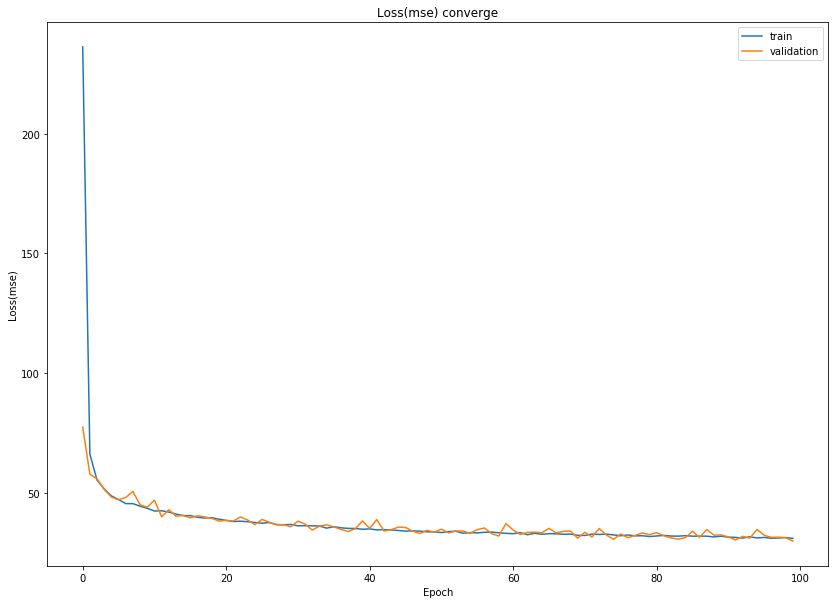

In [62]:
model_MC_ITM, result_MC_ITM = create_model(X_train_ITM, y_train_ITM)

In [15]:
model_MC_ITM = tf.keras.models.load_model('model_MC_ITM_1.h5')

100%|██████████| 100/100 [08:39<00:00,  5.13s/it]


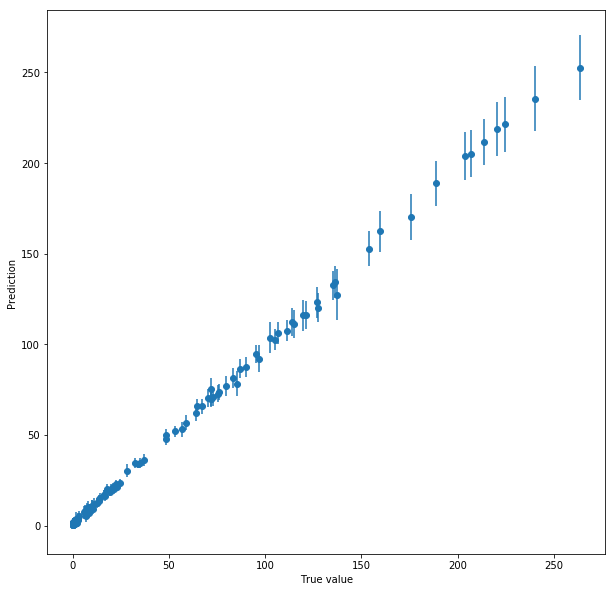

99.80% actual values are in 95CI
Adjusted R squared (R^2): 0.999091
Mean squared error (MSE): 3.31977
Mean absolute error (MAE): 1.25241


,true_value,prediction,uncertainty,upper_pred,lower_pred,in_95_CI
0,3.40,2.401999,2.367751,6.973883,-2.256722,True
1,0.13,0.755293,2.158312,6.075521,-2.570120,True
2,0.12,1.601952,2.522720,6.086889,-2.465044,True
3,0.80,1.877522,2.519409,6.961302,-2.354072,True
4,2.55,2.566476,2.425556,7.183391,-1.707063,True
5,0.70,1.543834,2.509214,6.803080,-2.485740,True
6,7.90,9.582736,2.413997,14.363609,5.111680,True
7,78.80,72.343353,5.656201,82.620081,62.325764,True
8,1.75,2.016711,2.469177,6.986635,-2.789278,True
9,12.40,11.819005,3.257300,18.045647,6.615734,True


In [18]:
results_df_ITM, results_array_ITM = pred_MCdropout(model_MC_ITM, X_test_ITM, y_test_ITM, 100)
results_df_ITM.head(10)

In [64]:
model_MC_ITM.save('model_MC_ITM_1.h5')

## MC Dropout for at the money dataset

In [42]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM = data_minmaxscaler(ATM_df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 231930 samples, validate on 25770 samples
Epoch 1/100
231930/231930 [==============================] - 18s 77us/sample - loss: 80.1524 - mean_absolute_error: 5.1256 - val_loss: 14.5362 - val_mean_absolute_error: 2.5680
Epoch 2/100
231930/231930 [==============================] - 11s 48us/sample - loss: 10.2083 - mean_absolute_error: 2.1414 - val_loss: 8.5946 - val_mean_absolute_error: 1.9628
Epoch 3/100
231930/231930 [==============================] - 11s 49us/sample - loss: 7.6352 - mean_absolute_error: 1.8601 - val_loss: 6.6678 - val_mean_absolute_error: 1.7404
Epoch 4/100
231930/231930 [==============================] - 12s 50us/sample - loss: 6.4597 - mean_absolute_error: 1.7161 - val_loss: 6.1416 - val_mean_absolute_error: 1.6664
Epoch 5/100
231930/231930 [==============================] - 10s 42us/sample - loss: 5.9138 - mean_absolute_error: 1.6442 - val_loss: 6.0536 - val_mean_absolute_error: 1.6362
Epoch 6/100
231930/231930 [==============================] - 10s 45us/s

Epoch 94/100
231930/231930 [==============================] - 9s 40us/sample - loss: 1.5333 - mean_absolute_error: 0.7976 - val_loss: 1.4468 - val_mean_absolute_error: 0.7706
Epoch 95/100
231930/231930 [==============================] - 9s 37us/sample - loss: 1.5470 - mean_absolute_error: 0.8070 - val_loss: 1.5054 - val_mean_absolute_error: 0.7850
Epoch 96/100
231930/231930 [==============================] - 8s 37us/sample - loss: 1.5132 - mean_absolute_error: 0.7952 - val_loss: 1.4811 - val_mean_absolute_error: 0.7771
Epoch 97/100
231930/231930 [==============================] - 9s 41us/sample - loss: 1.5623 - mean_absolute_error: 0.8064 - val_loss: 2.2532 - val_mean_absolute_error: 1.0380
Epoch 98/100
231930/231930 [==============================] - 8s 36us/sample - loss: 1.5416 - mean_absolute_error: 0.7985 - val_loss: 1.6440 - val_mean_absolute_error: 0.8675
Epoch 99/100
231930/231930 [==============================] - 8s 34us/sample - loss: 1.5377 - mean_absolute_error: 0.7999 - v

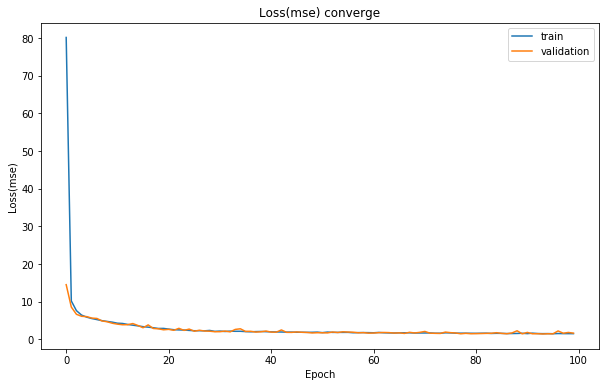

In [43]:
model_MC_ATM, result_MC_ATM = create_model(X_train_ATM, y_train_ATM)

100%|██████████| 100/100 [04:40<00:00,  2.72s/it]


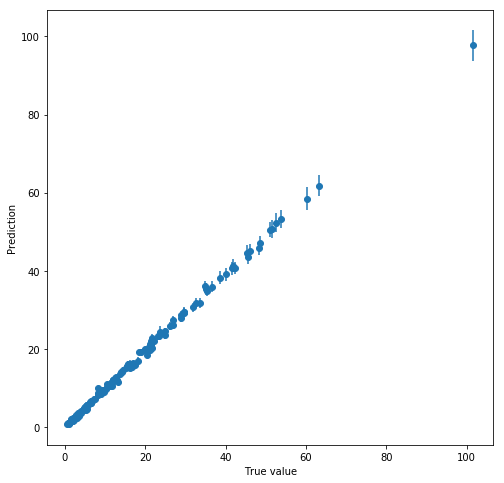

93.84% actual values are in 95CI
Adjusted R squared (R^2): 0.998277
Mean squared error (MSE): 0.507782
Mean absolute error (MAE): 0.48511


,true_value,prediction,uncertainty,error,upper_pred,lower_pred,in_95_CI
0,1.38,1.741899,0.174303,-0.361899,2.071109,1.461426,False
1,42.90,41.582840,1.943989,1.317160,45.157770,37.789619,True
2,8.15,7.993913,0.426531,0.156087,8.594026,7.185032,True
3,12.30,12.381377,0.614207,-0.081377,13.538628,11.229258,True
4,9.25,9.293293,0.657873,-0.043293,10.879377,8.356171,True


In [44]:
results_df_ATM, results_array_ATM = pred_MCdropout(model_MC_ATM, X_test_ATM, y_test_ATM, 100)
results_df_ATM.head()

In [68]:
model_MC_ATM.save('model_MC_ATM_2.h5')

## MC Dropout for out the money dataset

In [24]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM = data_minmaxscaler(OTM_df.sample(frac=0.8))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 363625 samples, validate on 40403 samples
Epoch 1/100
363625/363625 [==============================] - ETA: 21:24 - loss: 2001.8687 - mae: 27.05 - ETA: 2:49 - loss: 2056.9208 - mae: 27.2225 - ETA: 1:34 - loss: 2061.7722 - mae: 26.955 - ETA: 1:04 - loss: 1924.3587 - mae: 26.464 - ETA: 50s - loss: 1749.5276 - mae: 26.251 - ETA: 41s - loss: 1621.5686 - mae: 26.28 - ETA: 35s - loss: 1483.5934 - mae: 25.36 - ETA: 31s - loss: 1333.2339 - mae: 24.03 - ETA: 27s - loss: 1196.4571 - mae: 22.41 - ETA: 25s - loss: 1089.5609 - mae: 20.96 - ETA: 24s - loss: 1023.5437 - mae: 20.09 - ETA: 22s - loss: 957.3052 - mae: 19.1841 - ETA: 21s - loss: 884.2934 - mae: 18.166 - ETA: 20s - loss: 834.1570 - mae: 17.482 - ETA: 19s - loss: 779.7552 - mae: 16.763 - ETA: 18s - loss: 736.9361 - mae: 16.168 - ETA: 17s - loss: 694.5740 - mae: 15.569 - ETA: 16s - loss: 661.6051 - mae: 15.080 - ETA: 16s - loss: 631.5914 - mae: 14.643 - ETA: 15s - loss: 604.5861 - mae: 14.245 - ETA: 15s - loss: 576.9612 - mae: 13.8

363625/363625 [==============================] - ETA: 12s - loss: 30.2116 - mae: 3.542 - ETA: 10s - loss: 37.6486 - mae: 3.780 - ETA: 9s - loss: 35.3150 - mae: 3.653 - ETA: 8s - loss: 35.2959 - mae: 3.68 - ETA: 8s - loss: 35.2519 - mae: 3.69 - ETA: 8s - loss: 35.5739 - mae: 3.69 - ETA: 8s - loss: 35.6294 - mae: 3.68 - ETA: 8s - loss: 35.3226 - mae: 3.67 - ETA: 8s - loss: 35.1615 - mae: 3.67 - ETA: 8s - loss: 35.2110 - mae: 3.66 - ETA: 8s - loss: 35.0600 - mae: 3.66 - ETA: 8s - loss: 35.1251 - mae: 3.66 - ETA: 8s - loss: 35.1625 - mae: 3.67 - ETA: 8s - loss: 35.0820 - mae: 3.69 - ETA: 8s - loss: 35.2473 - mae: 3.69 - ETA: 8s - loss: 35.1725 - mae: 3.70 - ETA: 8s - loss: 35.5708 - mae: 3.71 - ETA: 8s - loss: 35.7063 - mae: 3.72 - ETA: 8s - loss: 35.7870 - mae: 3.72 - ETA: 8s - loss: 35.7426 - mae: 3.73 - ETA: 8s - loss: 35.4853 - mae: 3.72 - ETA: 8s - loss: 35.5045 - mae: 3.72 - ETA: 8s - loss: 35.4034 - mae: 3.71 - ETA: 8s - loss: 35.3665 - mae: 3.71 - ETA: 8s - loss: 35.3487 - mae: 3.7

363625/363625 [==============================] - ETA: 14s - loss: 29.4807 - mae: 3.462 - ETA: 10s - loss: 24.5463 - mae: 3.017 - ETA: 9s - loss: 23.2221 - mae: 2.950 - ETA: 10s - loss: 24.2248 - mae: 3.010 - ETA: 9s - loss: 25.0485 - mae: 3.032 - ETA: 9s - loss: 24.9948 - mae: 3.02 - ETA: 9s - loss: 25.4001 - mae: 3.03 - ETA: 9s - loss: 25.1240 - mae: 3.02 - ETA: 9s - loss: 25.4594 - mae: 3.04 - ETA: 9s - loss: 25.2218 - mae: 3.03 - ETA: 9s - loss: 25.3462 - mae: 3.03 - ETA: 9s - loss: 25.4470 - mae: 3.04 - ETA: 9s - loss: 25.3541 - mae: 3.03 - ETA: 9s - loss: 25.3298 - mae: 3.03 - ETA: 9s - loss: 25.0649 - mae: 3.02 - ETA: 9s - loss: 25.0544 - mae: 3.03 - ETA: 9s - loss: 25.1744 - mae: 3.03 - ETA: 8s - loss: 24.9714 - mae: 3.02 - ETA: 8s - loss: 24.8977 - mae: 3.01 - ETA: 8s - loss: 24.8430 - mae: 3.01 - ETA: 8s - loss: 24.8044 - mae: 3.00 - ETA: 8s - loss: 24.8775 - mae: 3.01 - ETA: 8s - loss: 24.9100 - mae: 3.01 - ETA: 8s - loss: 24.9209 - mae: 3.01 - ETA: 8s - loss: 24.7885 - mae: 

363625/363625 [==============================] - ETA: 4s - loss: 22.1620 - mae: 2.64 - ETA: 9s - loss: 24.7326 - mae: 2.93 - ETA: 9s - loss: 23.8191 - mae: 2.85 - ETA: 9s - loss: 23.4022 - mae: 2.86 - ETA: 9s - loss: 23.0919 - mae: 2.87 - ETA: 8s - loss: 23.2208 - mae: 2.89 - ETA: 8s - loss: 22.8644 - mae: 2.86 - ETA: 8s - loss: 22.7561 - mae: 2.86 - ETA: 8s - loss: 22.7648 - mae: 2.86 - ETA: 8s - loss: 22.6304 - mae: 2.85 - ETA: 8s - loss: 22.6398 - mae: 2.85 - ETA: 8s - loss: 22.4277 - mae: 2.85 - ETA: 8s - loss: 22.5029 - mae: 2.85 - ETA: 8s - loss: 22.7216 - mae: 2.86 - ETA: 8s - loss: 22.8629 - mae: 2.87 - ETA: 8s - loss: 22.7279 - mae: 2.85 - ETA: 8s - loss: 22.6181 - mae: 2.85 - ETA: 8s - loss: 22.6553 - mae: 2.84 - ETA: 8s - loss: 22.6023 - mae: 2.84 - ETA: 8s - loss: 22.5516 - mae: 2.83 - ETA: 7s - loss: 22.7360 - mae: 2.84 - ETA: 7s - loss: 22.6830 - mae: 2.84 - ETA: 7s - loss: 22.7373 - mae: 2.85 - ETA: 7s - loss: 22.7223 - mae: 2.85 - ETA: 7s - loss: 22.9249 - mae: 2.85 - E

363625/363625 [==============================] - ETA: 9s - loss: 25.6024 - mae: 2.95 - ETA: 10s - loss: 26.0111 - mae: 2.963 - ETA: 8s - loss: 24.4899 - mae: 2.887 - ETA: 8s - loss: 23.6123 - mae: 2.84 - ETA: 8s - loss: 22.9201 - mae: 2.79 - ETA: 8s - loss: 21.9252 - mae: 2.76 - ETA: 7s - loss: 21.7208 - mae: 2.76 - ETA: 7s - loss: 21.3653 - mae: 2.74 - ETA: 7s - loss: 21.4074 - mae: 2.76 - ETA: 7s - loss: 21.7364 - mae: 2.78 - ETA: 7s - loss: 21.4439 - mae: 2.77 - ETA: 7s - loss: 21.6315 - mae: 2.77 - ETA: 7s - loss: 21.5257 - mae: 2.77 - ETA: 7s - loss: 21.6798 - mae: 2.77 - ETA: 7s - loss: 21.8199 - mae: 2.77 - ETA: 7s - loss: 21.6809 - mae: 2.77 - ETA: 7s - loss: 21.6570 - mae: 2.76 - ETA: 7s - loss: 21.6840 - mae: 2.77 - ETA: 7s - loss: 21.5672 - mae: 2.76 - ETA: 7s - loss: 21.6504 - mae: 2.76 - ETA: 7s - loss: 21.6283 - mae: 2.76 - ETA: 7s - loss: 21.9102 - mae: 2.77 - ETA: 7s - loss: 21.9172 - mae: 2.77 - ETA: 7s - loss: 21.9301 - mae: 2.77 - ETA: 6s - loss: 21.9154 - mae: 2.77 

363625/363625 [==============================] - ETA: 8s - loss: 26.6011 - mae: 2.80 - ETA: 8s - loss: 26.0235 - mae: 2.86 - ETA: 8s - loss: 21.9778 - mae: 2.71 - ETA: 8s - loss: 21.3151 - mae: 2.72 - ETA: 8s - loss: 20.8744 - mae: 2.70 - ETA: 8s - loss: 20.4188 - mae: 2.69 - ETA: 7s - loss: 20.3794 - mae: 2.69 - ETA: 7s - loss: 20.1465 - mae: 2.68 - ETA: 7s - loss: 20.3439 - mae: 2.69 - ETA: 7s - loss: 20.2988 - mae: 2.69 - ETA: 7s - loss: 20.0581 - mae: 2.68 - ETA: 7s - loss: 20.2779 - mae: 2.68 - ETA: 7s - loss: 20.1090 - mae: 2.67 - ETA: 7s - loss: 20.1344 - mae: 2.67 - ETA: 7s - loss: 20.1422 - mae: 2.67 - ETA: 7s - loss: 20.1812 - mae: 2.67 - ETA: 7s - loss: 20.2044 - mae: 2.68 - ETA: 7s - loss: 20.2142 - mae: 2.68 - ETA: 7s - loss: 20.3635 - mae: 2.69 - ETA: 7s - loss: 20.5009 - mae: 2.70 - ETA: 6s - loss: 20.5970 - mae: 2.70 - ETA: 6s - loss: 20.6458 - mae: 2.70 - ETA: 6s - loss: 20.5917 - mae: 2.70 - ETA: 6s - loss: 20.5519 - mae: 2.70 - ETA: 6s - loss: 20.5178 - mae: 2.70 - E

363625/363625 [==============================] - ETA: 11s - loss: 17.5586 - mae: 2.586 - ETA: 8s - loss: 19.3077 - mae: 2.679 - ETA: 8s - loss: 19.4310 - mae: 2.64 - ETA: 8s - loss: 20.2023 - mae: 2.67 - ETA: 8s - loss: 19.8020 - mae: 2.63 - ETA: 8s - loss: 20.2019 - mae: 2.66 - ETA: 8s - loss: 20.1661 - mae: 2.66 - ETA: 8s - loss: 20.0157 - mae: 2.65 - ETA: 8s - loss: 19.8196 - mae: 2.64 - ETA: 8s - loss: 19.7192 - mae: 2.63 - ETA: 8s - loss: 19.5460 - mae: 2.63 - ETA: 8s - loss: 19.8535 - mae: 2.63 - ETA: 8s - loss: 20.0010 - mae: 2.65 - ETA: 8s - loss: 19.8757 - mae: 2.64 - ETA: 8s - loss: 19.7185 - mae: 2.64 - ETA: 8s - loss: 19.5946 - mae: 2.64 - ETA: 8s - loss: 19.6512 - mae: 2.64 - ETA: 7s - loss: 19.7962 - mae: 2.64 - ETA: 7s - loss: 19.7712 - mae: 2.64 - ETA: 7s - loss: 19.6972 - mae: 2.64 - ETA: 7s - loss: 19.6702 - mae: 2.64 - ETA: 7s - loss: 19.6971 - mae: 2.64 - ETA: 7s - loss: 19.7103 - mae: 2.64 - ETA: 7s - loss: 19.7489 - mae: 2.64 - ETA: 7s - loss: 19.7897 - mae: 2.65 

363625/363625 [==============================] - ETA: 8s - loss: 15.6047 - mae: 2.49 - ETA: 8s - loss: 20.1786 - mae: 2.58 - ETA: 8s - loss: 19.3186 - mae: 2.56 - ETA: 8s - loss: 19.4874 - mae: 2.59 - ETA: 7s - loss: 19.9757 - mae: 2.60 - ETA: 7s - loss: 19.4975 - mae: 2.58 - ETA: 7s - loss: 19.4903 - mae: 2.59 - ETA: 7s - loss: 19.3146 - mae: 2.58 - ETA: 7s - loss: 19.5622 - mae: 2.61 - ETA: 7s - loss: 19.3462 - mae: 2.61 - ETA: 7s - loss: 19.3372 - mae: 2.62 - ETA: 7s - loss: 19.2663 - mae: 2.62 - ETA: 7s - loss: 19.2501 - mae: 2.62 - ETA: 7s - loss: 19.1823 - mae: 2.61 - ETA: 7s - loss: 19.0379 - mae: 2.61 - ETA: 7s - loss: 18.9933 - mae: 2.60 - ETA: 7s - loss: 19.0496 - mae: 2.60 - ETA: 7s - loss: 19.0947 - mae: 2.61 - ETA: 7s - loss: 19.1174 - mae: 2.60 - ETA: 7s - loss: 19.1710 - mae: 2.61 - ETA: 7s - loss: 19.1881 - mae: 2.61 - ETA: 7s - loss: 19.2609 - mae: 2.62 - ETA: 7s - loss: 19.3262 - mae: 2.62 - ETA: 7s - loss: 19.3743 - mae: 2.62 - ETA: 7s - loss: 19.3528 - mae: 2.62 - E

363625/363625 [==============================] - ETA: 9s - loss: 19.6576 - mae: 2.70 - ETA: 8s - loss: 18.9111 - mae: 2.55 - ETA: 9s - loss: 18.2615 - mae: 2.52 - ETA: 9s - loss: 17.9549 - mae: 2.53 - ETA: 9s - loss: 18.7176 - mae: 2.58 - ETA: 9s - loss: 18.6073 - mae: 2.57 - ETA: 9s - loss: 19.1538 - mae: 2.59 - ETA: 9s - loss: 18.9684 - mae: 2.59 - ETA: 9s - loss: 19.0733 - mae: 2.58 - ETA: 9s - loss: 18.8521 - mae: 2.57 - ETA: 9s - loss: 18.7110 - mae: 2.56 - ETA: 8s - loss: 18.5081 - mae: 2.56 - ETA: 8s - loss: 18.4640 - mae: 2.55 - ETA: 8s - loss: 18.4645 - mae: 2.55 - ETA: 8s - loss: 18.5768 - mae: 2.56 - ETA: 8s - loss: 18.8419 - mae: 2.58 - ETA: 8s - loss: 18.8552 - mae: 2.58 - ETA: 8s - loss: 18.7361 - mae: 2.57 - ETA: 8s - loss: 18.7294 - mae: 2.57 - ETA: 8s - loss: 18.6177 - mae: 2.57 - ETA: 8s - loss: 18.5285 - mae: 2.56 - ETA: 8s - loss: 18.4324 - mae: 2.56 - ETA: 8s - loss: 18.4343 - mae: 2.56 - ETA: 8s - loss: 18.4014 - mae: 2.56 - ETA: 8s - loss: 18.3559 - mae: 2.56 - E

363625/363625 [==============================] - ETA: 9s - loss: 23.8751 - mae: 2.72 - ETA: 7s - loss: 19.0752 - mae: 2.57 - ETA: 7s - loss: 18.6968 - mae: 2.56 - ETA: 8s - loss: 18.5460 - mae: 2.54 - ETA: 8s - loss: 18.3620 - mae: 2.52 - ETA: 7s - loss: 17.9061 - mae: 2.51 - ETA: 7s - loss: 17.7466 - mae: 2.50 - ETA: 7s - loss: 17.4523 - mae: 2.49 - ETA: 7s - loss: 17.2400 - mae: 2.48 - ETA: 7s - loss: 17.4518 - mae: 2.49 - ETA: 7s - loss: 17.4889 - mae: 2.49 - ETA: 7s - loss: 17.5959 - mae: 2.50 - ETA: 7s - loss: 17.7164 - mae: 2.50 - ETA: 7s - loss: 17.9469 - mae: 2.52 - ETA: 7s - loss: 17.8825 - mae: 2.52 - ETA: 7s - loss: 17.8357 - mae: 2.51 - ETA: 7s - loss: 17.8518 - mae: 2.51 - ETA: 7s - loss: 17.8944 - mae: 2.52 - ETA: 7s - loss: 17.9028 - mae: 2.52 - ETA: 7s - loss: 17.8809 - mae: 2.51 - ETA: 7s - loss: 17.9357 - mae: 2.51 - ETA: 7s - loss: 17.9946 - mae: 2.52 - ETA: 7s - loss: 17.9658 - mae: 2.52 - ETA: 7s - loss: 17.9241 - mae: 2.52 - ETA: 7s - loss: 17.9013 - mae: 2.52 - E

363625/363625 [==============================] - ETA: 10s - loss: 16.7543 - mae: 2.457 - ETA: 7s - loss: 17.8951 - mae: 2.486 - ETA: 7s - loss: 17.9049 - mae: 2.50 - ETA: 7s - loss: 17.4700 - mae: 2.48 - ETA: 7s - loss: 17.4253 - mae: 2.48 - ETA: 7s - loss: 17.7692 - mae: 2.50 - ETA: 7s - loss: 17.6900 - mae: 2.50 - ETA: 7s - loss: 17.8268 - mae: 2.51 - ETA: 7s - loss: 17.9074 - mae: 2.52 - ETA: 7s - loss: 17.9902 - mae: 2.52 - ETA: 7s - loss: 17.8474 - mae: 2.51 - ETA: 7s - loss: 17.7995 - mae: 2.51 - ETA: 7s - loss: 17.6732 - mae: 2.51 - ETA: 7s - loss: 17.7293 - mae: 2.51 - ETA: 7s - loss: 17.5582 - mae: 2.50 - ETA: 7s - loss: 17.4600 - mae: 2.50 - ETA: 7s - loss: 17.4101 - mae: 2.50 - ETA: 7s - loss: 17.3769 - mae: 2.50 - ETA: 7s - loss: 17.3682 - mae: 2.50 - ETA: 7s - loss: 17.3744 - mae: 2.49 - ETA: 7s - loss: 17.3699 - mae: 2.49 - ETA: 7s - loss: 17.3603 - mae: 2.49 - ETA: 6s - loss: 17.4659 - mae: 2.50 - ETA: 6s - loss: 17.5738 - mae: 2.51 - ETA: 6s - loss: 17.5521 - mae: 2.51 

363625/363625 [==============================] - ETA: 20s - loss: 14.5001 - mae: 2.515 - ETA: 9s - loss: 18.1975 - mae: 2.487 - ETA: 9s - loss: 18.5398 - mae: 2.56 - ETA: 8s - loss: 18.7491 - mae: 2.57 - ETA: 8s - loss: 18.1187 - mae: 2.55 - ETA: 8s - loss: 17.6530 - mae: 2.54 - ETA: 8s - loss: 17.6070 - mae: 2.53 - ETA: 8s - loss: 17.2166 - mae: 2.50 - ETA: 8s - loss: 17.3390 - mae: 2.50 - ETA: 8s - loss: 17.3302 - mae: 2.50 - ETA: 8s - loss: 17.2723 - mae: 2.50 - ETA: 8s - loss: 17.2563 - mae: 2.50 - ETA: 7s - loss: 17.2449 - mae: 2.50 - ETA: 7s - loss: 17.3735 - mae: 2.50 - ETA: 7s - loss: 17.2740 - mae: 2.50 - ETA: 7s - loss: 17.2571 - mae: 2.50 - ETA: 7s - loss: 17.2956 - mae: 2.50 - ETA: 7s - loss: 17.2109 - mae: 2.49 - ETA: 7s - loss: 17.1636 - mae: 2.49 - ETA: 7s - loss: 17.0488 - mae: 2.48 - ETA: 7s - loss: 16.9860 - mae: 2.48 - ETA: 7s - loss: 16.7874 - mae: 2.47 - ETA: 7s - loss: 16.7119 - mae: 2.47 - ETA: 7s - loss: 16.6860 - mae: 2.47 - ETA: 7s - loss: 16.6757 - mae: 2.47 

363625/363625 [==============================] - ETA: 11s - loss: 17.4416 - mae: 2.402 - ETA: 8s - loss: 16.9417 - mae: 2.451 - ETA: 8s - loss: 17.1991 - mae: 2.47 - ETA: 8s - loss: 16.9177 - mae: 2.47 - ETA: 9s - loss: 17.7354 - mae: 2.50 - ETA: 9s - loss: 17.7652 - mae: 2.49 - ETA: 9s - loss: 17.2698 - mae: 2.47 - ETA: 9s - loss: 17.1669 - mae: 2.46 - ETA: 8s - loss: 17.0689 - mae: 2.46 - ETA: 8s - loss: 17.2224 - mae: 2.47 - ETA: 8s - loss: 17.1661 - mae: 2.47 - ETA: 8s - loss: 17.0533 - mae: 2.47 - ETA: 8s - loss: 17.0062 - mae: 2.47 - ETA: 8s - loss: 17.2207 - mae: 2.48 - ETA: 8s - loss: 17.1162 - mae: 2.47 - ETA: 7s - loss: 17.1515 - mae: 2.47 - ETA: 7s - loss: 17.1531 - mae: 2.47 - ETA: 7s - loss: 17.2186 - mae: 2.47 - ETA: 7s - loss: 17.2151 - mae: 2.48 - ETA: 7s - loss: 17.2479 - mae: 2.48 - ETA: 7s - loss: 17.1652 - mae: 2.47 - ETA: 7s - loss: 17.1197 - mae: 2.47 - ETA: 7s - loss: 17.2323 - mae: 2.47 - ETA: 7s - loss: 17.2670 - mae: 2.48 - ETA: 7s - loss: 17.2517 - mae: 2.47 

363625/363625 [==============================] - ETA: 9s - loss: 13.3787 - mae: 2.27 - ETA: 8s - loss: 14.9369 - mae: 2.35 - ETA: 9s - loss: 15.3074 - mae: 2.38 - ETA: 9s - loss: 15.8229 - mae: 2.39 - ETA: 8s - loss: 16.2032 - mae: 2.41 - ETA: 8s - loss: 16.6302 - mae: 2.44 - ETA: 8s - loss: 16.5648 - mae: 2.44 - ETA: 8s - loss: 16.2147 - mae: 2.43 - ETA: 8s - loss: 16.6788 - mae: 2.44 - ETA: 8s - loss: 16.5241 - mae: 2.44 - ETA: 8s - loss: 16.3072 - mae: 2.43 - ETA: 8s - loss: 16.4019 - mae: 2.42 - ETA: 8s - loss: 16.4006 - mae: 2.42 - ETA: 8s - loss: 16.2444 - mae: 2.42 - ETA: 8s - loss: 16.1956 - mae: 2.41 - ETA: 8s - loss: 16.1678 - mae: 2.41 - ETA: 8s - loss: 16.1826 - mae: 2.41 - ETA: 8s - loss: 16.2850 - mae: 2.42 - ETA: 7s - loss: 16.4950 - mae: 2.43 - ETA: 7s - loss: 16.5954 - mae: 2.43 - ETA: 7s - loss: 16.5449 - mae: 2.43 - ETA: 7s - loss: 16.5761 - mae: 2.43 - ETA: 7s - loss: 16.7880 - mae: 2.44 - ETA: 7s - loss: 16.7387 - mae: 2.44 - ETA: 7s - loss: 16.7325 - mae: 2.44 - E

363625/363625 [==============================] - ETA: 9s - loss: 16.4360 - mae: 2.58 - ETA: 8s - loss: 16.4386 - mae: 2.47 - ETA: 9s - loss: 15.9105 - mae: 2.44 - ETA: 9s - loss: 15.6636 - mae: 2.42 - ETA: 9s - loss: 15.7168 - mae: 2.42 - ETA: 8s - loss: 15.9410 - mae: 2.43 - ETA: 8s - loss: 15.9123 - mae: 2.43 - ETA: 8s - loss: 16.0443 - mae: 2.43 - ETA: 8s - loss: 16.0073 - mae: 2.43 - ETA: 8s - loss: 16.1490 - mae: 2.44 - ETA: 8s - loss: 16.2395 - mae: 2.45 - ETA: 8s - loss: 16.1757 - mae: 2.44 - ETA: 8s - loss: 15.9112 - mae: 2.44 - ETA: 8s - loss: 15.9099 - mae: 2.44 - ETA: 8s - loss: 15.7806 - mae: 2.43 - ETA: 8s - loss: 15.7598 - mae: 2.43 - ETA: 8s - loss: 15.7783 - mae: 2.43 - ETA: 8s - loss: 15.9370 - mae: 2.43 - ETA: 8s - loss: 15.9371 - mae: 2.42 - ETA: 7s - loss: 15.9395 - mae: 2.42 - ETA: 7s - loss: 16.0191 - mae: 2.42 - ETA: 7s - loss: 15.9786 - mae: 2.42 - ETA: 7s - loss: 15.8827 - mae: 2.42 - ETA: 7s - loss: 15.8932 - mae: 2.42 - ETA: 7s - loss: 15.8716 - mae: 2.42 - E

363625/363625 [==============================] - ETA: 9s - loss: 14.8006 - mae: 2.30 - ETA: 7s - loss: 15.3820 - mae: 2.38 - ETA: 7s - loss: 15.9703 - mae: 2.42 - ETA: 7s - loss: 16.3174 - mae: 2.45 - ETA: 7s - loss: 16.0368 - mae: 2.43 - ETA: 7s - loss: 15.8168 - mae: 2.42 - ETA: 7s - loss: 15.9260 - mae: 2.41 - ETA: 7s - loss: 15.7852 - mae: 2.41 - ETA: 7s - loss: 15.7640 - mae: 2.41 - ETA: 7s - loss: 15.6399 - mae: 2.40 - ETA: 7s - loss: 15.6220 - mae: 2.40 - ETA: 7s - loss: 15.5898 - mae: 2.40 - ETA: 8s - loss: 15.5589 - mae: 2.40 - ETA: 8s - loss: 15.5757 - mae: 2.40 - ETA: 7s - loss: 15.6829 - mae: 2.41 - ETA: 8s - loss: 15.6773 - mae: 2.40 - ETA: 7s - loss: 15.7455 - mae: 2.40 - ETA: 7s - loss: 15.7022 - mae: 2.41 - ETA: 7s - loss: 15.6409 - mae: 2.40 - ETA: 7s - loss: 15.5369 - mae: 2.40 - ETA: 7s - loss: 15.5142 - mae: 2.40 - ETA: 7s - loss: 15.4431 - mae: 2.40 - ETA: 7s - loss: 15.4075 - mae: 2.40 - ETA: 7s - loss: 15.4148 - mae: 2.39 - ETA: 7s - loss: 15.4766 - mae: 2.39 - E

363625/363625 [==============================] - ETA: 11s - loss: 18.6467 - mae: 2.458 - ETA: 10s - loss: 16.4771 - mae: 2.436 - ETA: 9s - loss: 15.3972 - mae: 2.380 - ETA: 9s - loss: 15.8912 - mae: 2.38 - ETA: 9s - loss: 16.6309 - mae: 2.42 - ETA: 9s - loss: 16.7486 - mae: 2.42 - ETA: 8s - loss: 16.4330 - mae: 2.41 - ETA: 8s - loss: 16.0818 - mae: 2.40 - ETA: 8s - loss: 16.0297 - mae: 2.39 - ETA: 8s - loss: 15.9114 - mae: 2.39 - ETA: 8s - loss: 16.0410 - mae: 2.39 - ETA: 8s - loss: 16.0491 - mae: 2.39 - ETA: 8s - loss: 16.0892 - mae: 2.40 - ETA: 8s - loss: 16.0039 - mae: 2.39 - ETA: 8s - loss: 15.8658 - mae: 2.39 - ETA: 8s - loss: 15.7933 - mae: 2.38 - ETA: 8s - loss: 15.6922 - mae: 2.38 - ETA: 8s - loss: 15.6134 - mae: 2.37 - ETA: 8s - loss: 15.5574 - mae: 2.37 - ETA: 8s - loss: 15.5519 - mae: 2.38 - ETA: 8s - loss: 15.5005 - mae: 2.38 - ETA: 8s - loss: 15.5496 - mae: 2.38 - ETA: 8s - loss: 15.5577 - mae: 2.38 - ETA: 8s - loss: 15.5392 - mae: 2.38 - ETA: 8s - loss: 15.4935 - mae: 2.3

363625/363625 [==============================] - ETA: 11s - loss: 19.9484 - mae: 2.640 - ETA: 10s - loss: 15.0301 - mae: 2.480 - ETA: 10s - loss: 14.6951 - mae: 2.444 - ETA: 11s - loss: 14.8664 - mae: 2.419 - ETA: 10s - loss: 14.5540 - mae: 2.391 - ETA: 10s - loss: 14.5586 - mae: 2.376 - ETA: 10s - loss: 14.6372 - mae: 2.386 - ETA: 10s - loss: 14.8928 - mae: 2.399 - ETA: 10s - loss: 14.9870 - mae: 2.401 - ETA: 10s - loss: 15.5225 - mae: 2.412 - ETA: 10s - loss: 15.6410 - mae: 2.412 - ETA: 10s - loss: 15.6991 - mae: 2.417 - ETA: 10s - loss: 15.7791 - mae: 2.427 - ETA: 10s - loss: 15.7513 - mae: 2.430 - ETA: 10s - loss: 15.8559 - mae: 2.435 - ETA: 10s - loss: 15.9094 - mae: 2.436 - ETA: 10s - loss: 15.7586 - mae: 2.423 - ETA: 10s - loss: 15.8113 - mae: 2.422 - ETA: 10s - loss: 15.8144 - mae: 2.423 - ETA: 10s - loss: 16.0002 - mae: 2.425 - ETA: 10s - loss: 16.0071 - mae: 2.423 - ETA: 9s - loss: 15.8622 - mae: 2.416 - ETA: 9s - loss: 15.9480 - mae: 2.41 - ETA: 9s - loss: 15.9719 - mae: 2.4

363625/363625 [==============================] - ETA: 11s - loss: 10.5243 - mae: 2.165 - ETA: 11s - loss: 16.5775 - mae: 2.430 - ETA: 10s - loss: 15.5466 - mae: 2.399 - ETA: 10s - loss: 14.5894 - mae: 2.355 - ETA: 10s - loss: 14.4939 - mae: 2.357 - ETA: 10s - loss: 14.4406 - mae: 2.351 - ETA: 9s - loss: 14.7421 - mae: 2.368 - ETA: 9s - loss: 14.7671 - mae: 2.35 - ETA: 9s - loss: 14.7819 - mae: 2.36 - ETA: 9s - loss: 14.7699 - mae: 2.35 - ETA: 9s - loss: 14.9644 - mae: 2.36 - ETA: 9s - loss: 15.0349 - mae: 2.37 - ETA: 9s - loss: 15.1774 - mae: 2.37 - ETA: 9s - loss: 15.2344 - mae: 2.37 - ETA: 9s - loss: 15.2092 - mae: 2.37 - ETA: 9s - loss: 15.1698 - mae: 2.37 - ETA: 9s - loss: 15.1369 - mae: 2.37 - ETA: 9s - loss: 15.2265 - mae: 2.37 - ETA: 9s - loss: 15.3037 - mae: 2.38 - ETA: 9s - loss: 15.2253 - mae: 2.38 - ETA: 9s - loss: 15.2585 - mae: 2.38 - ETA: 8s - loss: 15.3513 - mae: 2.38 - ETA: 8s - loss: 15.4469 - mae: 2.39 - ETA: 8s - loss: 15.4729 - mae: 2.39 - ETA: 8s - loss: 15.4764 - 

363625/363625 [==============================] - ETA: 18s - loss: 9.9899 - mae: 2.03 - ETA: 10s - loss: 15.5723 - mae: 2.411 - ETA: 10s - loss: 15.5795 - mae: 2.392 - ETA: 10s - loss: 15.9609 - mae: 2.394 - ETA: 10s - loss: 15.7988 - mae: 2.380 - ETA: 10s - loss: 16.0317 - mae: 2.399 - ETA: 10s - loss: 15.7332 - mae: 2.400 - ETA: 9s - loss: 15.6652 - mae: 2.402 - ETA: 9s - loss: 15.4976 - mae: 2.39 - ETA: 9s - loss: 15.1748 - mae: 2.38 - ETA: 9s - loss: 15.2159 - mae: 2.38 - ETA: 9s - loss: 15.1750 - mae: 2.37 - ETA: 9s - loss: 15.2329 - mae: 2.38 - ETA: 8s - loss: 15.2831 - mae: 2.38 - ETA: 8s - loss: 15.3599 - mae: 2.39 - ETA: 8s - loss: 15.4105 - mae: 2.39 - ETA: 8s - loss: 15.4801 - mae: 2.40 - ETA: 8s - loss: 15.5394 - mae: 2.41 - ETA: 8s - loss: 15.6453 - mae: 2.41 - ETA: 8s - loss: 15.5282 - mae: 2.41 - ETA: 8s - loss: 15.5090 - mae: 2.41 - ETA: 8s - loss: 15.5441 - mae: 2.41 - ETA: 8s - loss: 15.5553 - mae: 2.41 - ETA: 8s - loss: 15.4699 - mae: 2.40 - ETA: 7s - loss: 15.5140 - 

363625/363625 [==============================] - ETA: 8s - loss: 12.9402 - mae: 2.00 - ETA: 7s - loss: 15.3425 - mae: 2.37 - ETA: 8s - loss: 15.3510 - mae: 2.39 - ETA: 8s - loss: 14.8219 - mae: 2.36 - ETA: 7s - loss: 15.3247 - mae: 2.39 - ETA: 7s - loss: 15.7684 - mae: 2.40 - ETA: 8s - loss: 15.8878 - mae: 2.40 - ETA: 7s - loss: 15.6172 - mae: 2.39 - ETA: 7s - loss: 15.3341 - mae: 2.37 - ETA: 7s - loss: 15.3445 - mae: 2.38 - ETA: 8s - loss: 15.2415 - mae: 2.37 - ETA: 8s - loss: 15.2503 - mae: 2.38 - ETA: 8s - loss: 15.2656 - mae: 2.38 - ETA: 7s - loss: 15.2518 - mae: 2.38 - ETA: 7s - loss: 15.3501 - mae: 2.39 - ETA: 7s - loss: 15.4012 - mae: 2.39 - ETA: 7s - loss: 15.6235 - mae: 2.39 - ETA: 7s - loss: 15.5945 - mae: 2.39 - ETA: 7s - loss: 15.5013 - mae: 2.39 - ETA: 7s - loss: 15.5127 - mae: 2.40 - ETA: 7s - loss: 15.4256 - mae: 2.39 - ETA: 7s - loss: 15.4225 - mae: 2.39 - ETA: 7s - loss: 15.3257 - mae: 2.39 - ETA: 7s - loss: 15.2863 - mae: 2.39 - ETA: 7s - loss: 15.3098 - mae: 2.39 - E

363625/363625 [==============================] - ETA: 9s - loss: 12.7707 - mae: 2.22 - ETA: 10s - loss: 13.0147 - mae: 2.289 - ETA: 10s - loss: 13.2624 - mae: 2.292 - ETA: 10s - loss: 13.7168 - mae: 2.320 - ETA: 9s - loss: 13.8713 - mae: 2.341 - ETA: 9s - loss: 13.8327 - mae: 2.33 - ETA: 9s - loss: 13.7938 - mae: 2.33 - ETA: 8s - loss: 13.9143 - mae: 2.33 - ETA: 8s - loss: 14.0643 - mae: 2.34 - ETA: 8s - loss: 14.0765 - mae: 2.35 - ETA: 8s - loss: 14.0844 - mae: 2.35 - ETA: 8s - loss: 14.1966 - mae: 2.35 - ETA: 8s - loss: 14.1645 - mae: 2.34 - ETA: 8s - loss: 14.1551 - mae: 2.34 - ETA: 8s - loss: 14.2120 - mae: 2.34 - ETA: 8s - loss: 14.3107 - mae: 2.35 - ETA: 8s - loss: 14.2484 - mae: 2.35 - ETA: 8s - loss: 14.3075 - mae: 2.35 - ETA: 8s - loss: 14.3290 - mae: 2.35 - ETA: 8s - loss: 14.3469 - mae: 2.35 - ETA: 8s - loss: 14.3839 - mae: 2.35 - ETA: 7s - loss: 14.4109 - mae: 2.35 - ETA: 7s - loss: 14.4344 - mae: 2.35 - ETA: 7s - loss: 14.5172 - mae: 2.36 - ETA: 7s - loss: 14.5097 - mae: 2

363625/363625 [==============================] - ETA: 12s - loss: 9.9820 - mae: 2.07 - ETA: 8s - loss: 14.4055 - mae: 2.29 - ETA: 7s - loss: 14.9231 - mae: 2.32 - ETA: 7s - loss: 14.7284 - mae: 2.35 - ETA: 8s - loss: 14.5638 - mae: 2.32 - ETA: 8s - loss: 14.4276 - mae: 2.32 - ETA: 7s - loss: 14.4734 - mae: 2.32 - ETA: 7s - loss: 14.1995 - mae: 2.31 - ETA: 7s - loss: 14.1845 - mae: 2.30 - ETA: 7s - loss: 14.2140 - mae: 2.30 - ETA: 7s - loss: 14.3060 - mae: 2.31 - ETA: 7s - loss: 14.2857 - mae: 2.32 - ETA: 7s - loss: 14.4052 - mae: 2.33 - ETA: 7s - loss: 14.4507 - mae: 2.34 - ETA: 7s - loss: 14.4898 - mae: 2.34 - ETA: 7s - loss: 14.5424 - mae: 2.34 - ETA: 7s - loss: 14.5423 - mae: 2.34 - ETA: 7s - loss: 14.5628 - mae: 2.34 - ETA: 7s - loss: 14.5356 - mae: 2.34 - ETA: 7s - loss: 14.4654 - mae: 2.34 - ETA: 7s - loss: 14.4351 - mae: 2.33 - ETA: 7s - loss: 14.4937 - mae: 2.34 - ETA: 7s - loss: 14.4845 - mae: 2.34 - ETA: 7s - loss: 14.5044 - mae: 2.34 - ETA: 6s - loss: 14.5659 - mae: 2.34 - E

363625/363625 [==============================] - ETA: 8s - loss: 13.5900 - mae: 2.41 - ETA: 8s - loss: 14.2883 - mae: 2.39 - ETA: 9s - loss: 14.1840 - mae: 2.38 - ETA: 9s - loss: 14.2036 - mae: 2.37 - ETA: 8s - loss: 14.2728 - mae: 2.36 - ETA: 8s - loss: 14.0448 - mae: 2.34 - ETA: 8s - loss: 14.1373 - mae: 2.35 - ETA: 7s - loss: 14.3466 - mae: 2.36 - ETA: 7s - loss: 14.2158 - mae: 2.35 - ETA: 7s - loss: 14.3264 - mae: 2.35 - ETA: 7s - loss: 14.4079 - mae: 2.35 - ETA: 7s - loss: 14.3135 - mae: 2.35 - ETA: 7s - loss: 14.2759 - mae: 2.35 - ETA: 7s - loss: 14.2285 - mae: 2.34 - ETA: 7s - loss: 14.2606 - mae: 2.34 - ETA: 7s - loss: 14.2352 - mae: 2.34 - ETA: 7s - loss: 14.5314 - mae: 2.35 - ETA: 7s - loss: 14.3897 - mae: 2.35 - ETA: 7s - loss: 14.3649 - mae: 2.35 - ETA: 7s - loss: 14.3976 - mae: 2.35 - ETA: 7s - loss: 14.3845 - mae: 2.35 - ETA: 7s - loss: 14.3889 - mae: 2.35 - ETA: 6s - loss: 14.4235 - mae: 2.35 - ETA: 6s - loss: 14.4197 - mae: 2.35 - ETA: 6s - loss: 14.4100 - mae: 2.35 - E

363625/363625 [==============================] - ETA: 9s - loss: 19.5772 - mae: 2.53 - ETA: 8s - loss: 15.0035 - mae: 2.40 - ETA: 8s - loss: 14.8461 - mae: 2.38 - ETA: 8s - loss: 14.3330 - mae: 2.34 - ETA: 8s - loss: 14.5140 - mae: 2.35 - ETA: 8s - loss: 14.6972 - mae: 2.36 - ETA: 8s - loss: 14.2641 - mae: 2.34 - ETA: 8s - loss: 14.4967 - mae: 2.36 - ETA: 8s - loss: 14.7103 - mae: 2.37 - ETA: 8s - loss: 14.9140 - mae: 2.37 - ETA: 8s - loss: 14.7602 - mae: 2.37 - ETA: 8s - loss: 14.6424 - mae: 2.36 - ETA: 8s - loss: 14.8500 - mae: 2.37 - ETA: 7s - loss: 14.6702 - mae: 2.37 - ETA: 7s - loss: 14.7328 - mae: 2.37 - ETA: 7s - loss: 14.6898 - mae: 2.37 - ETA: 7s - loss: 14.7676 - mae: 2.37 - ETA: 7s - loss: 14.7272 - mae: 2.37 - ETA: 7s - loss: 14.5656 - mae: 2.36 - ETA: 7s - loss: 14.6674 - mae: 2.37 - ETA: 7s - loss: 14.6158 - mae: 2.36 - ETA: 7s - loss: 14.6396 - mae: 2.36 - ETA: 7s - loss: 14.7057 - mae: 2.36 - ETA: 7s - loss: 14.7371 - mae: 2.36 - ETA: 7s - loss: 14.7330 - mae: 2.36 - E

363625/363625 [==============================] - ETA: 8s - loss: 14.4450 - mae: 2.39 - ETA: 7s - loss: 14.3023 - mae: 2.36 - ETA: 7s - loss: 13.1238 - mae: 2.30 - ETA: 7s - loss: 14.1534 - mae: 2.35 - ETA: 7s - loss: 14.3378 - mae: 2.36 - ETA: 7s - loss: 14.3351 - mae: 2.36 - ETA: 7s - loss: 14.5417 - mae: 2.37 - ETA: 7s - loss: 14.3853 - mae: 2.36 - ETA: 7s - loss: 14.3326 - mae: 2.35 - ETA: 7s - loss: 14.2514 - mae: 2.34 - ETA: 7s - loss: 14.2342 - mae: 2.34 - ETA: 7s - loss: 14.2939 - mae: 2.34 - ETA: 7s - loss: 14.5497 - mae: 2.35 - ETA: 7s - loss: 14.6165 - mae: 2.35 - ETA: 7s - loss: 14.5707 - mae: 2.35 - ETA: 6s - loss: 14.6027 - mae: 2.36 - ETA: 6s - loss: 14.6603 - mae: 2.36 - ETA: 6s - loss: 14.6313 - mae: 2.36 - ETA: 6s - loss: 14.7379 - mae: 2.36 - ETA: 6s - loss: 14.8169 - mae: 2.37 - ETA: 6s - loss: 14.8373 - mae: 2.37 - ETA: 6s - loss: 14.9827 - mae: 2.38 - ETA: 6s - loss: 15.0005 - mae: 2.38 - ETA: 6s - loss: 15.0564 - mae: 2.38 - ETA: 6s - loss: 15.1189 - mae: 2.38 - E

363625/363625 [==============================] - ETA: 9s - loss: 14.0512 - mae: 2.17 - ETA: 7s - loss: 12.8129 - mae: 2.28 - ETA: 8s - loss: 13.6120 - mae: 2.34 - ETA: 8s - loss: 13.9872 - mae: 2.36 - ETA: 8s - loss: 13.5521 - mae: 2.32 - ETA: 7s - loss: 13.9896 - mae: 2.34 - ETA: 7s - loss: 14.2363 - mae: 2.35 - ETA: 7s - loss: 14.3601 - mae: 2.37 - ETA: 7s - loss: 14.1139 - mae: 2.36 - ETA: 7s - loss: 14.1723 - mae: 2.36 - ETA: 7s - loss: 14.2698 - mae: 2.37 - ETA: 7s - loss: 14.3852 - mae: 2.37 - ETA: 7s - loss: 14.4390 - mae: 2.37 - ETA: 7s - loss: 14.4087 - mae: 2.36 - ETA: 7s - loss: 14.3248 - mae: 2.35 - ETA: 7s - loss: 14.3045 - mae: 2.35 - ETA: 6s - loss: 14.3686 - mae: 2.35 - ETA: 6s - loss: 14.4302 - mae: 2.35 - ETA: 6s - loss: 14.3884 - mae: 2.35 - ETA: 6s - loss: 14.4623 - mae: 2.36 - ETA: 6s - loss: 14.4224 - mae: 2.35 - ETA: 6s - loss: 14.4116 - mae: 2.36 - ETA: 6s - loss: 14.4030 - mae: 2.35 - ETA: 6s - loss: 14.4388 - mae: 2.36 - ETA: 6s - loss: 14.6239 - mae: 2.37 - E

363625/363625 [==============================] - ETA: 9s - loss: 12.0658 - mae: 2.41 - ETA: 8s - loss: 14.3716 - mae: 2.36 - ETA: 7s - loss: 14.9986 - mae: 2.40 - ETA: 7s - loss: 14.9675 - mae: 2.41 - ETA: 7s - loss: 14.6777 - mae: 2.37 - ETA: 7s - loss: 14.8177 - mae: 2.38 - ETA: 7s - loss: 14.7993 - mae: 2.38 - ETA: 7s - loss: 14.6050 - mae: 2.38 - ETA: 7s - loss: 14.4784 - mae: 2.37 - ETA: 7s - loss: 14.4821 - mae: 2.37 - ETA: 7s - loss: 14.3038 - mae: 2.37 - ETA: 7s - loss: 14.2280 - mae: 2.37 - ETA: 7s - loss: 14.3022 - mae: 2.37 - ETA: 7s - loss: 14.2308 - mae: 2.37 - ETA: 7s - loss: 14.1940 - mae: 2.36 - ETA: 7s - loss: 14.1506 - mae: 2.36 - ETA: 6s - loss: 14.1472 - mae: 2.36 - ETA: 6s - loss: 14.1003 - mae: 2.36 - ETA: 6s - loss: 13.9876 - mae: 2.35 - ETA: 6s - loss: 13.9996 - mae: 2.35 - ETA: 6s - loss: 14.0815 - mae: 2.36 - ETA: 6s - loss: 14.0492 - mae: 2.35 - ETA: 6s - loss: 14.1151 - mae: 2.36 - ETA: 6s - loss: 14.1705 - mae: 2.36 - ETA: 6s - loss: 14.2072 - mae: 2.36 - E

363625/363625 [==============================] - ETA: 11s - loss: 16.3317 - mae: 2.307 - ETA: 10s - loss: 13.4303 - mae: 2.313 - ETA: 10s - loss: 13.2009 - mae: 2.287 - ETA: 10s - loss: 12.9232 - mae: 2.268 - ETA: 10s - loss: 13.5883 - mae: 2.299 - ETA: 10s - loss: 14.3501 - mae: 2.329 - ETA: 10s - loss: 14.6317 - mae: 2.346 - ETA: 10s - loss: 14.5571 - mae: 2.343 - ETA: 10s - loss: 14.3201 - mae: 2.331 - ETA: 10s - loss: 14.2738 - mae: 2.325 - ETA: 9s - loss: 14.2593 - mae: 2.328 - ETA: 9s - loss: 14.1553 - mae: 2.32 - ETA: 9s - loss: 14.2225 - mae: 2.32 - ETA: 9s - loss: 14.2746 - mae: 2.33 - ETA: 9s - loss: 14.2754 - mae: 2.33 - ETA: 9s - loss: 14.3348 - mae: 2.34 - ETA: 9s - loss: 14.3803 - mae: 2.34 - ETA: 9s - loss: 14.3350 - mae: 2.34 - ETA: 9s - loss: 14.2143 - mae: 2.33 - ETA: 9s - loss: 14.2779 - mae: 2.34 - ETA: 9s - loss: 14.2610 - mae: 2.34 - ETA: 9s - loss: 14.3116 - mae: 2.34 - ETA: 9s - loss: 14.2115 - mae: 2.34 - ETA: 9s - loss: 14.1321 - mae: 2.33 - ETA: 9s - loss: 14

363625/363625 [==============================] - ETA: 17s - loss: 11.8293 - mae: 2.336 - ETA: 11s - loss: 12.7606 - mae: 2.262 - ETA: 11s - loss: 13.6286 - mae: 2.317 - ETA: 10s - loss: 13.7981 - mae: 2.337 - ETA: 9s - loss: 13.9066 - mae: 2.340 - ETA: 10s - loss: 13.7942 - mae: 2.337 - ETA: 10s - loss: 14.0380 - mae: 2.332 - ETA: 10s - loss: 13.9196 - mae: 2.328 - ETA: 10s - loss: 14.0137 - mae: 2.328 - ETA: 10s - loss: 14.0119 - mae: 2.327 - ETA: 10s - loss: 14.2483 - mae: 2.335 - ETA: 10s - loss: 14.2748 - mae: 2.346 - ETA: 9s - loss: 14.2498 - mae: 2.347 - ETA: 9s - loss: 14.2014 - mae: 2.34 - ETA: 9s - loss: 14.3286 - mae: 2.35 - ETA: 9s - loss: 14.2920 - mae: 2.34 - ETA: 9s - loss: 14.3837 - mae: 2.35 - ETA: 9s - loss: 14.4464 - mae: 2.35 - ETA: 9s - loss: 14.4737 - mae: 2.35 - ETA: 9s - loss: 14.3268 - mae: 2.35 - ETA: 9s - loss: 14.3491 - mae: 2.35 - ETA: 8s - loss: 14.2656 - mae: 2.35 - ETA: 8s - loss: 14.2004 - mae: 2.34 - ETA: 8s - loss: 14.2278 - mae: 2.35 - ETA: 8s - loss:

363625/363625 [==============================] - ETA: 9s - loss: 9.2806 - mae: 1.991 - ETA: 9s - loss: 12.9518 - mae: 2.27 - ETA: 9s - loss: 13.5308 - mae: 2.30 - ETA: 9s - loss: 13.8699 - mae: 2.33 - ETA: 9s - loss: 14.2617 - mae: 2.35 - ETA: 8s - loss: 14.5686 - mae: 2.36 - ETA: 9s - loss: 14.3134 - mae: 2.34 - ETA: 9s - loss: 14.7528 - mae: 2.36 - ETA: 9s - loss: 14.5122 - mae: 2.35 - ETA: 9s - loss: 14.7111 - mae: 2.36 - ETA: 9s - loss: 14.5531 - mae: 2.35 - ETA: 8s - loss: 14.3840 - mae: 2.35 - ETA: 9s - loss: 14.2301 - mae: 2.34 - ETA: 8s - loss: 14.2786 - mae: 2.35 - ETA: 8s - loss: 14.4424 - mae: 2.35 - ETA: 8s - loss: 14.4619 - mae: 2.35 - ETA: 8s - loss: 14.4553 - mae: 2.36 - ETA: 8s - loss: 14.4782 - mae: 2.36 - ETA: 8s - loss: 14.3390 - mae: 2.35 - ETA: 8s - loss: 14.3104 - mae: 2.35 - ETA: 8s - loss: 14.2218 - mae: 2.35 - ETA: 8s - loss: 14.2214 - mae: 2.35 - ETA: 8s - loss: 14.2577 - mae: 2.35 - ETA: 8s - loss: 14.1665 - mae: 2.35 - ETA: 8s - loss: 14.1541 - mae: 2.35 - E

363625/363625 [==============================] - ETA: 14s - loss: 13.6341 - mae: 2.290 - ETA: 10s - loss: 13.9689 - mae: 2.348 - ETA: 9s - loss: 14.5816 - mae: 2.376 - ETA: 8s - loss: 14.4503 - mae: 2.38 - ETA: 8s - loss: 13.9408 - mae: 2.34 - ETA: 8s - loss: 13.8826 - mae: 2.33 - ETA: 8s - loss: 13.7328 - mae: 2.31 - ETA: 8s - loss: 14.0970 - mae: 2.33 - ETA: 8s - loss: 13.7456 - mae: 2.32 - ETA: 8s - loss: 13.7088 - mae: 2.32 - ETA: 8s - loss: 13.5811 - mae: 2.31 - ETA: 8s - loss: 13.5066 - mae: 2.31 - ETA: 8s - loss: 13.5529 - mae: 2.31 - ETA: 8s - loss: 13.5842 - mae: 2.31 - ETA: 8s - loss: 13.3831 - mae: 2.30 - ETA: 8s - loss: 13.3963 - mae: 2.30 - ETA: 7s - loss: 13.3896 - mae: 2.30 - ETA: 7s - loss: 13.3786 - mae: 2.30 - ETA: 7s - loss: 13.5681 - mae: 2.30 - ETA: 7s - loss: 13.5443 - mae: 2.31 - ETA: 7s - loss: 13.5427 - mae: 2.31 - ETA: 7s - loss: 13.5349 - mae: 2.31 - ETA: 7s - loss: 13.5435 - mae: 2.31 - ETA: 7s - loss: 13.5229 - mae: 2.31 - ETA: 7s - loss: 13.4868 - mae: 2.3

363625/363625 [==============================] - ETA: 27s - loss: 14.6386 - mae: 2.487 - ETA: 9s - loss: 14.0339 - mae: 2.352 - ETA: 9s - loss: 12.8297 - mae: 2.25 - ETA: 9s - loss: 12.4382 - mae: 2.23 - ETA: 9s - loss: 13.2809 - mae: 2.29 - ETA: 9s - loss: 13.4341 - mae: 2.30 - ETA: 8s - loss: 13.3626 - mae: 2.30 - ETA: 8s - loss: 13.3253 - mae: 2.30 - ETA: 8s - loss: 13.3526 - mae: 2.30 - ETA: 8s - loss: 13.4487 - mae: 2.31 - ETA: 8s - loss: 13.5365 - mae: 2.31 - ETA: 8s - loss: 13.6736 - mae: 2.32 - ETA: 8s - loss: 13.6644 - mae: 2.32 - ETA: 8s - loss: 13.9116 - mae: 2.33 - ETA: 8s - loss: 14.0281 - mae: 2.34 - ETA: 8s - loss: 14.0598 - mae: 2.35 - ETA: 8s - loss: 14.0796 - mae: 2.35 - ETA: 8s - loss: 14.0865 - mae: 2.35 - ETA: 7s - loss: 14.0603 - mae: 2.34 - ETA: 7s - loss: 14.1407 - mae: 2.34 - ETA: 7s - loss: 14.0464 - mae: 2.34 - ETA: 7s - loss: 14.0968 - mae: 2.34 - ETA: 7s - loss: 13.9605 - mae: 2.33 - ETA: 7s - loss: 13.8734 - mae: 2.33 - ETA: 7s - loss: 13.8311 - mae: 2.33 

363625/363625 [==============================] - ETA: 14s - loss: 14.0312 - mae: 2.497 - ETA: 11s - loss: 12.2731 - mae: 2.218 - ETA: 10s - loss: 11.9097 - mae: 2.223 - ETA: 10s - loss: 12.8645 - mae: 2.287 - ETA: 9s - loss: 12.7345 - mae: 2.272 - ETA: 9s - loss: 12.6845 - mae: 2.26 - ETA: 9s - loss: 12.9211 - mae: 2.28 - ETA: 9s - loss: 13.1172 - mae: 2.29 - ETA: 9s - loss: 13.1974 - mae: 2.30 - ETA: 9s - loss: 13.3149 - mae: 2.31 - ETA: 9s - loss: 13.4475 - mae: 2.31 - ETA: 9s - loss: 13.4539 - mae: 2.31 - ETA: 9s - loss: 13.5673 - mae: 2.31 - ETA: 9s - loss: 13.6803 - mae: 2.32 - ETA: 8s - loss: 13.8813 - mae: 2.32 - ETA: 8s - loss: 13.8537 - mae: 2.32 - ETA: 8s - loss: 13.9035 - mae: 2.33 - ETA: 8s - loss: 13.8118 - mae: 2.33 - ETA: 8s - loss: 13.7788 - mae: 2.33 - ETA: 8s - loss: 13.7054 - mae: 2.32 - ETA: 8s - loss: 13.7954 - mae: 2.33 - ETA: 8s - loss: 13.8031 - mae: 2.33 - ETA: 8s - loss: 13.7167 - mae: 2.32 - ETA: 7s - loss: 13.6825 - mae: 2.32 - ETA: 7s - loss: 13.7222 - mae:

363625/363625 [==============================] - ETA: 10s - loss: 14.0543 - mae: 2.423 - ETA: 9s - loss: 15.1997 - mae: 2.468 - ETA: 9s - loss: 15.7886 - mae: 2.48 - ETA: 9s - loss: 15.3256 - mae: 2.44 - ETA: 9s - loss: 15.0839 - mae: 2.42 - ETA: 9s - loss: 14.9271 - mae: 2.42 - ETA: 9s - loss: 14.5357 - mae: 2.39 - ETA: 9s - loss: 14.7438 - mae: 2.40 - ETA: 9s - loss: 14.9162 - mae: 2.41 - ETA: 9s - loss: 14.6267 - mae: 2.40 - ETA: 8s - loss: 14.7299 - mae: 2.39 - ETA: 8s - loss: 14.7571 - mae: 2.39 - ETA: 8s - loss: 14.6925 - mae: 2.39 - ETA: 8s - loss: 14.6835 - mae: 2.38 - ETA: 8s - loss: 14.8046 - mae: 2.39 - ETA: 8s - loss: 14.8915 - mae: 2.39 - ETA: 8s - loss: 14.8321 - mae: 2.39 - ETA: 8s - loss: 14.7679 - mae: 2.39 - ETA: 8s - loss: 14.6467 - mae: 2.38 - ETA: 8s - loss: 14.6107 - mae: 2.38 - ETA: 7s - loss: 14.5898 - mae: 2.38 - ETA: 7s - loss: 14.5170 - mae: 2.37 - ETA: 7s - loss: 14.4769 - mae: 2.37 - ETA: 7s - loss: 14.4094 - mae: 2.37 - ETA: 7s - loss: 14.3967 - mae: 2.37 

363625/363625 [==============================] - ETA: 9s - loss: 10.9966 - mae: 2.06 - ETA: 7s - loss: 13.9306 - mae: 2.33 - ETA: 7s - loss: 14.5493 - mae: 2.38 - ETA: 7s - loss: 13.4345 - mae: 2.32 - ETA: 7s - loss: 13.2995 - mae: 2.31 - ETA: 7s - loss: 13.1545 - mae: 2.31 - ETA: 8s - loss: 13.4240 - mae: 2.32 - ETA: 8s - loss: 13.5404 - mae: 2.32 - ETA: 8s - loss: 13.7642 - mae: 2.33 - ETA: 8s - loss: 13.6513 - mae: 2.33 - ETA: 8s - loss: 13.7391 - mae: 2.33 - ETA: 8s - loss: 13.8098 - mae: 2.33 - ETA: 8s - loss: 13.7384 - mae: 2.33 - ETA: 8s - loss: 13.6345 - mae: 2.32 - ETA: 8s - loss: 13.6534 - mae: 2.32 - ETA: 7s - loss: 13.6353 - mae: 2.32 - ETA: 7s - loss: 13.6081 - mae: 2.32 - ETA: 7s - loss: 13.6407 - mae: 2.32 - ETA: 7s - loss: 13.6564 - mae: 2.32 - ETA: 7s - loss: 13.6285 - mae: 2.32 - ETA: 7s - loss: 13.6177 - mae: 2.32 - ETA: 7s - loss: 13.6096 - mae: 2.32 - ETA: 7s - loss: 13.6725 - mae: 2.32 - ETA: 7s - loss: 13.6678 - mae: 2.32 - ETA: 7s - loss: 13.7079 - mae: 2.32 - E

363625/363625 [==============================] - ETA: 9s - loss: 13.1490 - mae: 2.36 - ETA: 7s - loss: 13.9819 - mae: 2.43 - ETA: 7s - loss: 13.6240 - mae: 2.35 - ETA: 7s - loss: 13.2926 - mae: 2.32 - ETA: 7s - loss: 13.3686 - mae: 2.31 - ETA: 7s - loss: 13.4731 - mae: 2.32 - ETA: 7s - loss: 13.3550 - mae: 2.31 - ETA: 7s - loss: 13.4459 - mae: 2.32 - ETA: 7s - loss: 13.4209 - mae: 2.32 - ETA: 7s - loss: 13.4704 - mae: 2.33 - ETA: 7s - loss: 13.3617 - mae: 2.32 - ETA: 7s - loss: 13.3820 - mae: 2.31 - ETA: 7s - loss: 13.5192 - mae: 2.32 - ETA: 7s - loss: 13.3735 - mae: 2.32 - ETA: 7s - loss: 13.5189 - mae: 2.32 - ETA: 7s - loss: 13.4921 - mae: 2.32 - ETA: 7s - loss: 13.4118 - mae: 2.32 - ETA: 7s - loss: 13.4793 - mae: 2.32 - ETA: 7s - loss: 13.4601 - mae: 2.32 - ETA: 7s - loss: 13.5284 - mae: 2.32 - ETA: 7s - loss: 13.5879 - mae: 2.32 - ETA: 7s - loss: 13.5994 - mae: 2.32 - ETA: 7s - loss: 13.6394 - mae: 2.32 - ETA: 7s - loss: 13.6324 - mae: 2.33 - ETA: 7s - loss: 13.6434 - mae: 2.33 - E

363625/363625 [==============================] - ETA: 9s - loss: 12.9257 - mae: 2.27 - ETA: 8s - loss: 11.8810 - mae: 2.29 - ETA: 8s - loss: 12.3423 - mae: 2.30 - ETA: 8s - loss: 12.2793 - mae: 2.27 - ETA: 8s - loss: 12.4858 - mae: 2.26 - ETA: 8s - loss: 12.6578 - mae: 2.27 - ETA: 8s - loss: 12.5110 - mae: 2.26 - ETA: 8s - loss: 12.5390 - mae: 2.26 - ETA: 8s - loss: 12.8209 - mae: 2.27 - ETA: 7s - loss: 12.8515 - mae: 2.27 - ETA: 8s - loss: 12.8864 - mae: 2.27 - ETA: 8s - loss: 12.9320 - mae: 2.27 - ETA: 8s - loss: 12.9470 - mae: 2.27 - ETA: 8s - loss: 12.9178 - mae: 2.27 - ETA: 8s - loss: 13.0373 - mae: 2.28 - ETA: 7s - loss: 13.0527 - mae: 2.28 - ETA: 7s - loss: 13.0402 - mae: 2.28 - ETA: 7s - loss: 12.9872 - mae: 2.27 - ETA: 7s - loss: 13.0718 - mae: 2.28 - ETA: 7s - loss: 13.0436 - mae: 2.28 - ETA: 7s - loss: 13.0328 - mae: 2.28 - ETA: 7s - loss: 13.0351 - mae: 2.28 - ETA: 7s - loss: 13.0378 - mae: 2.28 - ETA: 7s - loss: 13.0279 - mae: 2.28 - ETA: 7s - loss: 13.0597 - mae: 2.28 - E

363625/363625 [==============================] - ETA: 9s - loss: 12.6233 - mae: 2.31 - ETA: 7s - loss: 13.1502 - mae: 2.31 - ETA: 8s - loss: 14.0086 - mae: 2.33 - ETA: 8s - loss: 13.9111 - mae: 2.33 - ETA: 8s - loss: 13.7535 - mae: 2.33 - ETA: 8s - loss: 13.5077 - mae: 2.33 - ETA: 7s - loss: 13.5383 - mae: 2.32 - ETA: 7s - loss: 13.5884 - mae: 2.32 - ETA: 7s - loss: 13.4680 - mae: 2.32 - ETA: 7s - loss: 13.5361 - mae: 2.33 - ETA: 7s - loss: 13.5363 - mae: 2.33 - ETA: 7s - loss: 13.5196 - mae: 2.33 - ETA: 7s - loss: 13.3932 - mae: 2.32 - ETA: 7s - loss: 13.4225 - mae: 2.32 - ETA: 7s - loss: 13.3424 - mae: 2.31 - ETA: 7s - loss: 13.4293 - mae: 2.31 - ETA: 7s - loss: 13.4068 - mae: 2.31 - ETA: 7s - loss: 13.4026 - mae: 2.31 - ETA: 7s - loss: 13.3651 - mae: 2.30 - ETA: 7s - loss: 13.3054 - mae: 2.31 - ETA: 7s - loss: 13.2768 - mae: 2.30 - ETA: 7s - loss: 13.2581 - mae: 2.30 - ETA: 7s - loss: 13.1889 - mae: 2.30 - ETA: 7s - loss: 13.2418 - mae: 2.30 - ETA: 7s - loss: 13.3003 - mae: 2.31 - E

363625/363625 [==============================] - ETA: 9s - loss: 9.5241 - mae: 1.928 - ETA: 8s - loss: 13.4085 - mae: 2.27 - ETA: 8s - loss: 12.6738 - mae: 2.26 - ETA: 8s - loss: 13.1387 - mae: 2.29 - ETA: 8s - loss: 13.3892 - mae: 2.30 - ETA: 8s - loss: 13.3191 - mae: 2.30 - ETA: 8s - loss: 13.1463 - mae: 2.30 - ETA: 8s - loss: 13.0846 - mae: 2.29 - ETA: 8s - loss: 13.3544 - mae: 2.31 - ETA: 8s - loss: 13.2015 - mae: 2.30 - ETA: 8s - loss: 13.3280 - mae: 2.31 - ETA: 8s - loss: 13.1873 - mae: 2.30 - ETA: 8s - loss: 13.2180 - mae: 2.30 - ETA: 8s - loss: 13.2933 - mae: 2.30 - ETA: 8s - loss: 13.2880 - mae: 2.30 - ETA: 8s - loss: 13.4314 - mae: 2.31 - ETA: 8s - loss: 13.6128 - mae: 2.32 - ETA: 8s - loss: 13.6219 - mae: 2.33 - ETA: 8s - loss: 13.7477 - mae: 2.33 - ETA: 8s - loss: 13.7274 - mae: 2.33 - ETA: 8s - loss: 13.7803 - mae: 2.34 - ETA: 8s - loss: 13.8501 - mae: 2.34 - ETA: 8s - loss: 13.8392 - mae: 2.34 - ETA: 8s - loss: 13.8219 - mae: 2.34 - ETA: 8s - loss: 13.8555 - mae: 2.34 - E

363625/363625 [==============================] - ETA: 9s - loss: 9.5648 - mae: 2.071 - ETA: 7s - loss: 13.3300 - mae: 2.26 - ETA: 7s - loss: 13.4897 - mae: 2.30 - ETA: 7s - loss: 12.9466 - mae: 2.27 - ETA: 7s - loss: 13.1537 - mae: 2.30 - ETA: 7s - loss: 13.0325 - mae: 2.29 - ETA: 7s - loss: 13.1153 - mae: 2.30 - ETA: 7s - loss: 13.0371 - mae: 2.29 - ETA: 8s - loss: 13.0143 - mae: 2.29 - ETA: 7s - loss: 13.2356 - mae: 2.30 - ETA: 7s - loss: 13.5705 - mae: 2.31 - ETA: 7s - loss: 13.5975 - mae: 2.32 - ETA: 7s - loss: 13.7716 - mae: 2.33 - ETA: 7s - loss: 13.7225 - mae: 2.33 - ETA: 7s - loss: 13.6823 - mae: 2.33 - ETA: 7s - loss: 13.6297 - mae: 2.32 - ETA: 7s - loss: 13.6575 - mae: 2.32 - ETA: 7s - loss: 13.6819 - mae: 2.32 - ETA: 7s - loss: 13.7100 - mae: 2.33 - ETA: 7s - loss: 13.5840 - mae: 2.32 - ETA: 7s - loss: 13.5610 - mae: 2.32 - ETA: 7s - loss: 13.5307 - mae: 2.32 - ETA: 7s - loss: 13.5118 - mae: 2.32 - ETA: 7s - loss: 13.5227 - mae: 2.32 - ETA: 7s - loss: 13.5075 - mae: 2.32 - E

363625/363625 [==============================] - ETA: 9s - loss: 19.3166 - mae: 2.51 - ETA: 9s - loss: 13.9353 - mae: 2.33 - ETA: 8s - loss: 14.1103 - mae: 2.35 - ETA: 8s - loss: 14.2540 - mae: 2.36 - ETA: 8s - loss: 13.6558 - mae: 2.33 - ETA: 8s - loss: 13.8330 - mae: 2.34 - ETA: 8s - loss: 13.6193 - mae: 2.33 - ETA: 8s - loss: 13.5364 - mae: 2.33 - ETA: 8s - loss: 13.4251 - mae: 2.33 - ETA: 8s - loss: 13.2951 - mae: 2.32 - ETA: 9s - loss: 13.2626 - mae: 2.32 - ETA: 9s - loss: 13.2646 - mae: 2.33 - ETA: 8s - loss: 13.1506 - mae: 2.32 - ETA: 8s - loss: 13.1354 - mae: 2.32 - ETA: 8s - loss: 13.2141 - mae: 2.33 - ETA: 8s - loss: 13.2501 - mae: 2.33 - ETA: 8s - loss: 13.2836 - mae: 2.33 - ETA: 8s - loss: 13.3032 - mae: 2.33 - ETA: 8s - loss: 13.2879 - mae: 2.33 - ETA: 8s - loss: 13.3077 - mae: 2.33 - ETA: 8s - loss: 13.3329 - mae: 2.33 - ETA: 8s - loss: 13.2798 - mae: 2.33 - ETA: 8s - loss: 13.1898 - mae: 2.32 - ETA: 8s - loss: 13.1477 - mae: 2.32 - ETA: 7s - loss: 13.2499 - mae: 2.33 - E

363625/363625 [==============================] - ETA: 9s - loss: 12.5304 - mae: 2.25 - ETA: 8s - loss: 14.4348 - mae: 2.42 - ETA: 8s - loss: 14.2366 - mae: 2.40 - ETA: 8s - loss: 13.7379 - mae: 2.38 - ETA: 8s - loss: 13.8231 - mae: 2.36 - ETA: 8s - loss: 13.4886 - mae: 2.34 - ETA: 8s - loss: 13.6078 - mae: 2.34 - ETA: 8s - loss: 13.2508 - mae: 2.31 - ETA: 8s - loss: 13.0412 - mae: 2.31 - ETA: 8s - loss: 13.2410 - mae: 2.31 - ETA: 8s - loss: 13.4593 - mae: 2.32 - ETA: 8s - loss: 13.4958 - mae: 2.32 - ETA: 8s - loss: 13.5138 - mae: 2.31 - ETA: 8s - loss: 13.4239 - mae: 2.31 - ETA: 8s - loss: 13.4101 - mae: 2.31 - ETA: 8s - loss: 13.3901 - mae: 2.31 - ETA: 8s - loss: 13.3561 - mae: 2.31 - ETA: 8s - loss: 13.4063 - mae: 2.31 - ETA: 8s - loss: 13.4315 - mae: 2.31 - ETA: 8s - loss: 13.4847 - mae: 2.32 - ETA: 8s - loss: 13.4688 - mae: 2.32 - ETA: 8s - loss: 13.5280 - mae: 2.32 - ETA: 8s - loss: 13.4413 - mae: 2.32 - ETA: 8s - loss: 13.5186 - mae: 2.32 - ETA: 8s - loss: 13.5436 - mae: 2.32 - E

363625/363625 [==============================] - ETA: 8s - loss: 14.7688 - mae: 2.52 - ETA: 8s - loss: 13.5719 - mae: 2.31 - ETA: 8s - loss: 13.4357 - mae: 2.28 - ETA: 8s - loss: 13.5201 - mae: 2.30 - ETA: 9s - loss: 13.6292 - mae: 2.31 - ETA: 8s - loss: 13.8862 - mae: 2.32 - ETA: 8s - loss: 13.9800 - mae: 2.33 - ETA: 8s - loss: 14.1416 - mae: 2.32 - ETA: 8s - loss: 13.9155 - mae: 2.31 - ETA: 8s - loss: 13.9638 - mae: 2.31 - ETA: 8s - loss: 14.0452 - mae: 2.33 - ETA: 8s - loss: 13.9232 - mae: 2.33 - ETA: 8s - loss: 13.7583 - mae: 2.32 - ETA: 8s - loss: 13.9269 - mae: 2.33 - ETA: 8s - loss: 13.8929 - mae: 2.33 - ETA: 7s - loss: 13.9515 - mae: 2.34 - ETA: 7s - loss: 13.8898 - mae: 2.34 - ETA: 7s - loss: 13.8486 - mae: 2.33 - ETA: 7s - loss: 13.8709 - mae: 2.34 - ETA: 7s - loss: 13.8993 - mae: 2.34 - ETA: 7s - loss: 13.8751 - mae: 2.34 - ETA: 7s - loss: 13.7825 - mae: 2.33 - ETA: 7s - loss: 13.7807 - mae: 2.33 - ETA: 7s - loss: 13.7457 - mae: 2.33 - ETA: 7s - loss: 13.7393 - mae: 2.33 - E

363625/363625 [==============================] - ETA: 11s - loss: 14.0182 - mae: 2.277 - ETA: 9s - loss: 14.4080 - mae: 2.417 - ETA: 9s - loss: 14.3323 - mae: 2.38 - ETA: 9s - loss: 14.1197 - mae: 2.38 - ETA: 9s - loss: 13.8009 - mae: 2.36 - ETA: 9s - loss: 13.4021 - mae: 2.34 - ETA: 9s - loss: 13.6360 - mae: 2.35 - ETA: 9s - loss: 13.5005 - mae: 2.35 - ETA: 9s - loss: 13.7480 - mae: 2.35 - ETA: 9s - loss: 13.7328 - mae: 2.36 - ETA: 9s - loss: 13.5987 - mae: 2.35 - ETA: 9s - loss: 13.3684 - mae: 2.33 - ETA: 9s - loss: 13.2394 - mae: 2.33 - ETA: 9s - loss: 13.2620 - mae: 2.33 - ETA: 9s - loss: 13.1931 - mae: 2.32 - ETA: 8s - loss: 13.2036 - mae: 2.32 - ETA: 8s - loss: 13.2211 - mae: 2.32 - ETA: 8s - loss: 13.2605 - mae: 2.32 - ETA: 8s - loss: 13.3769 - mae: 2.32 - ETA: 8s - loss: 13.3976 - mae: 2.32 - ETA: 8s - loss: 13.3765 - mae: 2.32 - ETA: 8s - loss: 13.2913 - mae: 2.32 - ETA: 8s - loss: 13.3474 - mae: 2.32 - ETA: 8s - loss: 13.3323 - mae: 2.32 - ETA: 8s - loss: 13.2601 - mae: 2.31 

363625/363625 [==============================] - ETA: 11s - loss: 11.7954 - mae: 2.362 - ETA: 10s - loss: 10.7435 - mae: 2.211 - ETA: 10s - loss: 12.2532 - mae: 2.277 - ETA: 10s - loss: 11.6957 - mae: 2.249 - ETA: 9s - loss: 12.3772 - mae: 2.264 - ETA: 9s - loss: 12.8632 - mae: 2.29 - ETA: 9s - loss: 12.9573 - mae: 2.29 - ETA: 9s - loss: 12.7498 - mae: 2.29 - ETA: 9s - loss: 12.7316 - mae: 2.29 - ETA: 9s - loss: 12.7611 - mae: 2.29 - ETA: 9s - loss: 12.8377 - mae: 2.29 - ETA: 9s - loss: 12.9106 - mae: 2.30 - ETA: 9s - loss: 12.8563 - mae: 2.30 - ETA: 9s - loss: 13.0394 - mae: 2.30 - ETA: 9s - loss: 13.1691 - mae: 2.31 - ETA: 9s - loss: 13.4186 - mae: 2.32 - ETA: 8s - loss: 13.2894 - mae: 2.32 - ETA: 8s - loss: 13.3059 - mae: 2.32 - ETA: 8s - loss: 13.3175 - mae: 2.32 - ETA: 8s - loss: 13.2655 - mae: 2.32 - ETA: 8s - loss: 13.2250 - mae: 2.32 - ETA: 8s - loss: 13.2115 - mae: 2.31 - ETA: 8s - loss: 13.1992 - mae: 2.31 - ETA: 8s - loss: 13.1955 - mae: 2.31 - ETA: 8s - loss: 13.1791 - mae:

363625/363625 [==============================] - ETA: 14s - loss: 16.5510 - mae: 2.376 - ETA: 12s - loss: 12.8599 - mae: 2.313 - ETA: 11s - loss: 13.3986 - mae: 2.318 - ETA: 11s - loss: 13.3342 - mae: 2.317 - ETA: 10s - loss: 13.1511 - mae: 2.303 - ETA: 10s - loss: 12.9679 - mae: 2.291 - ETA: 10s - loss: 13.0920 - mae: 2.284 - ETA: 10s - loss: 13.1555 - mae: 2.289 - ETA: 10s - loss: 13.0220 - mae: 2.285 - ETA: 10s - loss: 13.1064 - mae: 2.292 - ETA: 10s - loss: 13.2759 - mae: 2.298 - ETA: 10s - loss: 13.2683 - mae: 2.302 - ETA: 10s - loss: 13.2922 - mae: 2.301 - ETA: 10s - loss: 13.1984 - mae: 2.297 - ETA: 10s - loss: 13.2035 - mae: 2.301 - ETA: 10s - loss: 13.2280 - mae: 2.301 - ETA: 10s - loss: 13.1578 - mae: 2.297 - ETA: 10s - loss: 13.0069 - mae: 2.291 - ETA: 10s - loss: 12.9071 - mae: 2.285 - ETA: 9s - loss: 12.9273 - mae: 2.282 - ETA: 9s - loss: 12.8556 - mae: 2.28 - ETA: 9s - loss: 12.8146 - mae: 2.28 - ETA: 9s - loss: 12.7999 - mae: 2.27 - ETA: 9s - loss: 12.7367 - mae: 2.27 - 

363625/363625 [==============================] - ETA: 11s - loss: 21.6692 - mae: 2.600 - ETA: 10s - loss: 13.7672 - mae: 2.323 - ETA: 10s - loss: 13.6240 - mae: 2.303 - ETA: 10s - loss: 13.1133 - mae: 2.295 - ETA: 10s - loss: 13.1728 - mae: 2.293 - ETA: 10s - loss: 13.1954 - mae: 2.289 - ETA: 10s - loss: 13.0963 - mae: 2.285 - ETA: 10s - loss: 13.0448 - mae: 2.283 - ETA: 10s - loss: 13.1137 - mae: 2.288 - ETA: 10s - loss: 13.0288 - mae: 2.290 - ETA: 10s - loss: 12.9759 - mae: 2.293 - ETA: 10s - loss: 12.9112 - mae: 2.295 - ETA: 10s - loss: 13.1011 - mae: 2.304 - ETA: 10s - loss: 13.1056 - mae: 2.304 - ETA: 10s - loss: 13.1648 - mae: 2.306 - ETA: 10s - loss: 13.3276 - mae: 2.314 - ETA: 9s - loss: 13.3270 - mae: 2.311 - ETA: 9s - loss: 13.3220 - mae: 2.30 - ETA: 9s - loss: 13.3609 - mae: 2.30 - ETA: 9s - loss: 13.4299 - mae: 2.31 - ETA: 9s - loss: 13.3547 - mae: 2.30 - ETA: 9s - loss: 13.3494 - mae: 2.30 - ETA: 9s - loss: 13.3436 - mae: 2.30 - ETA: 9s - loss: 13.3309 - mae: 2.30 - ETA: 9

363625/363625 [==============================] - ETA: 11s - loss: 12.0717 - mae: 2.242 - ETA: 8s - loss: 11.6526 - mae: 2.238 - ETA: 9s - loss: 12.6995 - mae: 2.28 - ETA: 9s - loss: 13.1766 - mae: 2.30 - ETA: 9s - loss: 13.1396 - mae: 2.30 - ETA: 9s - loss: 12.9161 - mae: 2.29 - ETA: 9s - loss: 13.0488 - mae: 2.29 - ETA: 9s - loss: 12.8998 - mae: 2.29 - ETA: 9s - loss: 12.7394 - mae: 2.28 - ETA: 9s - loss: 12.8947 - mae: 2.29 - ETA: 9s - loss: 12.9293 - mae: 2.29 - ETA: 9s - loss: 12.7947 - mae: 2.28 - ETA: 9s - loss: 12.7722 - mae: 2.28 - ETA: 8s - loss: 12.8893 - mae: 2.29 - ETA: 8s - loss: 12.9223 - mae: 2.29 - ETA: 8s - loss: 13.0391 - mae: 2.30 - ETA: 8s - loss: 13.1319 - mae: 2.30 - ETA: 8s - loss: 13.1095 - mae: 2.30 - ETA: 8s - loss: 13.1591 - mae: 2.30 - ETA: 8s - loss: 13.1465 - mae: 2.30 - ETA: 8s - loss: 13.0958 - mae: 2.30 - ETA: 8s - loss: 12.9981 - mae: 2.30 - ETA: 8s - loss: 13.0577 - mae: 2.30 - ETA: 8s - loss: 13.1337 - mae: 2.30 - ETA: 8s - loss: 13.1433 - mae: 2.30 

344832/363625 [===========================>..] - ETA: 12s - loss: 8.9804 - mae: 2.19 - ETA: 13s - loss: 13.7022 - mae: 2.351 - ETA: 11s - loss: 13.4800 - mae: 2.298 - ETA: 11s - loss: 13.2749 - mae: 2.292 - ETA: 11s - loss: 13.1074 - mae: 2.300 - ETA: 11s - loss: 13.2931 - mae: 2.321 - ETA: 10s - loss: 13.0878 - mae: 2.316 - ETA: 11s - loss: 13.2185 - mae: 2.319 - ETA: 11s - loss: 13.0433 - mae: 2.311 - ETA: 11s - loss: 13.0911 - mae: 2.312 - ETA: 11s - loss: 13.0265 - mae: 2.312 - ETA: 10s - loss: 12.9550 - mae: 2.308 - ETA: 11s - loss: 12.8841 - mae: 2.307 - ETA: 11s - loss: 12.8780 - mae: 2.303 - ETA: 10s - loss: 12.8416 - mae: 2.307 - ETA: 10s - loss: 12.8826 - mae: 2.308 - ETA: 10s - loss: 12.8750 - mae: 2.308 - ETA: 10s - loss: 12.8693 - mae: 2.313 - ETA: 10s - loss: 12.8341 - mae: 2.308 - ETA: 10s - loss: 12.7575 - mae: 2.306 - ETA: 10s - loss: 12.8157 - mae: 2.308 - ETA: 10s - loss: 12.7720 - mae: 2.305 - ETA: 10s - loss: 12.7281 - mae: 2.303 - ETA: 10s - loss: 12.7085 - mae: 2

363625/363625 [==============================] - ETA: 0s - loss: 12.9078 - mae: 2.29 - ETA: 0s - loss: 12.9017 - mae: 2.29 - ETA: 0s - loss: 12.8947 - mae: 2.29 - ETA: 0s - loss: 12.8894 - mae: 2.29 - ETA: 0s - loss: 12.8781 - mae: 2.29 - ETA: 0s - loss: 12.8746 - mae: 2.29 - ETA: 0s - loss: 12.8722 - mae: 2.29 - ETA: 0s - loss: 12.8692 - mae: 2.29 - ETA: 0s - loss: 12.8725 - mae: 2.29 - ETA: 0s - loss: 12.8663 - mae: 2.29 - ETA: 0s - loss: 12.8587 - mae: 2.29 - 13s 35us/sample - loss: 12.8572 - mae: 2.2956 - val_loss: 13.0016 - val_mae: 2.3013
Epoch 100/100
363625/363625 [==============================] - ETA: 12s - loss: 11.3012 - mae: 2.246 - ETA: 13s - loss: 11.7520 - mae: 2.271 - ETA: 12s - loss: 11.6058 - mae: 2.259 - ETA: 11s - loss: 12.2072 - mae: 2.256 - ETA: 12s - loss: 12.2999 - mae: 2.267 - ETA: 11s - loss: 12.1035 - mae: 2.244 - ETA: 11s - loss: 12.4419 - mae: 2.264 - ETA: 11s - loss: 12.5179 - mae: 2.270 - ETA: 11s - loss: 12.7445 - mae: 2.284 - ETA: 11s - loss: 12.6889 -

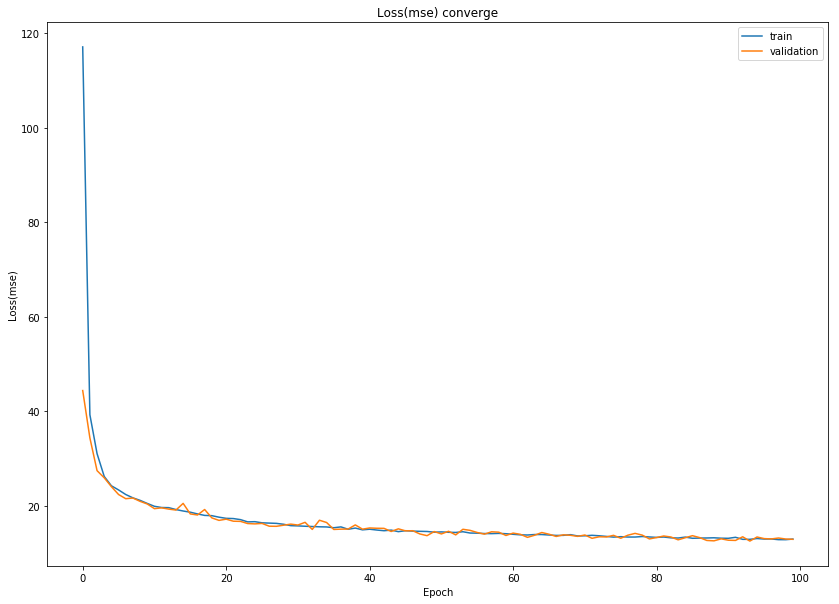

In [13]:
model_MC_OTM, result_MC_OTM = create_model(X_train_OTM, y_train_OTM)

100%|██████████| 100/100 [05:23<00:00,  3.24s/it]


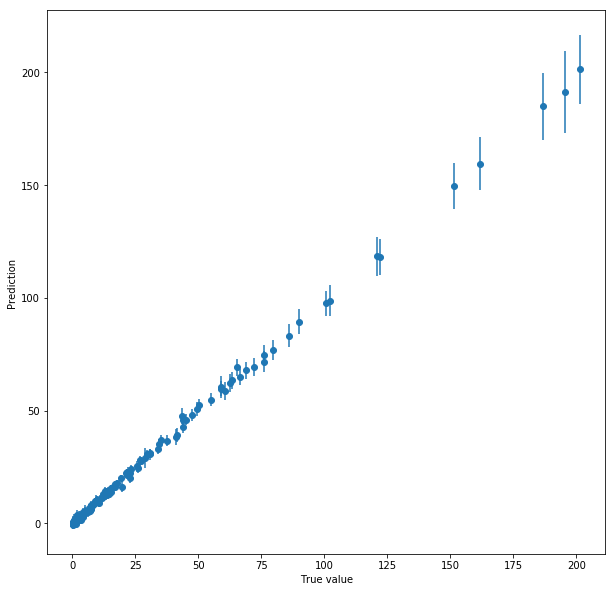

99.70% actual values are in 95CI
Adjusted R squared (R^2): 0.998177
Mean squared error (MSE): 2.40426
Mean absolute error (MAE): 1.0441


,true_value,prediction,uncertainty,upper_pred,lower_pred,in_95_CI
0,8.00,7.699371,1.724675,11.104432,4.720200,True
1,43.85,45.747528,2.493276,50.352711,40.098491,True
2,0.18,0.076252,1.845712,3.875974,-3.114846,True
3,55.45,56.089310,3.492675,62.986949,50.011755,True
4,6.90,5.777283,1.499484,8.338646,2.819780,True
5,1.45,1.115838,1.957551,5.224526,-2.413380,True
6,1.15,2.578003,2.215262,7.573703,-0.748048,True
7,25.10,26.313353,1.294841,29.210418,24.276849,True
8,1.50,1.600635,2.401340,6.431830,-2.693366,True
9,49.30,49.877510,3.200975,56.534959,44.352841,True


In [27]:
results_df_OTM, results_array_OTM = pred_MCdropout(model_MC_OTM, X_test_OTM, y_test_OTM, 100)
results_df_OTM.head(10)

In [15]:
model_MC_OTM.save('model_MC_OTM_1.h5')

## Reference: 
&emsp;&emsp;<br>
&emsp;&emsp;<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;<br>